In [167]:
# Preparing the Environment:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from zoomin.data.constants import (countries_dict, open_stack_list_NUTS3, open_stack_list_LAU, data_col_dic, 
                                    data_col_dic_hist, data_columns, osm_network_length, osm_stations_quantity,
                                    freight_traffic_flow, vehicle_stock_DE, vehicle_stock_buildings_PL,
                                    economic_metric, socio_metric, demographic_metric, pixeles_quantity,
                                    industry_electricity_demand, industry_fuel_demand, industry_generation_capacity,
                                    industry_plants_quantity, environmental, railway_length, residential_energy_demand)
from zoomin.data.osmtags import networks_tags_dict, stations_tags_dict, name_tags_dict
import nbformat
from nbconvert.preprocessors import CellExecutionError, ExecutePreprocessor
from IPython.display import display, HTML

# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import reciprocal
from sklearn.metrics import make_scorer, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from matplotlib.colors import LogNorm

# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
from keras.optimizers import Nadam, Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2
import xgboost as xgb
from xgboost import XGBRegressor
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


# Tensorflow configuration to use the GPU

In [168]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # If there are GPUs available, print a message and enable memory growth
  print("GPU is available")
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
else:
  print("GPU is not available")


GPU is available


In [169]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Creating directories

In [170]:
# # create a new directory for each value in the dictionary
# for value in countries_dict.values():
#     folder_path = os.path.join(cwd, '..', '..', '..', 'data', 'output',
#                         'spatial_disaggregation', 
#                         'data_visualization',
#                         'correlation_matrix',
#                         value)
#     if not os.path.exists(folder_path):
#         os.mkdir(folder_path)

# Pre-Processing
## Loading the data for EU

In [171]:
# Loading the data
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', '..', '..', 'data', 'input')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, 'processed')

In [172]:
def read_Data():
        data_path = os.path.join(
        PROCESSED_DATA_PATH, 
        'ancilliary_data',
        'processed' 
        "data.csv")
        data_eu_raw = pd.read_csv(data_path)
        return data_eu_raw

In [173]:
data_eu_raw = read_Data()

## Filter Data for each country and creates its own csv file and saves it in the same directory

In [174]:
# define the directory where the data will be saved
output_dir = os.path.join(cwd, '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_raw')

# loop over the dictionary and filter the data and save it to the corresponding directory
for country, abbreviation in countries_dict.items():
    # filter the data based on the country abbreviation
    data_filtered = data_eu_raw[data_eu_raw["NUTS0_region_code"] == abbreviation]

    # create the directory for the country if it does not exist
    country_dir = os.path.join(output_dir, abbreviation)
    if not os.path.exists(country_dir):
        os.makedirs(country_dir)

    # save the filtered data to a CSV file in the country directory
    file_path_destination = os.path.join(country_dir, f"data_{abbreviation}_raw.csv")
    if not os.path.exists(file_path_destination):
        data_filtered.to_csv(file_path_destination, index=False)

## Loading data for specific country to use for testing

In [175]:
region = input('Please load data for specific country: EU, BE, EL, LT, PT, BG, ES, LU, RO, CZ, FR, HU, SI, DK, HR, MT, SK, DE, IT, NL, FI, EE, CY, AT, SE, IE, LV, PL')

In [176]:
def read_Data(region):
        data_path = os.path.join(cwd, '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_raw', f'{region}',  
        f"data_{region}_raw.csv")
        data_region_raw = pd.read_csv(data_path)
        return data_region_raw

In [177]:
data_region_raw = read_Data(region)

## Data Exploration
Here look into the statistics of the data, identify any missing values or categorical features that is needed to be further process.

##### EU

In [178]:
# pd.options.display.max_columns = 182
# pd.options.display.float_format = '{:,.2f}'.format
# data_eu_raw.describe()

In [179]:
# data_eu_raw['road_major_network_value']

##### Country

In [180]:
# pd.options.display.max_columns = 182
# pd.options.display.float_format = '{:,.2f}'.format
# data_region_raw.describe()

##### EU

In [181]:
# data_eu_raw.info()

##### Country

In [182]:
# data_region_raw.info()

##### Columns

In [183]:
column_list = []
# assuming your DataFrame is called 'df'
for col in data_eu_raw.columns:
    column_list.append(col)
    

In [184]:
column_list

['EU_region_code',
 'NUTS0_region_code',
 'NUTS1_region_code',
 'NUTS2_region_code',
 'NUTS3_region_code',
 'deaths_value',
 'electricity demand of chemical industries_value',
 'electricity demand of iron and steel industries_value',
 'electricity demand of non-ferrous metal industries_value',
 'electricity demand of non-metallic mineral industries_value',
 'electricity demand of paper and printing industries_value',
 'electricity demand of refineries_value',
 'employment in nace sector G-I_value',
 'Distance_from_origin_region_to_E_road',
 'Distance_within_E_road',
 'Distance_from_E_road_to_destination_region',
 'Total_distance',
 'Traffic_flow_trucks_2010',
 'Traffic_flow_trucks_2019',
 'Traffic_flow_trucks_2030',
 'Traffic_flow_tons_2010',
 'Traffic_flow_tons_2019',
 'Traffic_flow_tons_2030',
 'fuel demand of chemical industries_value',
 'fuel demand of iron and steel industries_value',
 'fuel demand of non-ferrous metal industries_value',
 'fuel demand of non-metallic mineral indus

### Data Visualization

#### Histogram

        This function takes a DataFrame df, a list of lists of column names column_lists, a number of bins for the histogram bins, and a size for the figure figsize as inputs. It then creates a figure with one subplot for each list of column names in column_lists, uses the hist() function from pandas to plot a histogram of the columns in each list, and sets the xlabel and ylabel for each subplot. 

In [185]:
def plot_column_histograms(dataframe, col_dict, fig_size=(10, 5)):
    """
    Plot histograms for multiple columns of a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    col_dict (dict): A dictionary where each key is the name of a figure, and each value is a list of column names to plot in that figure.
    fig_size (tuple): The size of the figure in inches (default: (10, 5)).

    Returns:
    None
    """
    for fig_title, col_names in col_dict.items():
        file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                        'spatial_disaggregation',
                        'data_visualization',
                        'histogram',
                        'EU',
                        f"{fig_title}_histogram_EU.png")
        # Determine the number of subplots and the number of rows and columns needed
        num_subplots = len(col_names)
        num_cols = min(num_subplots, 4)
        num_rows = math.ceil(num_subplots / num_cols)

        # Create the figure and subplots
        fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=fig_size, squeeze=False)
        fig.suptitle(f"{fig_title}_EU")

        # Remove any unused subplots
        for i in range(num_subplots, num_rows * num_cols):
            fig.delaxes(axs.flatten()[i])

        # Plot each column in the appropriate subplot
        for i, col_name in enumerate(col_names):
            if col_name is None:
                continue
            try:
                row = i // num_cols
                col = i % num_cols
                axs[row, col].hist(dataframe[col_name], bins=50, facecolor='b', edgecolor='white')
                xlabel = col_name.split('_')[0]  # use the first part of the column name
                axs[row, col].set_xlabel(xlabel, rotation=5)  # rotate the label for better readability
            except ValueError:
                print(f"Skipping column '{col_name}' because of 'ValueError: autodetected range of [nan, nan] is not finite'")

        fig.subplots_adjust(hspace=0.5)
        
         # Save data to file if it doesn't exist
        if not os.path.exists(file_path_destination):
            plt.savefig(file_path_destination)
        plt.show()

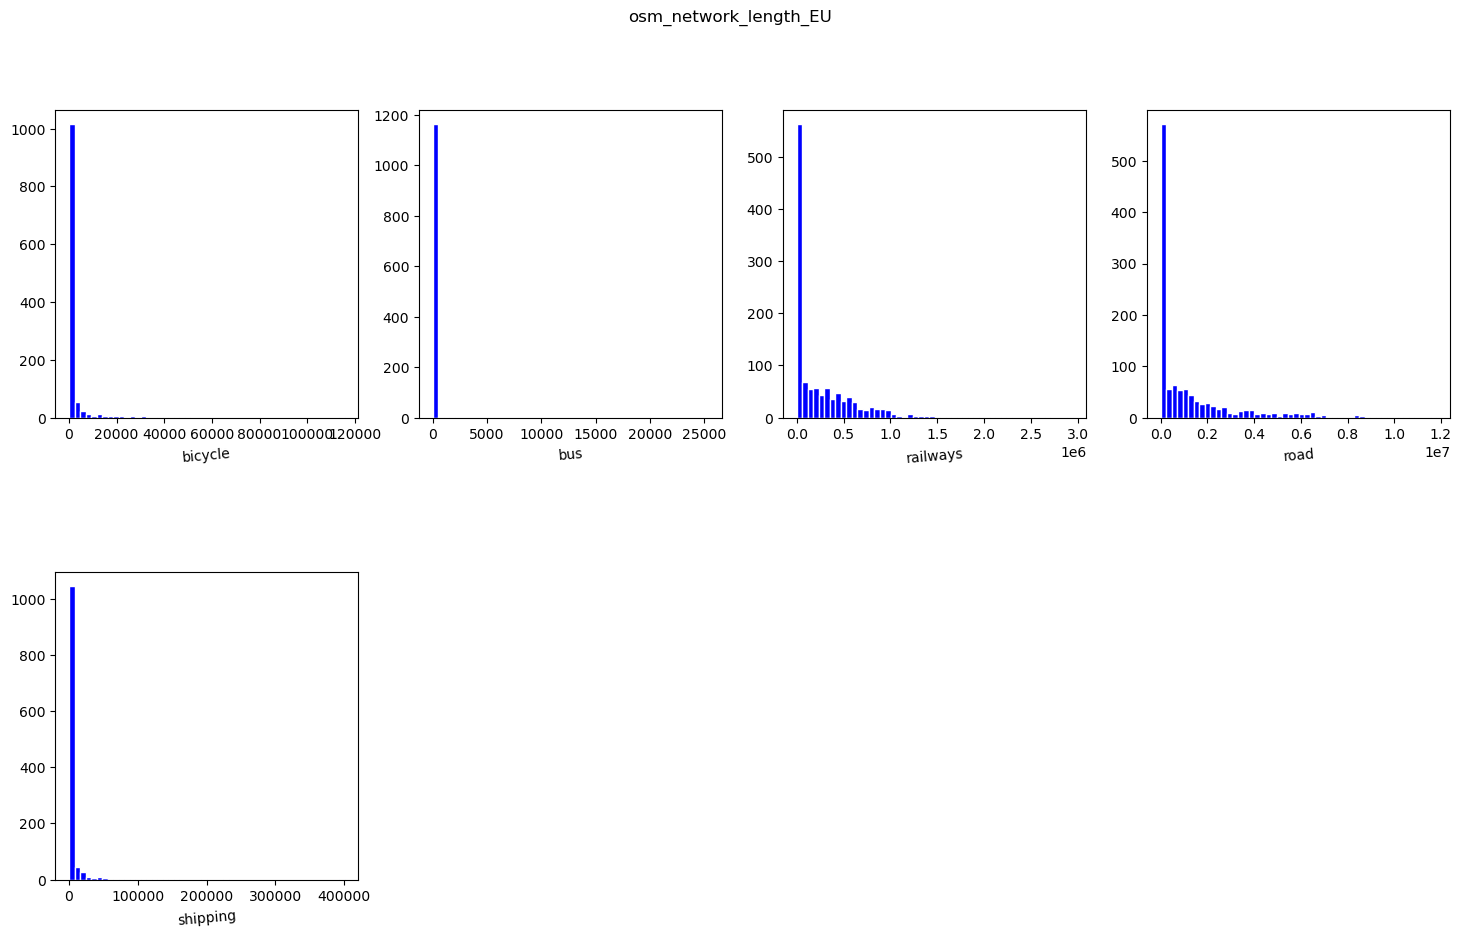

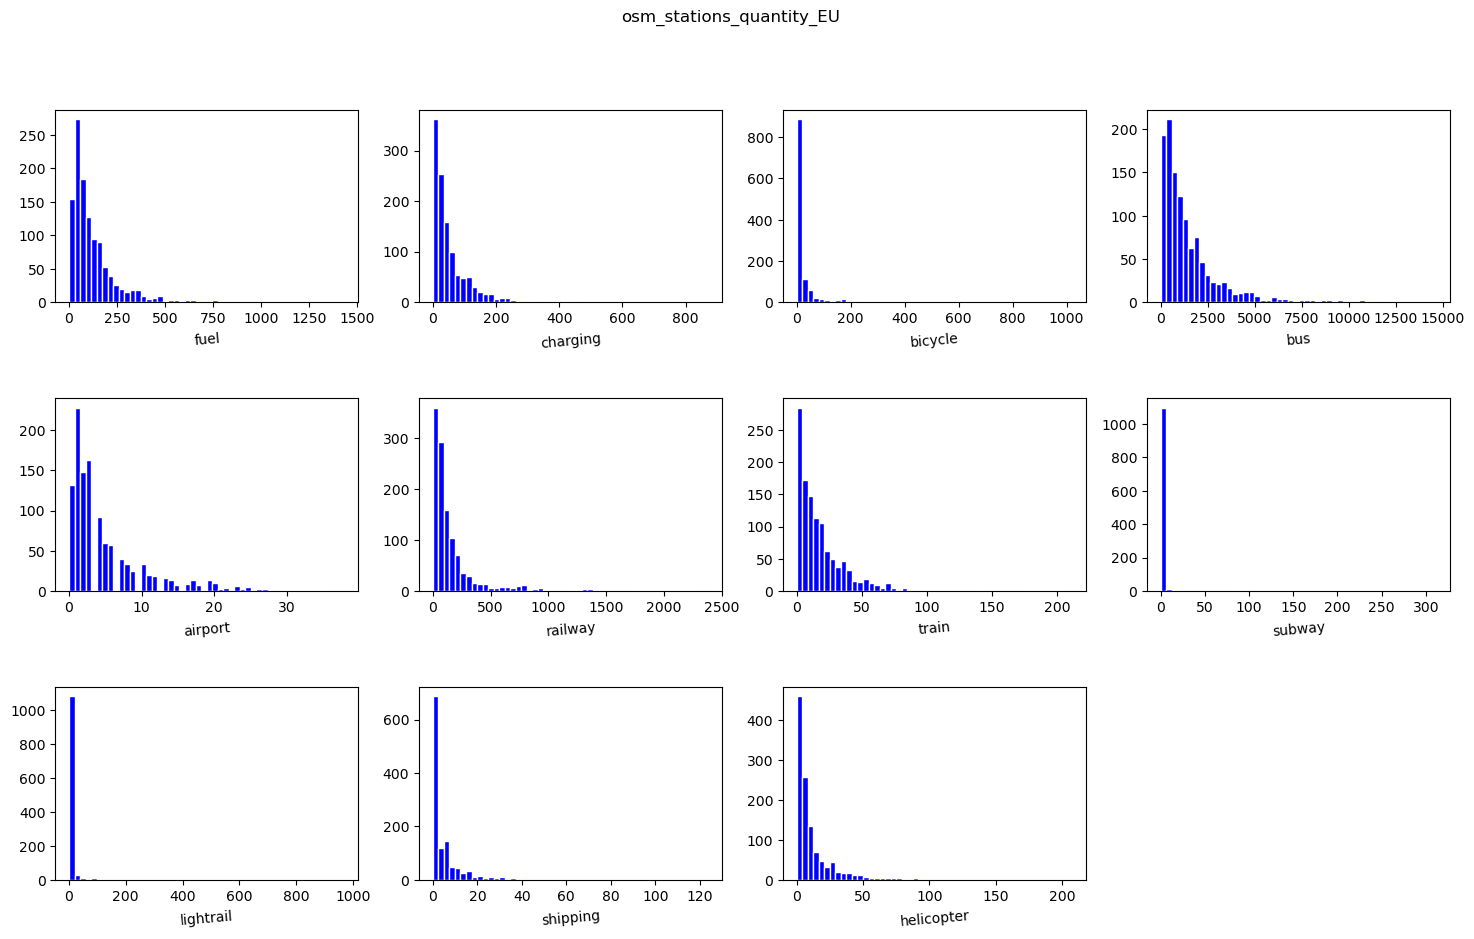

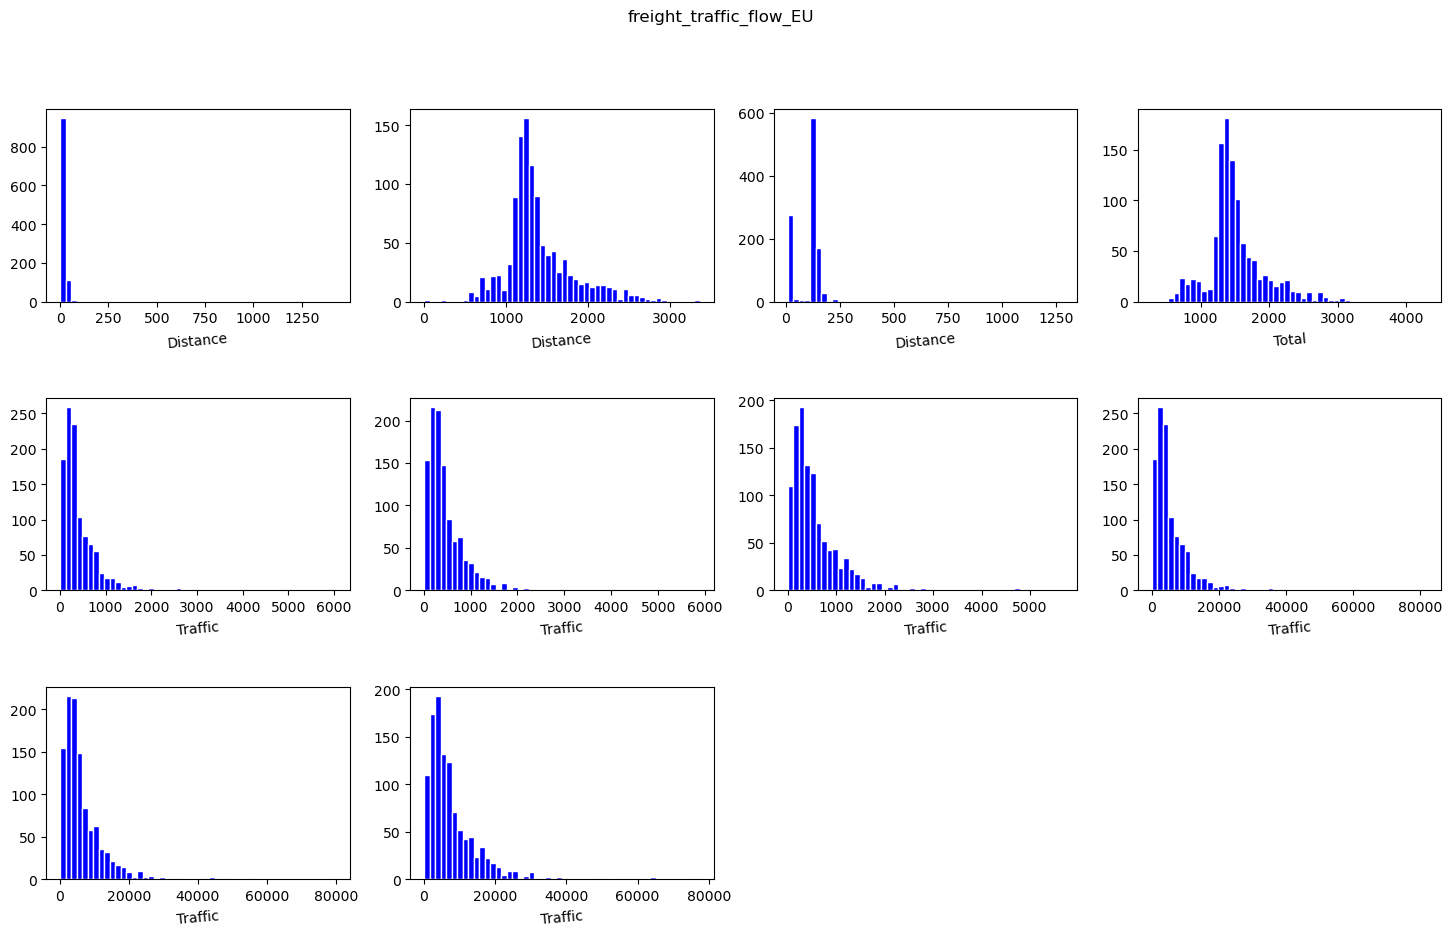

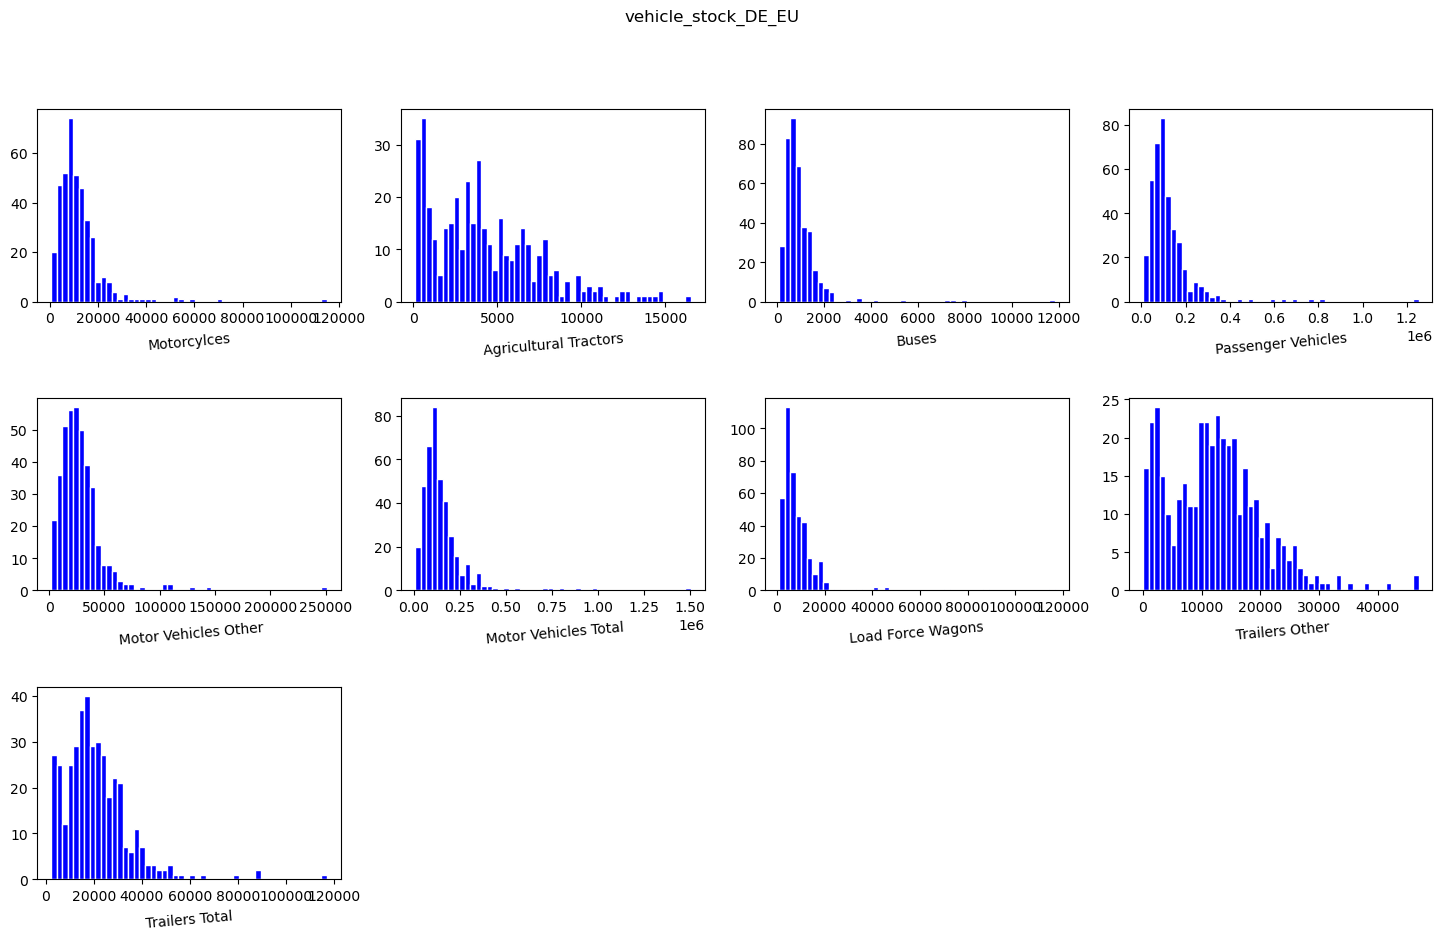

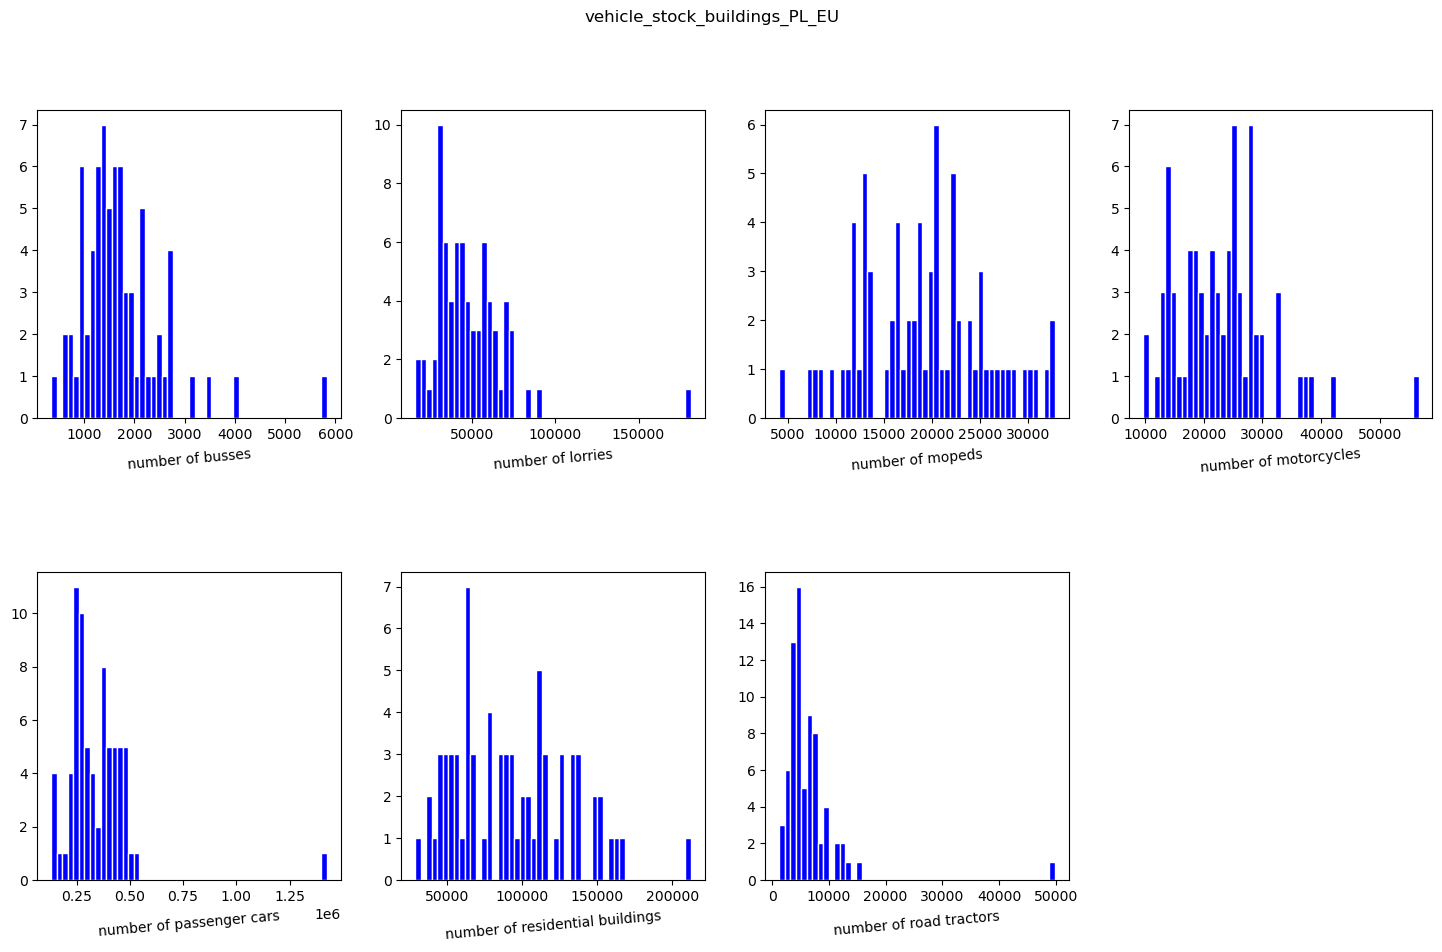

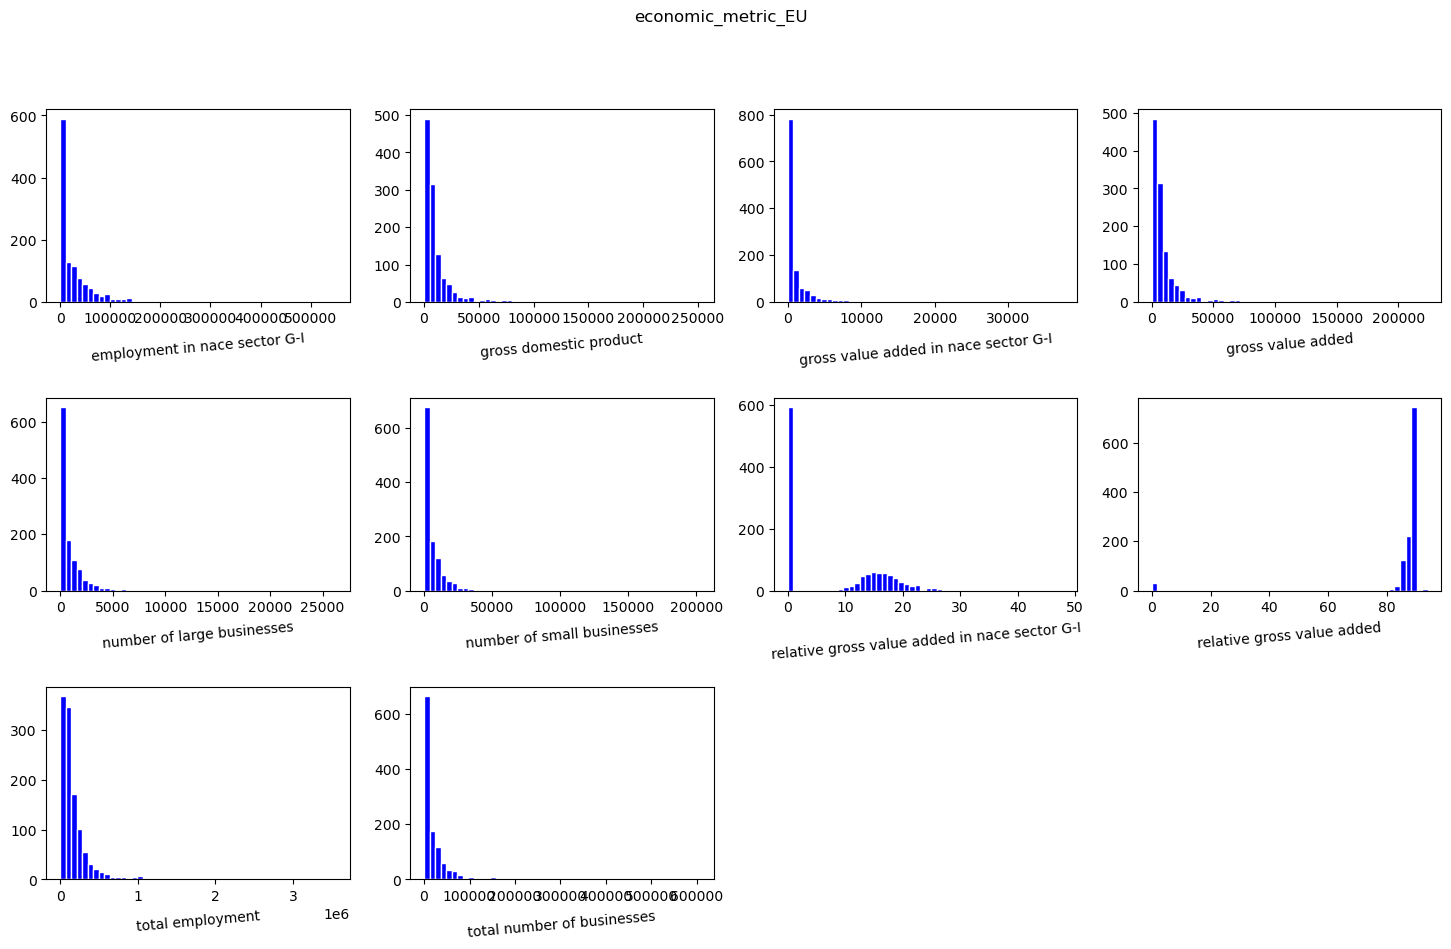

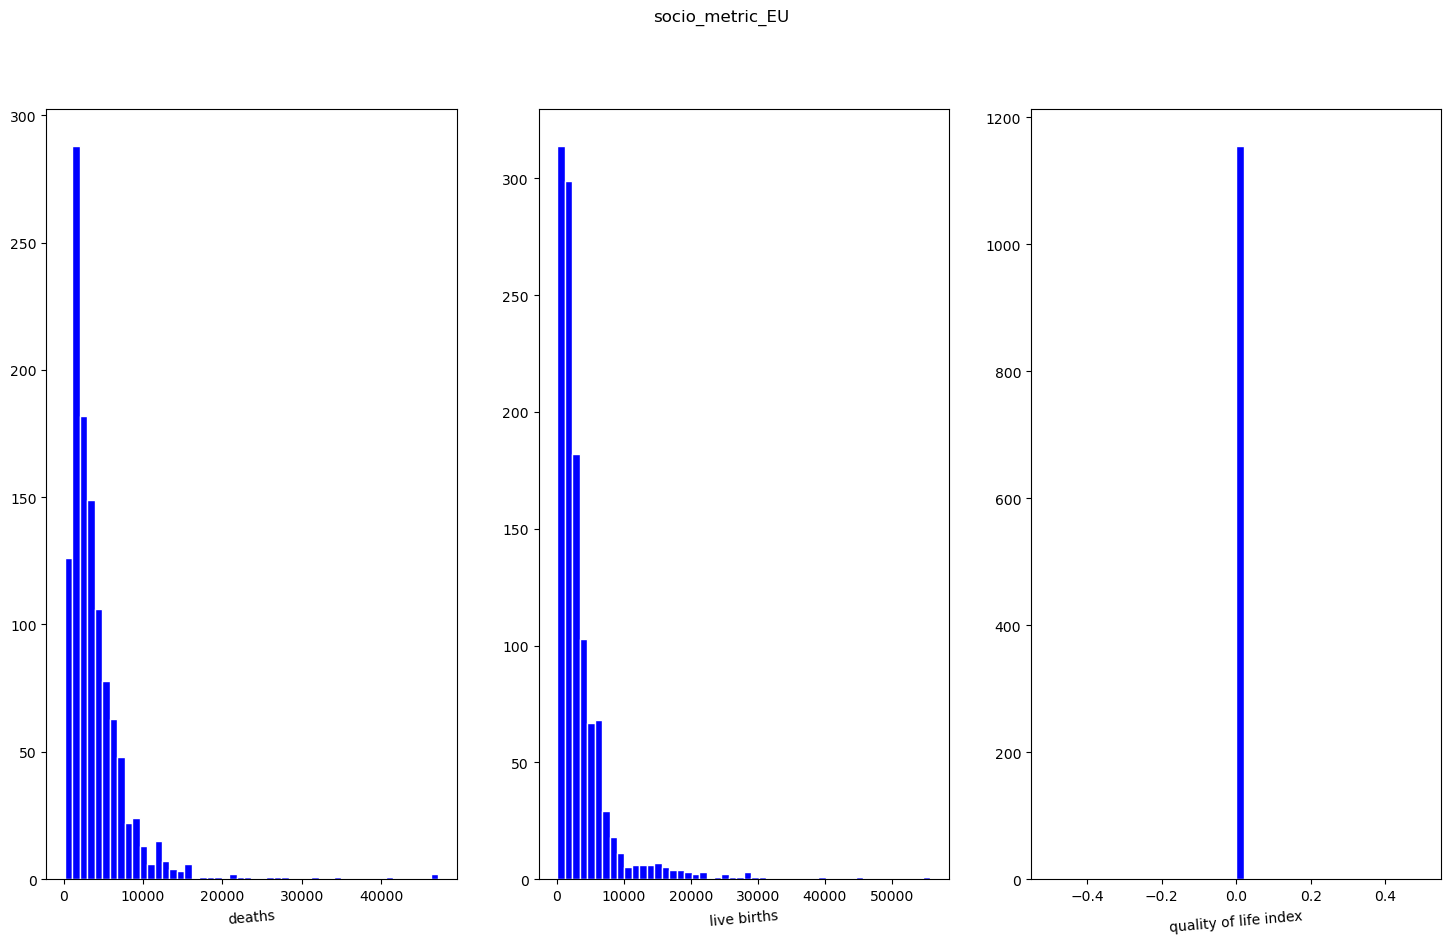

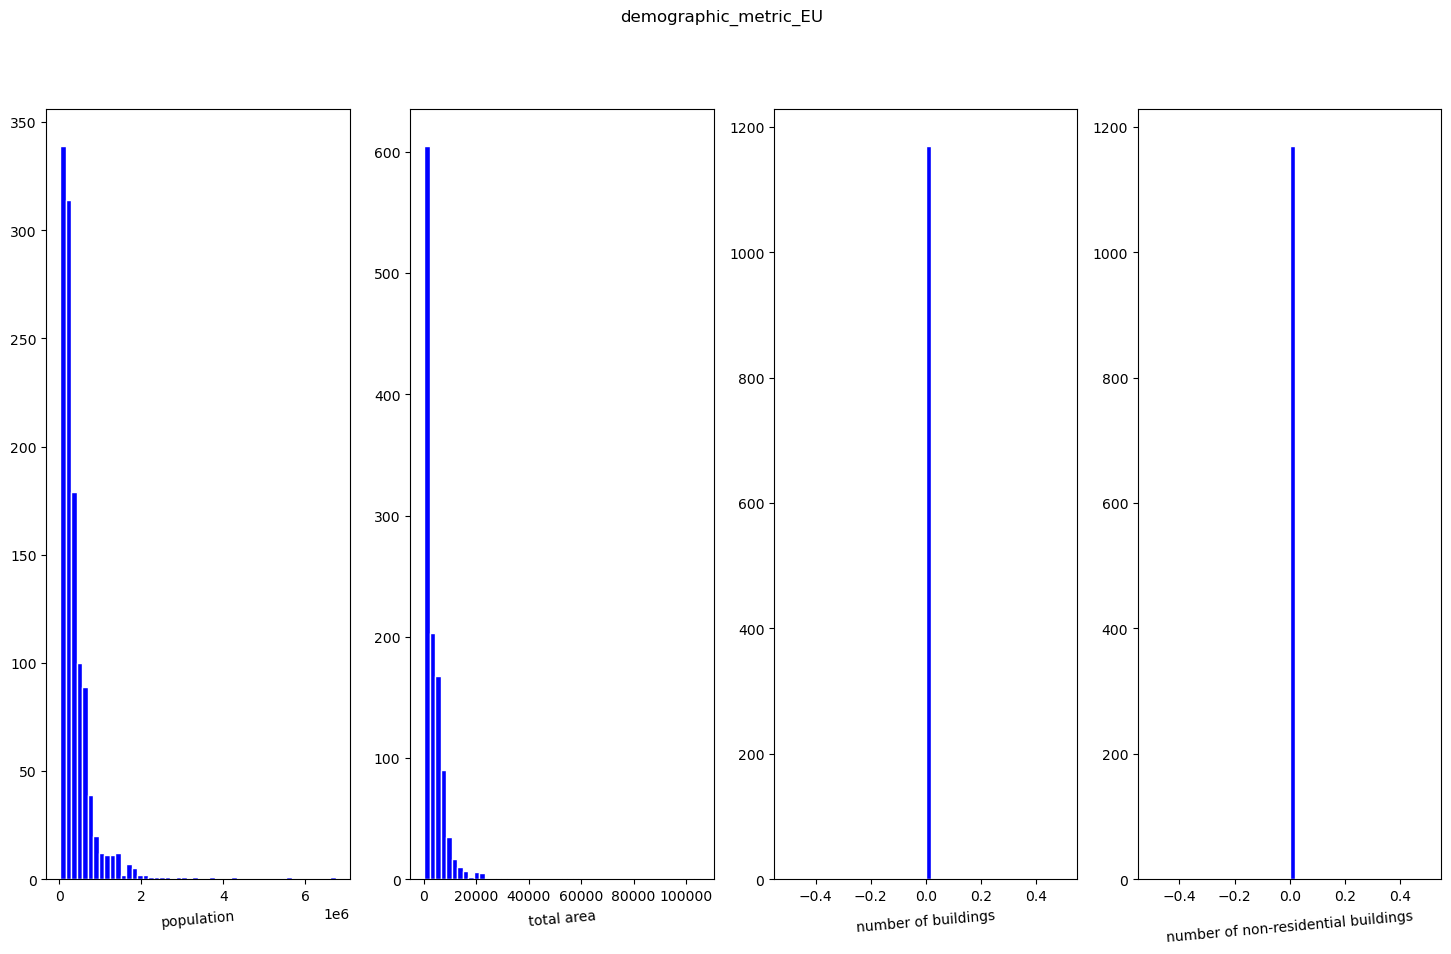

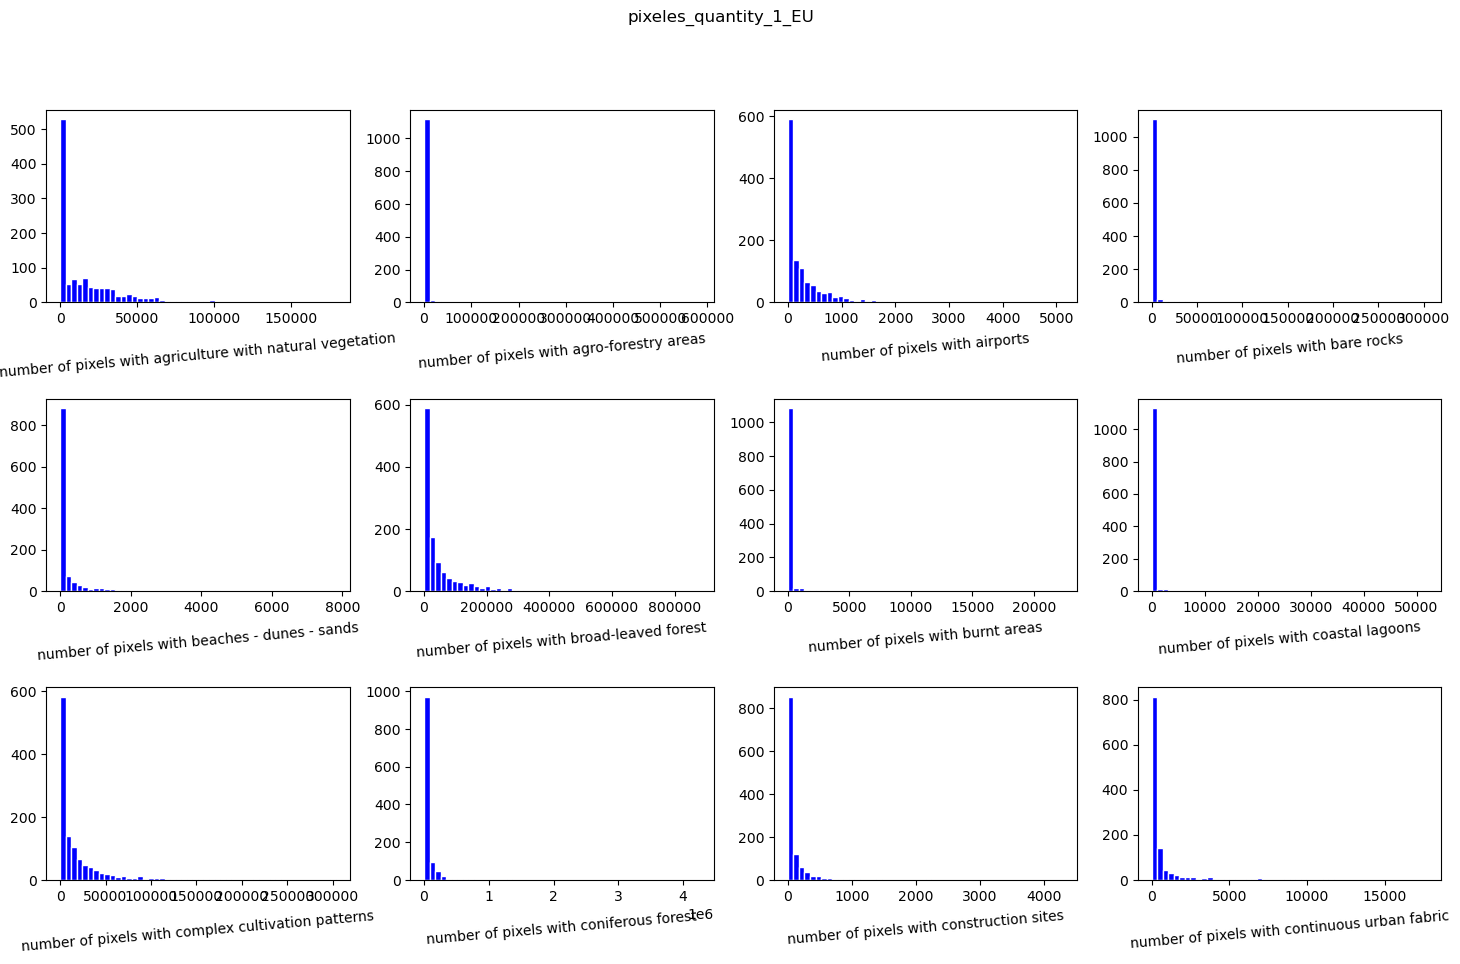

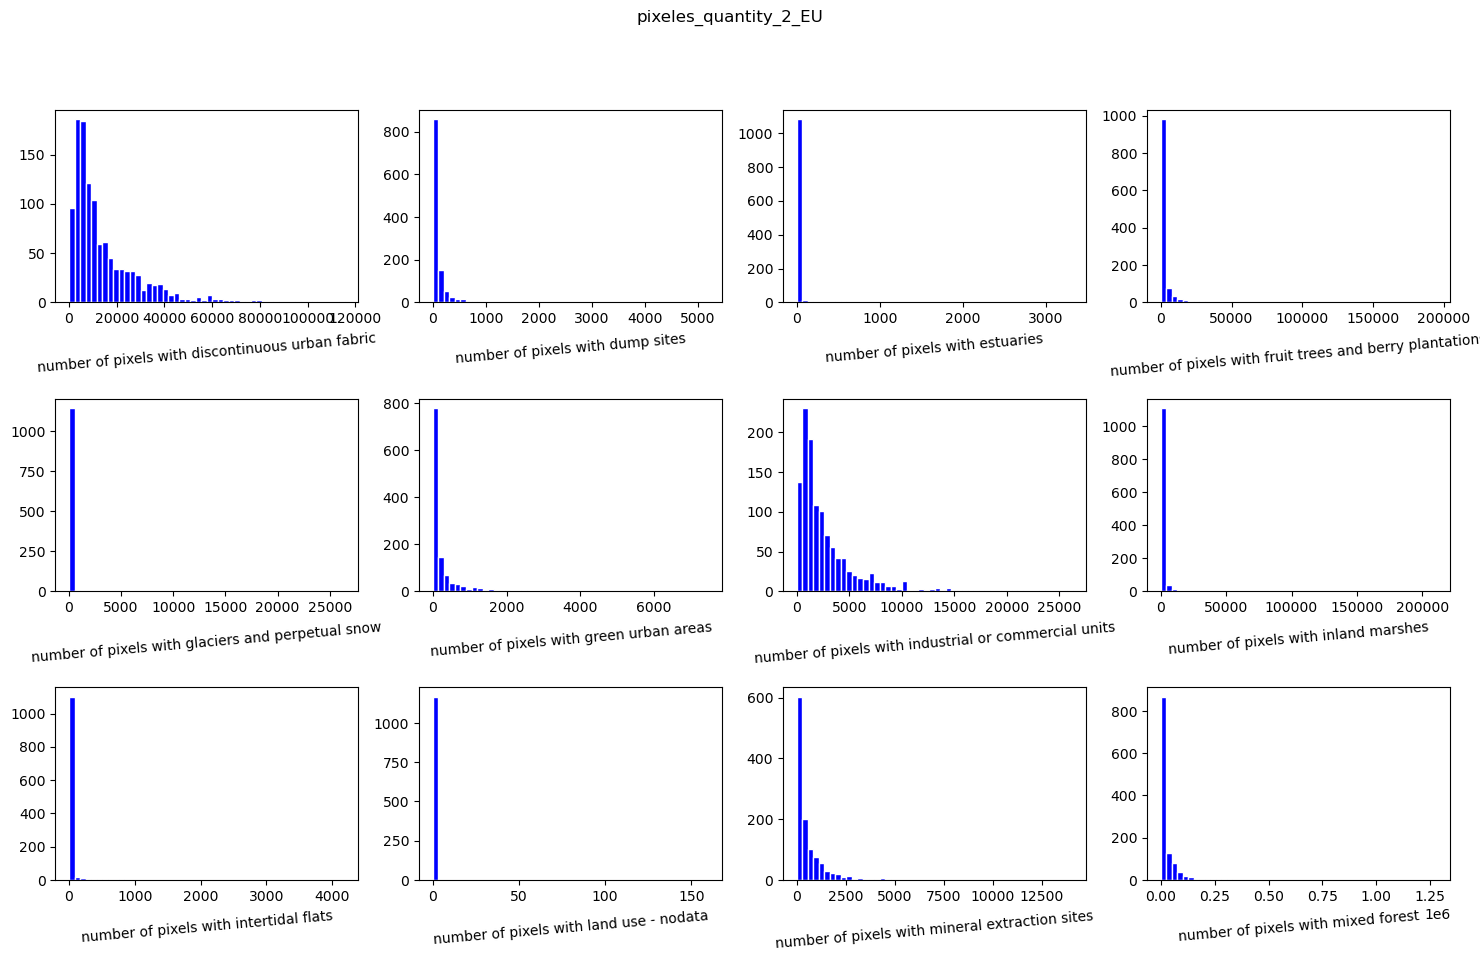

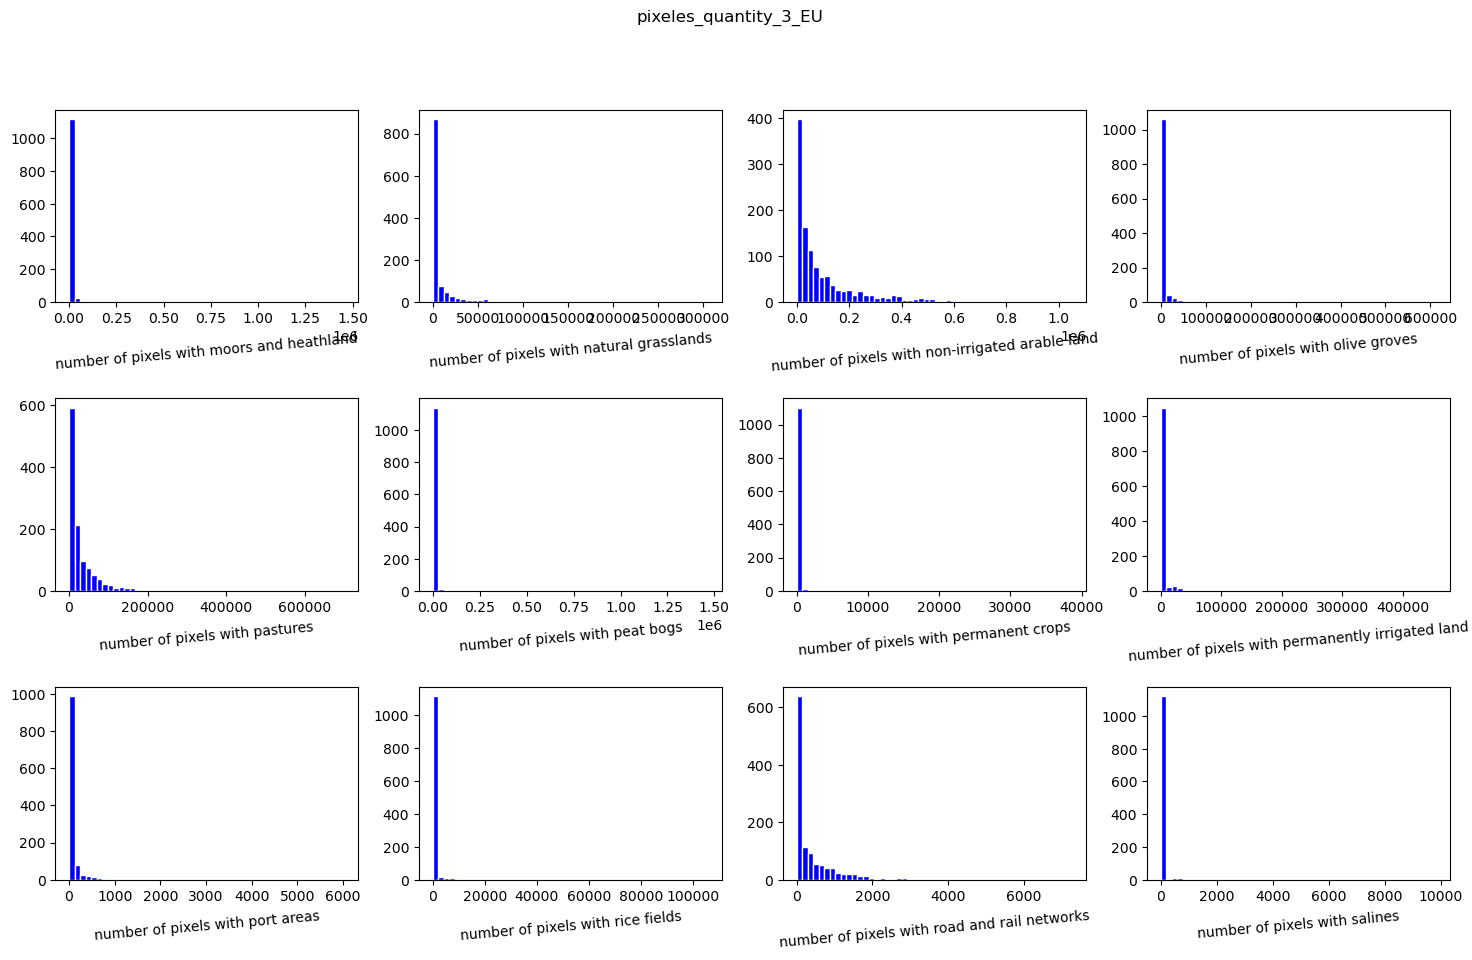

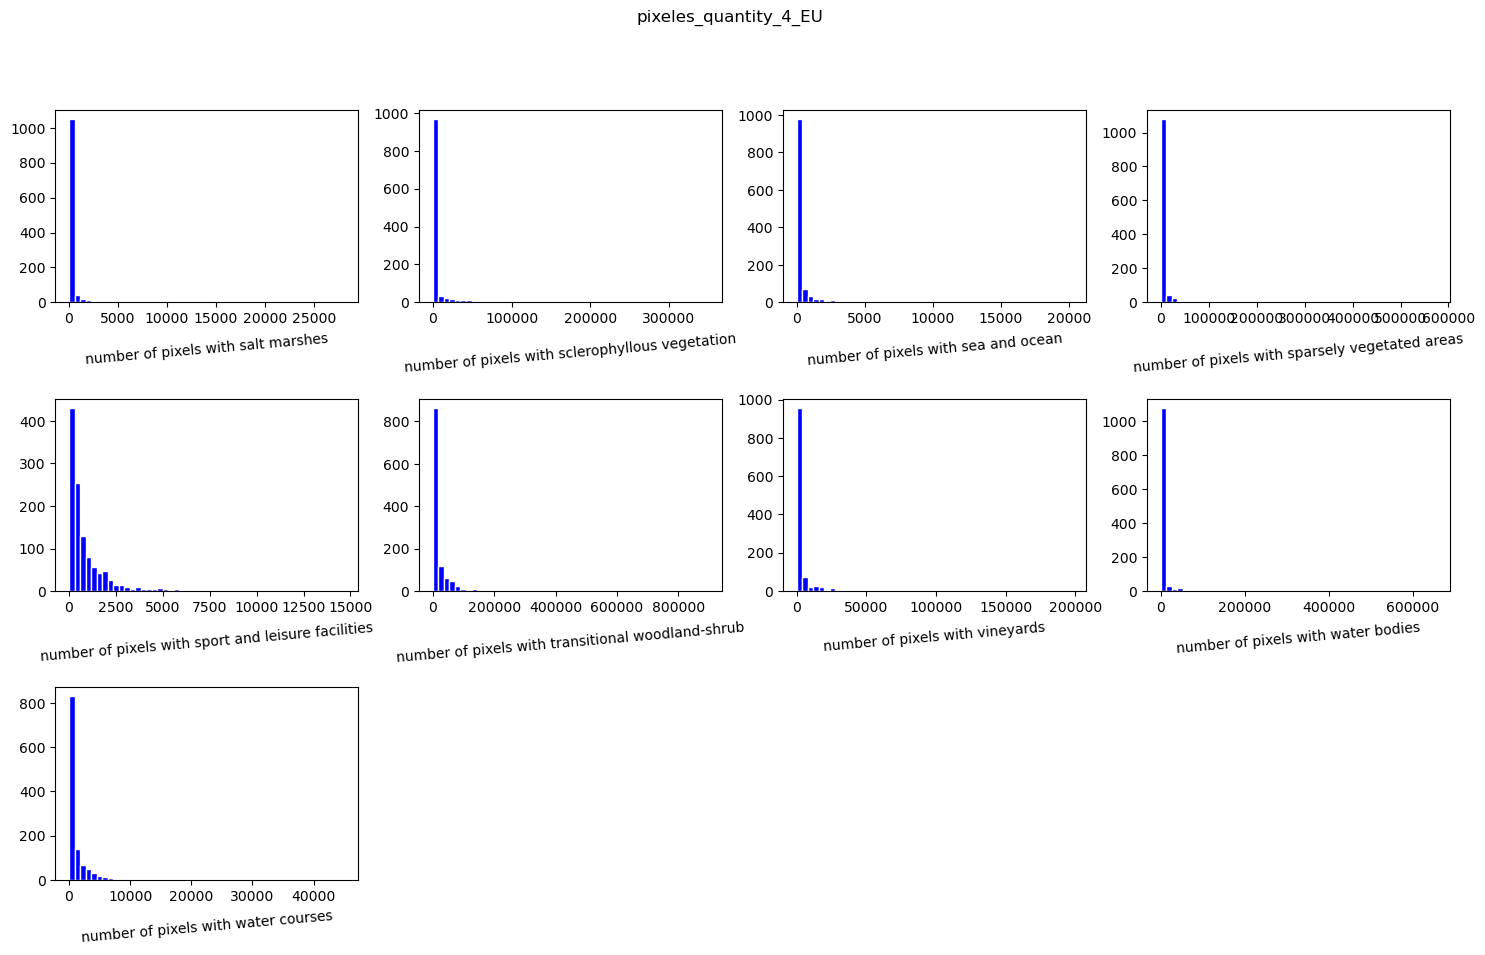

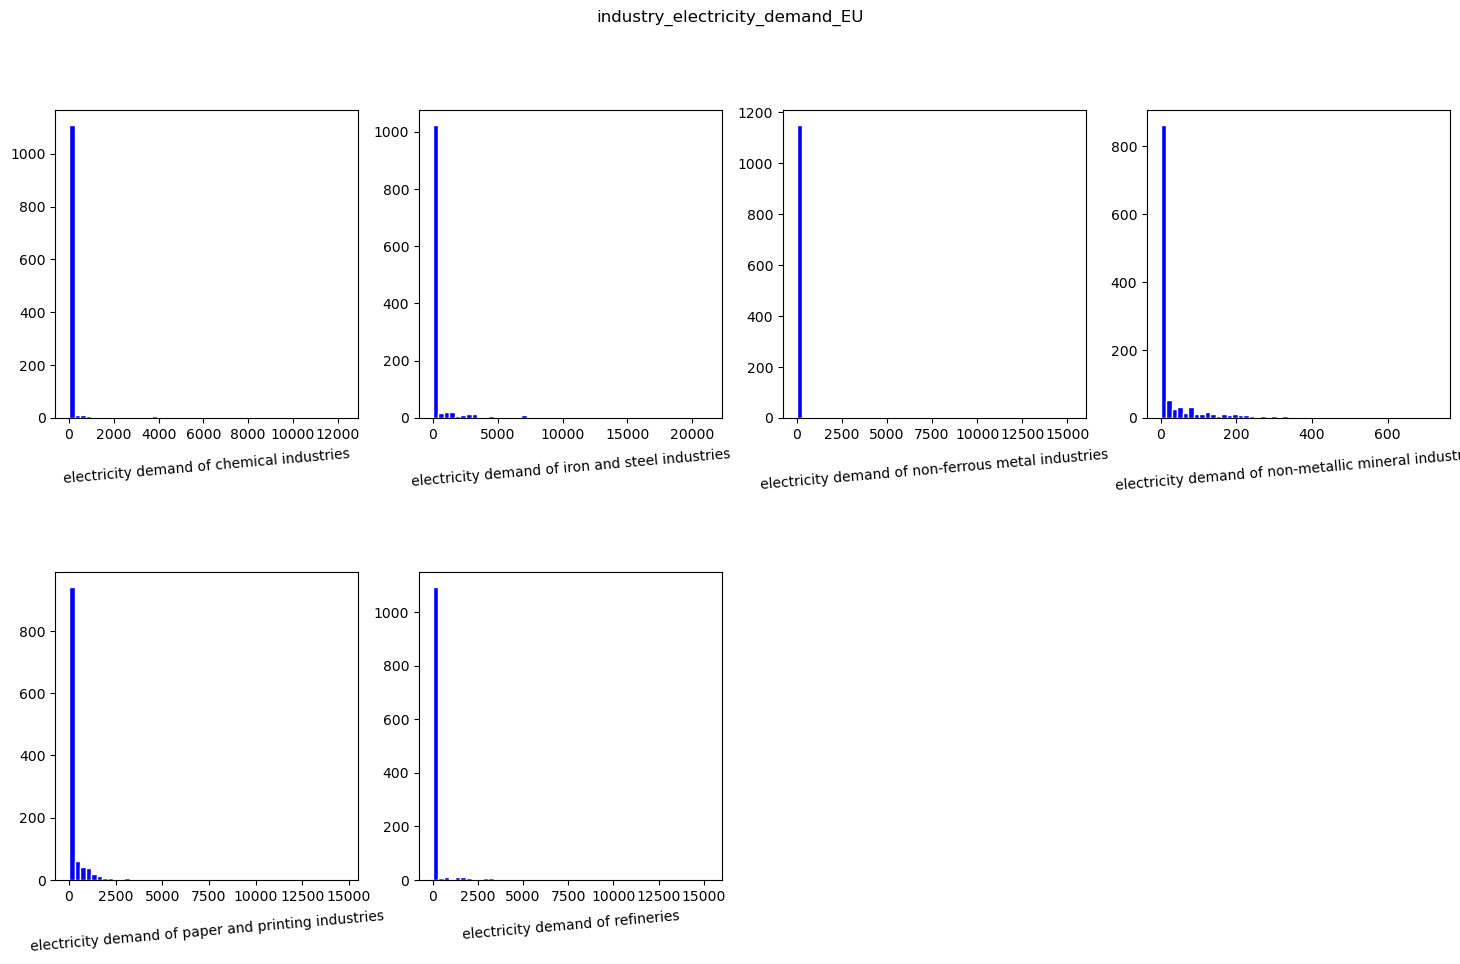

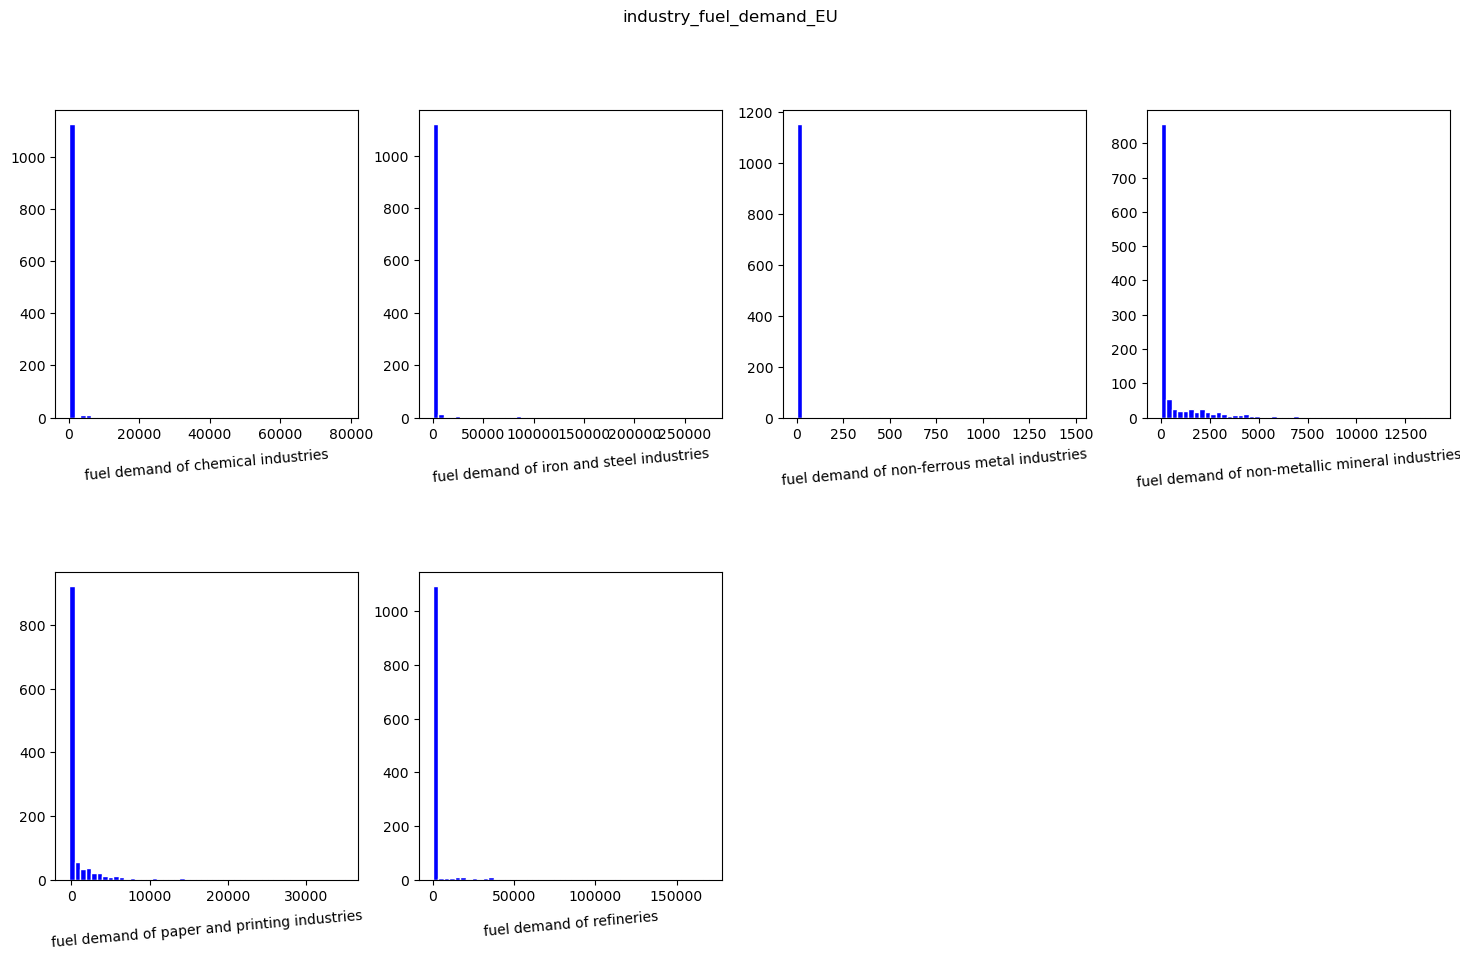

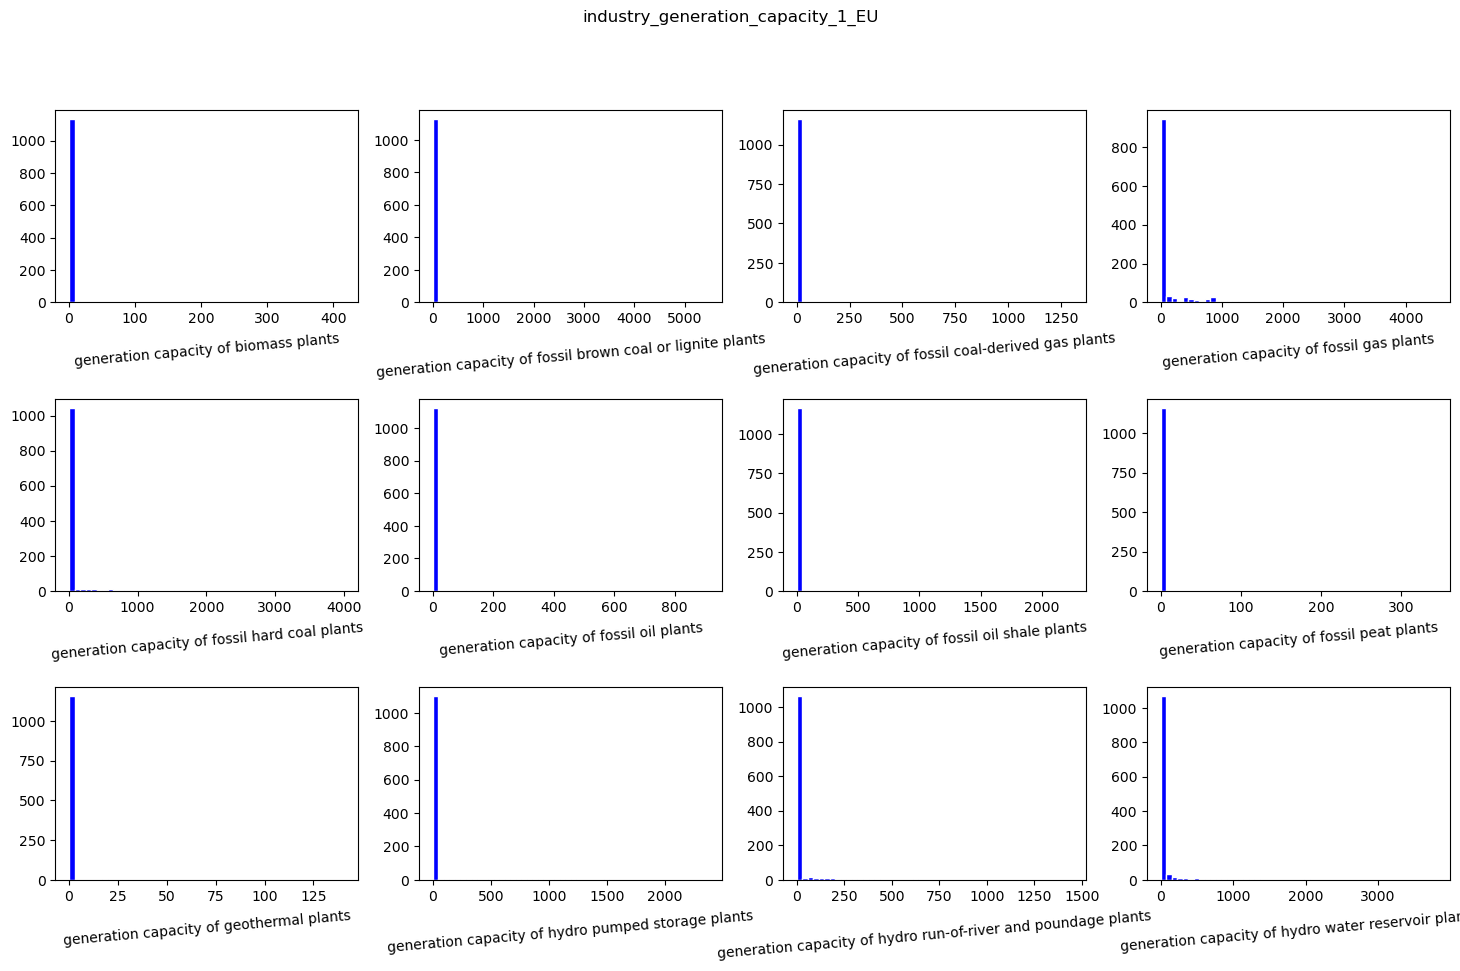

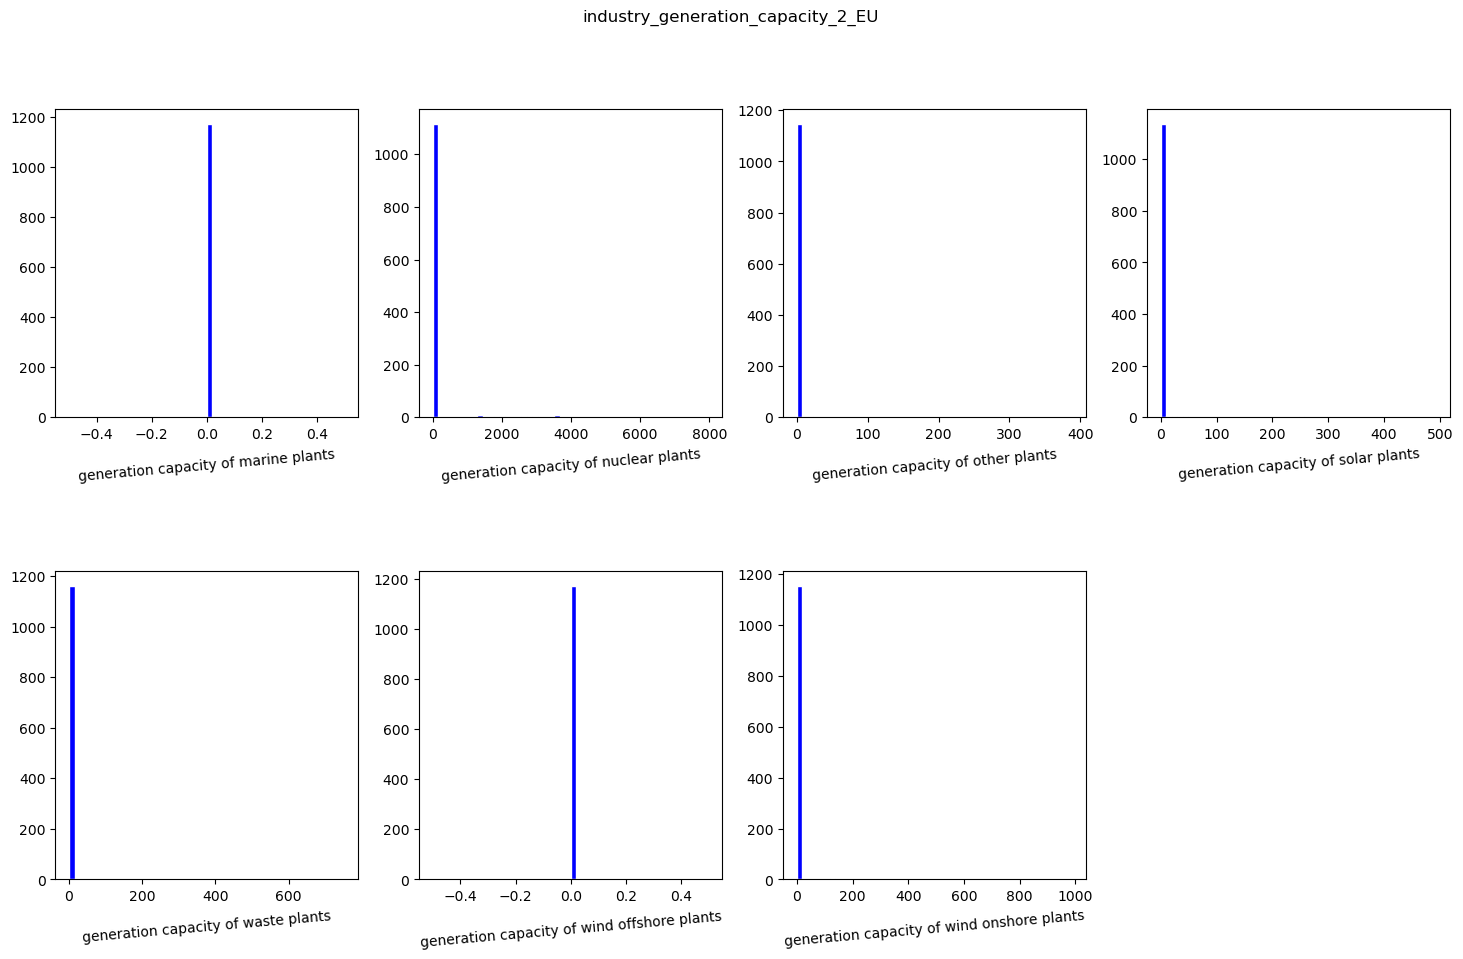

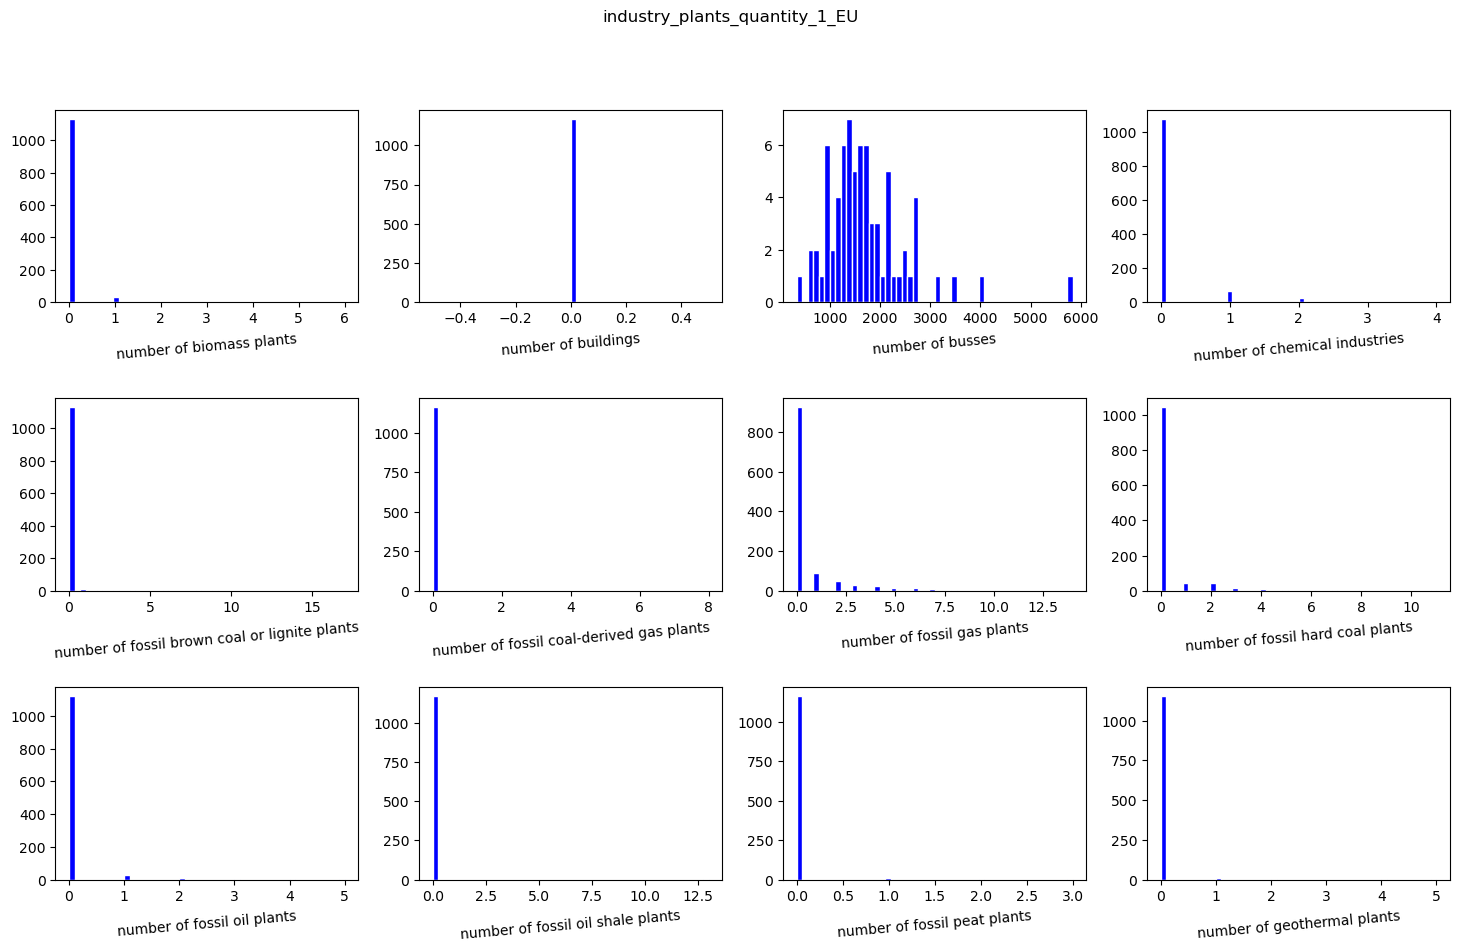

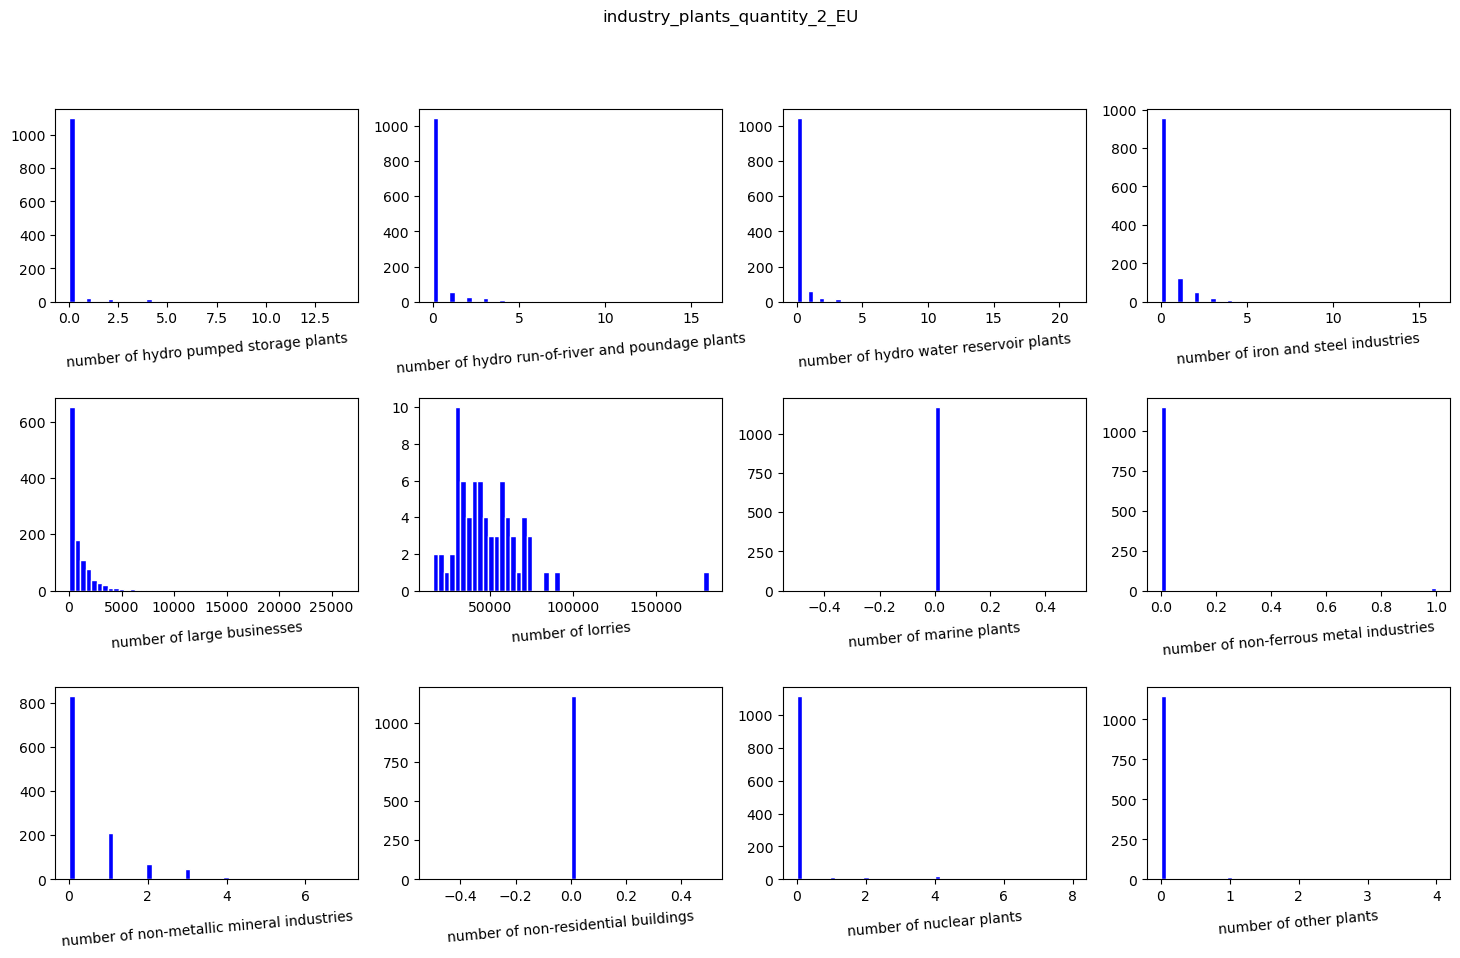

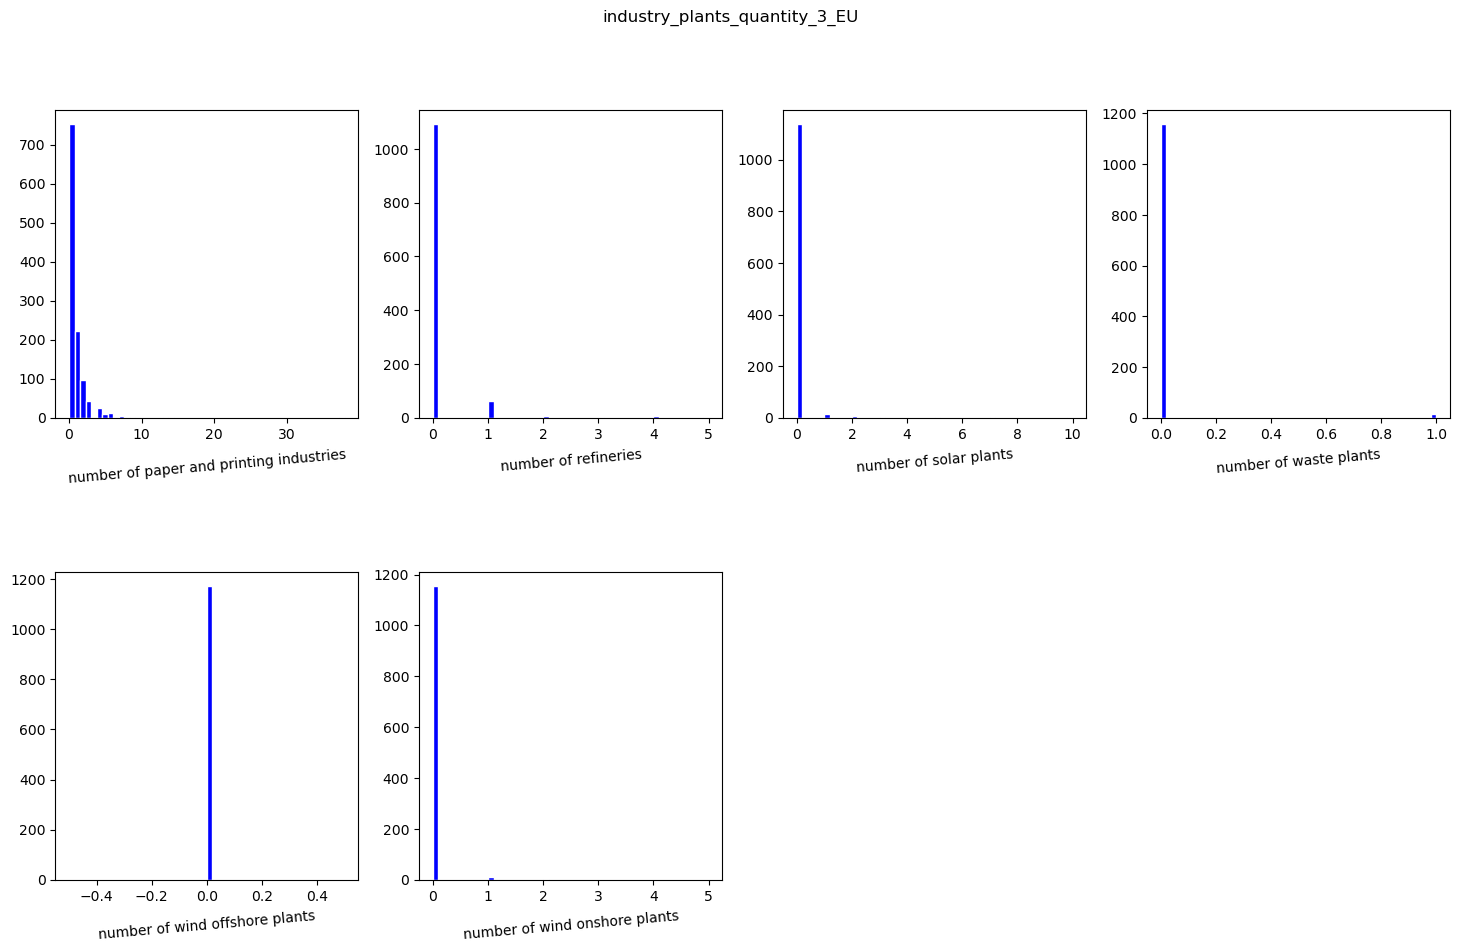

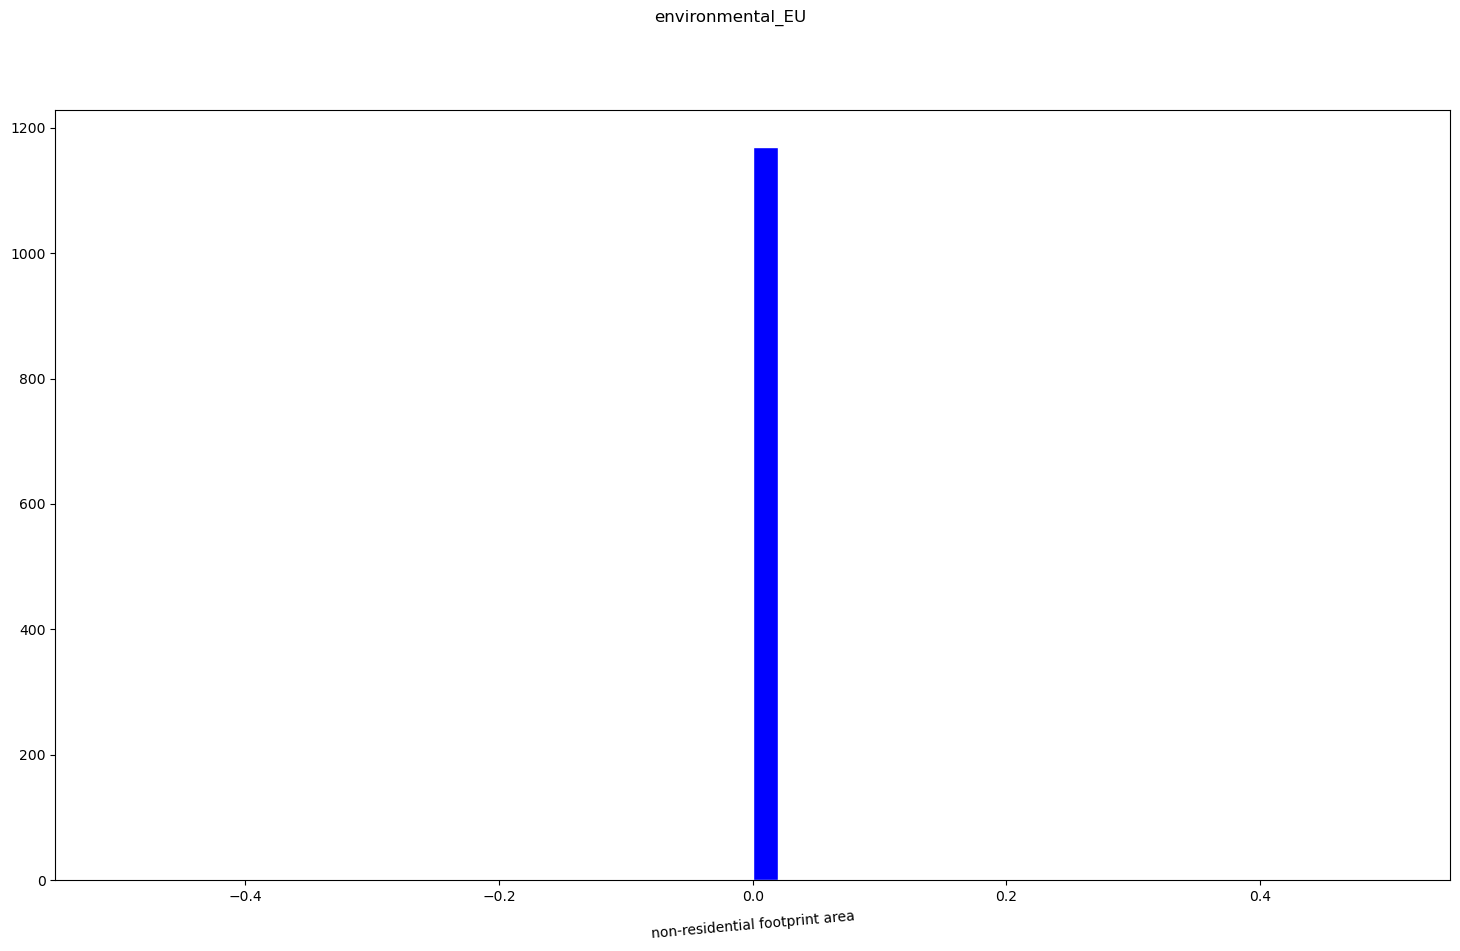

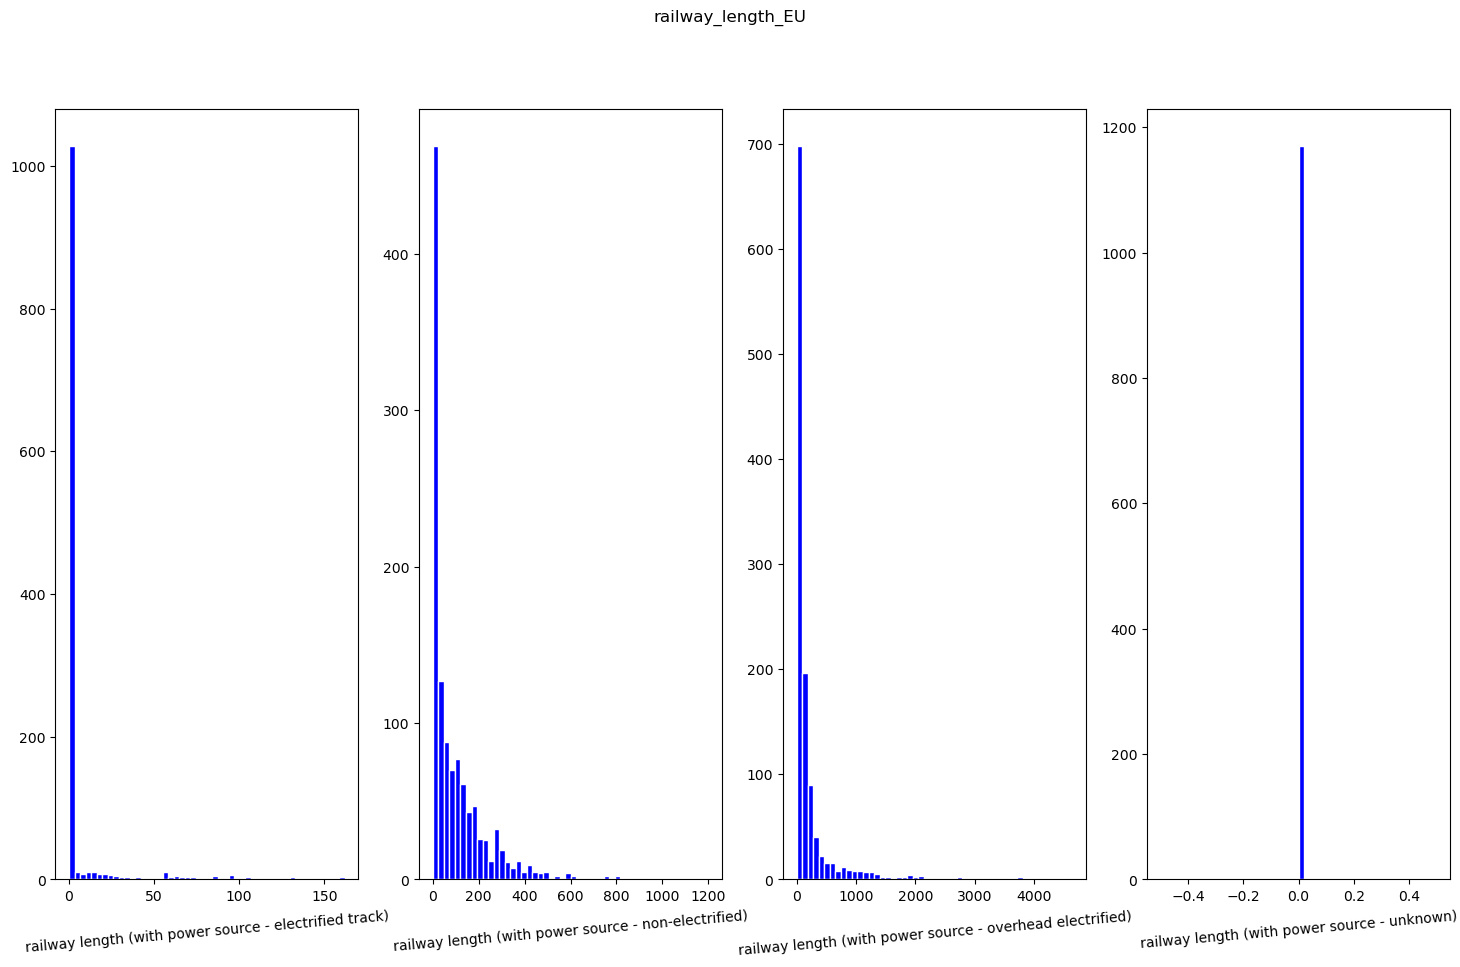

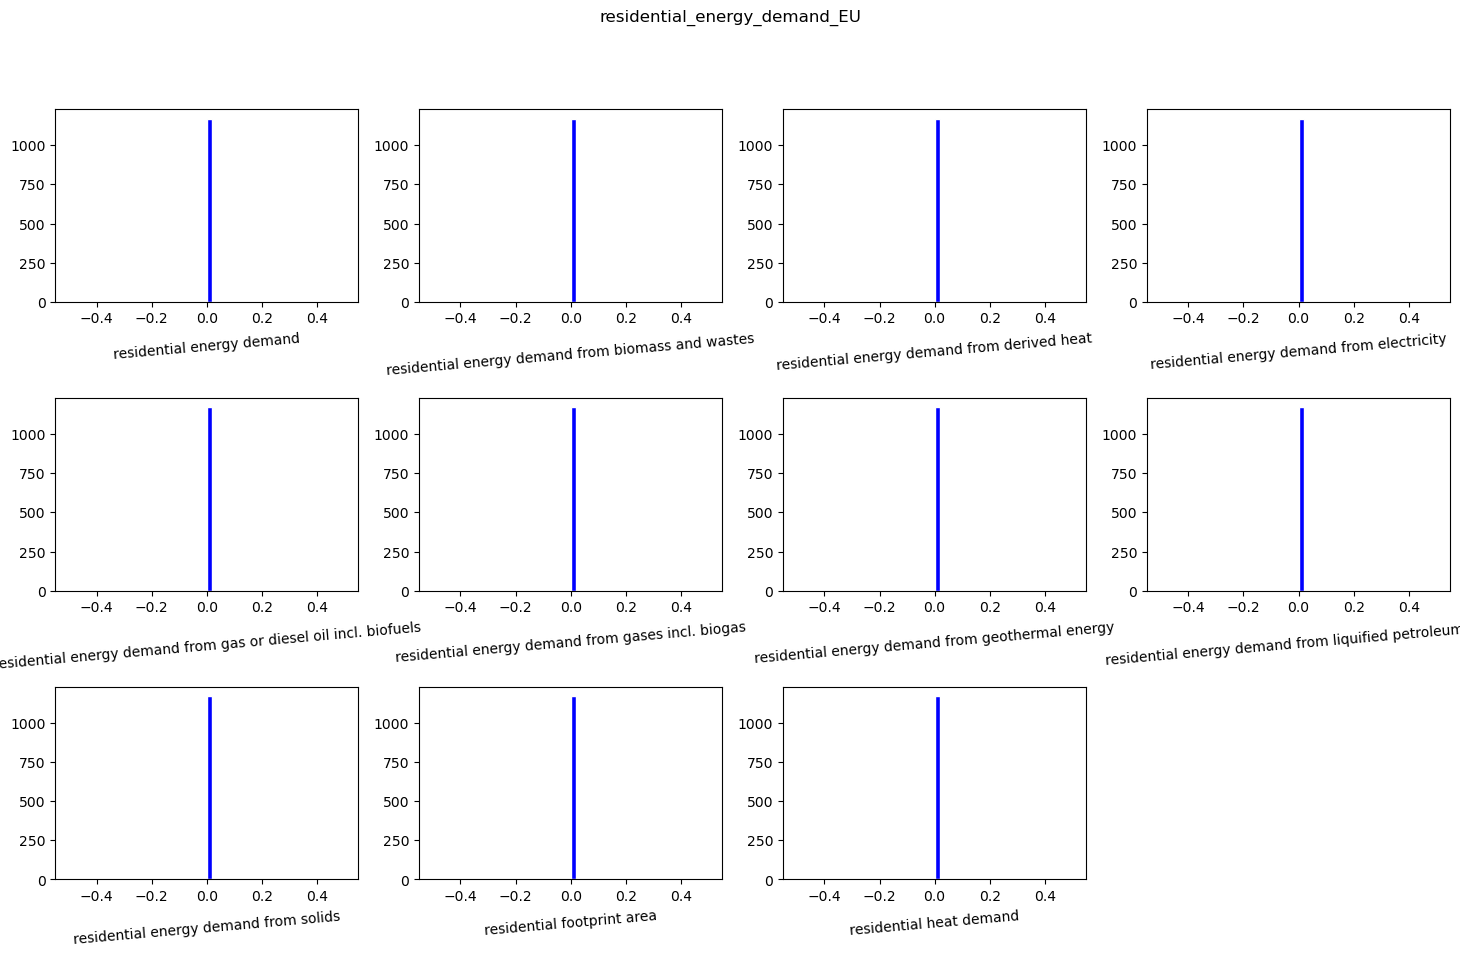

In [186]:
plot_column_histograms(data_eu_raw, data_col_dic_hist, fig_size=(18, 10))

#### Country

In [187]:
def plot_column_histograms(dataframe, col_dict, region, fig_size=(10, 5)):
    """
    Plot histograms for multiple columns of a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    col_dict (dict): A dictionary where each key is the name of a figure, and each value is a list of column names to plot in that figure.
    fig_size (tuple): The size of the figure in inches (default: (10, 5)).

    Returns:
    None
    """
    for fig_title, col_names in col_dict.items():
        file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                        'spatial_disaggregation',
                        'data_visualization',
                        'histogram',
                        f'{region}',
                        f"{fig_title}_histogram_{region}.png")
        # Determine the number of subplots and the number of rows and columns needed
        num_subplots = len(col_names)
        num_cols = min(num_subplots, 4)
        num_rows = math.ceil(num_subplots / num_cols)

        # Create the figure and subplots
        fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=fig_size, squeeze=False)
        fig.suptitle(f"{fig_title}_{region}")

        # Remove any unused subplots
        for i in range(num_subplots, num_rows * num_cols):
            fig.delaxes(axs.flatten()[i])

        # Plot each column in the appropriate subplot
        for i, col_name in enumerate(col_names):
            if col_name is None:
                continue
            try:
                row = i // num_cols
                col = i % num_cols
                axs[row, col].hist(dataframe[col_name], bins=50, facecolor='b', edgecolor='white')
                xlabel = col_name.split('_')[0]  # use the first part of the column name
                axs[row, col].set_xlabel(xlabel, rotation=5)  # rotate the label for better readability
            except ValueError:
                print(f"Skipping column '{col_name}' because of 'ValueError: autodetected range of [nan, nan] is not finite'")

        fig.subplots_adjust(hspace=0.5)
        
         # Save data to file if it doesn't exist
        if not os.path.exists(file_path_destination):
            plt.savefig(file_path_destination)
        plt.show()


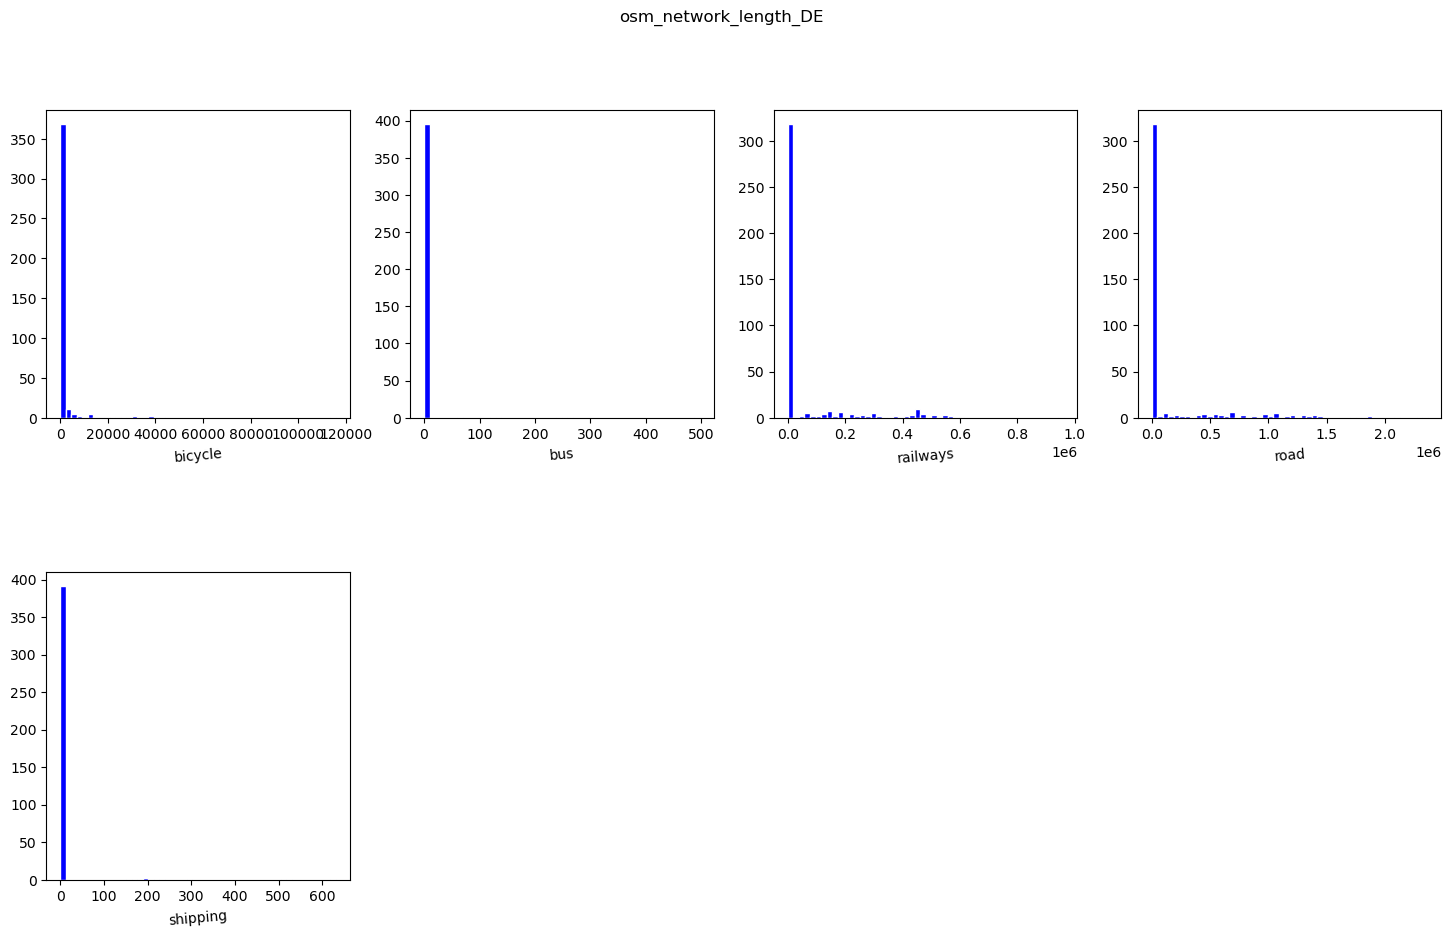

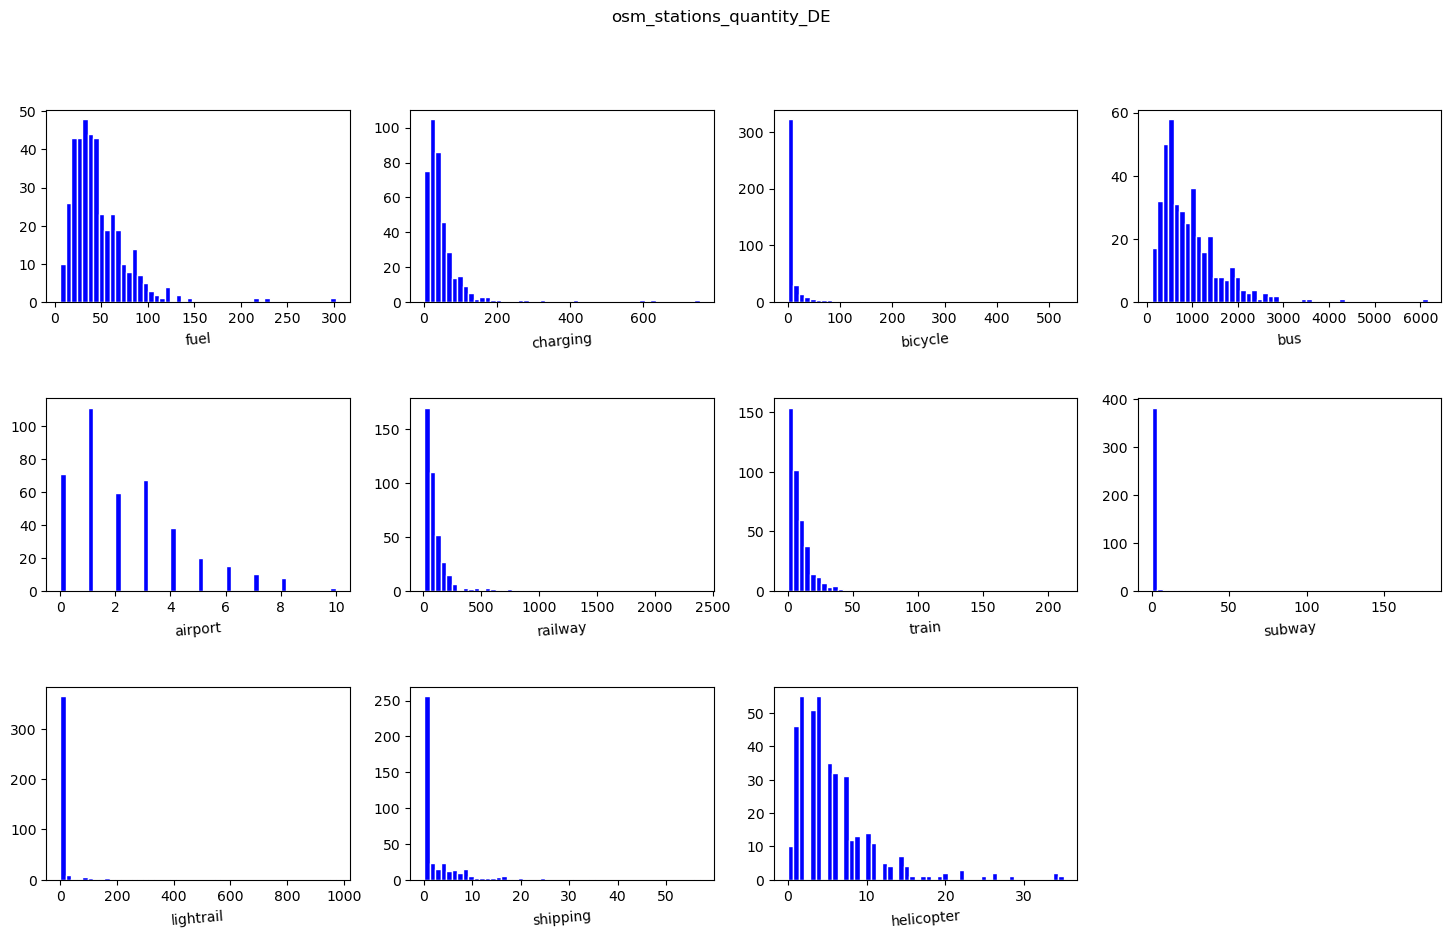

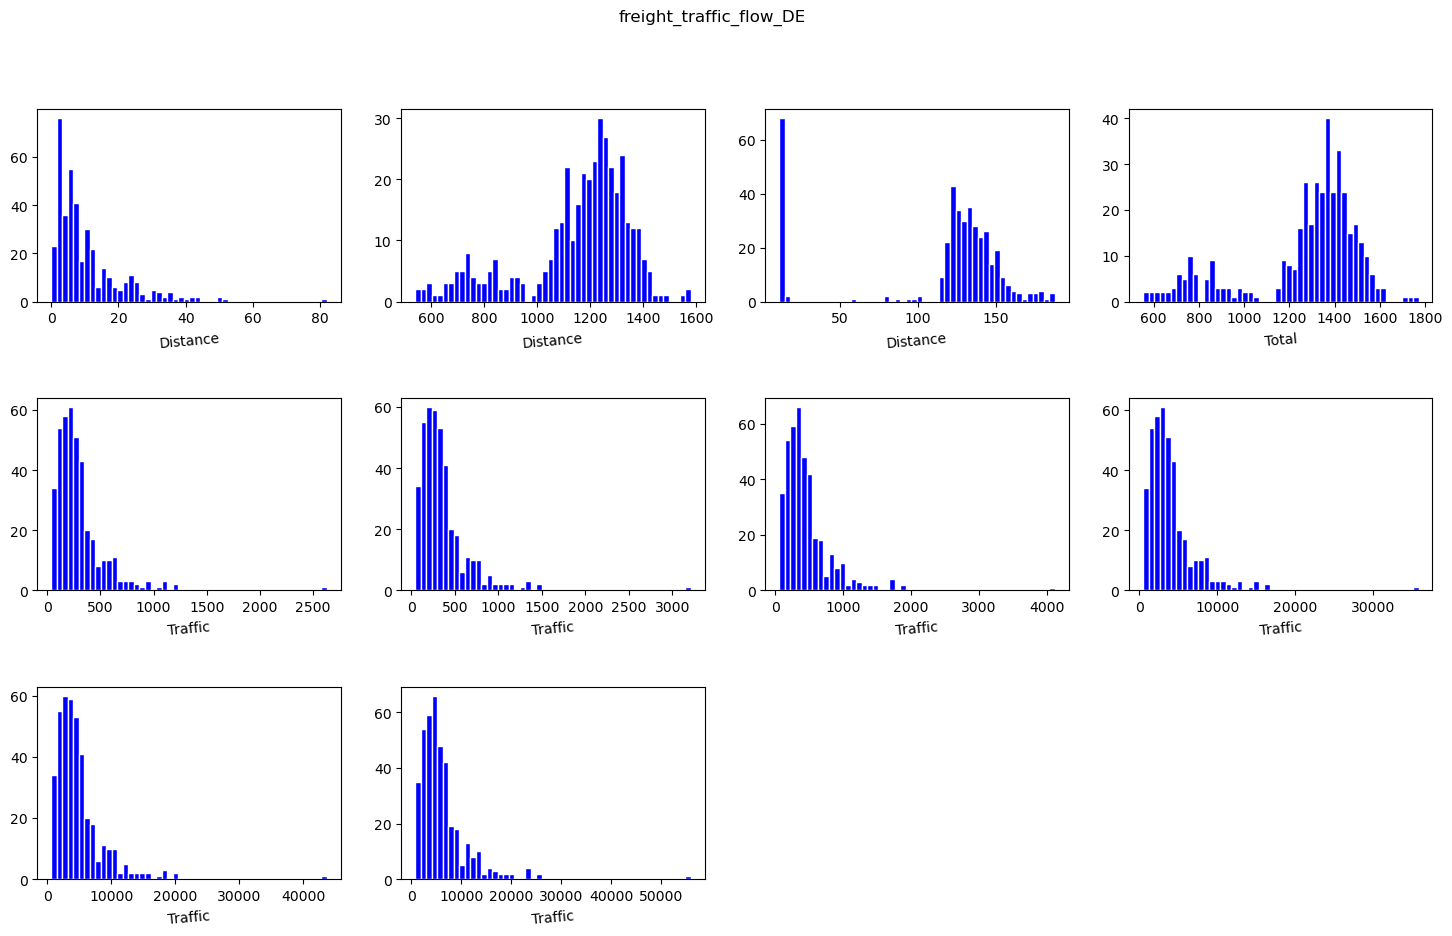

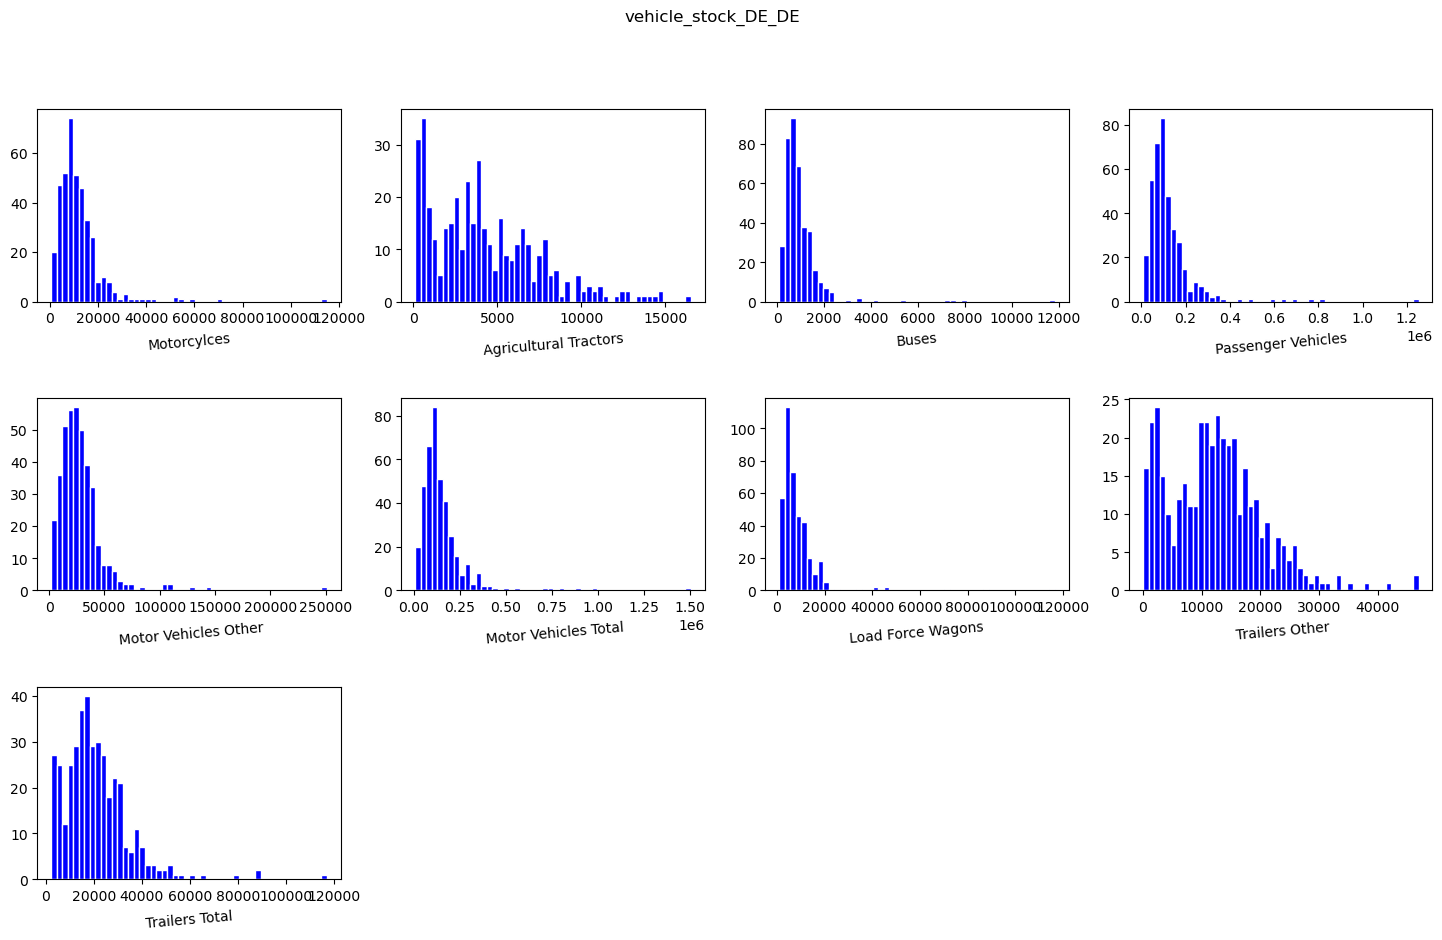

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\matplotlib\axes\_axes.py:6709: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\matplotlib\axes\_axes.py:6710: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


Skipping column 'number of busses_PL_value' because of 'ValueError: autodetected range of [nan, nan] is not finite'
Skipping column 'number of lorries_PL_value' because of 'ValueError: autodetected range of [nan, nan] is not finite'
Skipping column 'number of mopeds_PL_value' because of 'ValueError: autodetected range of [nan, nan] is not finite'
Skipping column 'number of motorcycles_PL_value' because of 'ValueError: autodetected range of [nan, nan] is not finite'
Skipping column 'number of passenger cars_PL_value' because of 'ValueError: autodetected range of [nan, nan] is not finite'
Skipping column 'number of residential buildings_PL_value' because of 'ValueError: autodetected range of [nan, nan] is not finite'
Skipping column 'number of road tractors_PL_value' because of 'ValueError: autodetected range of [nan, nan] is not finite'


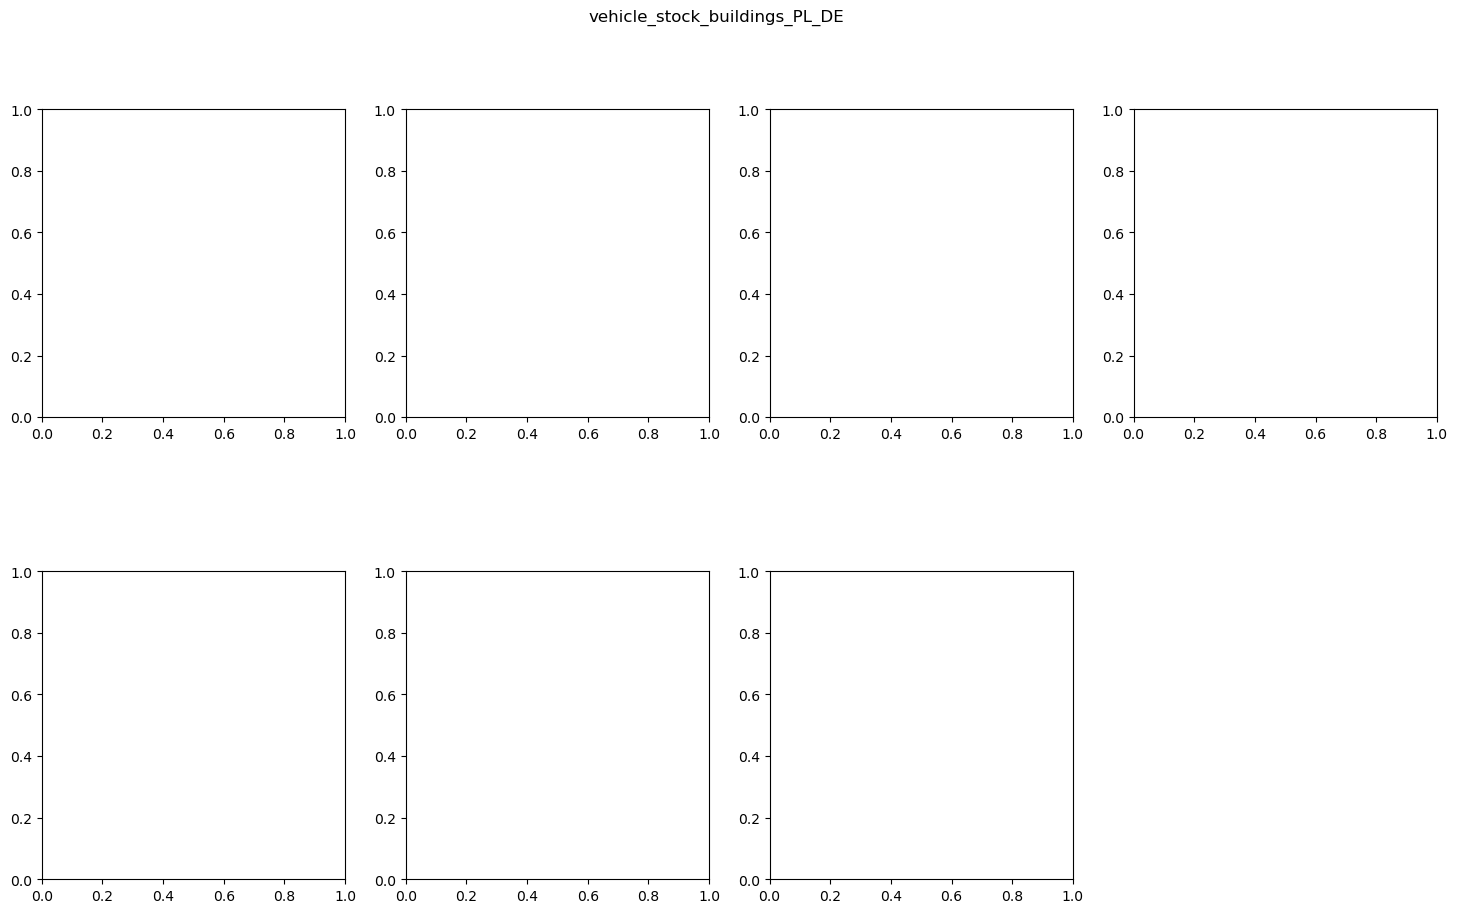

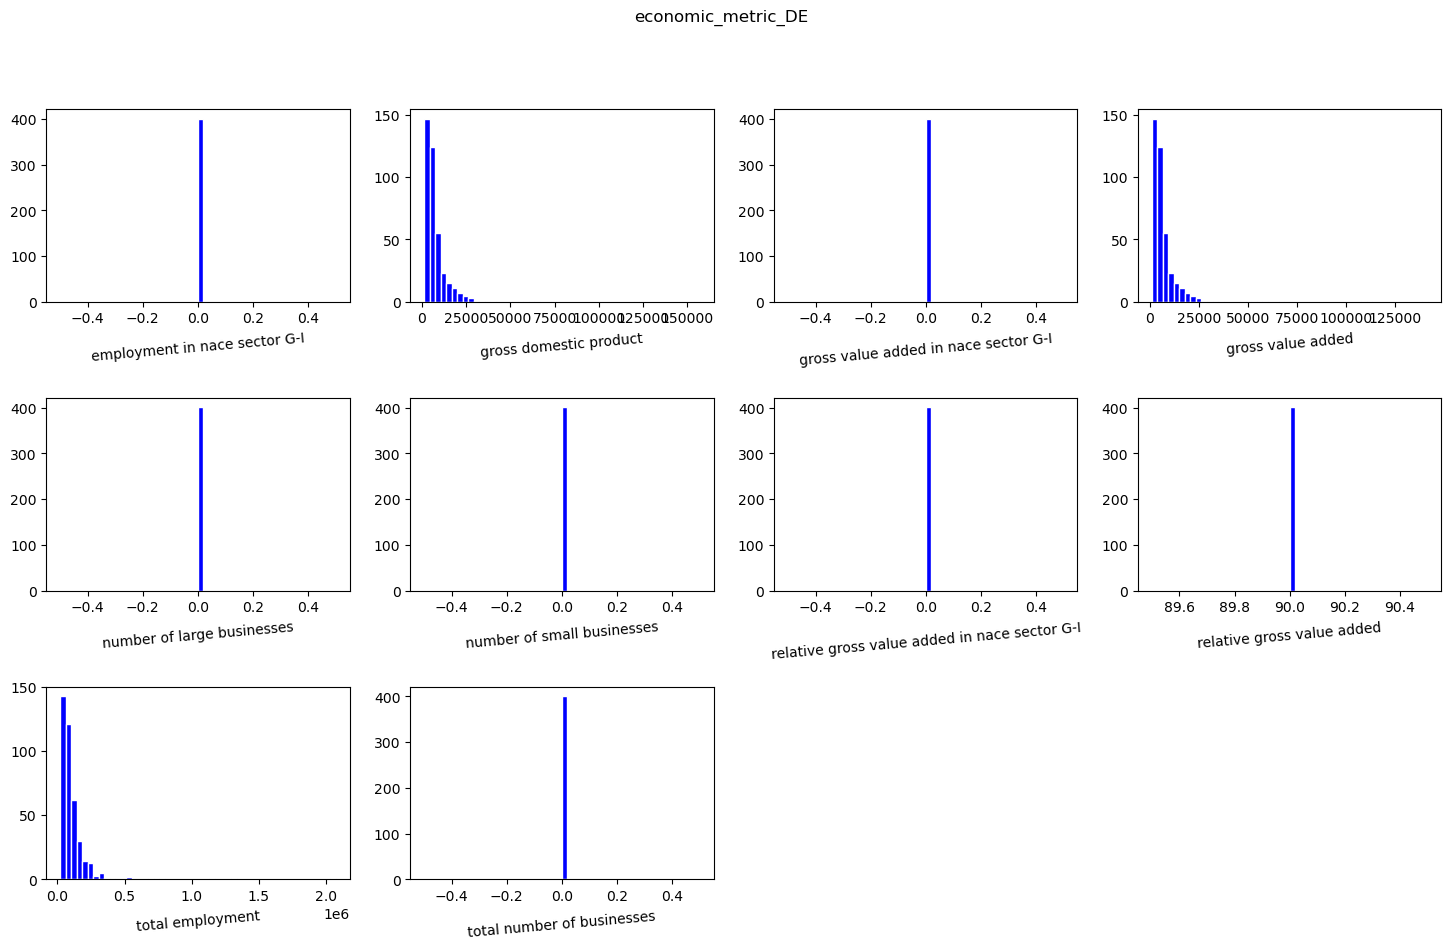

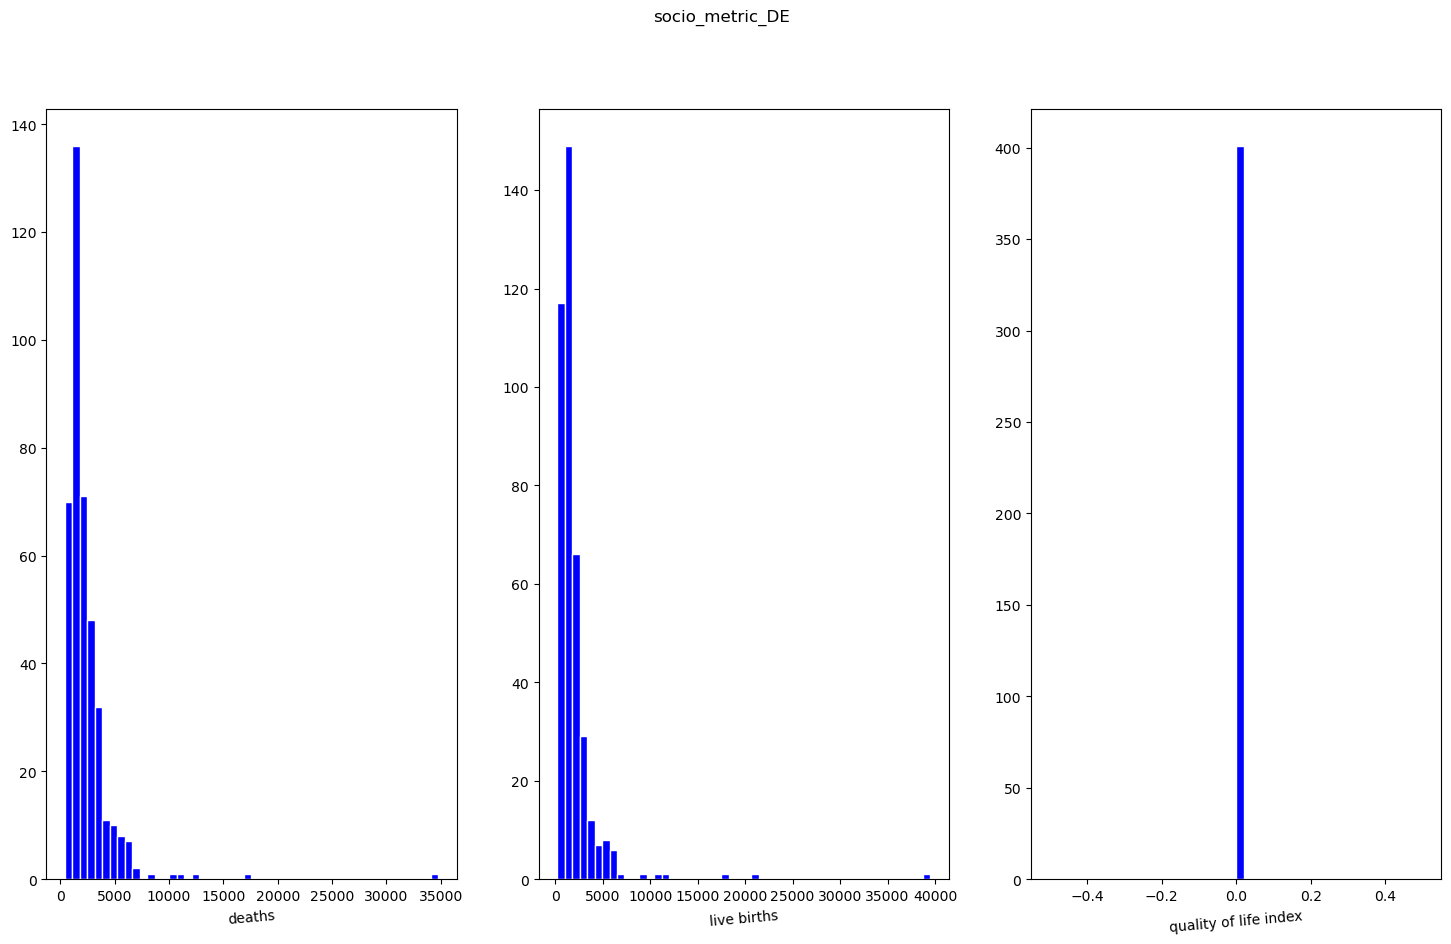

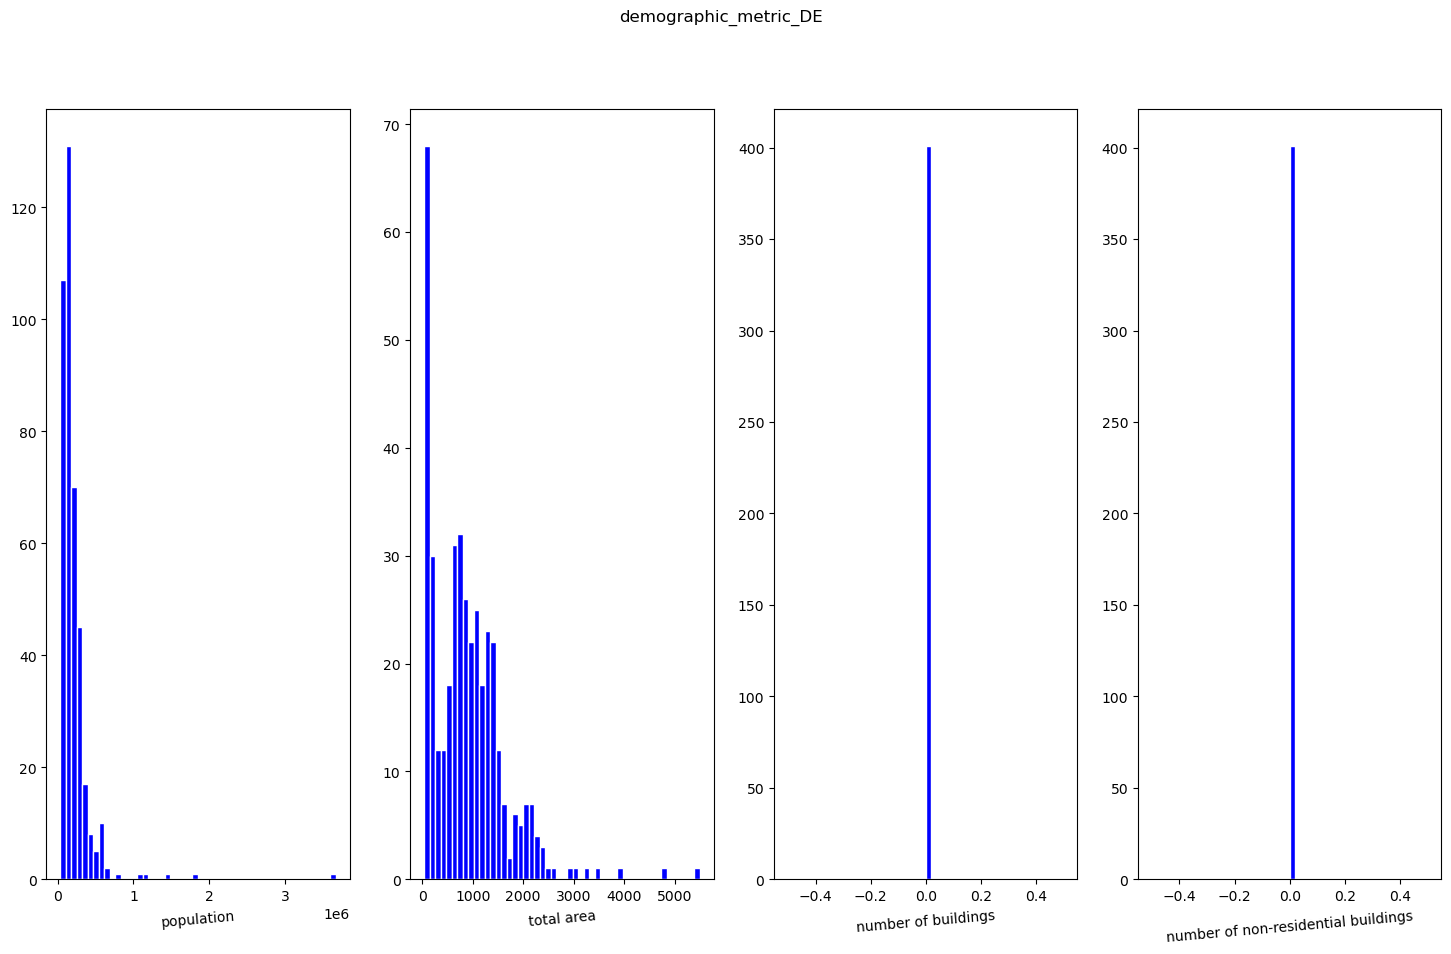

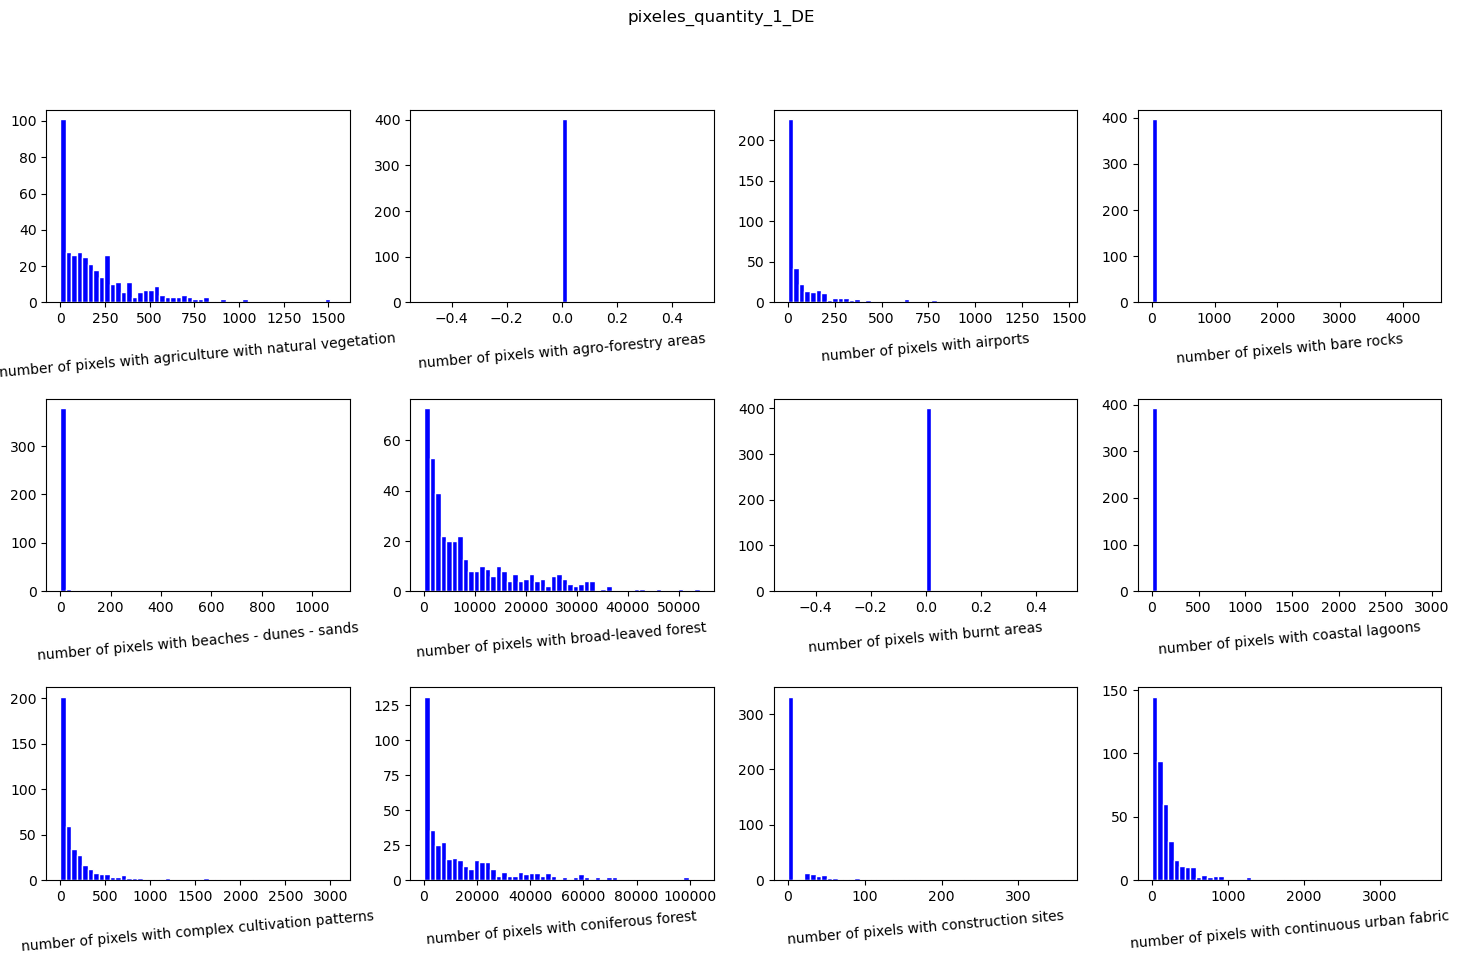

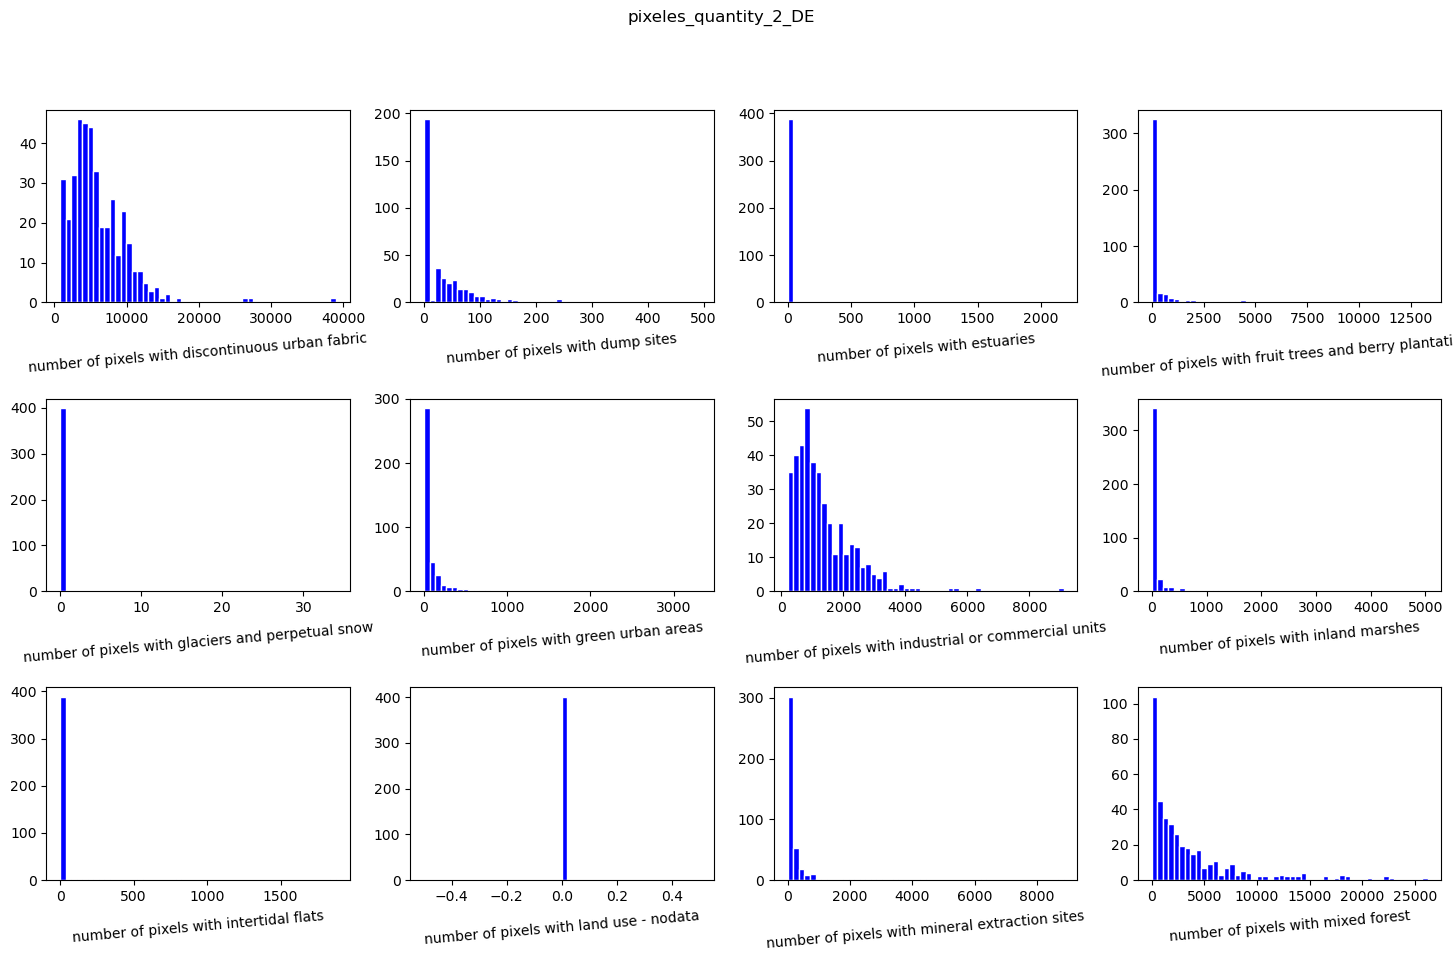

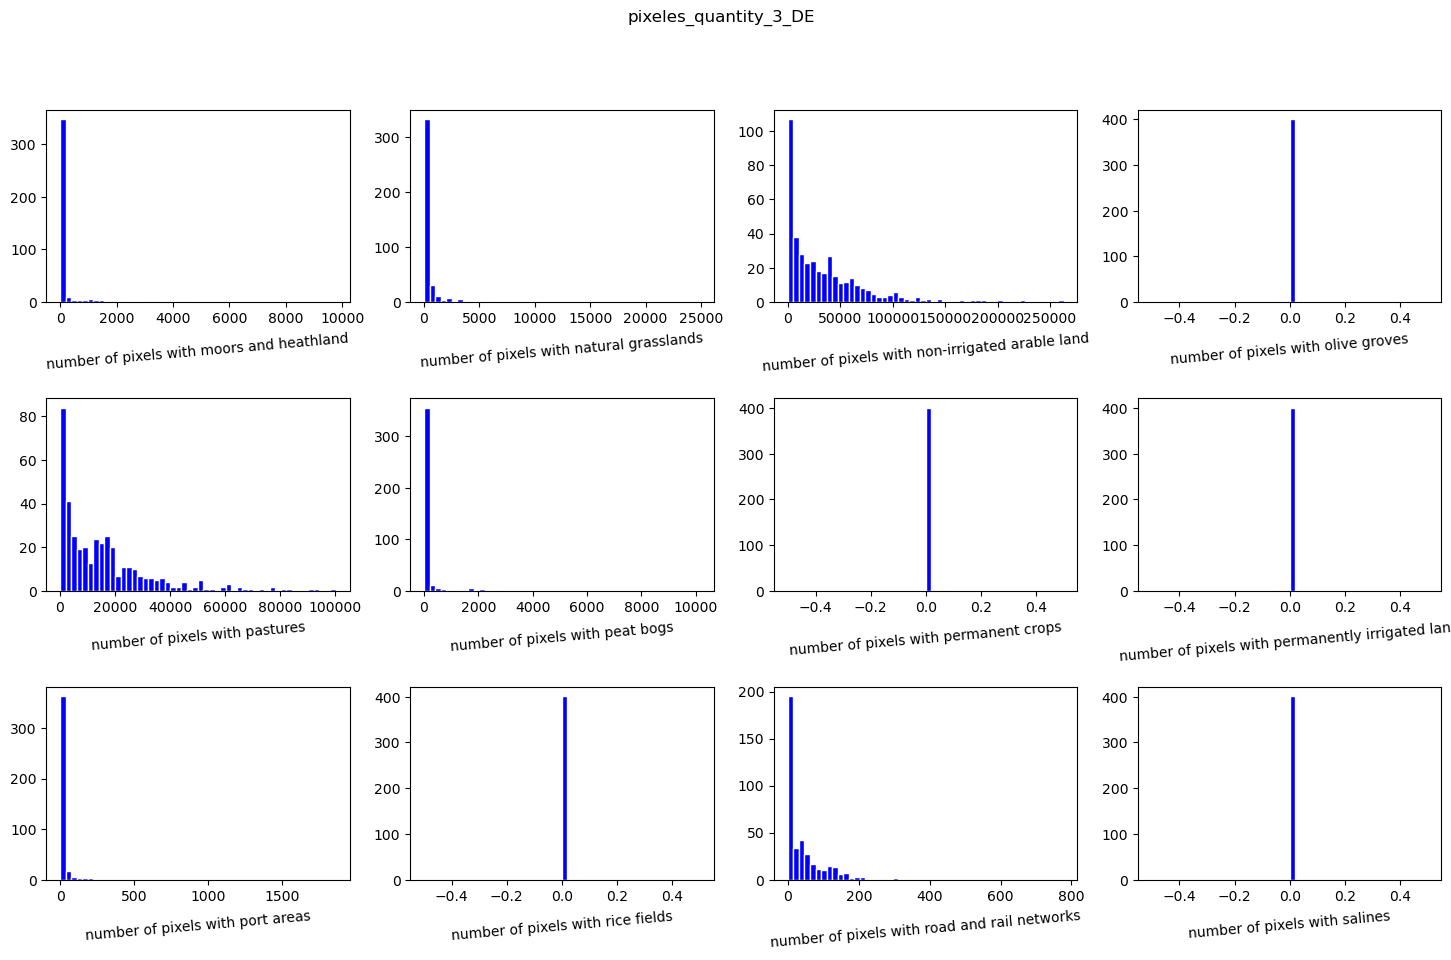

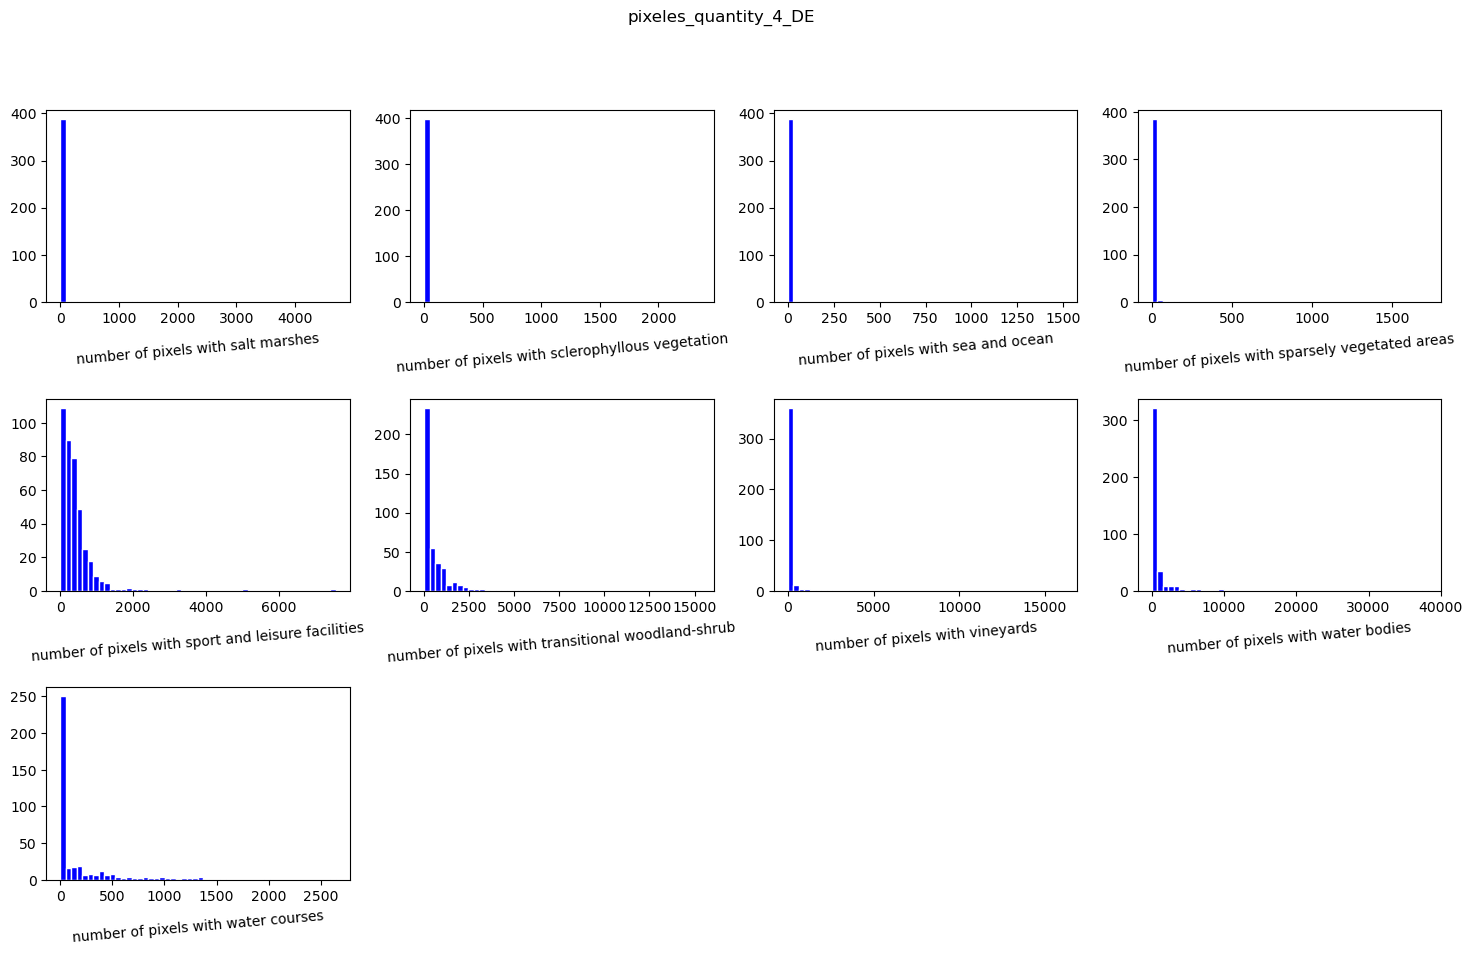

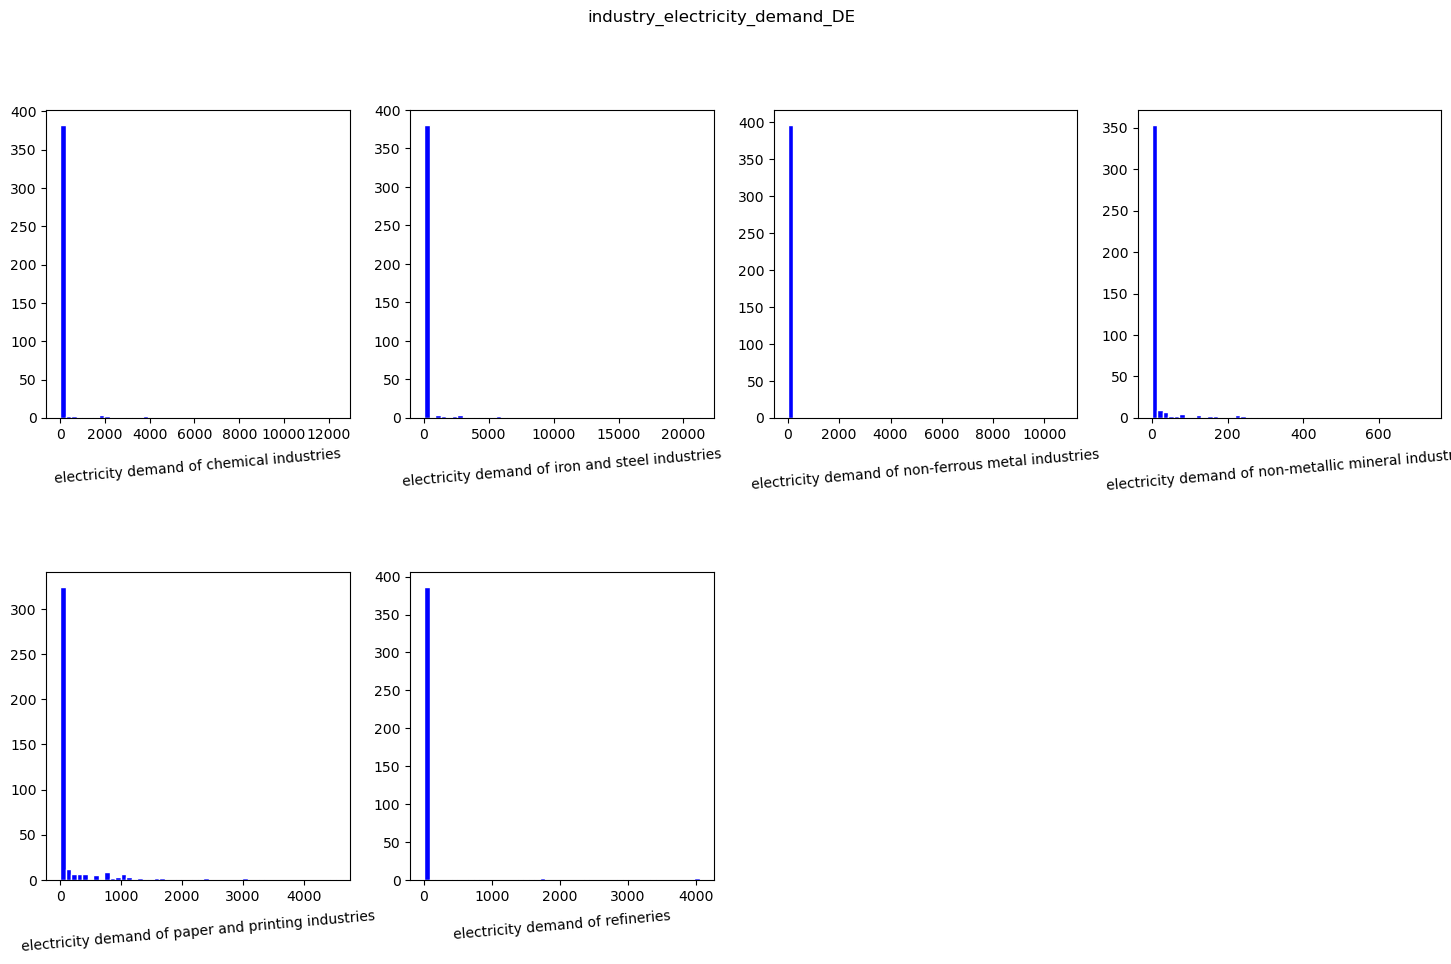

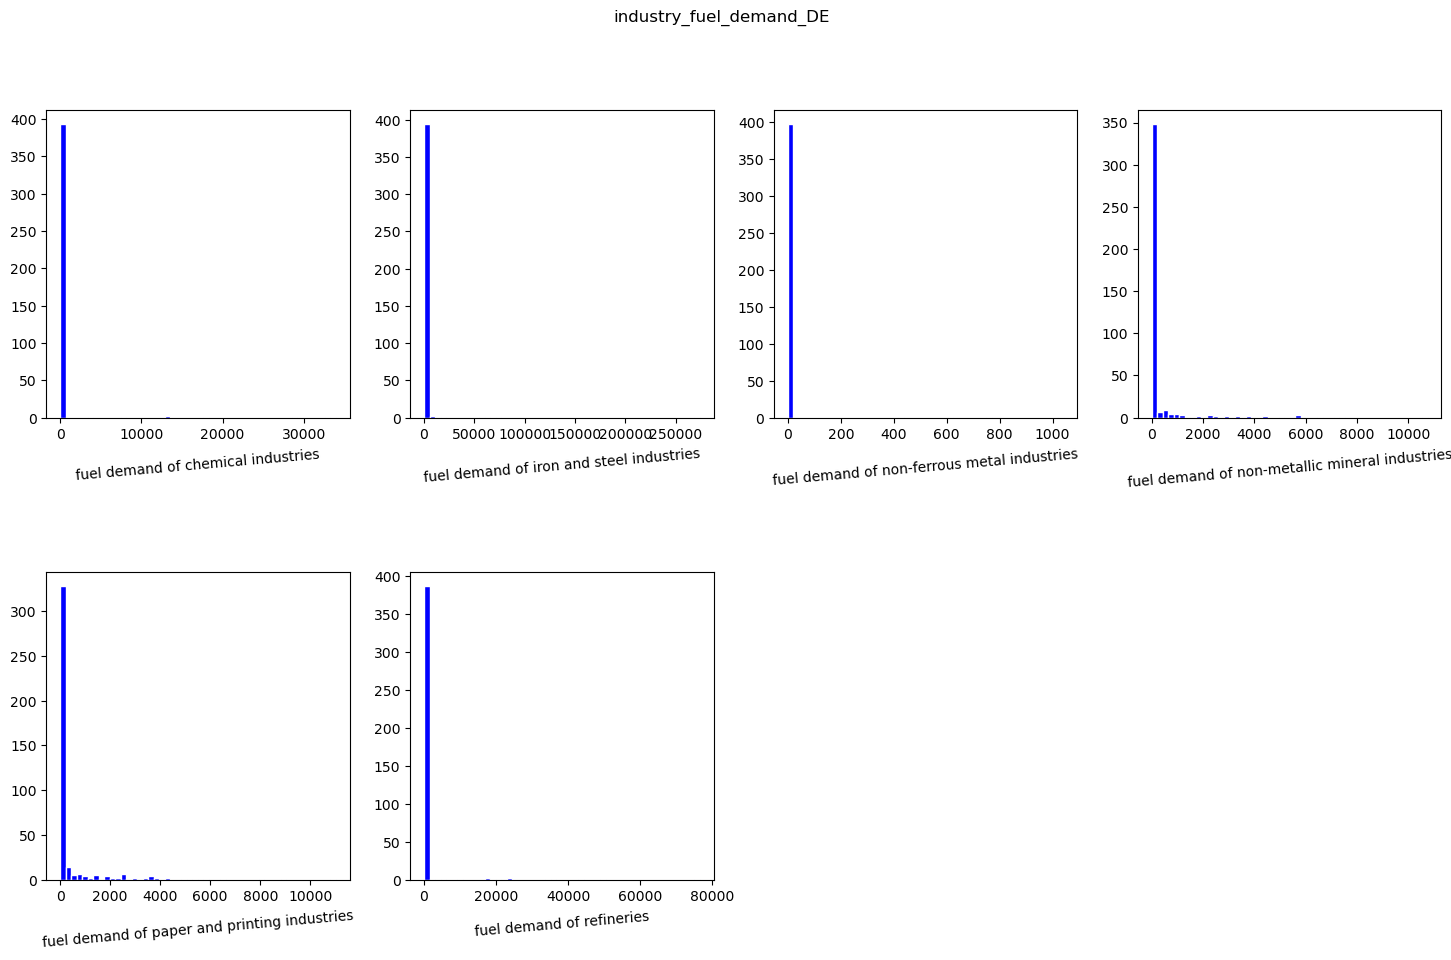

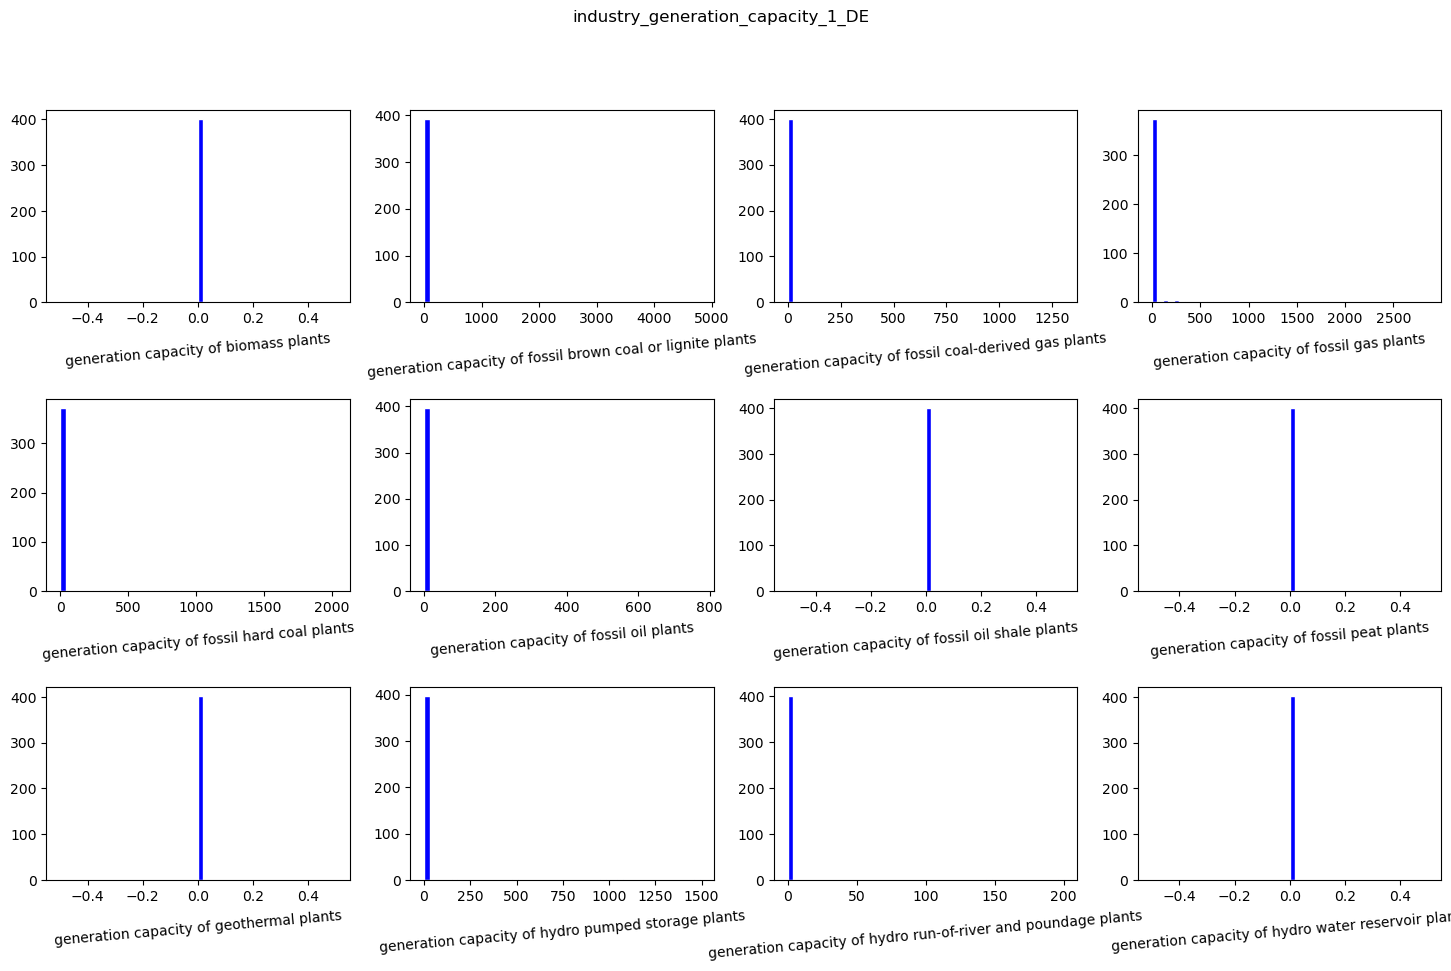

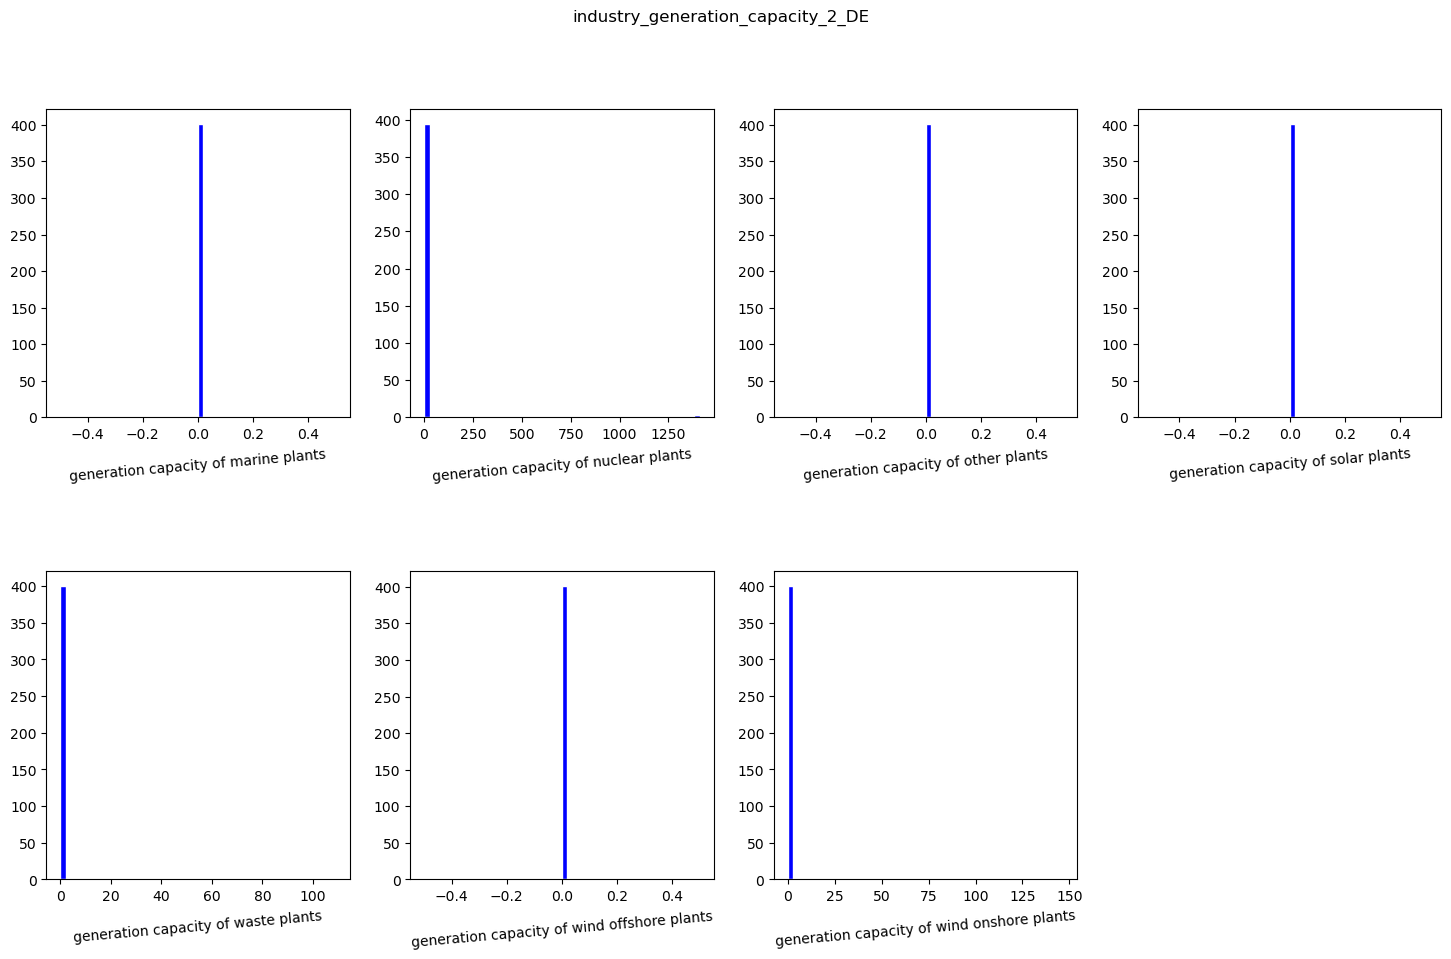

Skipping column 'number of busses_PL_value' because of 'ValueError: autodetected range of [nan, nan] is not finite'


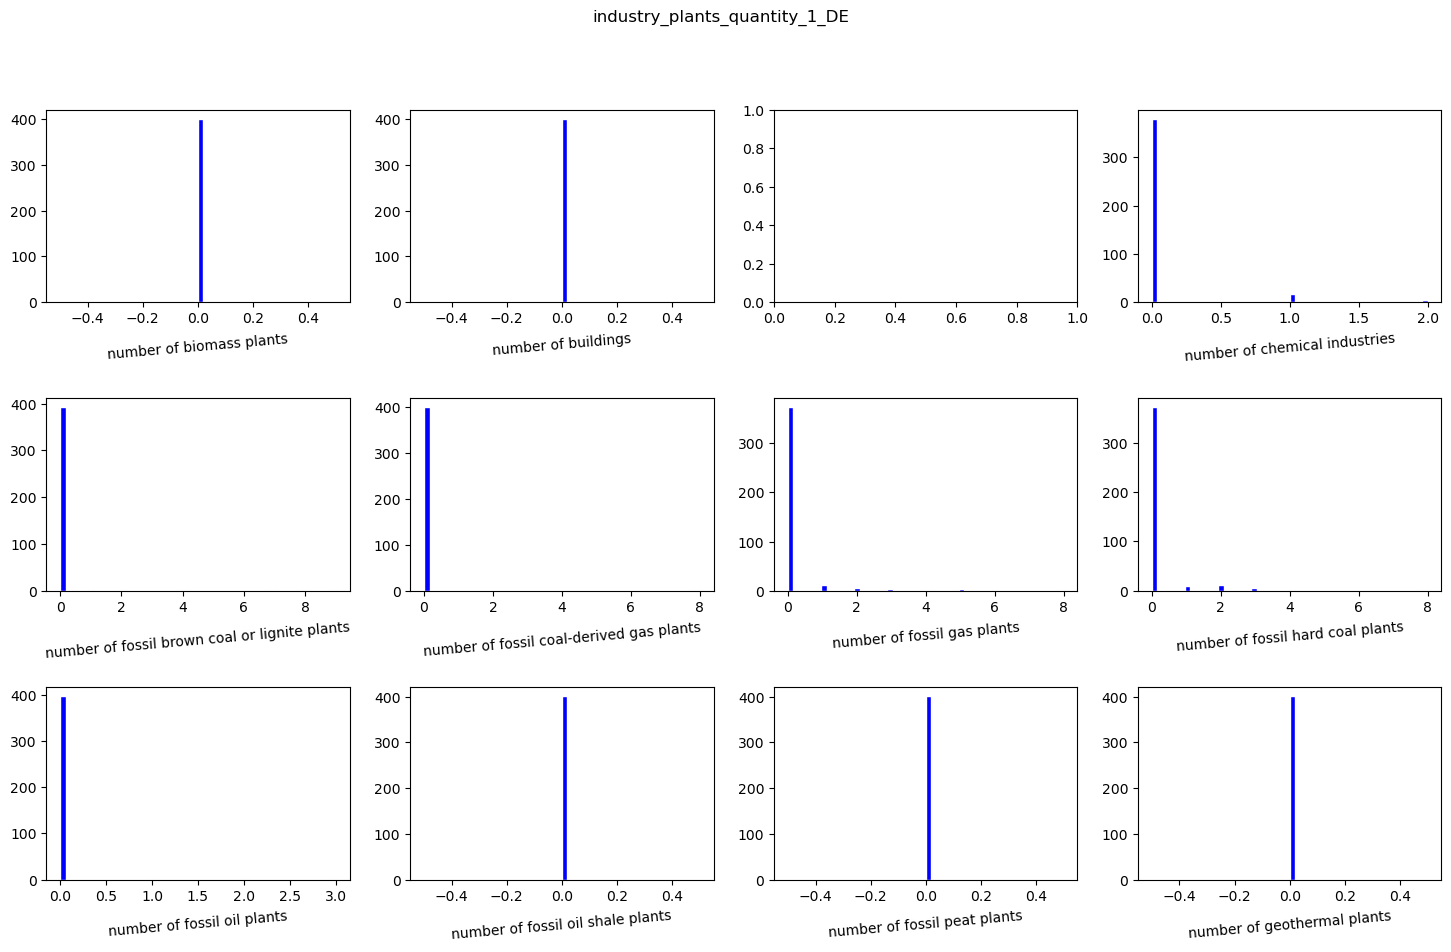

Skipping column 'number of lorries_PL_value' because of 'ValueError: autodetected range of [nan, nan] is not finite'


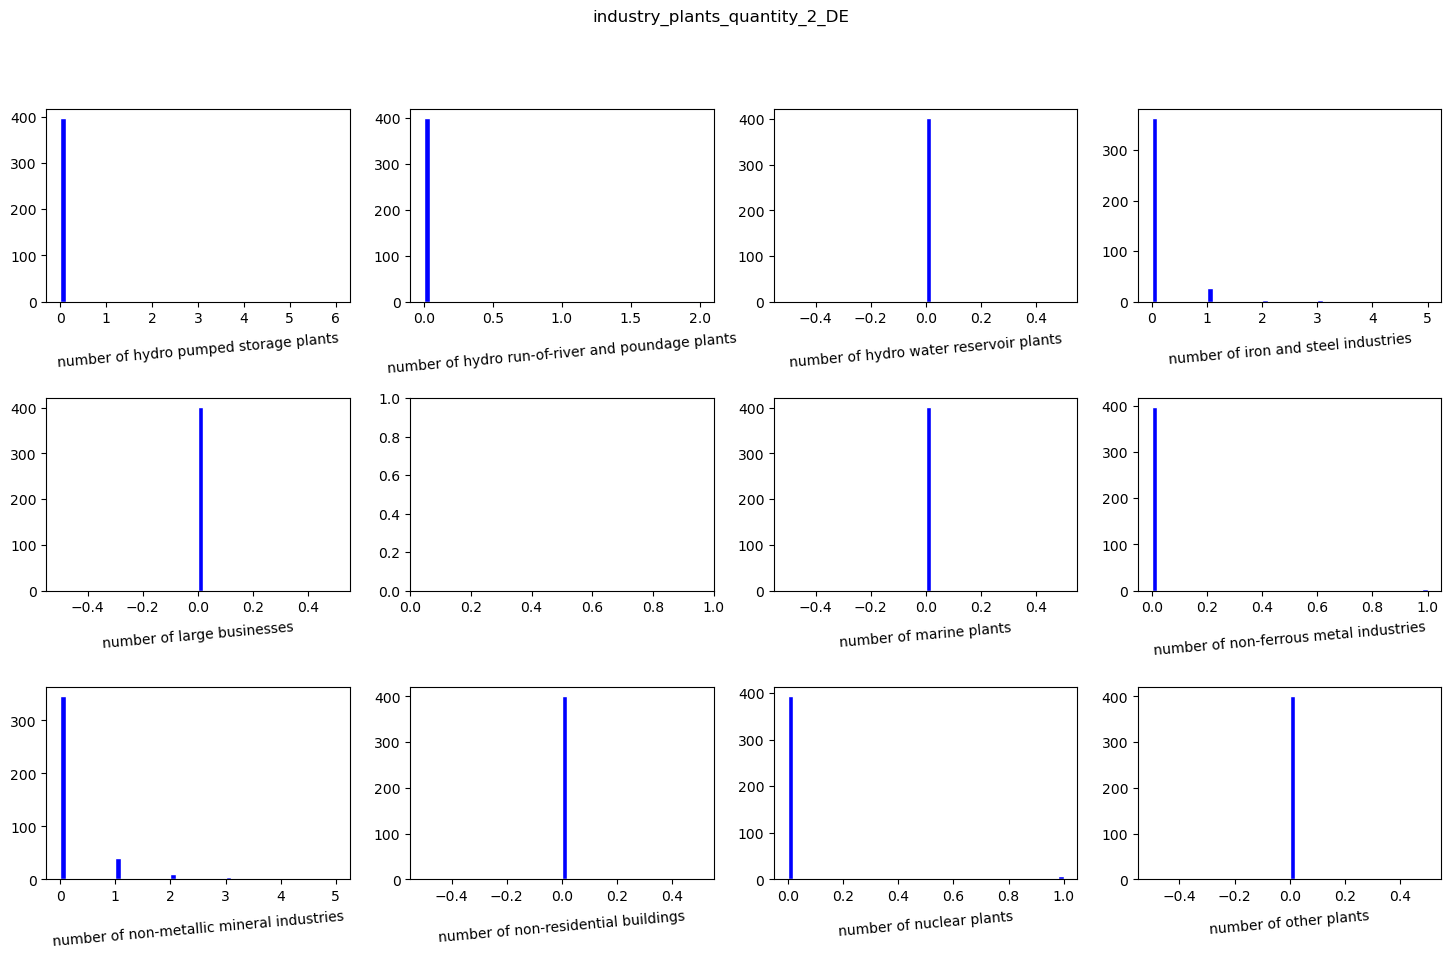

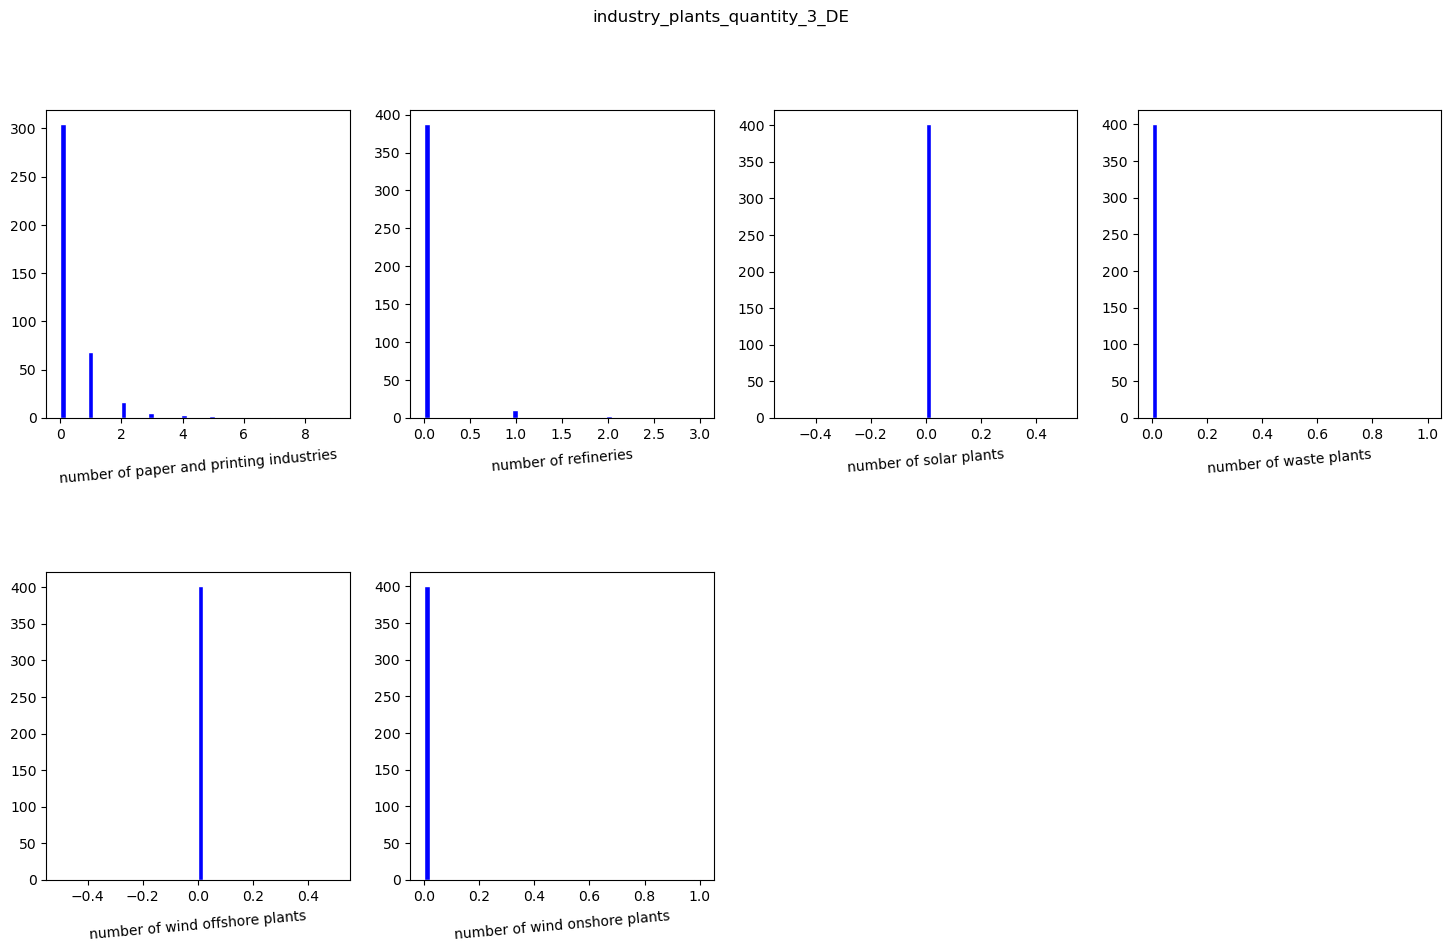

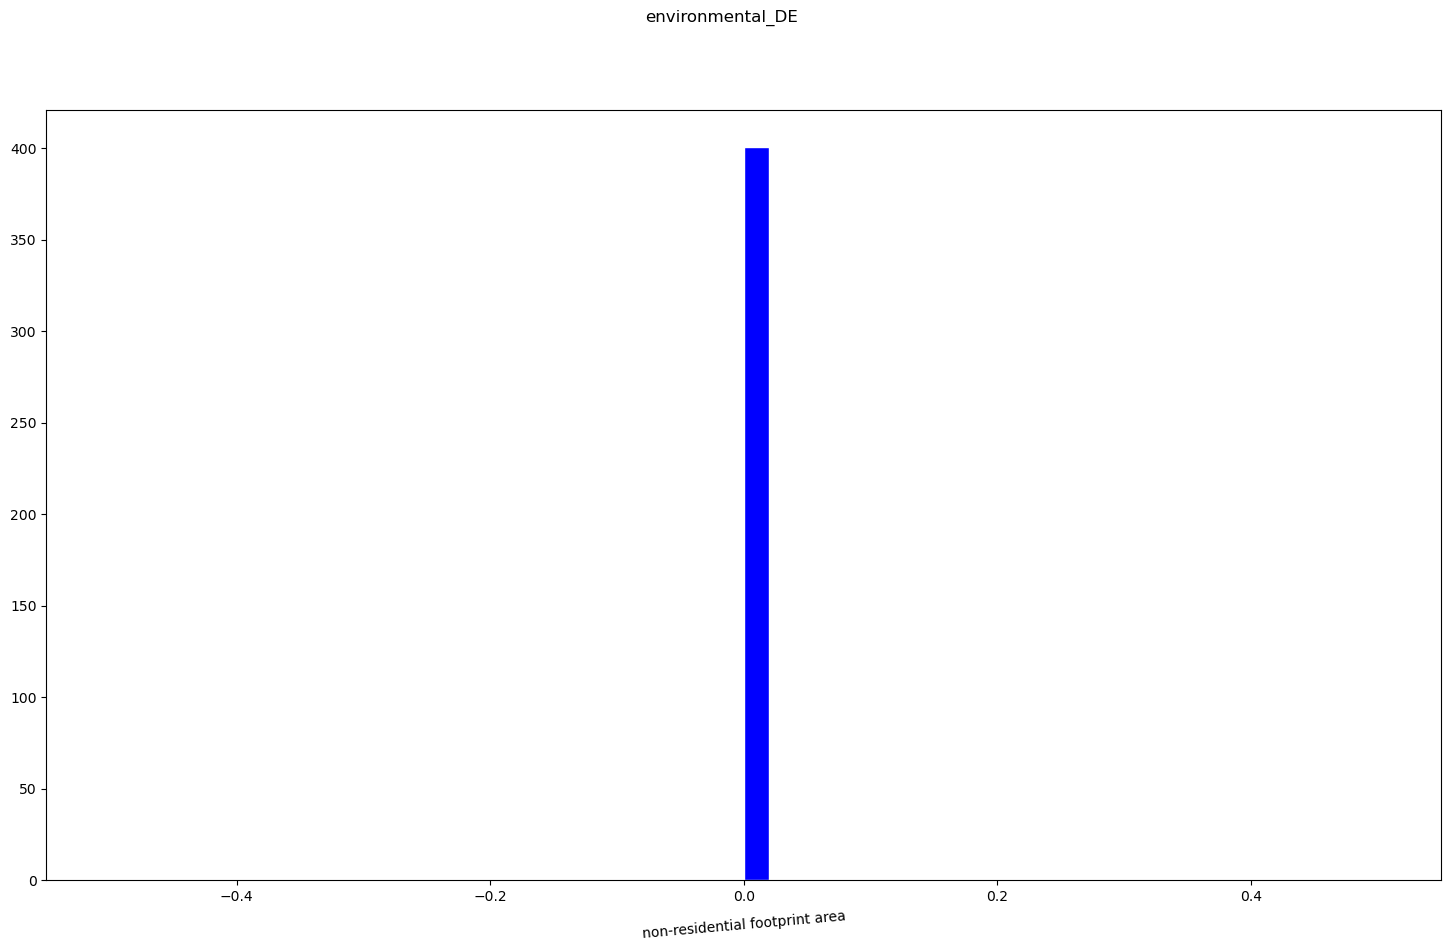

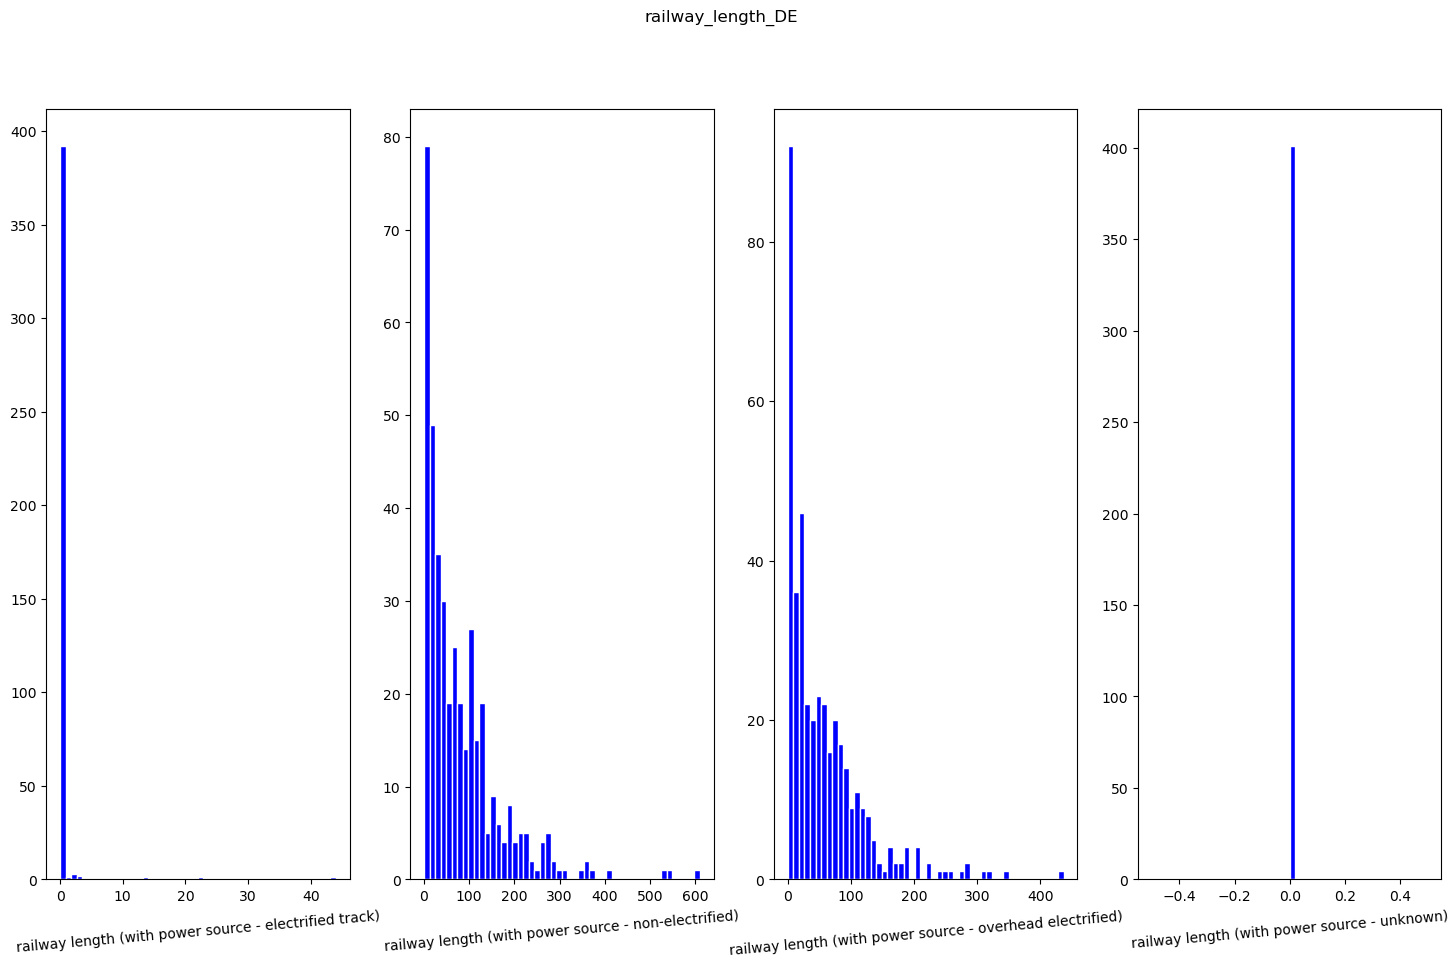

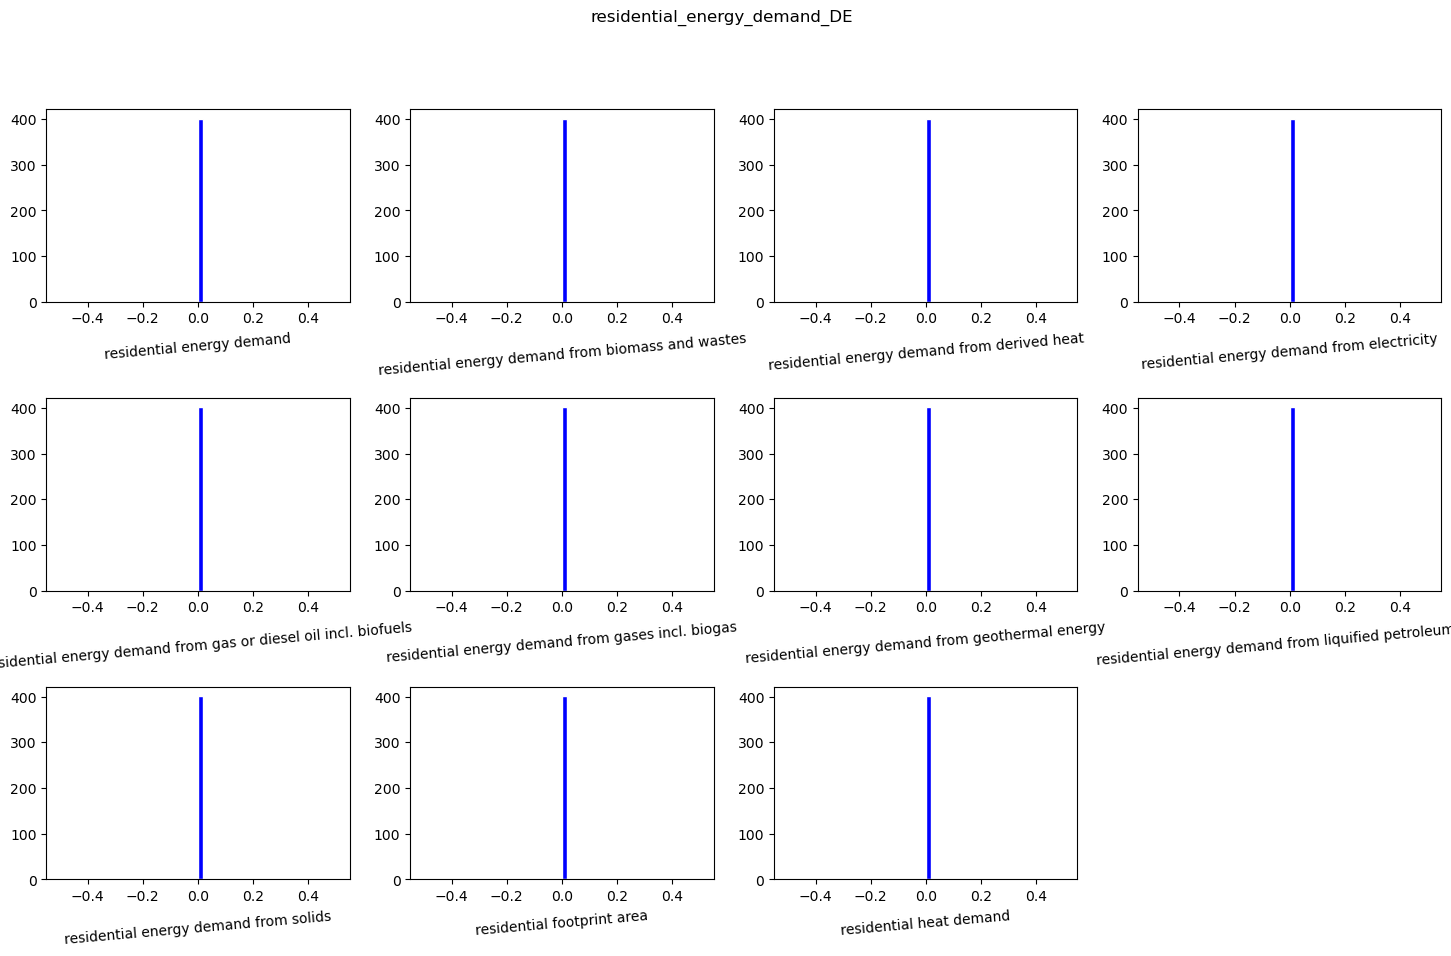

In [188]:
plot_column_histograms(data_region_raw, data_col_dic_hist, region, fig_size=(18, 10))

### CHeck Nan - Uniqueness - Distributions
        It is always a good exercise to look into the data visually and try to see the

        1) Features with NaN values
        2) Uniqueness of the dataset
        3) Distributions of the features

        NonNumerical values Identification:
        
        - Some ML algorithms can not handle non-numerical values (NaN: not a number) so it may be needed to identify the data type for each feature and modify it if necessary. It is also quite common that different feature values are missing for different instances / examples it may be needed to decide what to do: (i) omit the instance; (ii) replace them with the mean / median / mode of the feature; (iv) substitute them with a value of specific choice.

        The following line counts the NaNs for each feature for us:





In [189]:
data_region_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Columns: 182 entries, EU_region_code to Trailers Total
dtypes: float64(57), int64(120), object(5)
memory usage: 570.3+ KB


#### Nan and fill

Drop columns with more than 100 Nan values and replace the remaining Nan values with the mean of each column

In [190]:
def check_nan_values_in_integers_columns_and_replace_nan_with_mean(df):
    num_numeric_cols = 0
    num_dropped_cols = 0
    
    for col in df.columns:
        if df[col].dtype == 'float64' or df[col].dtype == 'int64' or df[col].dtype =='int32':
            num_numeric_cols += 1
            num_nans = df[col].isnull().sum()
            
            if num_nans > 0:
                print("The number of rows with NaN values in column", col, "is", num_nans)
                mean_val = df[col].mean()
                df[col] = df[col].fillna(mean_val)
                
                if num_nans > 100:
                    df.drop(col, axis=1, inplace=True)
                    num_dropped_cols += 1
                    print(f"Dropped column '{col}' due to more than 100 missing values.")
            else:
                print('The number of rows with NaN values in column', col, 'is', 0)
        else:
            print(f"Skipping non-numeric column '{col}'")
    
    percentage_dropped_cols = (num_dropped_cols / num_numeric_cols) * 100 if num_numeric_cols != 0 else 0
    
    print(f"\nTotal number of numeric columns: {num_numeric_cols}")
    print(f"Total number of dropped columns: {num_dropped_cols}")
    print(f"Percentage of dropped columns: {percentage_dropped_cols:.2f}%")
    
    return df



In [191]:
def convert_float_to_int(df):
    for column in df.columns:
        if df[column].dtype == 'float64' or df[column].dtype == 'float32':
            df[column] = df[column].astype(int)
    return df

In [192]:
def filter_rows_with_nan_in_string_cols(df):
    """
    Filter rows that contain NaN values in string/object columns of a pandas DataFrame.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to filter.
        
    Returns:
        pandas.DataFrame: The filtered DataFrame containing only unique rows with NaN values in string/object columns.
    """
    string_columns = df.select_dtypes(include=['object']).columns
    filtered_rows = pd.DataFrame()
    for col in string_columns:
        if df[col].isna().any():
            nan_rows = df[df[col].isna()]
            filtered_rows = pd.concat([filtered_rows, nan_rows]).drop_duplicates()
    return filtered_rows


##### EU

In [193]:
data_eu_raw.shape

(1170, 182)

In [194]:
df_eu = check_nan_values_in_integers_columns_and_replace_nan_with_mean(data_eu_raw)

Skipping non-numeric column 'EU_region_code'
Skipping non-numeric column 'NUTS0_region_code'
Skipping non-numeric column 'NUTS1_region_code'
Skipping non-numeric column 'NUTS2_region_code'
Skipping non-numeric column 'NUTS3_region_code'
The number of rows with NaN values in column deaths_value is 15
The number of rows with NaN values in column electricity demand of chemical industries_value is 0
The number of rows with NaN values in column electricity demand of iron and steel industries_value is 0
The number of rows with NaN values in column electricity demand of non-ferrous metal industries_value is 0
The number of rows with NaN values in column electricity demand of non-metallic mineral industries_value is 0
The number of rows with NaN values in column electricity demand of paper and printing industries_value is 0
The number of rows with NaN values in column electricity demand of refineries_value is 0
The number of rows with NaN values in column employment in nace sector G-I_value is

In [195]:
df_eu = convert_float_to_int(df_eu)

In [196]:
df_eu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Columns: 166 entries, EU_region_code to total number of businesses_value
dtypes: int32(41), int64(120), object(5)
memory usage: 1.3+ MB


In [197]:
filter_rows_with_nan_in_string_cols(df_eu)

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
591            NaN               NaN               NaN               NaN   

    NUTS3_region_code  deaths_value  \
591             ELZZZ          3996   

     electricity demand of chemical industries_value  \
591                                                0   

     electricity demand of iron and steel industries_value  \
591                                                      0   

     electricity demand of non-ferrous metal industries_value  \
591                                                         0   

     electricity demand of non-metallic mineral industries_value  \
591                                                            0   

     electricity demand of paper and printing industries_value  \
591                                                          0   

     electricity demand of refineries_value  \
591                                       0   

     employment in nace sector G-I_value  \
591                                28821   

     Distance_from_origin_region_to_E_road  Distance_within_E_road  \
591                                     23                    1394   

     Distance_from_E_road_to_destination_region  Total_distance  \
591                                         105            1523   

     Traffic_flow_trucks_2010  Traffic_flow_trucks_2019  \
591                       425                       472   

     Traffic_flow_trucks_2030  Traffic_flow_tons_2010  Traffic_flow_tons_2019  \
591                       562                    5791                    6430   

     Traffic_flow_tons_2030  fuel demand of chemical industries_value  \
591                    7656                                         0   

     fuel demand of iron and steel industries_value  \
591                                               0   

     fuel demand of non-ferrous metal industries_value  \
591                                                  0   

     fuel demand of non-metallic mineral industries_value  \
591                                                     0   

     fuel demand of paper and printing industries_value  \
591                                                   0   

     fuel demand of refineries_value  \
591                                0   

     generation capacity of biomass plants_value  \
591                                            0   

     generation capacity of fossil brown coal or lignite plants_value  \
591                                                                 0   

     generation capacity of fossil coal-derived gas plants_value  \
591                                                            0   

     generation capacity of fossil gas plants_value  \
591                                               0   

     generation capacity of fossil hard coal plants_value  \
591                                                     0   

     generation capacity of fossil oil plants_value  \
591                                               0   

     generation capacity of fossil oil shale plants_value  \
591                                                     0   

     generation capacity of fossil peat plants_value  \
591                                                0   

     generation capacity of geothermal plants_value  \
591                                               0   

     generation capacity of hydro pumped storage plants_value  \
591                                                         0   

     generation capacity of hydro run-of-river and poundage plants_value  \
591                                                                    0   

     generation capacity of hydro water reservoir plants_value  \
591                                                          0   

     generation capacity of marine plants_value  \
591                                           0   

     generation capacity of nuclear plants_value  \
591                                     

In [198]:
df_eu['EU_region_code'] = df_eu['EU_region_code'].fillna('EU')
df_eu['NUTS0_region_code'] = df_eu['NUTS0_region_code'].fillna('EL')
df_eu['NUTS1_region_code'] = df_eu['NUTS1_region_code'].fillna('EL')
df_eu['NUTS2_region_code'] = df_eu['NUTS2_region_code'].fillna('EL')


In [199]:
filter_rows_with_nan_in_string_cols(df_eu)

Empty DataFrame
Columns: []
Index: []

In [200]:
df_eu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Columns: 166 entries, EU_region_code to total number of businesses_value
dtypes: int32(41), int64(120), object(5)
memory usage: 1.3+ MB


##### Country

In [201]:
data_region_raw.shape

(401, 182)

In [202]:
df_country = check_nan_values_in_integers_columns_and_replace_nan_with_mean(data_region_raw)

Skipping non-numeric column 'EU_region_code'
Skipping non-numeric column 'NUTS0_region_code'
Skipping non-numeric column 'NUTS1_region_code'
Skipping non-numeric column 'NUTS2_region_code'
Skipping non-numeric column 'NUTS3_region_code'
The number of rows with NaN values in column deaths_value is 0
The number of rows with NaN values in column electricity demand of chemical industries_value is 0
The number of rows with NaN values in column electricity demand of iron and steel industries_value is 0
The number of rows with NaN values in column electricity demand of non-ferrous metal industries_value is 0
The number of rows with NaN values in column electricity demand of non-metallic mineral industries_value is 0
The number of rows with NaN values in column electricity demand of paper and printing industries_value is 0
The number of rows with NaN values in column electricity demand of refineries_value is 0
The number of rows with NaN values in column employment in nace sector G-I_value is 

In [203]:
df_country = convert_float_to_int(df_country)

In [204]:
# df_country.info()

In [205]:
filter_rows_with_nan_in_string_cols(df_country)

Empty DataFrame
Columns: []
Index: []

Uniqueness of Data

In [206]:
distinctCounter = df_eu.apply(lambda x: len(x.unique()))
print('The number of unique not repeated values at different instances for "data_eu" are: ')
print(distinctCounter)

The number of unique not repeated values at different instances for "data_eu" are: 
EU_region_code                                                              1
NUTS0_region_code                                                          27
NUTS1_region_code                                                          93
NUTS2_region_code                                                         241
NUTS3_region_code                                                        1170
deaths_value                                                             1074
electricity demand of chemical industries_value                            67
electricity demand of iron and steel industries_value                     162
electricity demand of non-ferrous metal industries_value                   16
electricity demand of non-metallic mineral industries_value               171
electricity demand of paper and printing industries_value                 313
electricity demand of refineries_value                    

In [207]:
distinctCounter = df_eu.apply(lambda x: x.nunique())
print('The number of unique not repeated values at different instances for "data_eu" are: ')
print(distinctCounter)


The number of unique not repeated values at different instances for "data_eu" are: 
EU_region_code                                                              1
NUTS0_region_code                                                          27
NUTS1_region_code                                                          93
NUTS2_region_code                                                         241
NUTS3_region_code                                                        1170
deaths_value                                                             1074
electricity demand of chemical industries_value                            67
electricity demand of iron and steel industries_value                     162
electricity demand of non-ferrous metal industries_value                   16
electricity demand of non-metallic mineral industries_value               171
electricity demand of paper and printing industries_value                 313
electricity demand of refineries_value                    

In [208]:
def calculate_nonunique_features(df):
    """
    Calculates the number and percentage of features that do not achieve a uniqueness of 10% of its values
    """
    num_features = len(df.columns[5:])
    nonunique_features = 0

    for col in df.columns[5:]:
        if df[col].nunique() / len(df) < 0.1:
            nonunique_features += 1

    nonunique_pct = nonunique_features / num_features * 100

    print(f"Number of features: {num_features}")
    print(f"Number of nonunique features: {nonunique_features}")
    print(f"Percentage of nonunique features, features that have at least 90 % the same value: {nonunique_pct:.2f}%")


In [209]:
calculate_nonunique_features(df_eu)

Number of features: 161
Number of nonunique features: 83
Percentage of nonunique features, features that have at least 90 % the same value: 51.55%


In [210]:
df_eu.shape

(1170, 166)

In [211]:
distinctCounter_1 = df_country.apply(lambda x: len(x.unique()))
print('The number of unique not repeated values at different instances for "data_DE" are: ')
print(distinctCounter_1)

The number of unique not repeated values at different instances for "data_DE" are: 
EU_region_code                                                             1
NUTS0_region_code                                                          1
NUTS1_region_code                                                         16
NUTS2_region_code                                                         38
NUTS3_region_code                                                        401
deaths_value                                                             377
electricity demand of chemical industries_value                           18
electricity demand of iron and steel industries_value                     30
electricity demand of non-ferrous metal industries_value                   5
electricity demand of non-metallic mineral industries_value               43
electricity demand of paper and printing industries_value                 88
electricity demand of refineries_value                               

        For more pre-processing options; you may check:

        https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

In [212]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def count_nan_values(df):
    """
    Counts the number of NaN values in each column of a DataFrame.
    """
    nan_counts = df.isna().sum()
    nan_percentages = nan_counts / len(df) * 100
    nan_summary = pd.concat([nan_counts, nan_percentages], axis=1)
    nan_summary = nan_summary.rename(columns={0: 'NaN Count', 1: 'NaN Percentage'})
    nan_summary = nan_summary.sort_values(by='NaN Count', ascending=False)
    print(nan_summary)

In [213]:
count_nan_values(df_eu)

                                                                       NaN Count  \
EU_region_code                                                                 0   
number of pixels with mixed forest_value                                       0   
number of pixels with natural grasslands_value                                 0   
number of pixels with non-irrigated arable land_value                          0   
number of pixels with olive groves_value                                       0   
number of pixels with pastures_value                                           0   
number of pixels with peat bogs_value                                          0   
number of pixels with permanent crops_value                                    0   
number of pixels with permanently irrigated land_value                         0   
number of pixels with port areas_value                                         0   
number of pixels with rice fields_value                                     

### Exclude features with more than 50 % of zero values per country.

#### EU

In [214]:
# def drop_columns_by_zeros(df):
#     """
#     For each row that has the same NUTS0_region_code, count the zeros for each numeric column and
#     drop the column if it has more than 40% of zeros for that numeric column.
#     """
#     # Group by NUTS0_region_code
#     grouped = df.groupby('NUTS0_region_code')
    
#     # Create an empty DataFrame to store the final result
#     df_clean = pd.DataFrame()
    
#     # Iterate over each group
#     for _, group in grouped:
        
#         # Calculate percentage of zeros for each numeric column
#         total_rows = group.shape[0]
#         num_zeros = (group == 0).sum()
#         num_zeros = num_zeros.loc[~num_zeros.index.duplicated()] # Remove duplicates
#         zeros_percentage = num_zeros / total_rows
        
#         # Drop columns with more than 10% of zeros
#         to_drop = zeros_percentage[zeros_percentage > 0.1].index
#         group.drop(to_drop, axis=1, inplace=True)
        
#         # Append the cleaned group to the final result
#         df_clean = pd.concat([df_clean, group])
    
#     return df_clean

In [215]:
def get_zero_percentages(df):
    """
    Calculates the number and percentage of features with specific percentages of zero values
    """
    num_features = len(df.columns[5:])
    zeros_percentage = (df == 0).mean()

    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")

In [216]:
get_zero_percentages(df_eu)

Number of features: 161
Percentage of columns with all zero values: 13.04%
Percentage of columns with at least 95% zero values: 31.68%
Percentage of columns with at least 90% zero values: 37.89%
Percentage of columns with at least 80% zero values: 49.07%
Percentage of columns with at least 70% zero values: 56.52%
Percentage of columns with at least 60% zero values: 60.87%
Percentage of columns with at least 50% zero values: 64.60%


In [217]:
df_eu.shape

(1170, 166)

In [218]:
def remove_high_zero_features(df, threshold=0.8):
    """
    Removes features with a high percentage of zero values and returns the remaining dataframe
    """
    num_features = len(df.columns[5:])
    zeros_percentage = (df == 0).mean()

    # Calculate percentage of features with specific percentages of zero values
    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of initial features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")

    # Remove features with high percentage of zero values
    to_remove = zeros_percentage[zeros_percentage >= threshold].index
    df = df.drop(to_remove, axis=1)
    num_features_after = len(df.columns[5:])

    print(f"Percentage of features removed due to high percentage of zeros: {100 * (1 - num_features_after/num_features):.2f}%")
    print(f"Number of remaining features: {num_features_after}")

    return df


In [219]:
df_eu = remove_high_zero_features(df_eu)

Number of initial features: 161
Percentage of columns with all zero values: 13.04%
Percentage of columns with at least 95% zero values: 31.68%
Percentage of columns with at least 90% zero values: 37.89%
Percentage of columns with at least 80% zero values: 49.07%
Percentage of columns with at least 70% zero values: 56.52%
Percentage of columns with at least 60% zero values: 60.87%
Percentage of columns with at least 50% zero values: 64.60%
Percentage of features removed due to high percentage of zeros: 49.07%
Number of remaining features: 82


In [220]:
df_eu.shape

(1170, 87)

In [221]:
df_eu['relative gross value added_value']

0       89
1       89
2       89
3       89
4       89
5       89
6       89
7       89
8       89
9       89
10      89
11      89
12      89
13      89
14      89
15      89
16      89
17      89
18      89
19      89
20      89
21      89
22      89
23      89
24      89
25      89
26      89
27      89
28      89
29      89
30      89
31      89
32      89
33      89
34      89
35      89
36      89
37      89
38      89
39       0
40       0
41      89
42      89
43      89
44      89
45      89
46      89
47      89
48      89
49      89
50      89
51      89
52      89
53      89
54      89
55      89
56      89
57      89
58      89
59       0
60       0
61      89
62       0
63       0
64       0
65       0
66      89
67      89
68      89
69      89
70      89
71      89
72      89
73      89
74      89
75      89
76      89
77      89
78      89
79      86
80      86
81      86
82      86
83      86
84      86
85      86
86      86
87      86
88      86
89      86
90      86

#### Country

In [222]:
df_country['relative gross value added_value']

0      90
1      90
2      90
3      90
4      90
5      90
6      90
7      90
8      90
9      90
10     90
11     90
12     90
13     90
14     90
15     90
16     90
17     90
18     90
19     90
20     90
21     90
22     90
23     90
24     90
25     90
26     90
27     90
28     90
29     90
30     90
31     90
32     90
33     90
34     90
35     90
36     90
37     90
38     90
39     90
40     90
41     90
42     90
43     90
44     90
45     90
46     90
47     90
48     90
49     90
50     90
51     90
52     90
53     90
54     90
55     90
56     90
57     90
58     90
59     90
60     90
61     90
62     90
63     90
64     90
65     90
66     90
67     90
68     90
69     90
70     90
71     90
72     90
73     90
74     90
75     90
76     90
77     90
78     90
79     90
80     90
81     90
82     90
83     90
84     90
85     90
86     90
87     90
88     90
89     90
90     90
91     90
92     90
93     90
94     90
95     90
96     90
97     90
98     90
99     90


In [223]:
def remove_high_zero_features_country(df, threshold=0.8):
    """
    Removes features with a high percentage of zero values and returns the remaining dataframe
    """
    num_features = len(df.columns)
    zeros_percentage = (df == 0).mean()

    # Calculate percentage of features with specific percentages of zero values
    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of initial features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")

    # Remove features with high percentage of zero values
    to_remove = zeros_percentage[zeros_percentage >= threshold].index
    df = df.drop(to_remove, axis=1)
    num_features_after = len(df.columns)

    print(f"Percentage of features removed due to high percentage of zeros: {100 * (1 - num_features_after/num_features):.2f}%")
    print(f"Number of remaining features: {num_features_after}")

    return df

In [224]:
def drop_columns_by_zeros_country_replace_with_mean(df):
    """
    For each numeric column, count the zeros and drop the column if it has more than 0.5% of zeros.
    Replace the zeros with the mean after dropping the columns.
    """
    # Calculate percentage of zeros for each numeric column
    numeric_cols = df.select_dtypes(include='number').columns
    total_rows = df.shape[0]
    num_zeros = (df[numeric_cols] == 0).sum()
    zeros_percentage = num_zeros / total_rows
    
    # Drop columns with more than 40% of zeros
    to_drop = zeros_percentage[zeros_percentage > 0.4].index
    df.drop(to_drop, axis=1, inplace=True)
    
    # Replace zeros with the mean minus 10% of the mean in remaining columns
    numeric_cols = df.select_dtypes(include='number').columns
    df[numeric_cols] = df[numeric_cols].apply(lambda col: col.replace(0, col.mean()) if col.dtype != 'object' else col)
    
    return df

In [225]:
# df_country = drop_columns_by_zeros_country_replace_with_mean(df_country)

In [226]:
df_country = remove_high_zero_features_country(df_country, threshold=0.2)

Number of initial features: 175
Percentage of columns with all zero values: 28.00%
Percentage of columns with at least 95% zero values: 46.86%
Percentage of columns with at least 90% zero values: 54.29%
Percentage of columns with at least 80% zero values: 58.86%
Percentage of columns with at least 70% zero values: 63.43%
Percentage of columns with at least 60% zero values: 63.43%
Percentage of columns with at least 50% zero values: 65.14%
Percentage of features removed due to high percentage of zeros: 70.86%
Number of remaining features: 51


In [227]:
df_country.shape

(401, 51)

In [228]:
df_eu.shape

(1170, 87)

In [229]:
calculate_nonunique_features(df_eu)

Number of features: 82
Number of nonunique features: 10
Percentage of nonunique features, features that have at least 90 % the same value: 12.20%


### Feature Engineering I

#### Quantize and One Hot encoding

In [230]:
# import pandas as pd
# from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder

# def quantize_and_encode(df, num_bins=5):
#     # Get the columns to be quantized starting from the 6th column
#     cols_to_quantize = df.columns[5:]
    
#     # Quantize the columns
#     discretizer = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
#     quantized_data = discretizer.fit_transform(df[cols_to_quantize])
    
#     # Apply one-hot encoding to the quantized data
#     encoder = OneHotEncoder()
#     encoded_data = encoder.fit_transform(quantized_data)
    
#     # Create a dataframe from the encoded data
#     encoded_df = pd.DataFrame(encoded_data.toarray())
    
#     # Append the first five columns to the encoded dataframe
#     final_df = pd.concat([df.iloc[:, :5], encoded_df], axis=1)
    
#     return final_df


In [231]:
# import numpy as np
# import pandas as pd
# from sklearn.cluster import KMeans

# def quantize_kmeans(df, num_bins):
#     # Initialize KMeans object with the desired number of clusters
#     kmeans = KMeans(n_clusters=num_bins, random_state=42)

#     # Fit KMeans model to the data
#     kmeans.fit(df.iloc[:, 5:])

#     # Get the bin edges from the KMeans model
#     bin_edges = kmeans.cluster_centers_.flatten()

#     # Quantize the data using the bin edges
#     quantized_data = pd.DataFrame()
#     for i, col in enumerate(df.columns[5:]):
#         # Sort the bin edges
#         sorted_bin_edges = np.sort(bin_edges[i:i+num_bins])
#         quantized_data[col] = pd.cut(df[col], bins=sorted_bin_edges.ravel(), labels=range(num_bins))

#     # Combine the quantized data with the first five columns of the original dataframe
#     quantized_data = pd.concat([df.iloc[:, :5], quantized_data], axis=1)

#     return quantized_data



In [232]:
# df_eu_kmeans = quantize_kmeans(df_eu, 5)

In [233]:
# df_eu_quan_hot_enco = quantize_and_encode(df_eu, num_bins=10)

### Sandardization

#### Plotting prior to Normalization

In [234]:
def plot_gaussian_distribution(df, col_name):
    # Create a copy of the original dataframe
    df_std = df.copy()
    df_std = df_std.iloc[:, 5:].astype(int)
    
    # Assume new_df is your original dataframe
    scaler = StandardScaler().fit(df_std)
    X_scaled = scaler.transform(df_std)

    # Convert the scaled array back into a dataframe
    new_df_scaled = pd.DataFrame(X_scaled, columns=df_std.columns)

    # Plot the histogram and Gaussian distribution using seaborn
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.histplot(df_std[col_name], kde=True)
    plt.title(f'Histogram of {col_name} - Unscaled')

    plt.subplot(1, 2, 2)
    sns.histplot(new_df_scaled[col_name], kde=True)
    plt.title(f'Gaussian Distribution of {col_name} - Normalized')
    plt.xlim([-4, 4])
    plt.show()

In [235]:
# plot_gaussian_distribution(df_eu, "population_value")

In [236]:
def scale_dataframe(df):
    df = df.iloc[:, 5:].astype(int).copy()
    scaler = StandardScaler().fit(df)
    X_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
    return df_scaled


In [237]:
# Here a small number is added to the samples that are zero, this is so that when calculating the VIF the value is not infinite.
def add_small_value(df):
    # Find all zeros in the dataframe
    zero_inds = np.where(df == 0.0)
    
    # Add a small value (0.01) to each zero
    for i in range(len(zero_inds[0])):
        df.iloc[zero_inds[0][i], zero_inds[1][i]] = 0.01
    
    return df

In [238]:
df_scaled_eu = scale_dataframe(df_eu)
df_scaled_eu = add_small_value(df_scaled_eu)
df_scaled_country = scale_dataframe(df_country)
df_scaled_country = add_small_value(df_scaled_country)

In [239]:
df_scaled_country['relative gross value added_value']

0      0.01
1      0.01
2      0.01
3      0.01
4      0.01
5      0.01
6      0.01
7      0.01
8      0.01
9      0.01
10     0.01
11     0.01
12     0.01
13     0.01
14     0.01
15     0.01
16     0.01
17     0.01
18     0.01
19     0.01
20     0.01
21     0.01
22     0.01
23     0.01
24     0.01
25     0.01
26     0.01
27     0.01
28     0.01
29     0.01
30     0.01
31     0.01
32     0.01
33     0.01
34     0.01
35     0.01
36     0.01
37     0.01
38     0.01
39     0.01
40     0.01
41     0.01
42     0.01
43     0.01
44     0.01
45     0.01
46     0.01
47     0.01
48     0.01
49     0.01
50     0.01
51     0.01
52     0.01
53     0.01
54     0.01
55     0.01
56     0.01
57     0.01
58     0.01
59     0.01
60     0.01
61     0.01
62     0.01
63     0.01
64     0.01
65     0.01
66     0.01
67     0.01
68     0.01
69     0.01
70     0.01
71     0.01
72     0.01
73     0.01
74     0.01
75     0.01
76     0.01
77     0.01
78     0.01
79     0.01
80     0.01
81     0.01
82     0.01
83  

### Histogram without zero values - To check if the histogram is different from the original one

##### EU

In [240]:
def plot_column_histograms_eu(dataframe, col_dict, fig_size=(10, 5)):
    """
    Plot histograms for multiple columns of a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    col_dict (dict): A dictionary where each key is the name of a figure, and each value is a list of column names to plot in that figure.
    fig_size (tuple): The size of the figure in inches (default: (10, 5)).

    Returns:
    None
    """
    for fig_title, col_names in col_dict.items():
        file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                        'spatial_disaggregation',
                        'data_visualization',
                        'histogram',
                        'EU',
                        f"{fig_title}_histogram_EU_withou_Zeros.png")
        
        # Check if columns exist in the dataframe
        plot_cols = [col for col in col_names if col in dataframe.columns]

        if len(plot_cols) == 0:
            print(f"No columns found for figure '{fig_title}'")
            continue

        # Determine the number of subplots and the number of rows and columns needed
        num_subplots = len(plot_cols)
        num_cols = min(num_subplots, 4)
        num_rows = math.ceil(num_subplots / num_cols)

        # Create the figure and subplots
        fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=fig_size, squeeze=False)
        fig.suptitle(f"{fig_title}_EU")

        # Remove any unused subplots
        for i in range(num_subplots, num_rows * num_cols):
            fig.delaxes(axs.flatten()[i])

        for i, col_name in enumerate(plot_cols):
            try:
                row = i // num_cols
                col = i % num_cols
                axs[row, col].hist(dataframe[col_name], bins=40, facecolor='b', edgecolor='white')
                xlabel = col_name.split('_')[0]  # use the first part of the column name
                axs[row, col].set_title(f"{xlabel} Histogram")
                axs[row, col].set_xlabel(f'(range: {dataframe[col_name].min()} - {dataframe[col_name].max()})', rotation=0)  # rotate the label for better readability
                
                # Add y-axis label to the first column of histograms
                if col == 0:
                    axs[row, col].set_ylabel("NUTS3 frequency")
                else:
                    axs[row, col].set_title(f"{xlabel} Histogram")
                
            except ValueError:
                print(f"Skipping column '{col_name}' because of 'ValueError: autodetected range of [nan, nan] is not finite'")


        fig.subplots_adjust(hspace=0.5)
        
        # Save data to file if it doesn't exist
        if not os.path.exists(file_path_destination):
            plt.savefig(file_path_destination)
        plt.show()


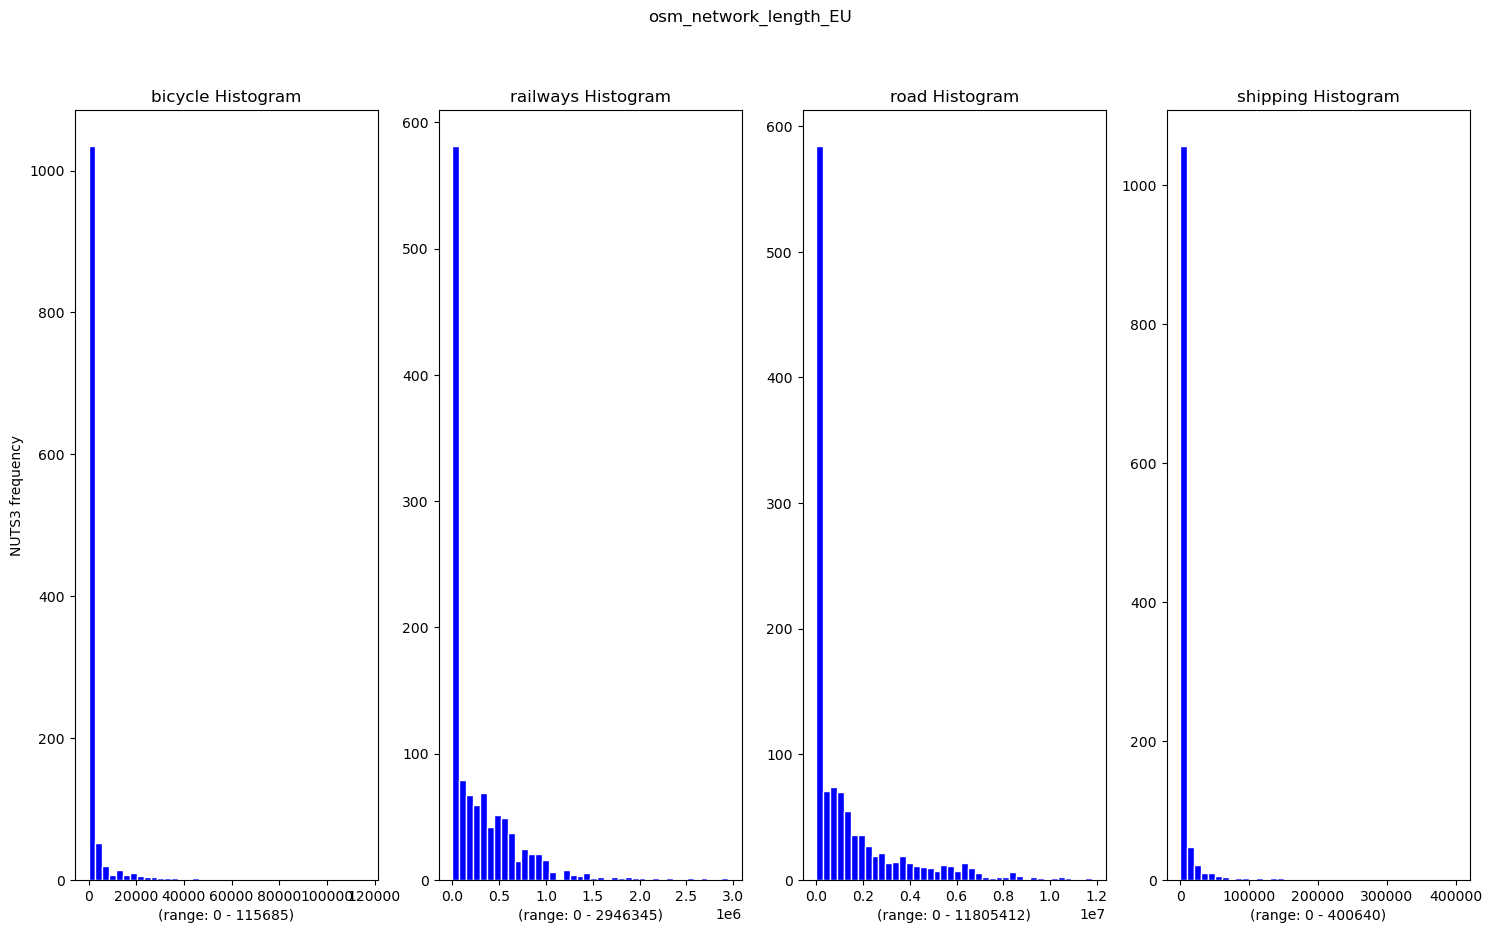

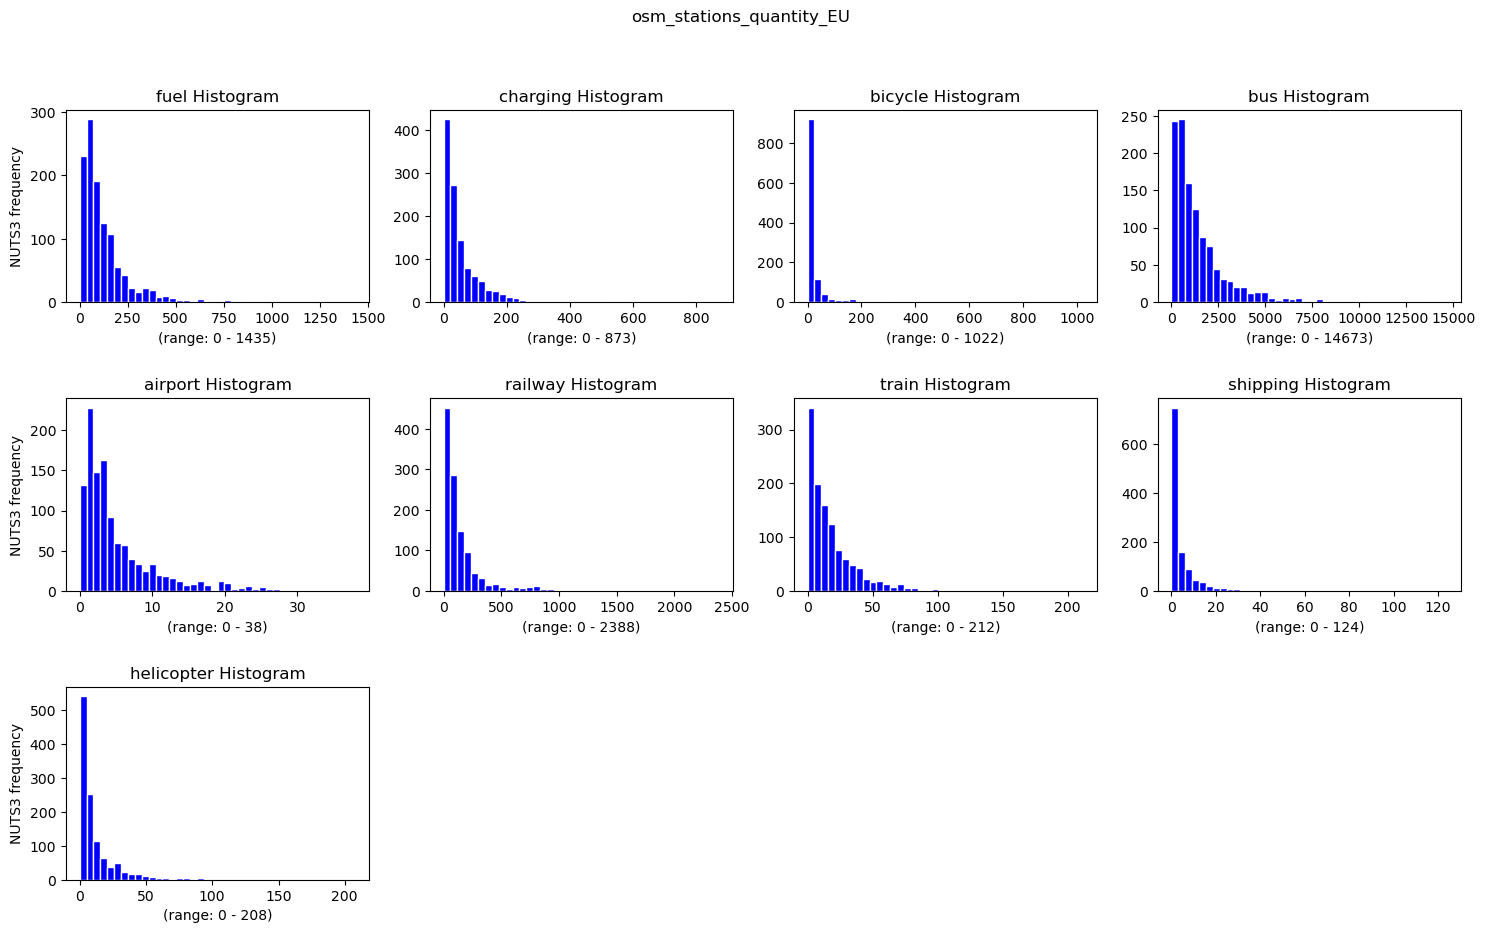

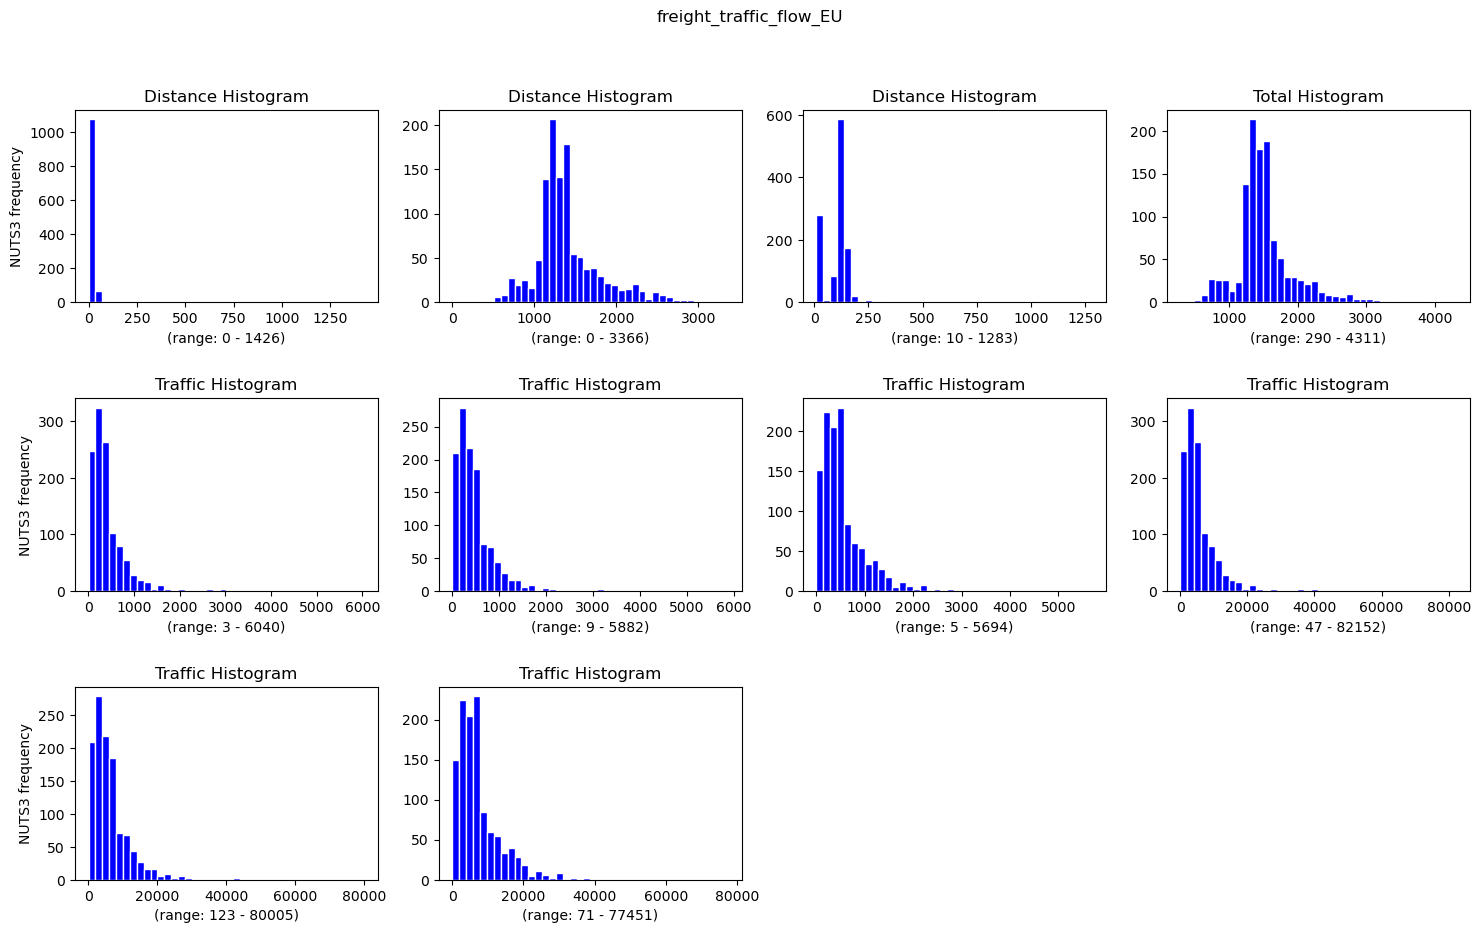

No columns found for figure 'vehicle_stock_DE'
No columns found for figure 'vehicle_stock_buildings_PL'


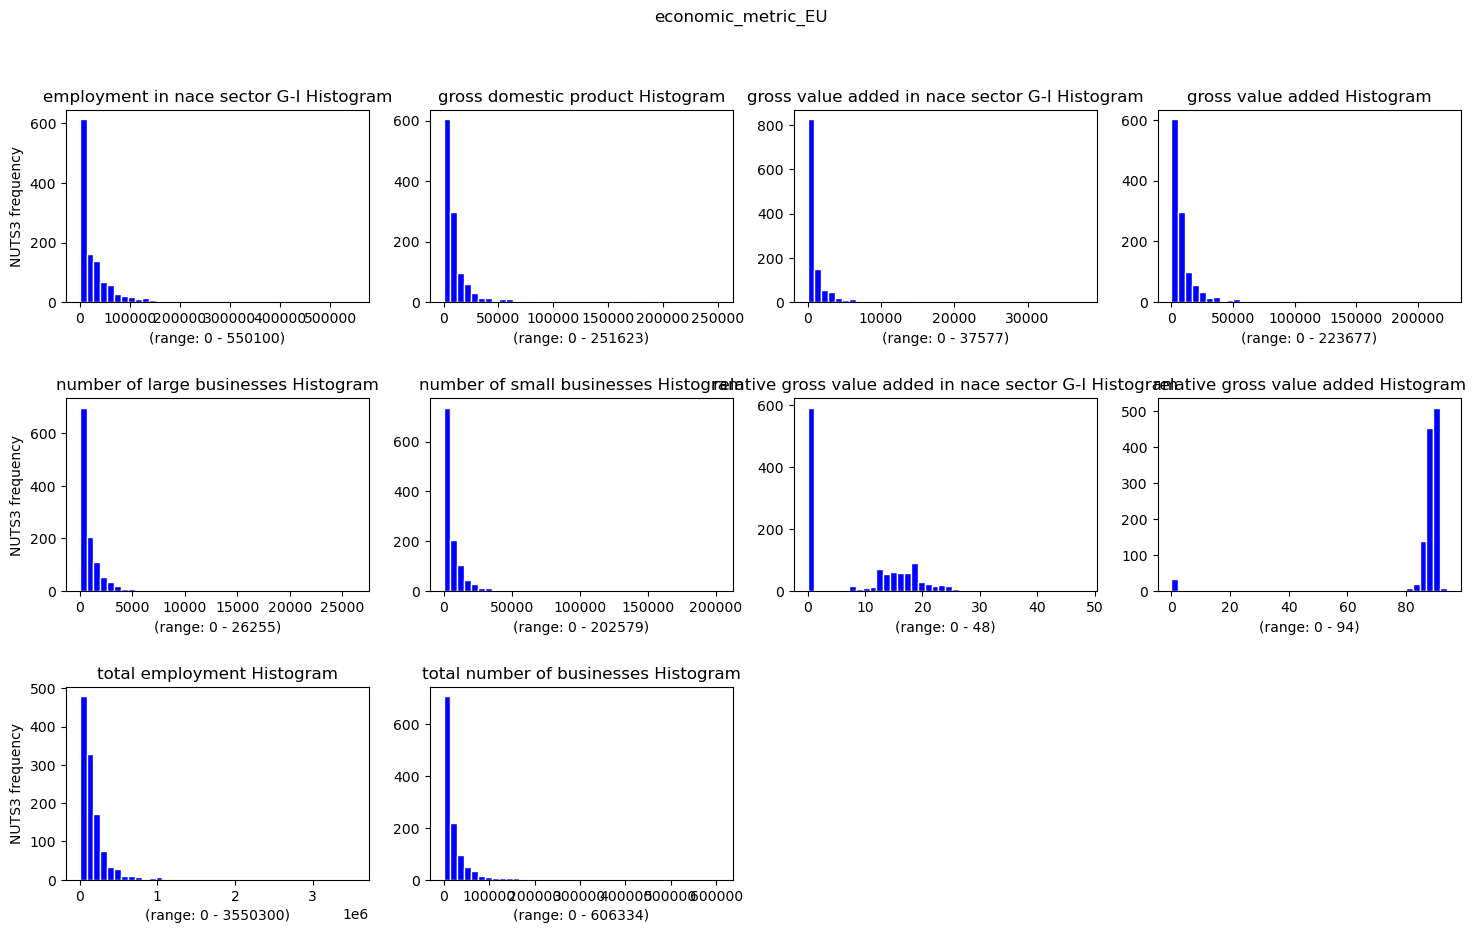

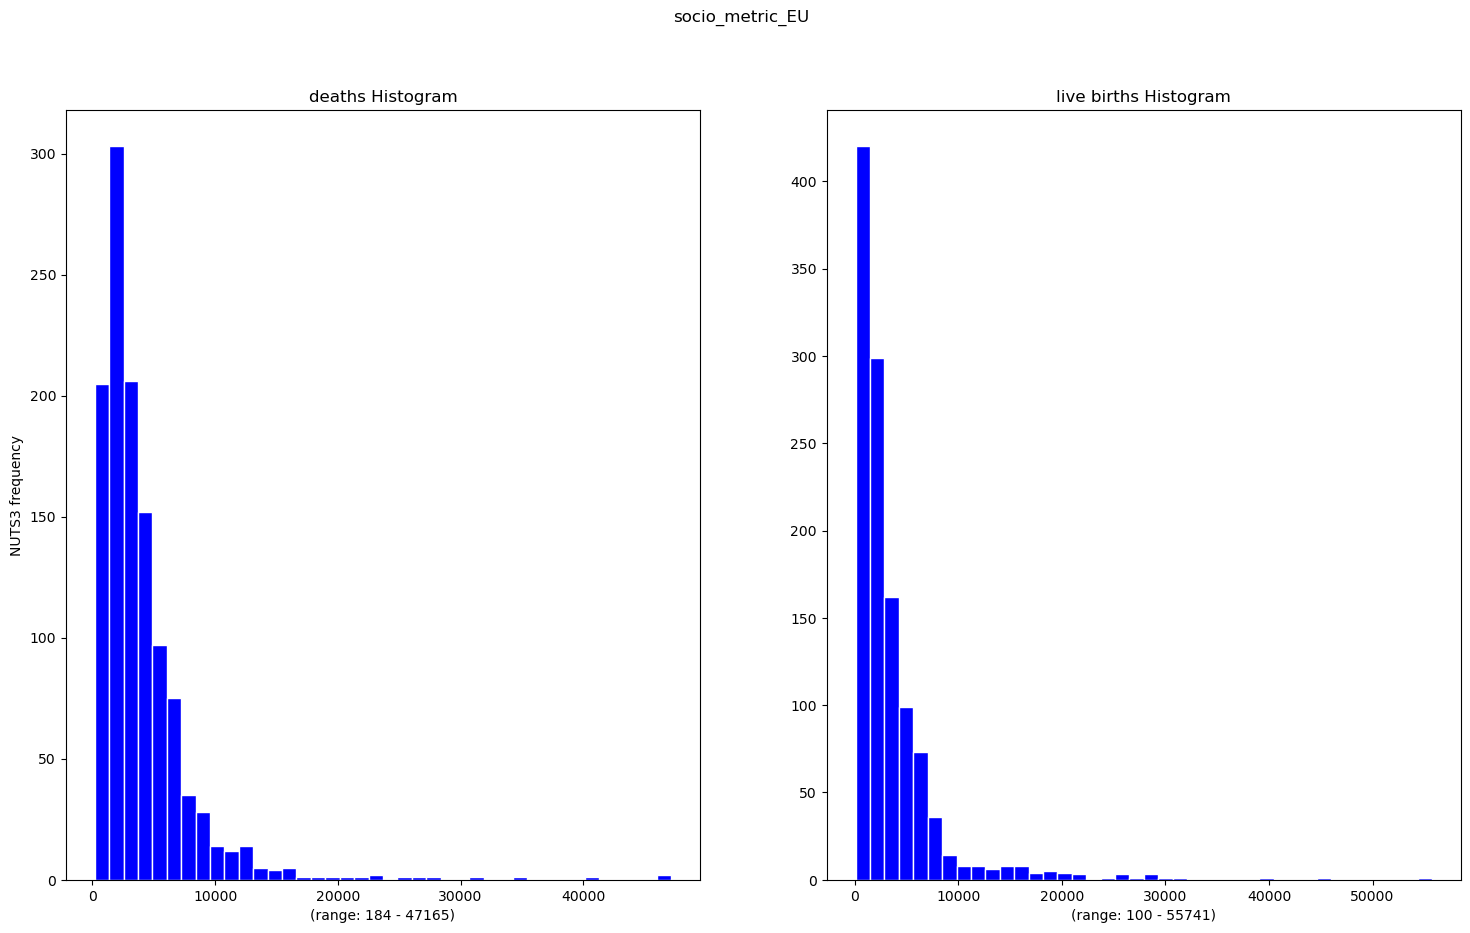

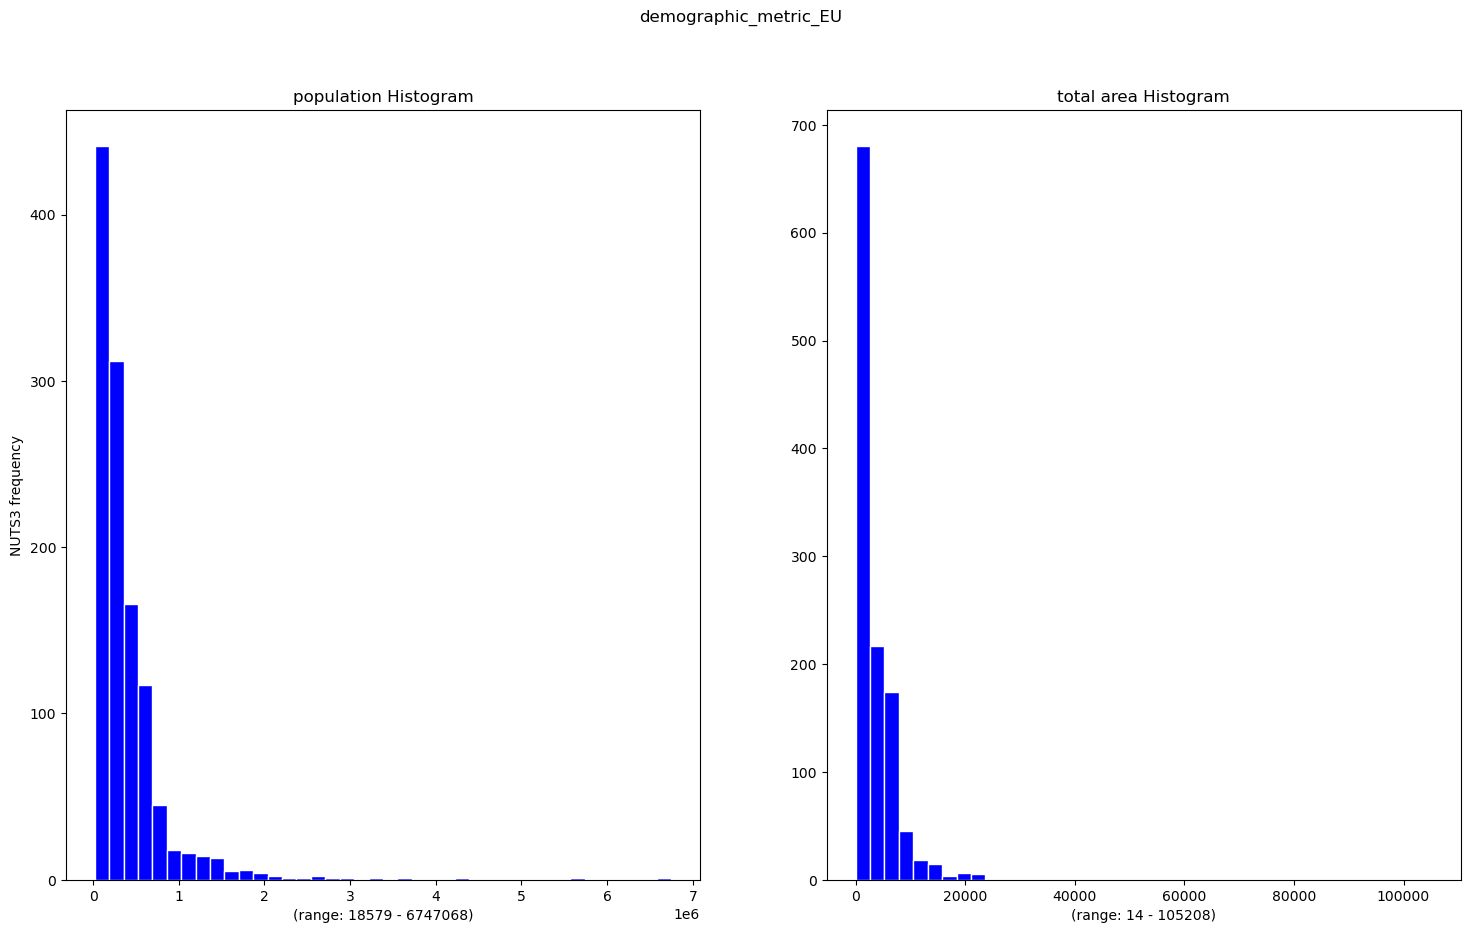

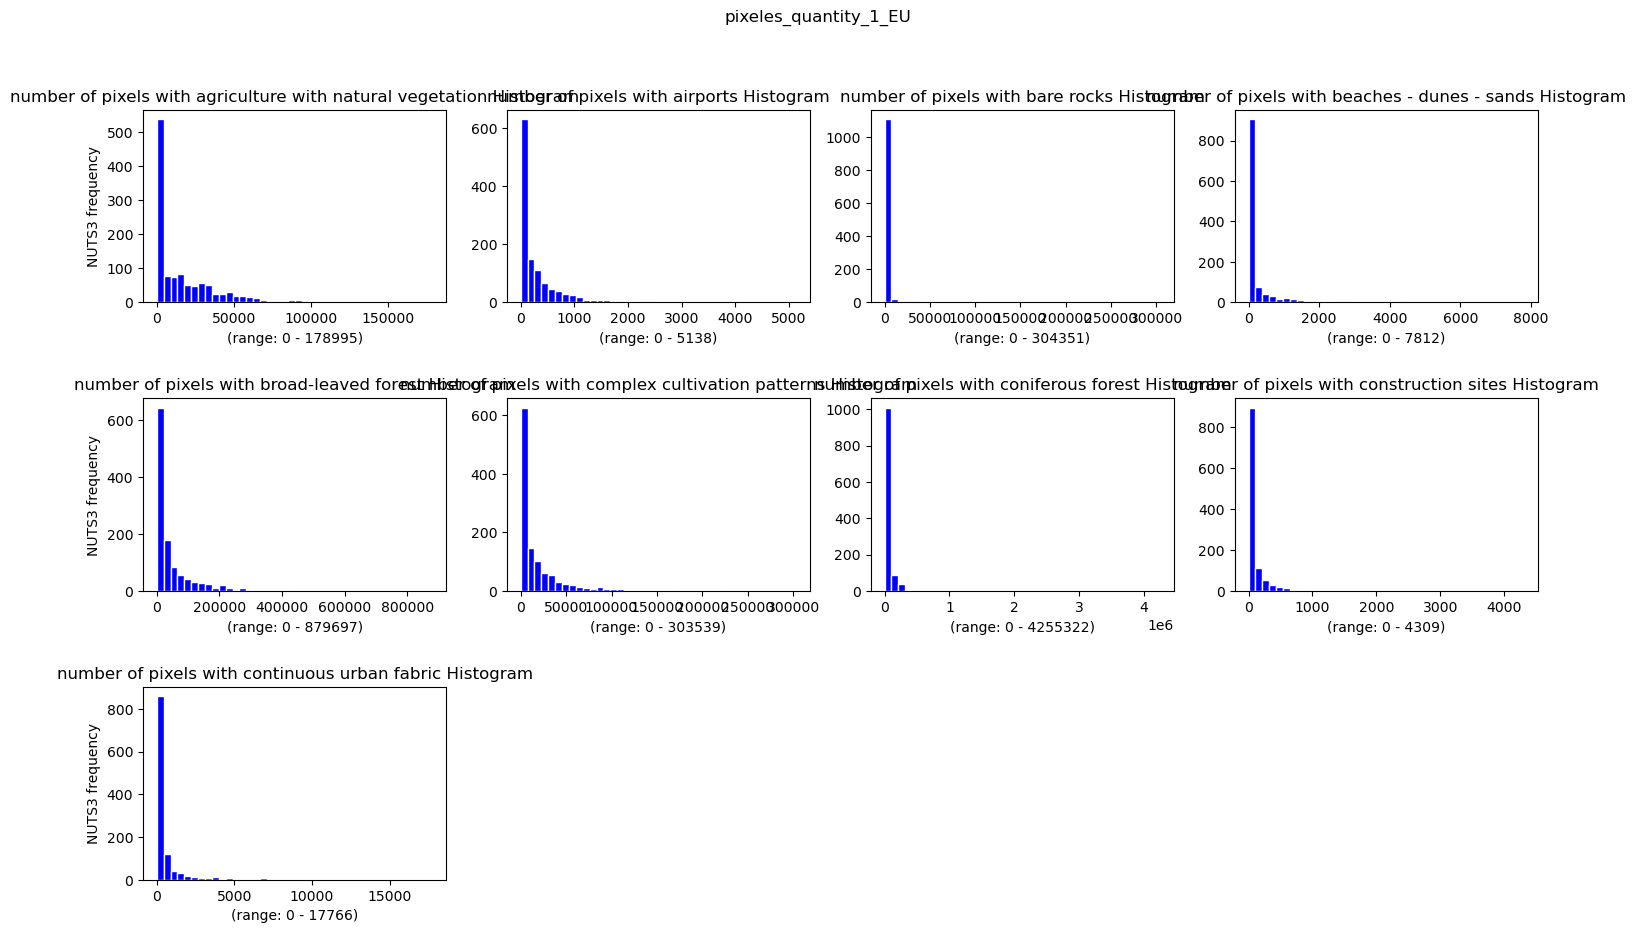

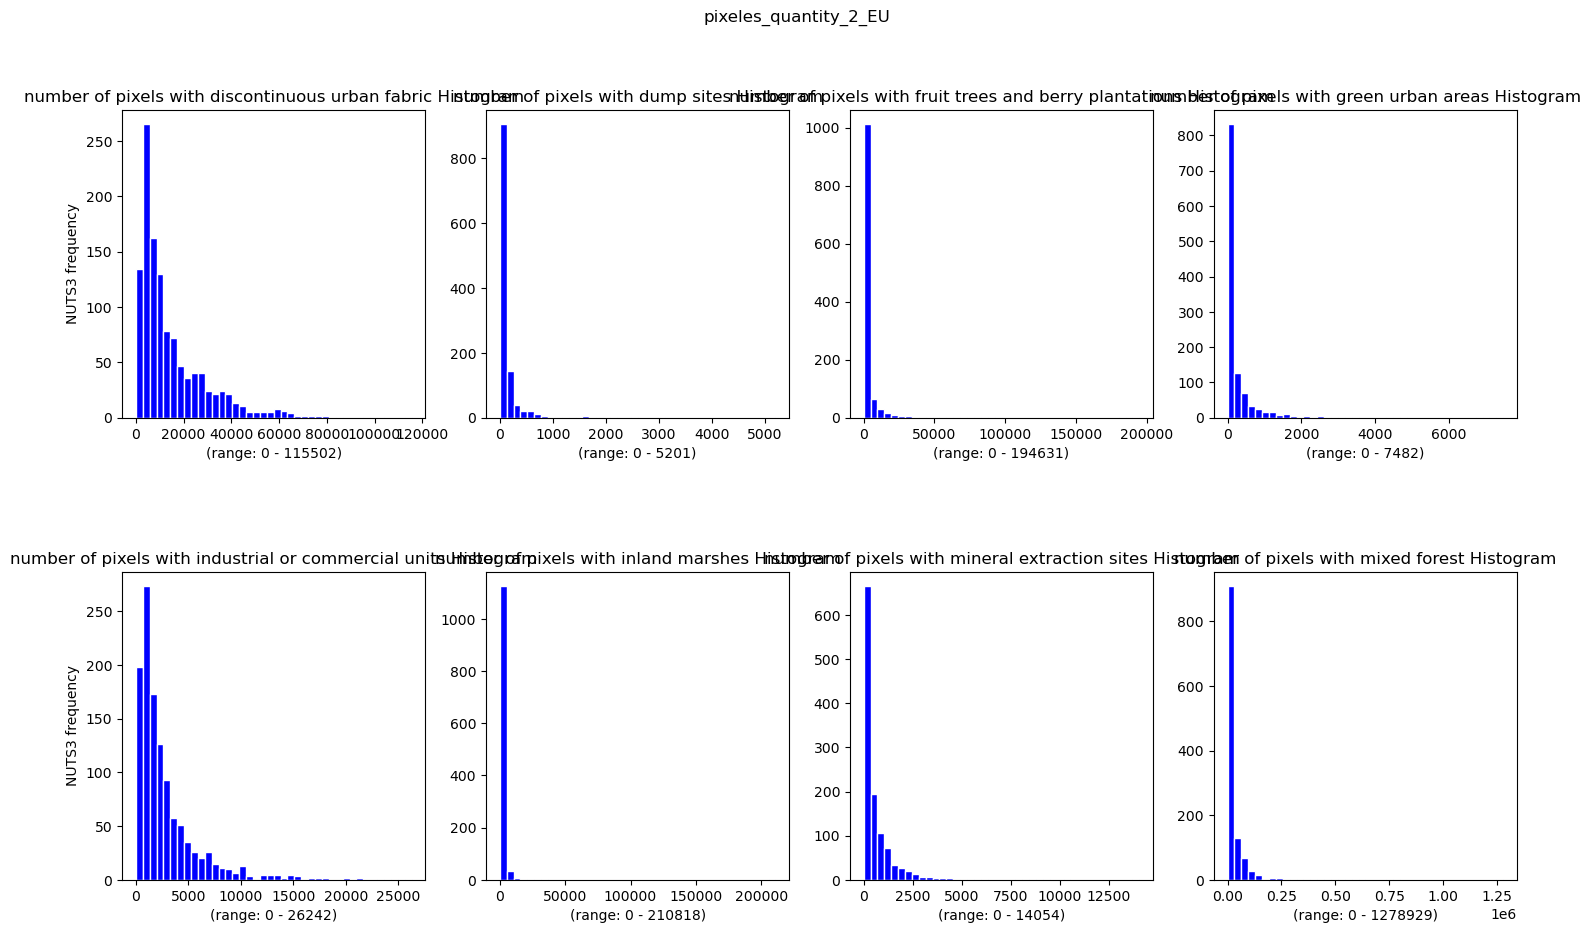

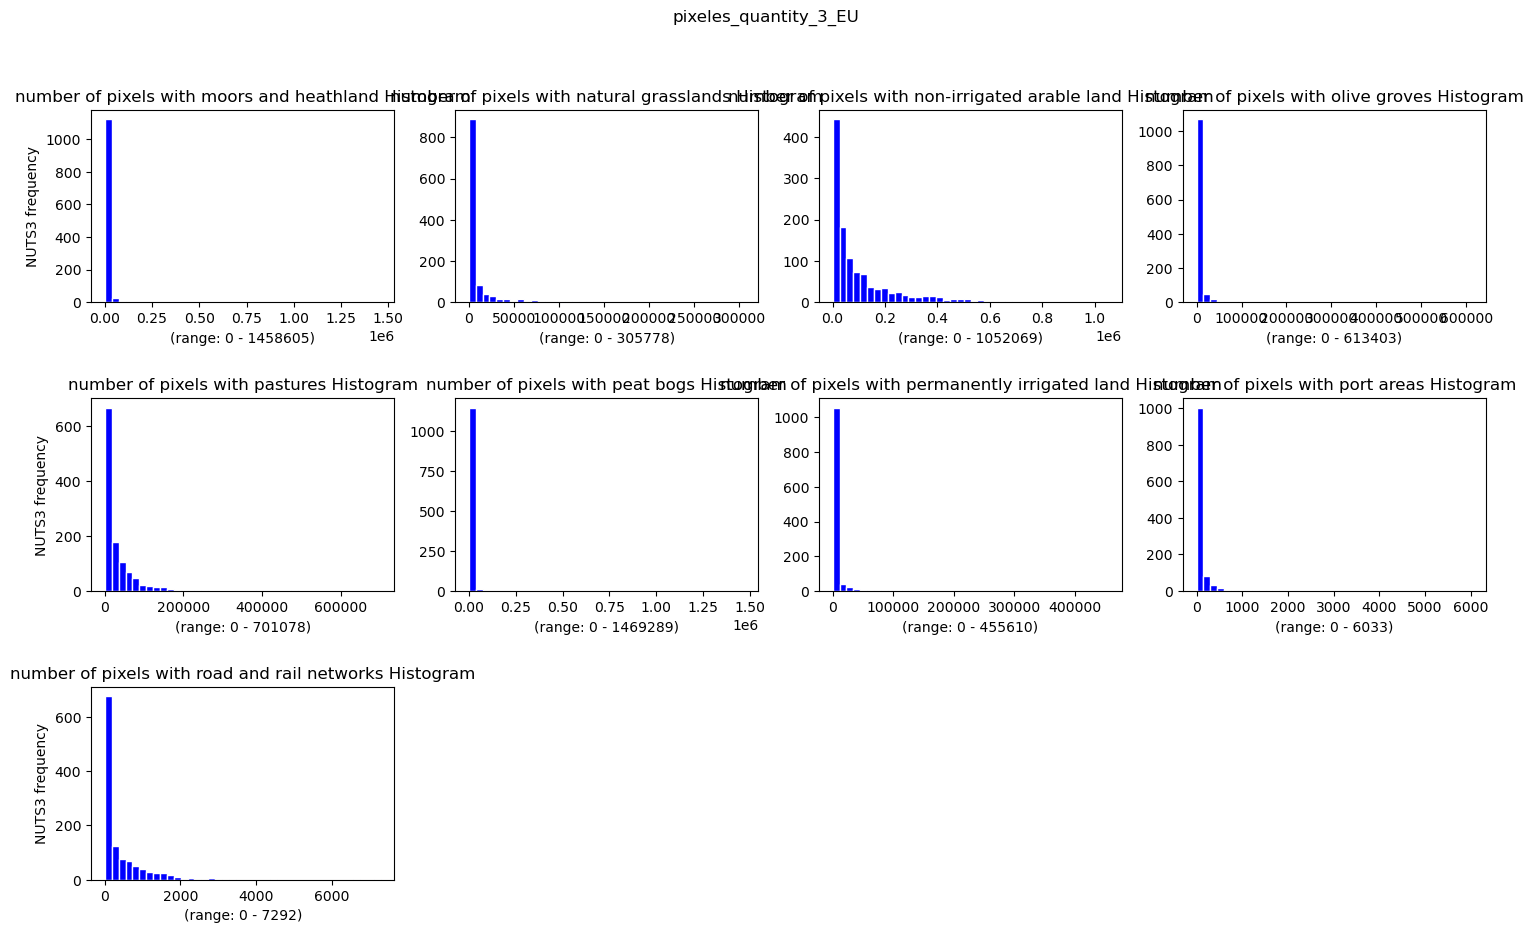

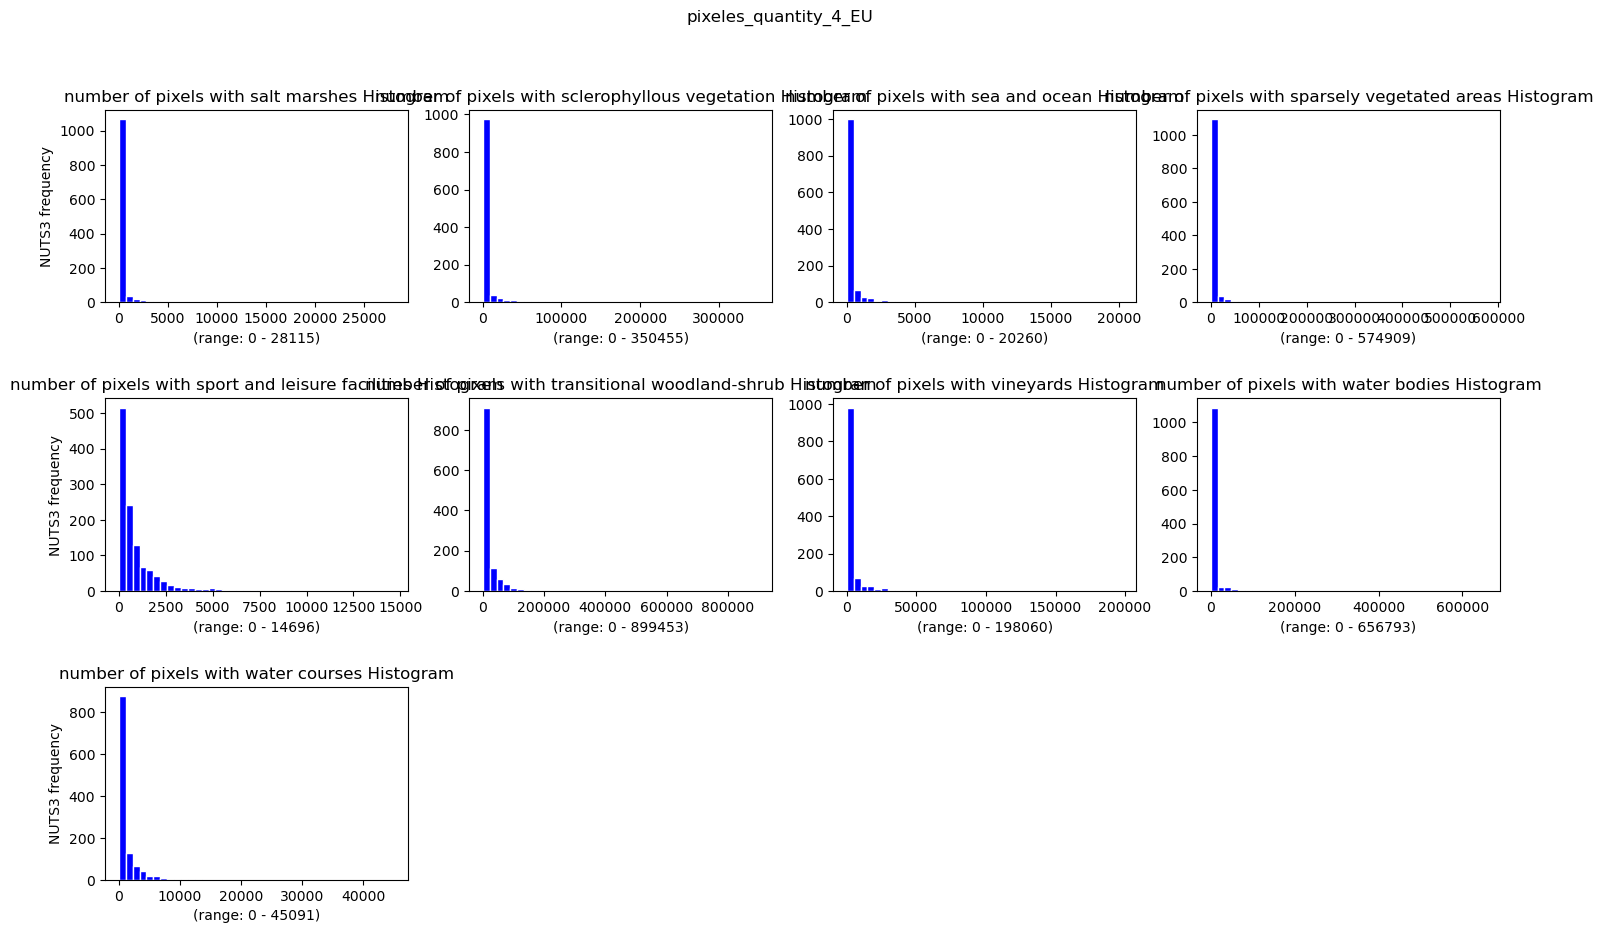

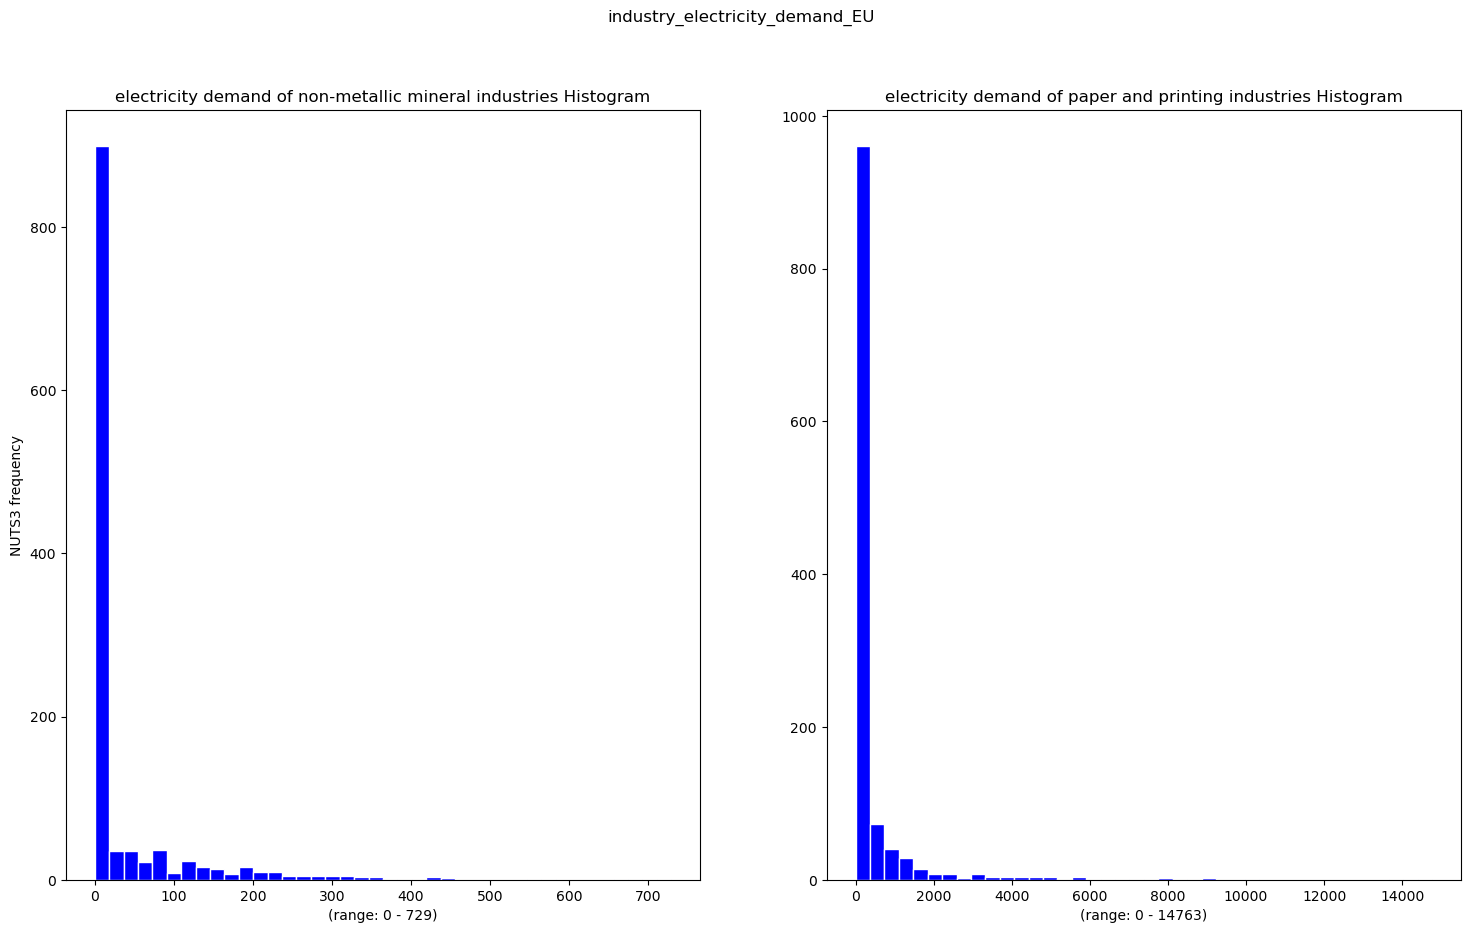

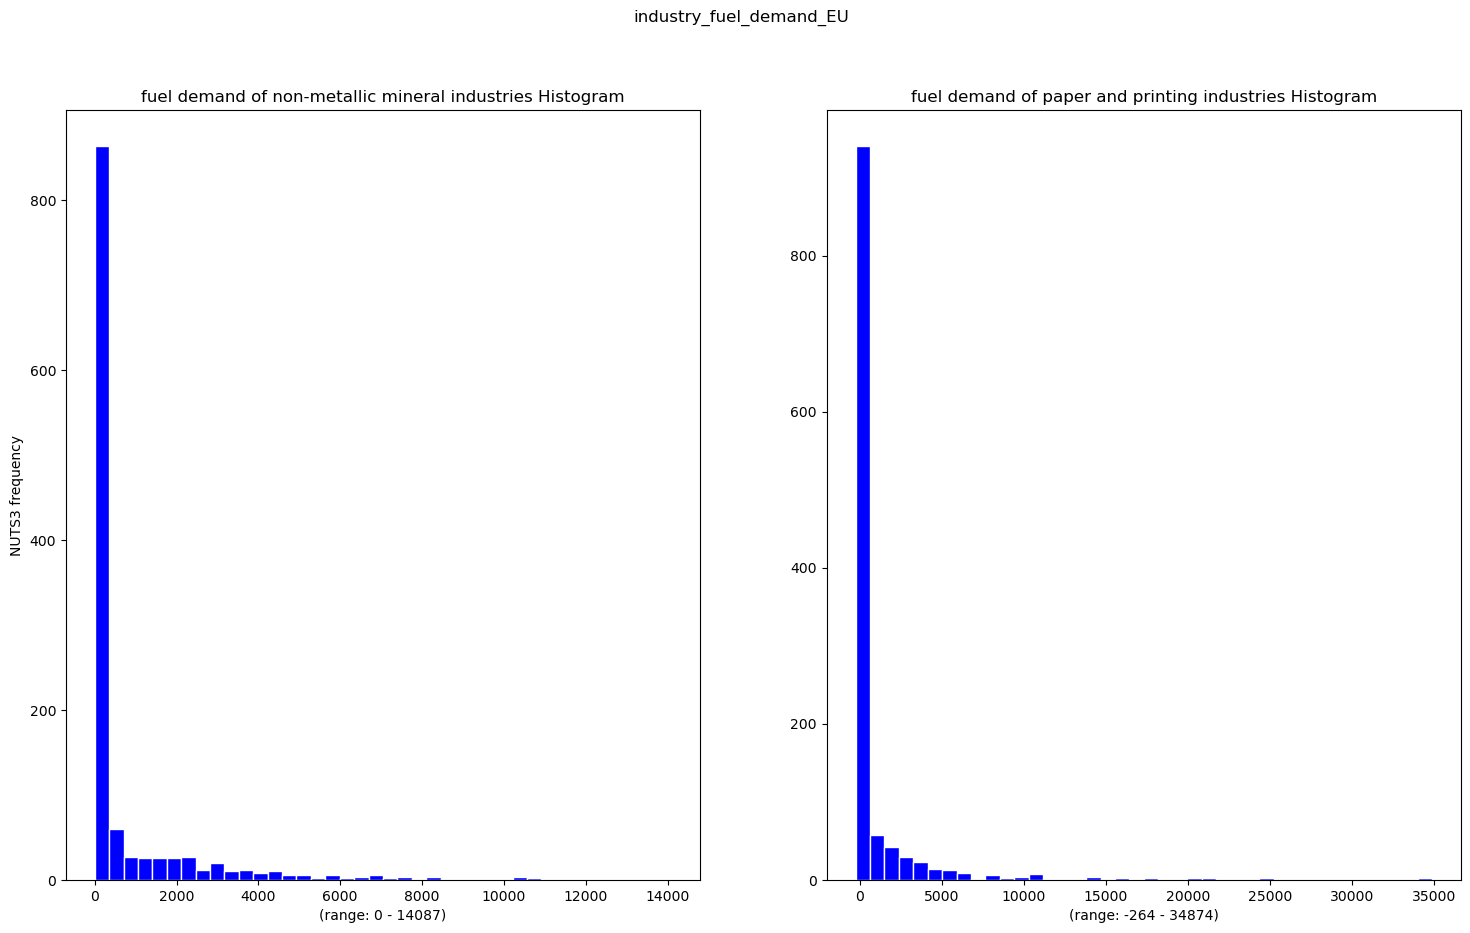

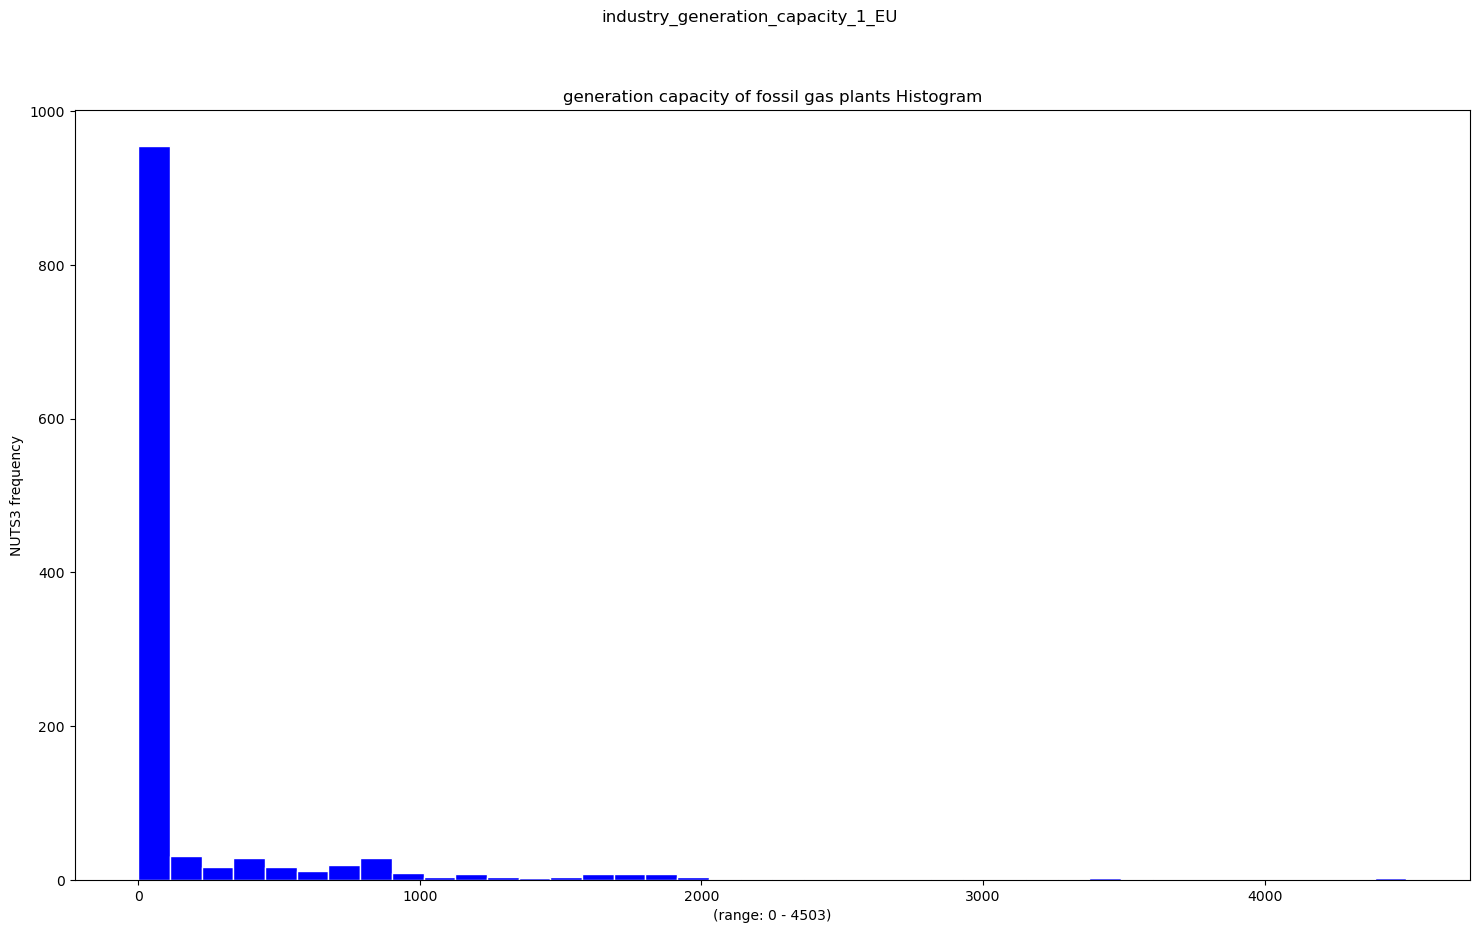

No columns found for figure 'industry_generation_capacity_2'


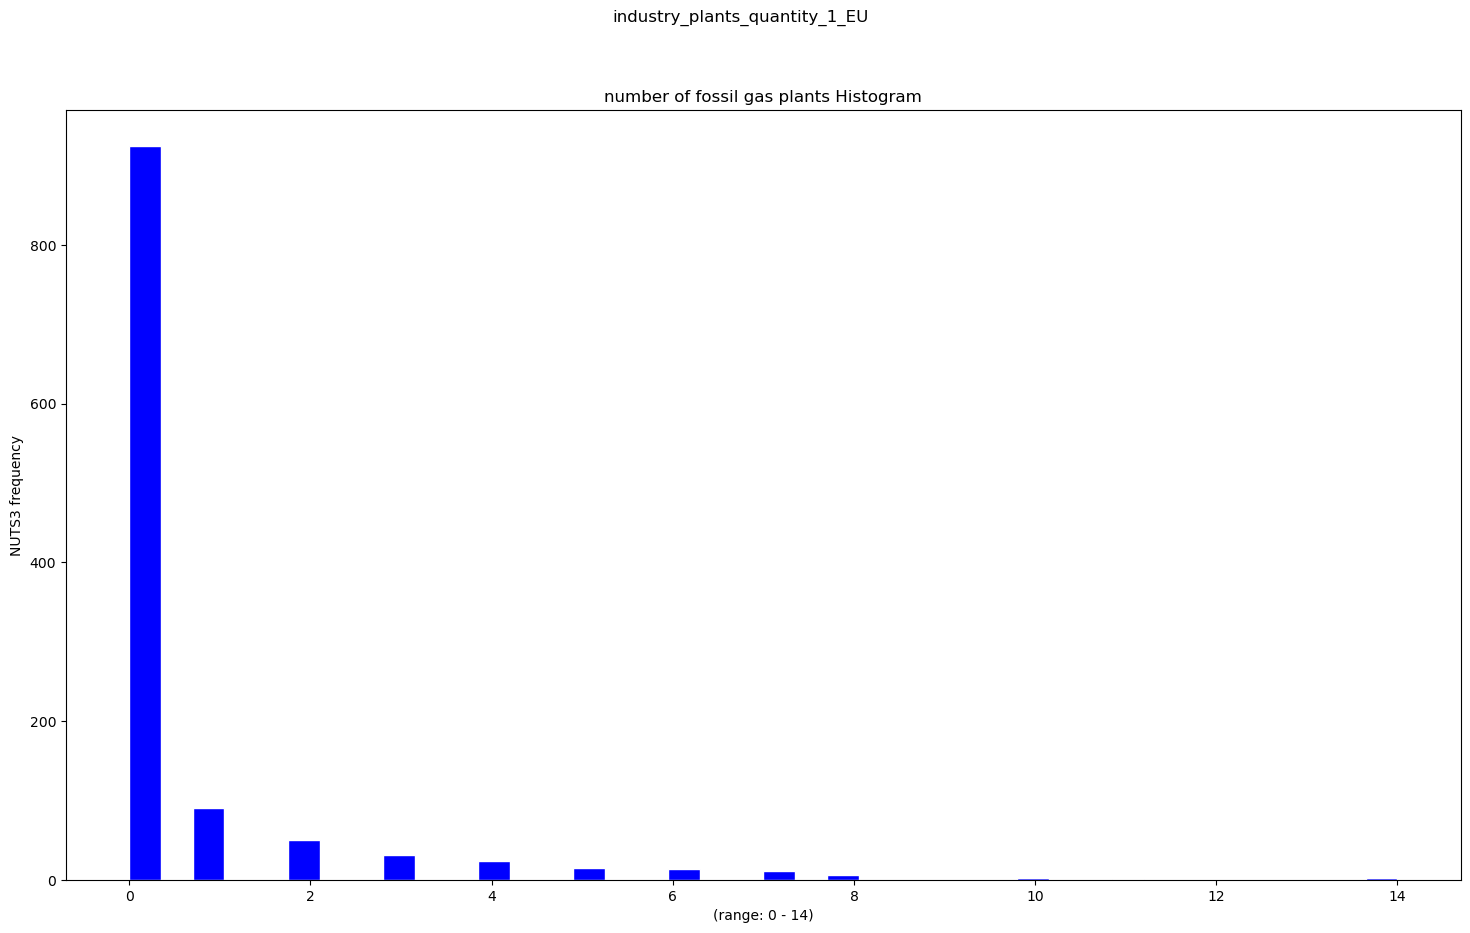

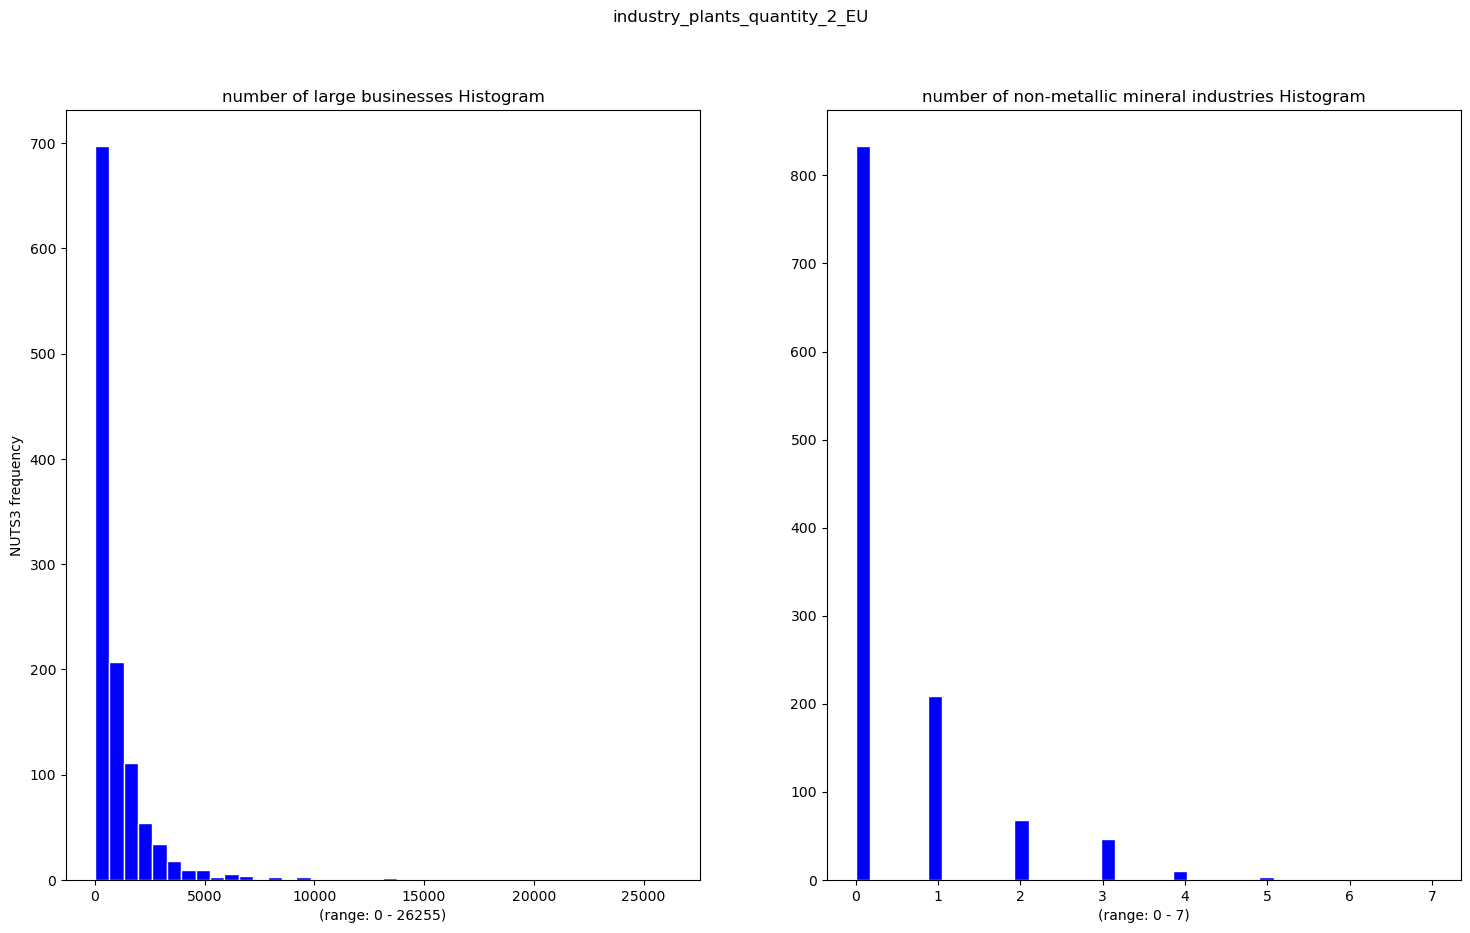

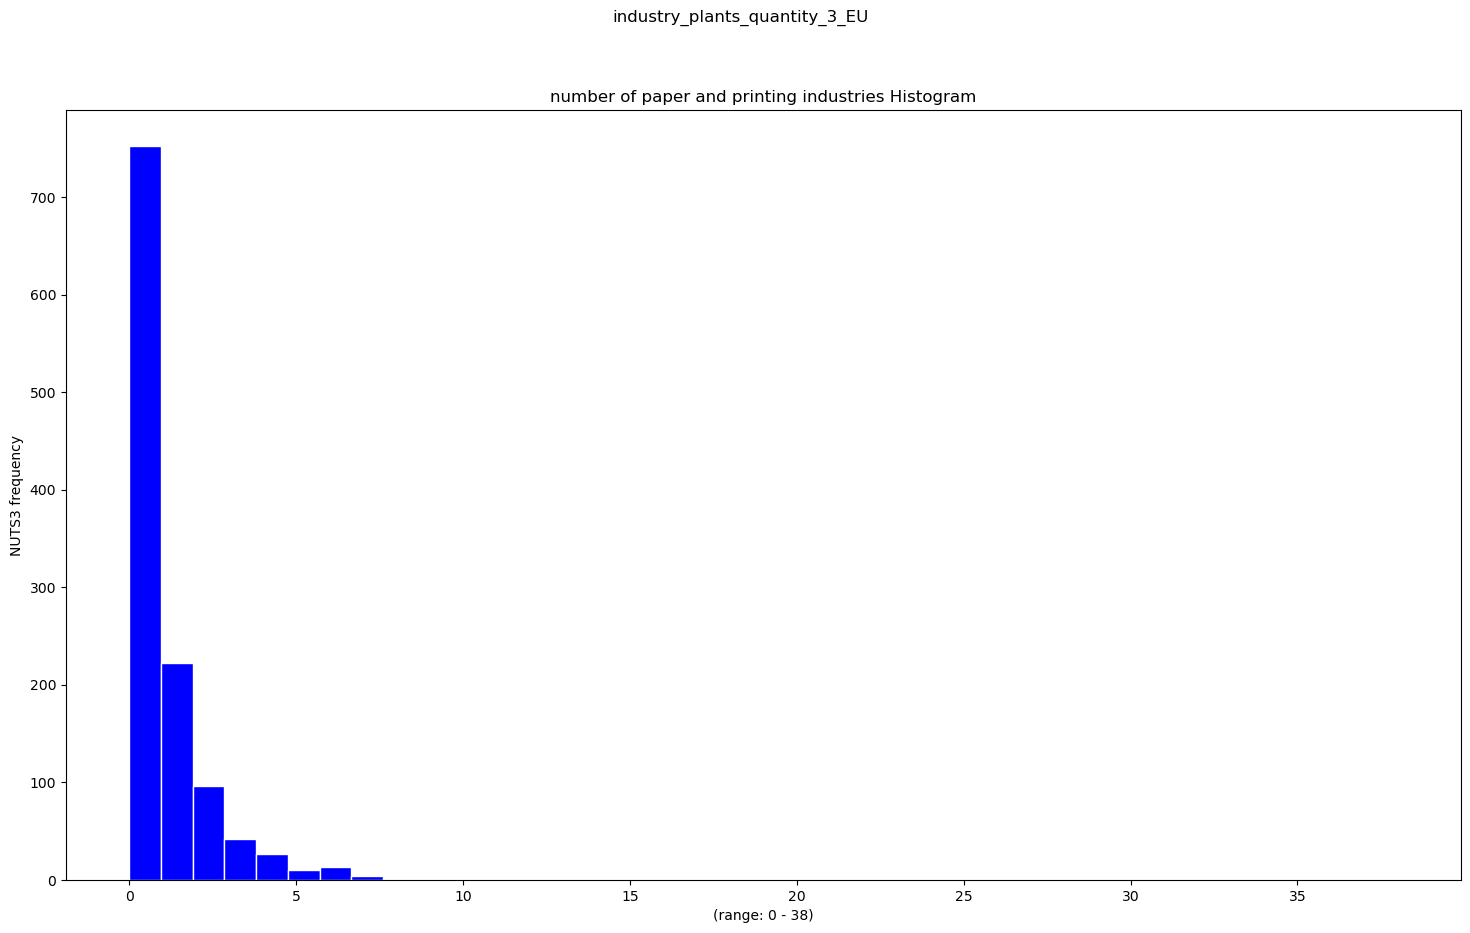

No columns found for figure 'environmental'


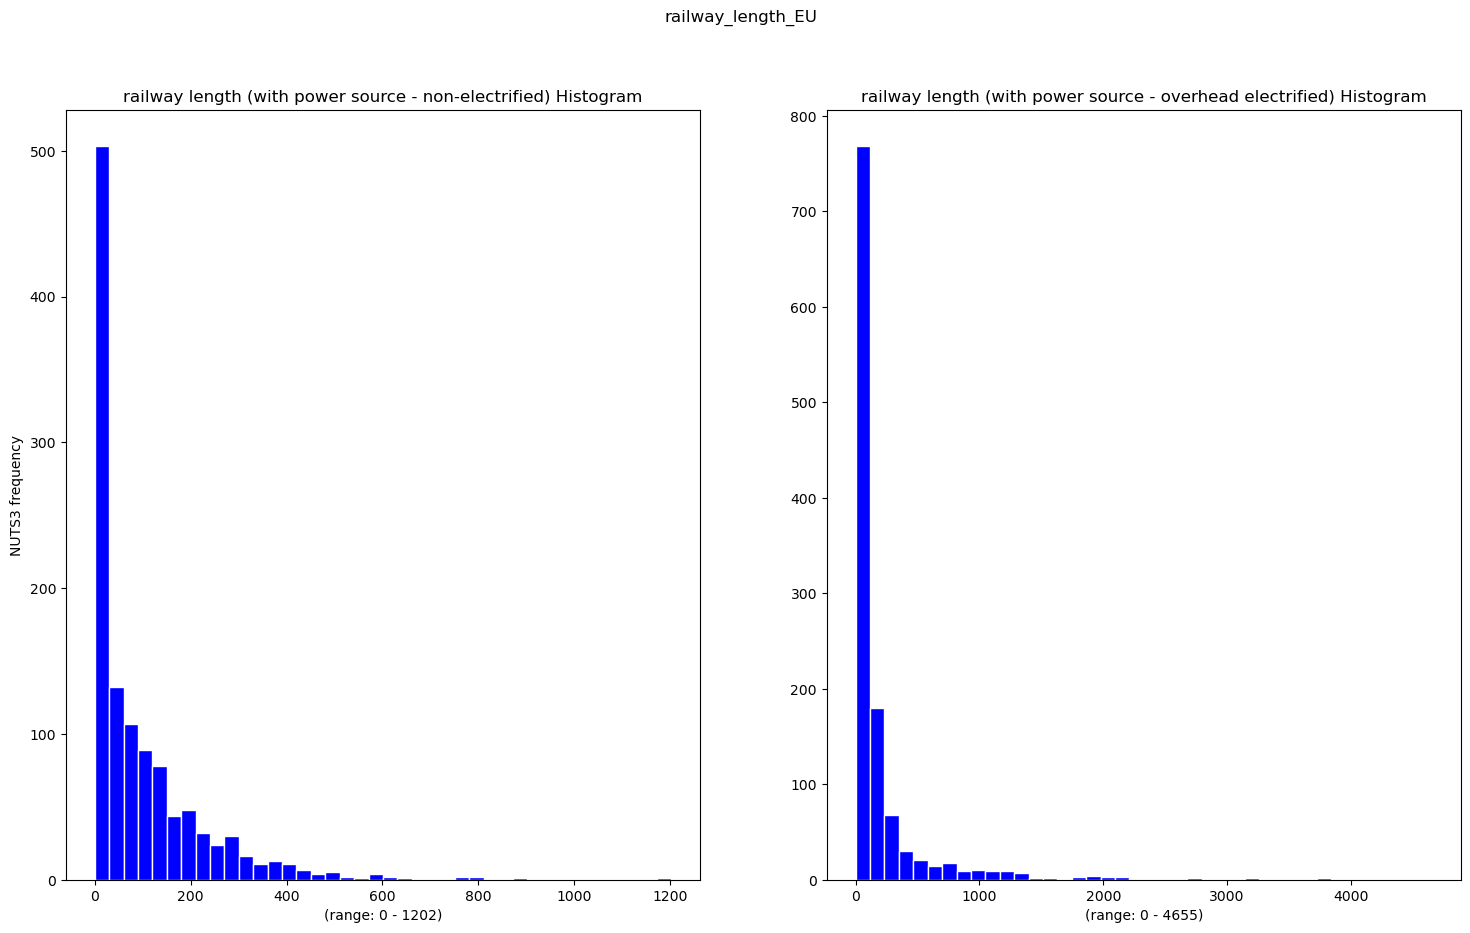

No columns found for figure 'residential_energy_demand'


In [241]:
plot_column_histograms_eu(df_eu, data_col_dic_hist, fig_size=(18, 10))

##### Country

In [242]:
def plot_column_histograms_country(dataframe, col_dict, fig_size=(10, 5)):
    """
    Plot histograms for multiple columns of a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    col_dict (dict): A dictionary where each key is the name of a figure, and each value is a list of column names to plot in that figure.
    fig_size (tuple): The size of the figure in inches (default: (10, 5)).

    Returns:
    None
    """
    for fig_title, col_names in col_dict.items():
        file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                        'spatial_disaggregation',
                        'data_visualization',
                        'histogram',
                        f'{region}',
                        f"{fig_title}_histogram_{region}_withou_Zeros.png")
        
        # Check if columns exist in the dataframe
        plot_cols = [col for col in col_names if col in dataframe.columns]

        if len(plot_cols) == 0:
            print(f"No columns found for figure '{fig_title}'")
            continue

        # Determine the number of subplots and the number of rows and columns needed
        num_subplots = len(plot_cols)
        num_cols = min(num_subplots, 4)
        num_rows = math.ceil(num_subplots / num_cols)

        # Create the figure and subplots
        fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=fig_size, squeeze=False)
        fig.suptitle(f"{fig_title}_{region}")

        # Remove any unused subplots
        for i in range(num_subplots, num_rows * num_cols):
            fig.delaxes(axs.flatten()[i])

        for i, col_name in enumerate(plot_cols):
            try:
                row = i // num_cols
                col = i % num_cols
                axs[row, col].hist(dataframe[col_name], bins=40, facecolor='b', edgecolor='white')
                xlabel = col_name.split('_')[0]  # use the first part of the column name
                axs[row, col].set_title(f"{xlabel} Histogram")
                axs[row, col].set_xlabel(f'(range: {dataframe[col_name].min()} - {dataframe[col_name].max()})', rotation=0)  # rotate the label for better readability
                
                # Add y-axis label to the first column of histograms
                if col == 0:
                    axs[row, col].set_ylabel("NUTS3 frequency")
                else:
                    axs[row, col].set_title(f"{xlabel} Histogram")
                
            except ValueError:
                print(f"Skipping column '{col_name}' because of 'ValueError: autodetected range of [nan, nan] is not finite'")


        fig.subplots_adjust(hspace=0.5)
        
        # Save data to file if it doesn't exist
        if not os.path.exists(file_path_destination):
            plt.savefig(file_path_destination)
        plt.show()

No columns found for figure 'osm_network_length'


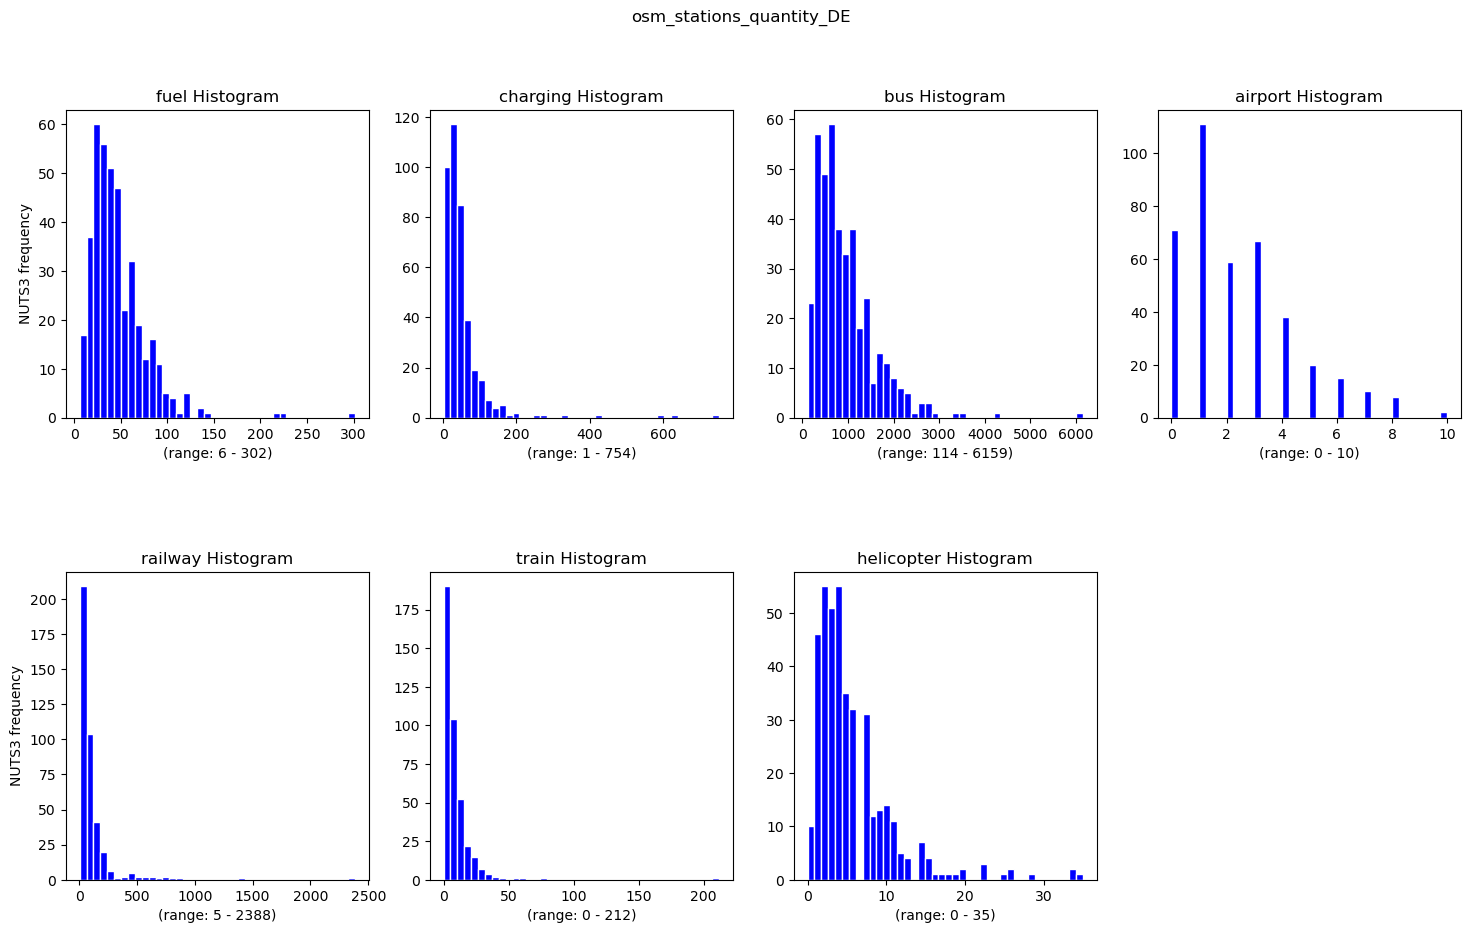

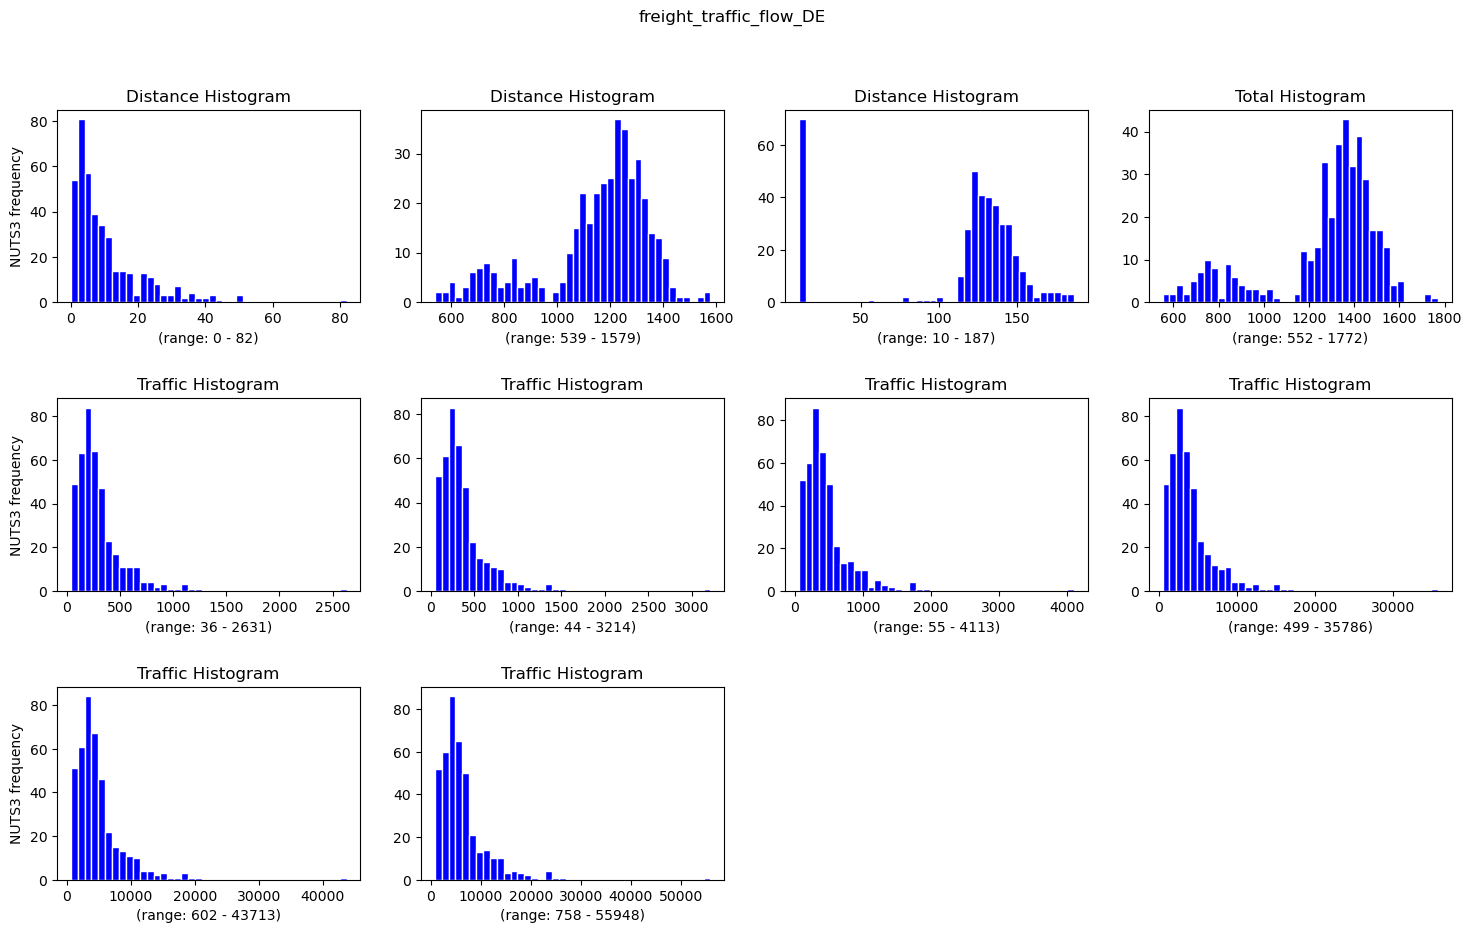

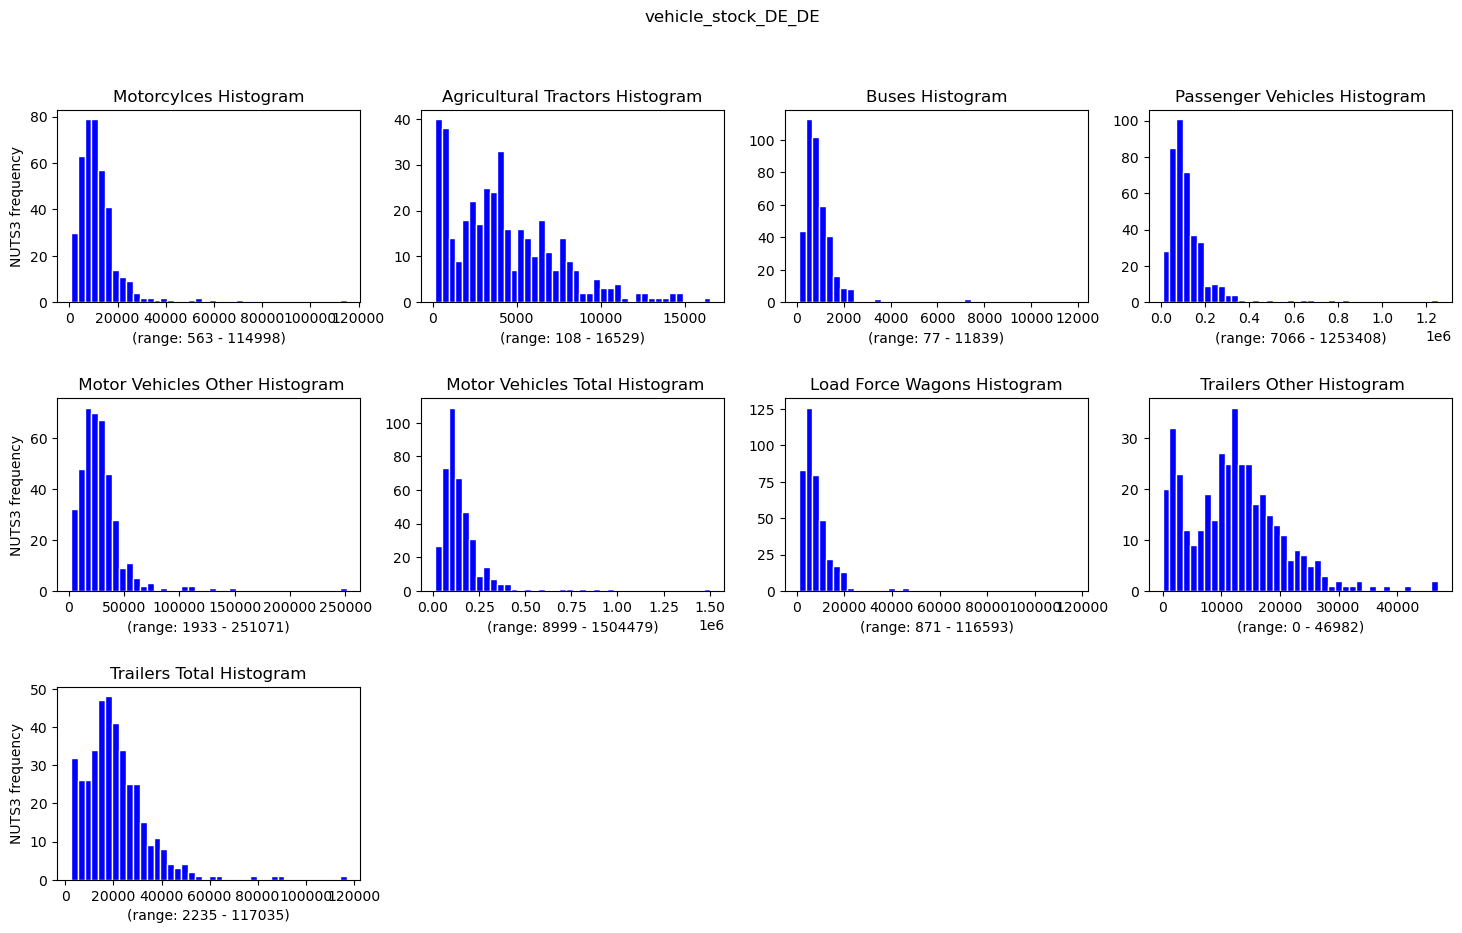

No columns found for figure 'vehicle_stock_buildings_PL'


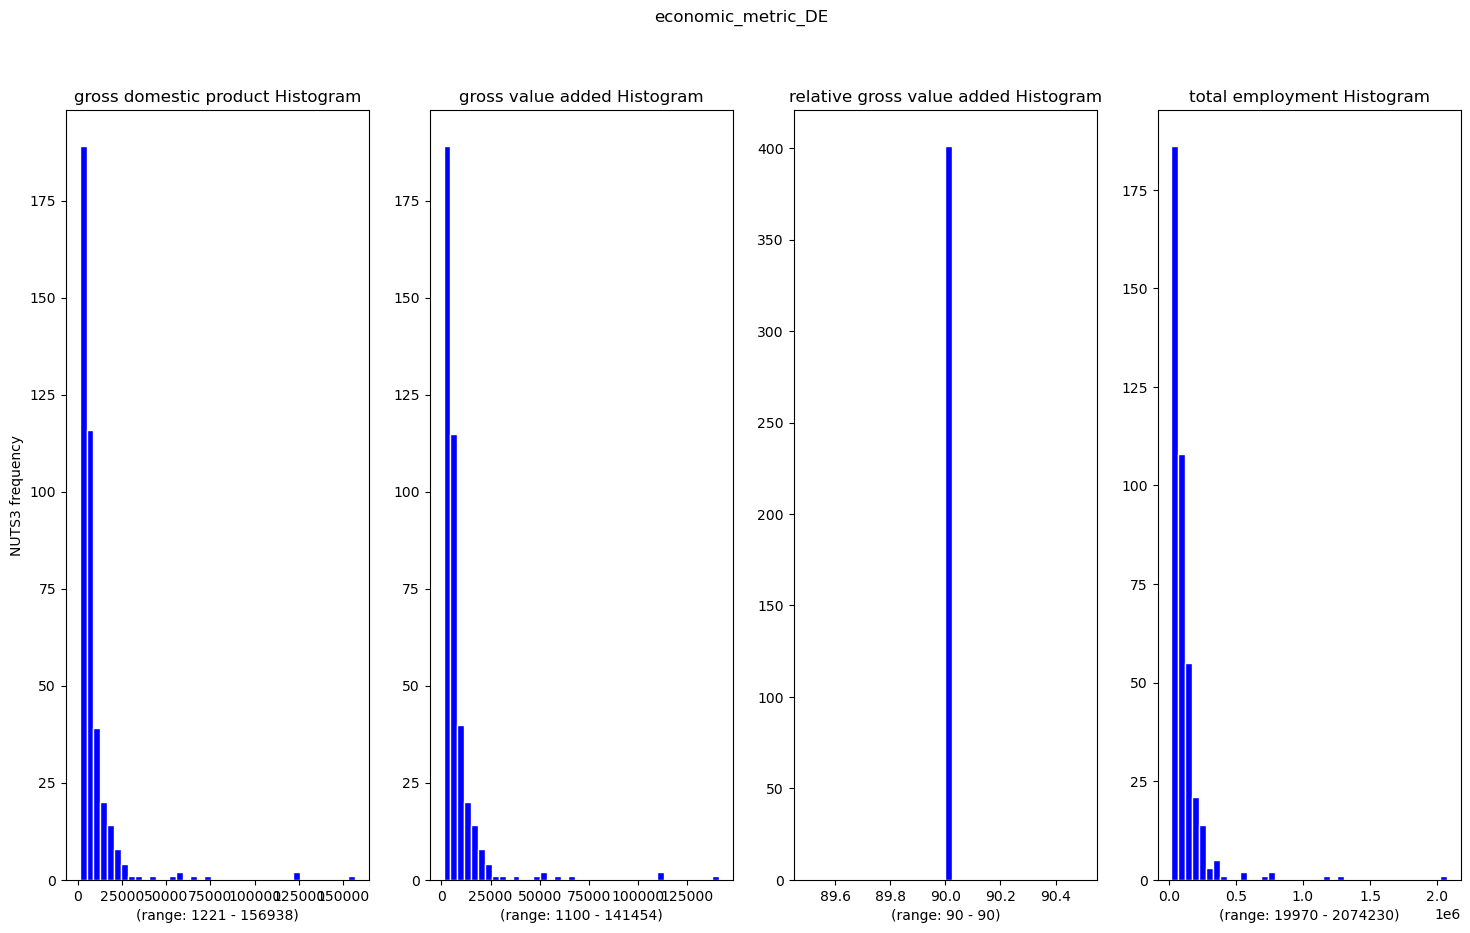

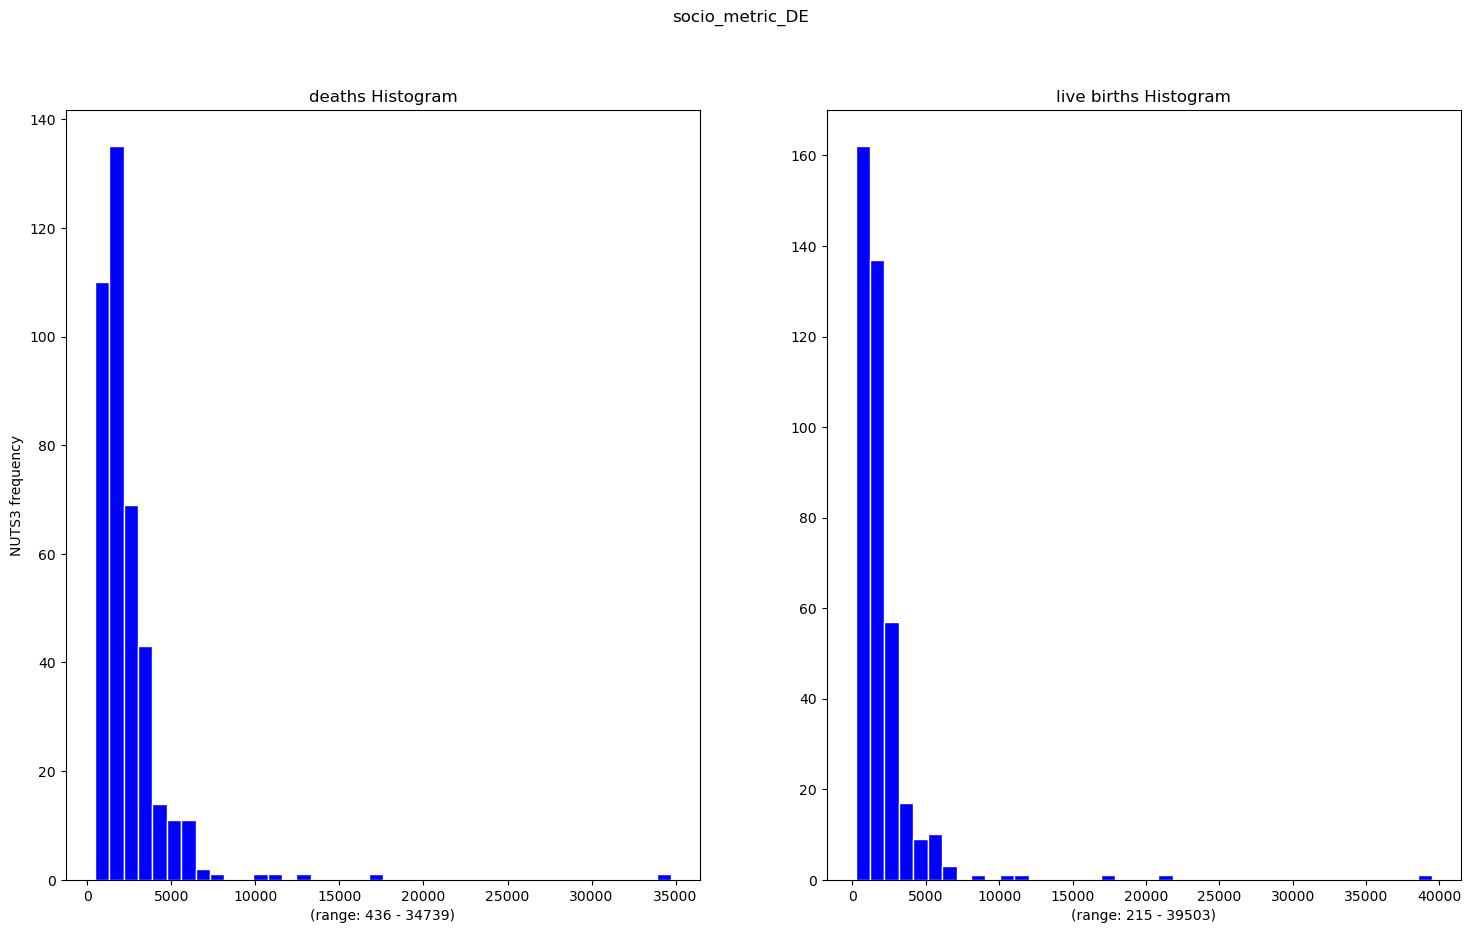

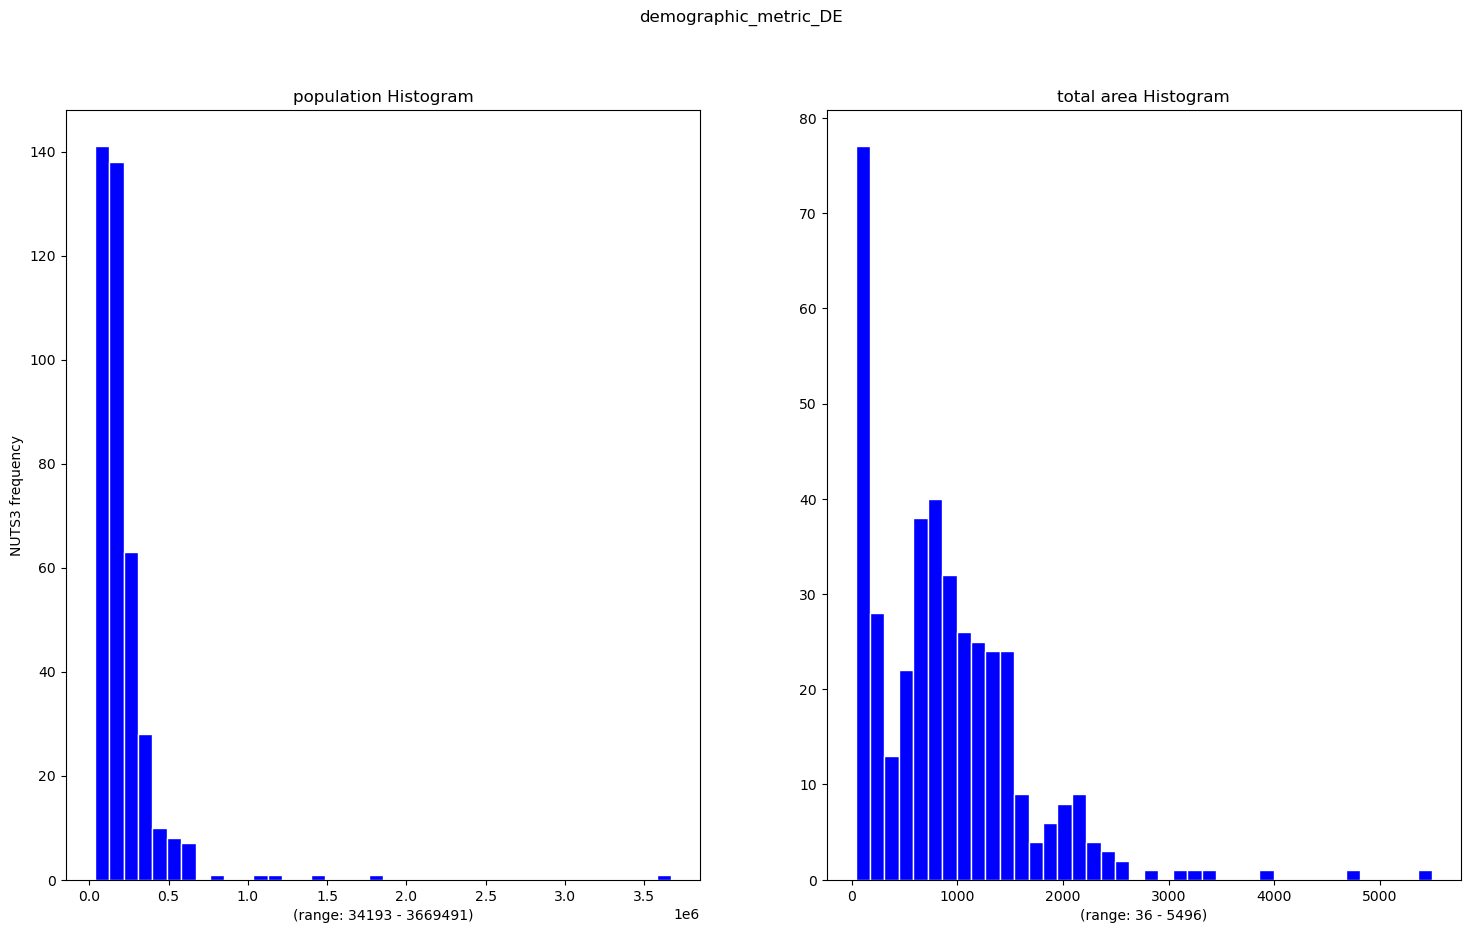

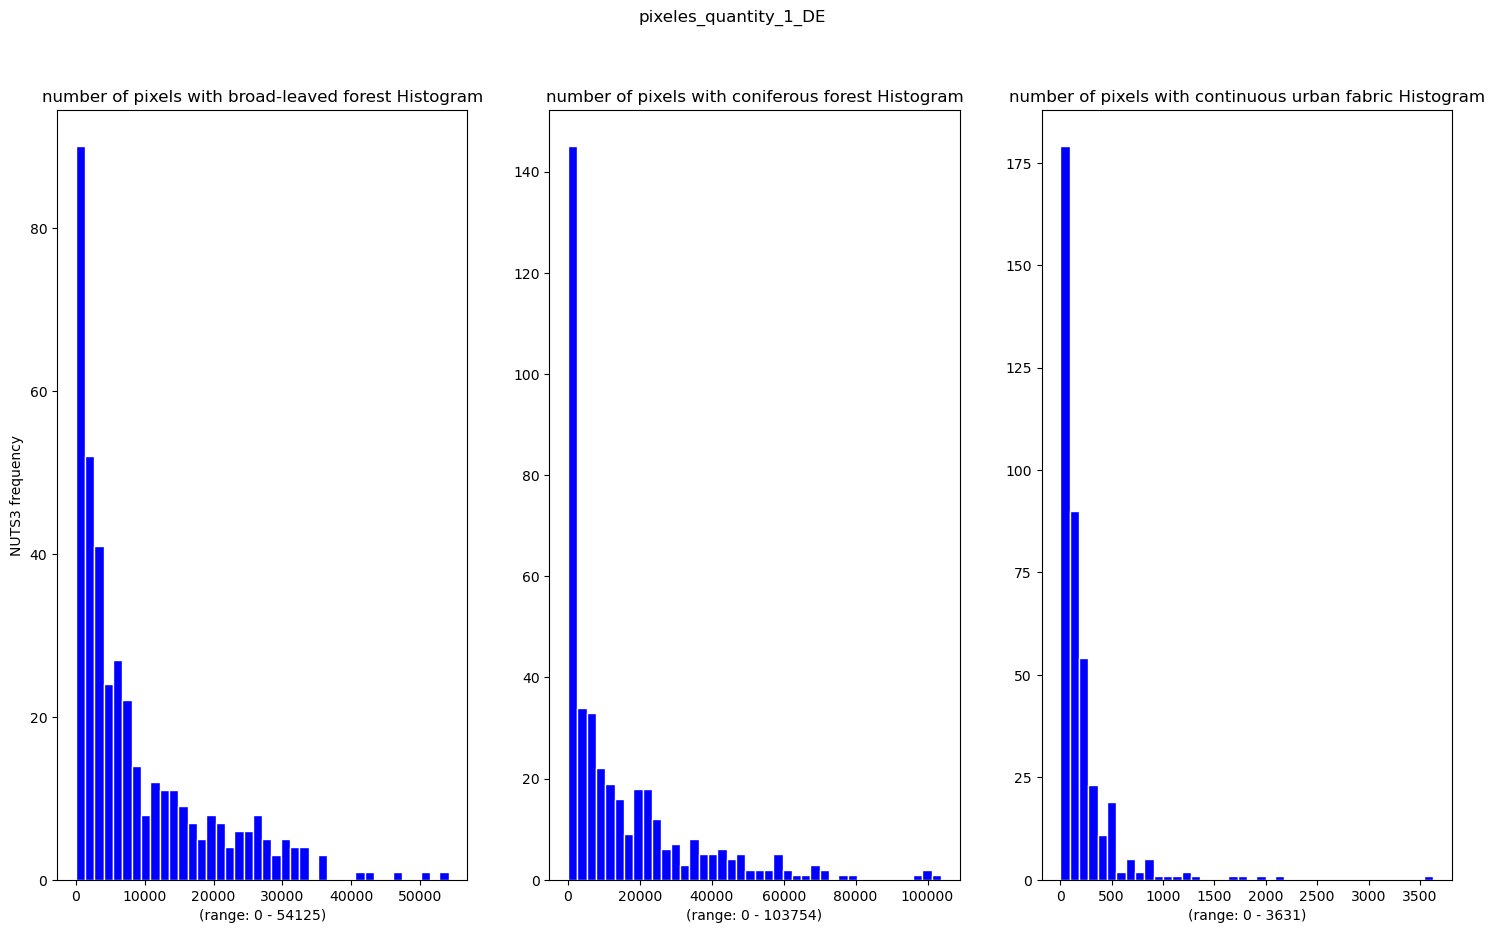

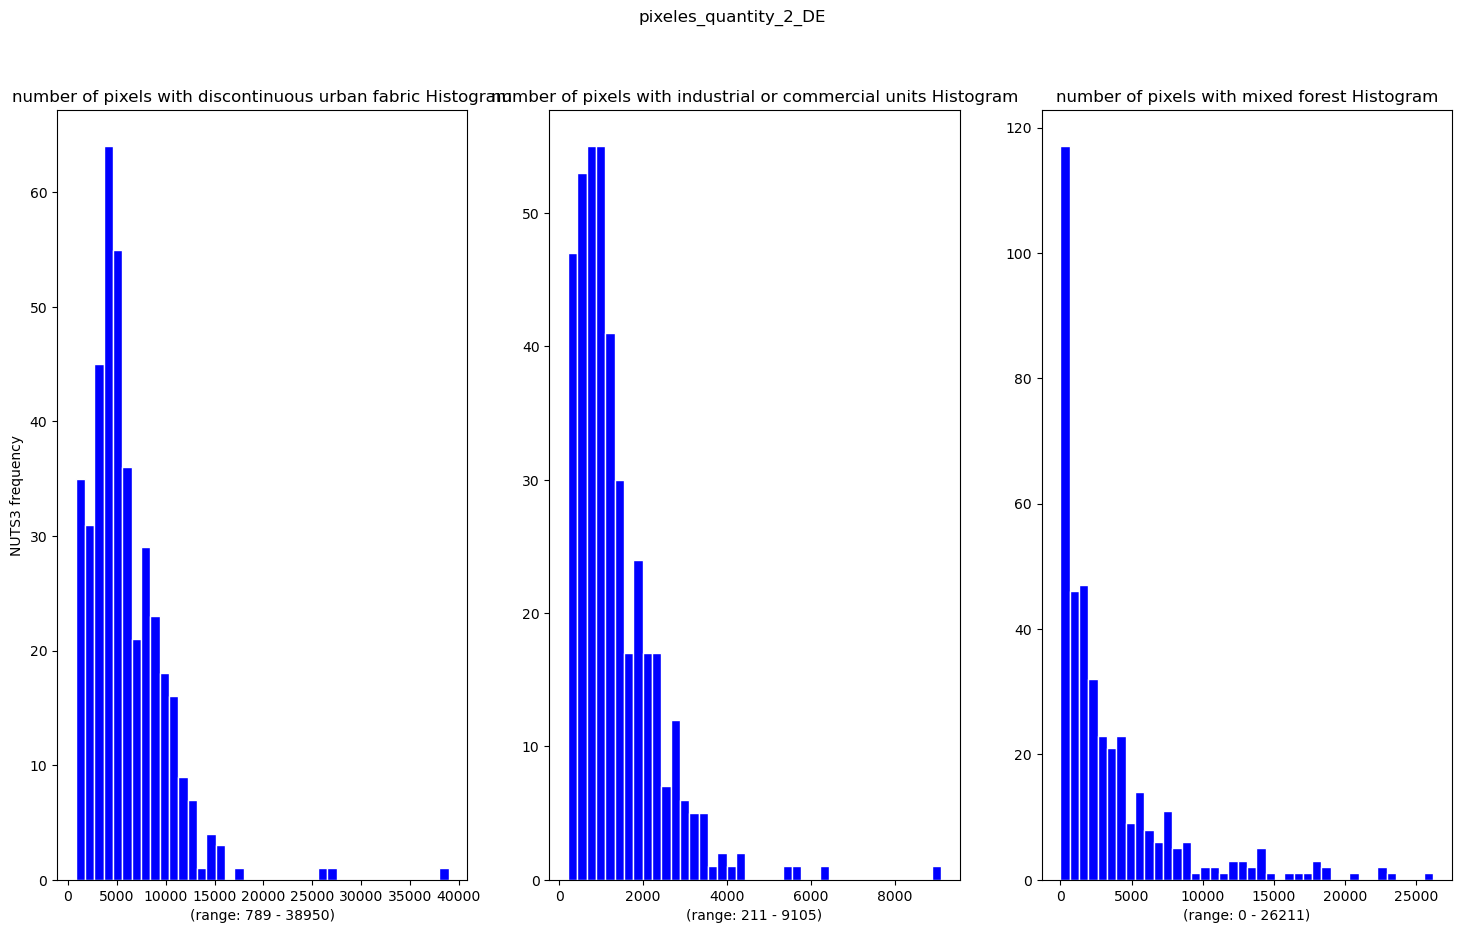

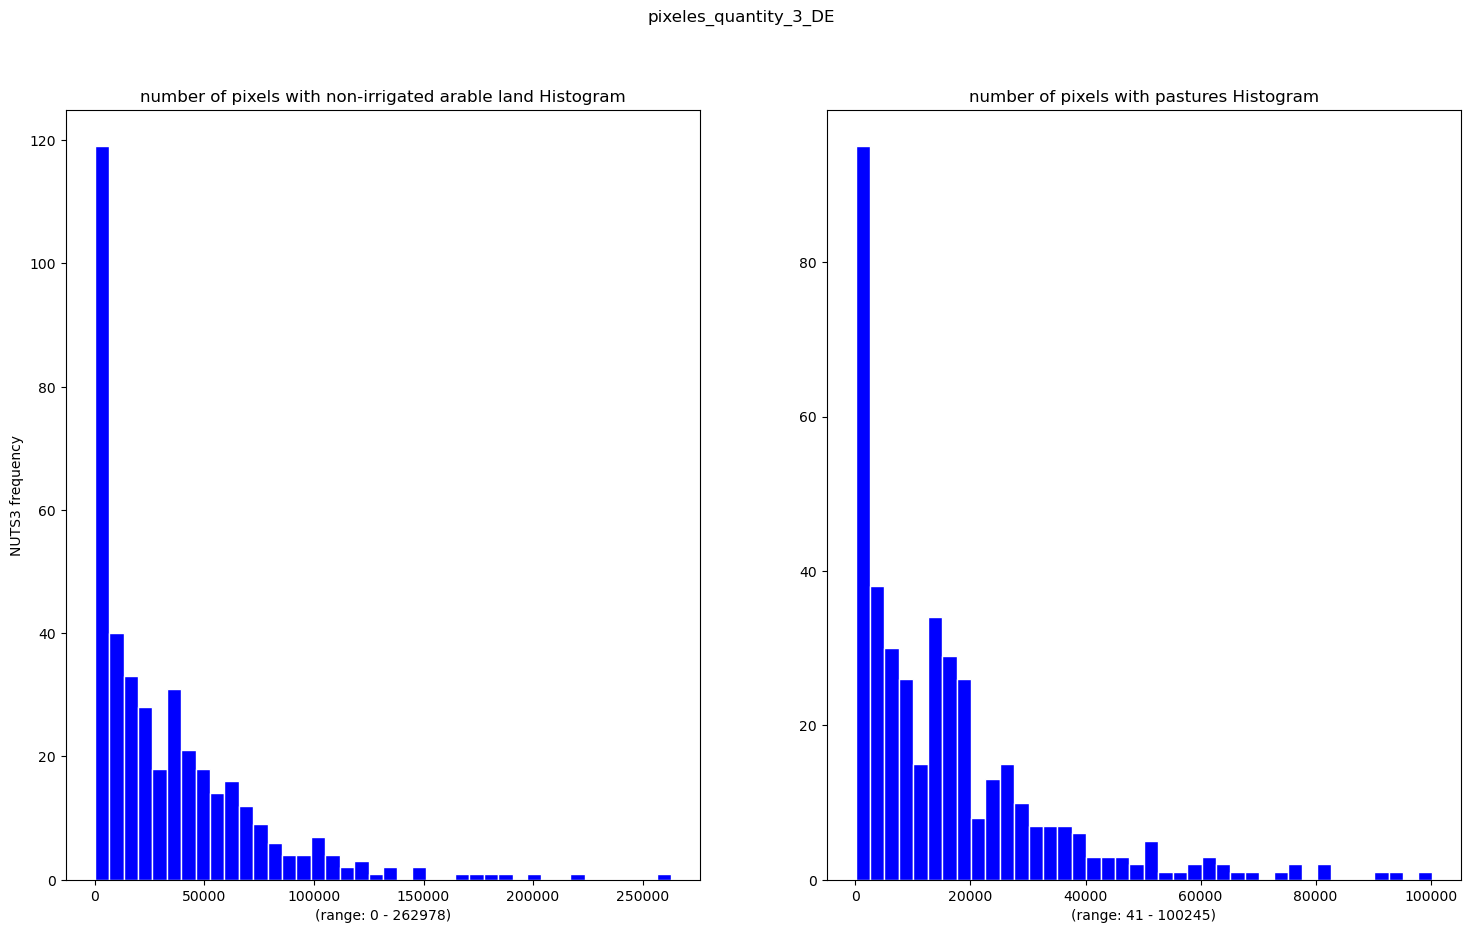

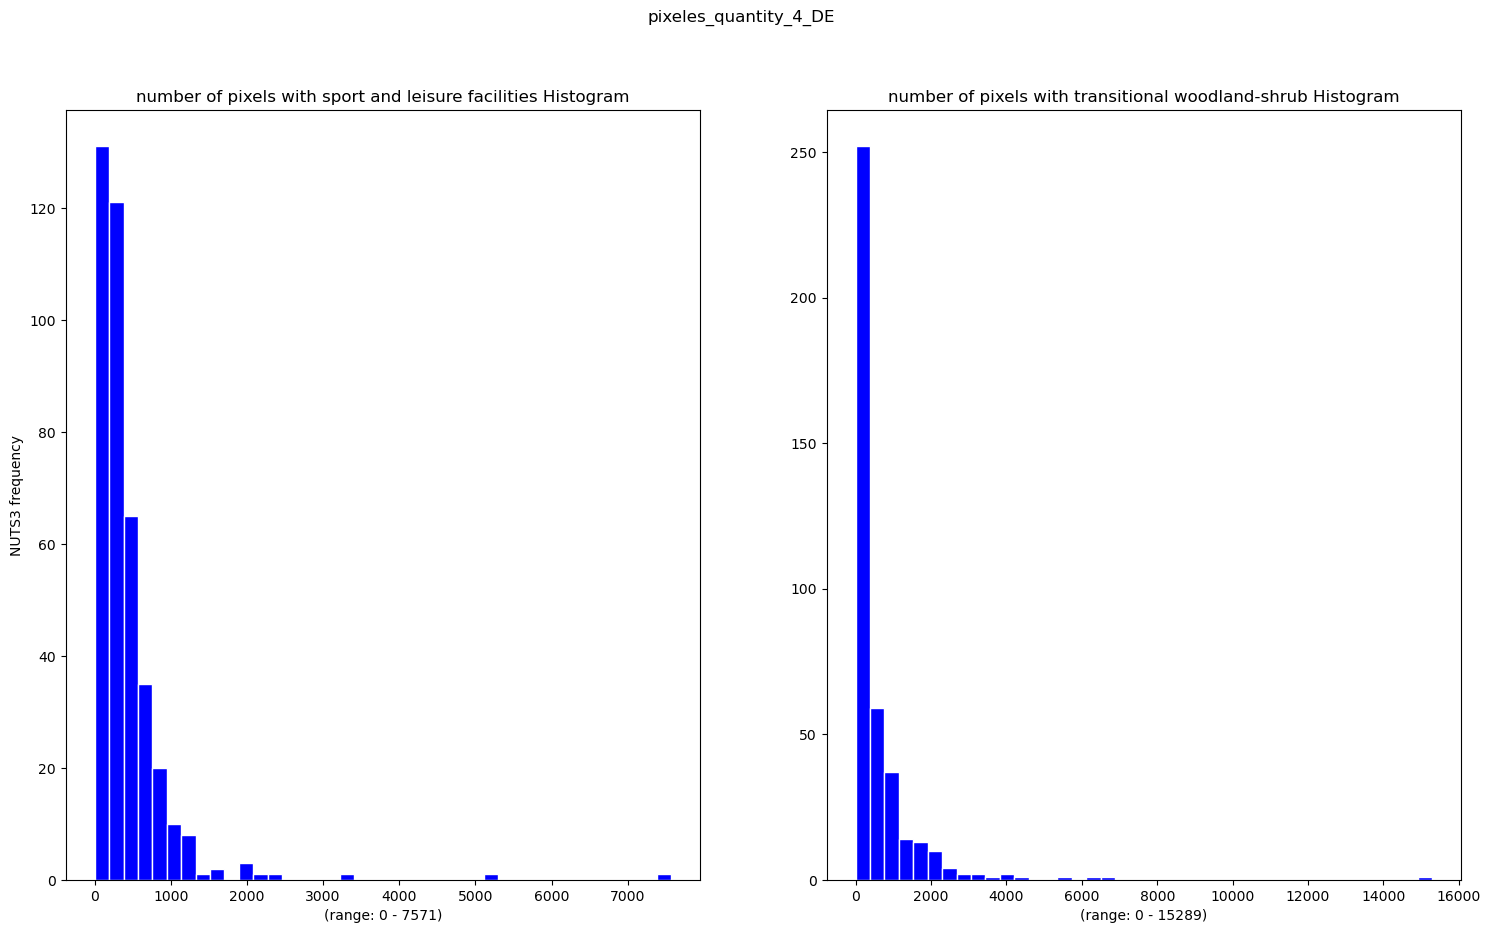

No columns found for figure 'industry_electricity_demand'
No columns found for figure 'industry_fuel_demand'
No columns found for figure 'industry_generation_capacity_1'
No columns found for figure 'industry_generation_capacity_2'
No columns found for figure 'industry_plants_quantity_1'
No columns found for figure 'industry_plants_quantity_2'
No columns found for figure 'industry_plants_quantity_3'
No columns found for figure 'environmental'


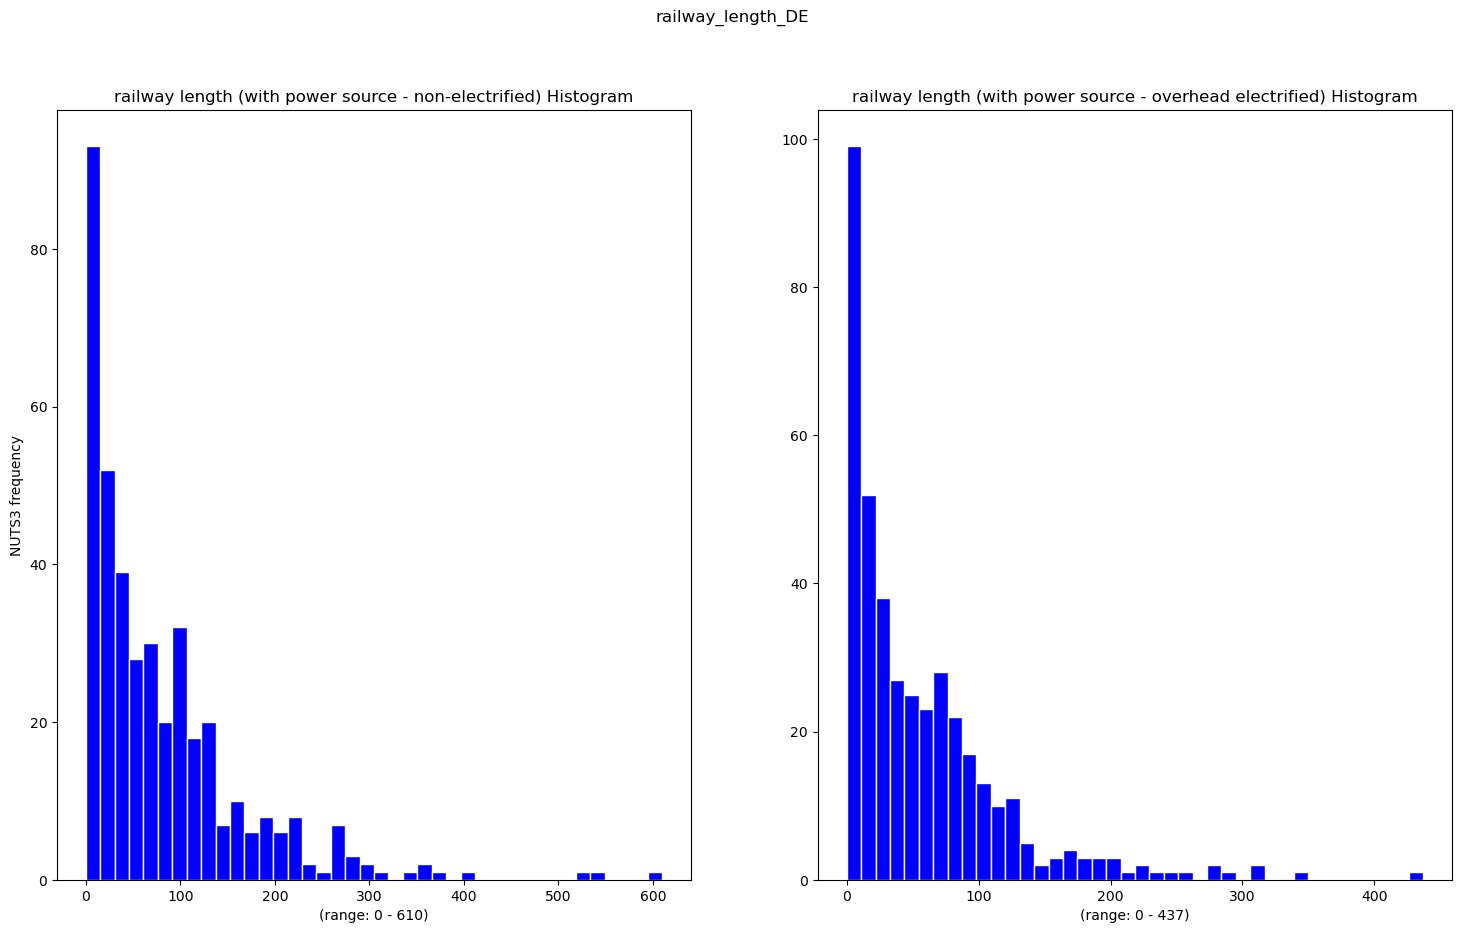

No columns found for figure 'residential_energy_demand'


In [243]:
plot_column_histograms_country(df_country, data_col_dic_hist, fig_size=(18, 10))

### Feaure Engineering II

#### Interaction features
        Create new features by combining two or more existing features.

##### EU

In [244]:
df_scaled_eu.shape

(1170, 82)

In [245]:
df_scaled_eu.head()

deaths_value  electricity demand of non-metallic mineral industries_value  \
0     -0.856020                                                    -0.398209   
1     -0.557523                                                    -0.398209   
2     -0.688070                                                    -0.398209   
3     -0.384195                                                    -0.160004   
4     -0.294719                                                     0.125841   

   electricity demand of paper and printing industries_value  \
0                                                  -0.302859   
1                                                  -0.252768   
2                                                  -0.302859   
3                                                   0.398407   
4                                                   0.936446   

   employment in nace sector G-I_value  Distance_from_origin_region_to_E_road  \
0                            -0.547445                               0.068950   
1                            -0.547445                              -0.055208   
2                            -0.547445                              -0.075900   
3                            -0.547445                              -0.148326   
4                            -0.547445                               0.172414   

   Distance_within_E_road  Distance_from_E_road_to_destination_region  \
0               -1.438017                                   -1.413416   
1               -0.485864                                    0.374186   
2               -0.543953                                    0.599514   
3               -0.599516                                    0.329120   
4               -0.415147                                    0.314098   

   Total_distance  Traffic_flow_trucks_2010  Traffic_flow_trucks_2019  \
0       -1.505622                 -0.884206                 -0.959712   
1       -0.397619                 -0.443609                 -0.497855   
2       -0.420559                 -0.588960                 -0.659174   
3       -0.528377                  0.115085                  0.085544   
4       -0.292095                  0.221828                  0.198246   

   Traffic_flow_trucks_2030  Traffic_flow_tons_2010  Traffic_flow_tons_2019  \
0                 -0.994390               -0.884397               -0.960586   
1                 -0.550908               -0.444368               -0.498150   
2                 -0.716500               -0.588985               -0.658199   
3                  0.002969                0.114561                0.085175   
4                  0.109557                0.222439                0.197941   

   Traffic_flow_tons_2030  \
0               -0.994047   
1               -0.551525   
2               -0.716107   
3                0.002396   
4                0.109598   

   fuel demand of non-metallic mineral industries_value  \
0                                             -0.416184   
1                                             -0.416184   
2                                             -0.416184   
3                                             -0.073729   
4                                              0.253160   

   fuel demand of paper and printing industries_value  \
0                                           -0.311297   
1                                           -0.239821   
2                                           -0.311297   
3                                            0.659172   
4                                            0.697990   

   generation capacity of fossil gas plants_value  \
0                                       -0.348298   
1                                       -0.348298   
2                                       -0.348298   
3                                       -0.348298   
4                                       -0.348298   

   gross domestic product_value  gross value added in nace sector G-I_value  \
0                     -0.5

In [246]:
# df_scaled_eu.loc[:, 'deaths_per_person'] = df_scaled_eu['deaths_value'] / df_scaled_eu['population_value']
# df_scaled_eu.loc[:, 'fuel_stations_per_gdp'] = df_scaled_eu['fuel_stations_value'] / df_scaled_eu['gross domestic product_value']
# df_scaled_eu.loc[:, 'total area_value_times_population_value'] = df_scaled_eu['total area_value'] * df_scaled_eu['population_value']
# df_scaled_eu.drop([
#     'deaths_value',
#     'fuel_stations_value',
#         'total area_value'
#             ], axis=1, inplace=True)

In [247]:
df_scaled_eu.shape

(1170, 82)

##### Country

In [248]:
# df_scaled_country.loc[:, 'deaths_per_person'] = df_scaled_country['deaths_value'] / df_scaled_country['population_value']
# df_scaled_country.loc[:, 'fuel_stations_per_gdp'] = df_scaled_country['fuel_stations_value'] / df_scaled_country['gross domestic product_value']
# df_scaled_country.loc[:, 'total area_value_times_population_value'] = df_scaled_country['total area_value'] * df_scaled_country['population_value']
# df_scaled_country.drop([
#     'deaths_value',
#     'fuel_stations_value',
#         'total area_value'
#             ], axis=1, inplace=True)

In [249]:
df_scaled_country.shape

(401, 46)

#### Polynomial features

        Create new features by raising existing features to a power. This can help capture non-linear relationships in the data.

        Since we are using PolynomialFeatures with degree=2, it creates all pairwise interactions between the 20 randomly selected features, as well as their squared values. This results in a total of 20 + 20*(20-1)/2 = 20 + 190 = 210 new features

        Function that creates polynomial features for randomly selected pairs of features and appends them to the original dataframe with unique names:

##### EU

In [2354]:
features_list = []
# assuming your DataFrame is called 'df'
for col in df_scaled_country.columns:
    features_list.append(col)

In [2355]:
# import random
# import itertools
# import pandas as pd
# from sklearn.preprocessing import PolynomialFeatures

# # Set a seed for reproducibility
# random.seed(42)

# # Compute the common columns in both DataFrames
# common_columns = list(set(df_scaled_eu.columns) & set(df_scaled_country.columns))

# # Generate all possible pairs of features
# feature_pairs = list(itertools.combinations(common_columns, 2))

# # Randomly pick 20 feature pairs
# selected_feature_pairs = random.sample(feature_pairs, 40)

# # Initialize a list to store the new features
# new_poly_features = []

# # Iterate through the selected feature pairs and create polynomial features
# for pair in selected_feature_pairs:
#     # Create a PolynomialFeatures object with degree=2
#     poly = PolynomialFeatures(degree=2, include_bias=False)

#     # Fit and transform the selected feature pair
#     poly_features = poly.fit_transform(df_scaled_eu[list(pair)])
#     poly_features_2 = poly.fit_transform(df_scaled_country[list(pair)])

#     # Extract the interaction term from the polynomial features
#     interaction_feature = poly_features[:, -1]
#     interaction_feature_2 = poly_features_2[:, -1]

#     # Create a new feature name by combining the feature pair names
#     interaction_feature_name = f"{pair[0]}_{pair[1]}_interaction"

#     # Add the interaction feature to the dataframe
#     df_scaled_eu[interaction_feature_name] = interaction_feature
#     df_scaled_country[interaction_feature_name] = interaction_feature_2

#     # Append the new feature name to the list of new features
#     new_poly_features.append(interaction_feature_name)

In [2356]:
# new_poly_features

In [2357]:
df_scaled_eu.shape

(1170, 82)

In [2358]:
df_scaled_country.shape

(401, 46)

#### Log transformations

        Apply log transformations to skewed continuous features to make them more normally distributed, which can improve model performance.

        Applying a log transformation to features can be helpful when you have data that is highly skewed or when the relationships between features and the target variable are nonlinear. However, it is not always necessary or beneficial to apply log transformations to all features. If some features already have a normal distribution or if the relationships between them and the target variable are linear, log transformations might not be useful.

        Before applying a log transformation, it's a good idea to analyze the distribution of your features and the relationships with the target variable. You can use histograms, box plots, or scatter plots to visually explore the data. If you find that some features could benefit from a log transformation, you can apply it selectively.

        It could be better to first analyze the distribution of the features and only apply the log transformation to those with high skewness. In this version of the function, skewness is calculated for each feature, and only those with skewness greater than a specified threshold (default value of 1.0) are considered for log transformation. If there are more skewed features than the desired number to transform, the function randomly selects a subset of them:

In [2359]:
features_list_for_log_transformation = []
# assuming your DataFrame is called 'df'
for col in df_scaled_eu.columns:
    features_list_for_log_transformation.append(col)

In [2360]:
features_list_for_log_transformation_country = []
# assuming your DataFrame is called 'df'
for col in df_scaled_country.columns:
    features_list_for_log_transformation_country.append(col)

In [2361]:
# import numpy as np
# import random
# from scipy.stats import skew

# def log_transform_skewed_features(df, features_list, skewed_features, seed=42, epsilon=1e-6):
    
#     # If there are more skewed features than 30% of all features, select a random subset of 'int(len(features_list) / 2' size
#     n_features_to_transform = int(len(features_list) * 0.8)
#     if len(skewed_features) > int(0.3 * len(features_list)):
#         random.seed(seed)  # Set a seed for reproducibility
#         skewed_features = random.sample(skewed_features, min(n_features_to_transform, len(skewed_features)))
    
#     # Apply log transformation to the skewed features
#     for feature in skewed_features:
#         # Shift the values by adding the absolute minimum value plus a small constant
#         shifted_values = df[feature] - df[feature].min() + epsilon
#         # Apply log transformation
#         log_transformed = np.log1p(shifted_values)
#         # Replace NaN values with 0
#         log_transformed = np.nan_to_num(log_transformed, nan=0)
#         df[f"{feature}_log"] = log_transformed
        
#     # Remove the columns you want to keep from the list of skewed_features
#     columns_to_keep = {'population_value', 'charging_stations_value', 'deaths_per_person', 'fuel_stations_per_gdp', 'total area_value_times_population_value'}
#     skewed_features = [column for column in skewed_features if column not in columns_to_keep]
        
#     # Drop the skewed features except for the ones you want to keep
#     df = df.drop(columns=skewed_features)
    
#     return df

# # Calculate skewness of each feature for both dataframes
# skewness_eu = df_scaled_eu[features_list_for_log_transformation].apply(lambda x: skew(x))
# skewness_country = df_scaled_country[features_list_for_log_transformation_country].apply(lambda x: skew(x))

# # Filter features with skewness greater than the threshold
# skewed_features_eu = skewness_eu[skewness_eu > 1.0].index.tolist()
# skewed_features_country = skewness_country[skewness_country > 1.0].index.tolist()

# # Get the same random 30% number of features for both EU and Germany
# common_skewed_features = list(set(skewed_features_eu) & set(skewed_features_country))

# # Example usage: Apply log transformation to skewed features
# df_scaled_eu = log_transform_skewed_features(df_scaled_eu, features_list_for_log_transformation, common_skewed_features)
# df_scaled_country = log_transform_skewed_features(df_scaled_country, features_list_for_log_transformation_country, common_skewed_features)


In [2362]:
df_scaled_eu.shape

(1170, 82)

In [2363]:
df_scaled_country.shape

(401, 46)

        Skewness greater than 1 indicates that the distribution of the feature is highly skewed to the right (i.e., the tail of the distribution is longer on the right side). In other words, the feature has a large number of low values and a few extremely high values. This can be problematic for some machine learning algorithms because they assume that the data is normally distributed or at least symmetrically distributed around the mean. Therefore, log transformation can be applied to these skewed features to make their distribution more symmetric and improve the performance of the model.

### Variance Inflation Factor (VIF)

##### EU

In [2364]:
def calculate_vif_initial(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             'vif_df_sorted_eu_data_initial.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]
    
    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})
    
    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    return vif_df_sorted


In [2365]:
vif_df_sorted_eu = calculate_vif_initial(df_scaled_eu)

In [2366]:
vif_df_sorted_eu

Variable  \
13                                           Traffic_flow_tons_2030   
10                                         Traffic_flow_trucks_2030   
12                                           Traffic_flow_tons_2019   
9                                          Traffic_flow_trucks_2019   
11                                           Traffic_flow_tons_2010   
8                                          Traffic_flow_trucks_2010   
7                                                    Total_distance   
5                                            Distance_within_E_road   
4                             Distance_from_origin_region_to_E_road   
6                        Distance_from_E_road_to_destination_region   
17                                     gross domestic product_value   
19                                          gross value added_value   
65                                                 population_value   
80                                           total employment_value   
20                                                live births_value   
0                                                      deaths_value   
81                                 total number of businesses_value   
26                                 number of large businesses_value   
18                       gross value added in nace sector G-I_value   
3                               employment in nace sector G-I_value   
70                                              fuel_stations_value   
35                    number of pixels with coniferous forest_value   
64                                 number of small businesses_value   
79                                                 total area_value   
42       number of pixels with industrial or commercial units_value   
38           number of pixels with discontinuous urban fabric_value   
51                            number of pixels with peat bogs_value   
60          number of pixels with transitional woodland-shrub_value   
2         electricity demand of paper and printing industries_value   
15               fuel demand of paper and printing industries_value   
22                                           railways_network_value   
14             fuel demand of non-metallic mineral industries_value   
1       electricity demand of non-metallic mineral industries_value   
62                         number of pixels with water bodies_value   
58             number of pixels with sparsely vegetated areas_value   
75                                            railway_station_value   
73                                               bus_stations_value   
31                           number of pixels with bare rocks_value   
23                                         road_major_network_value   
46                  number of pixels with moors and heathland_value   
25                                number of fossil gas plants_value   
45                         number of pixels with mixed forest_value   
16                   generation capacity of fossil gas plants_value   
37              number of pixels with continuous urban fabric_value   
48            number of pixels with non-irrigated arable land_value   
33                  number of pixels with broad-leaved forest_value   
74                                           airport_stations_value   
63                        number of pixels with water courses_value   
41                    number of pixels with green urban areas_value   
54               number of pixels with road and rail networks_value   
76                                              train_station_value   
27                  number of non-metallic mineral industries_value   
47                   number of pixels with natural grasslands_value   
56            number of pixels with sclerophyllous vegetation_value   
29  number of pixels with agriculture with natural vegetation_value   
67  railway length (with power source - overhead electrified)_value   
72          

In [2367]:
def select_features_vif(new_df, vif_df_sorted):
    # Select variables with VIF less than 10
    vif_df_subset = vif_df_sorted[vif_df_sorted['VIF'] < 10]
    
    # Manually select additional features
    selected_features = [
        'population_value', 'gross domestic product_value', 'Traffic_flow_tons_2019', 'total employment_value', 'live births_value',
        # 'deaths_value',
        'total area_value', 'fuel_stations_value'
    # 'population_value', 'charging_stations_value', 'deaths_per_person', 'fuel_stations_per_gdp', 'total area_value_times_population_value'
    ]
    # Combine the two lists of features and drop any duplicates
    all_features = list(set(list(vif_df_subset['Variable']) + selected_features))
    
    # Remove additional columns
    remove_features = [
        'relative gross value added_value'
        ]
    all_features = [feature for feature in all_features if feature not in remove_features]
    
    # Create a new dataframe with only the selected features
    df_selected = new_df[all_features]
    
    return df_selected

In [2368]:
df_selected_eu = select_features_vif(df_scaled_eu, vif_df_sorted_eu)

In [2369]:
df_selected_eu.shape

(1170, 61)

In [2370]:
def calculate_vif_final(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             'vif_df_sorted_eu_data_final.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]
    
    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})
    
    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    return vif_df_sorted

In [2371]:
vif_df_eu = calculate_vif_final(df_selected_eu)

In [2372]:
vif_df_eu

Variable     VIF
53                                                 population_value 59.3197
0                                            total employment_value 35.4070
24                                                live births_value 32.8023
42                                              fuel_stations_value 12.5263
30                                     gross domestic product_value 11.7605
16                                                 total area_value 11.7592
31               fuel demand of paper and printing industries_value  8.4948
1         electricity demand of paper and printing industries_value  8.4365
17             fuel demand of non-metallic mineral industries_value  7.9269
7       electricity demand of non-metallic mineral industries_value  7.5242
52          number of pixels with transitional woodland-shrub_value  7.2229
45             number of pixels with sparsely vegetated areas_value  6.8493
10                                            railway_station_value  6.7962
57                                         road_major_network_value  6.4583
34                           number of pixels with bare rocks_value  6.4336
5                                            railways_network_value  6.1810
9                    generation capacity of fossil gas plants_value  5.9106
37                         number of pixels with mixed forest_value  5.8913
11                                               bus_stations_value  5.6591
18                                number of fossil gas plants_value  5.6546
58              number of pixels with continuous urban fabric_value  5.5901
26                  number of pixels with moors and heathland_value  5.5576
48                         number of pixels with water bodies_value  5.2236
33                                           airport_stations_value  4.1548
35                  number of pixels with broad-leaved forest_value  3.9954
56                    number of pixels with green urban areas_value  3.8645
12               number of pixels with road and rail networks_value  3.7670
32                  number of non-metallic mineral industries_value  3.7612
28                        number of pixels with water courses_value  3.7390
43            number of pixels with non-irrigated arable land_value  3.6670
22                                              train_station_value  3.6563
40                   number of pixels with natural grasslands_value  3.5736
59            number of pixels with sclerophyllous vegetation_value  3.4721
6   number of pixels with agriculture with natural vegetation_value  3.4415
4   railway length (with power source - overhead electrified)_value  3.2919
3                              number of pixels with airports_value  3.0453
19                                         helicopter_station_value  2.9954
38         number of pixels with complex cultivation patterns_value  2.9643
29                                           bicycle_stations_value  2.9515
20                                          charging_stations_value  2.8077
8                            number of pixels with dump sites_value  2.6213
36         number of pixels with sport and leisure facilities_value  2.5829
44                   number of pixels with construction sites_value  2.5306
39                            number of pixels with vineyards_value  2.4830
49    number of pixels with fruit trees and berry plantations_value  2.3397
23                           number of pixels with port areas_value  2.1294
41                         number of pixels with salt marshes_value  2.0272
46           number of pixels with permanently irrigated land_value  1.9686
14                             number of pixels with pastures_value  1.9595
21       railway length (with power source - non-electrified)_value  1.8838
51             number of pixels with mineral extraction sites_value  1.8814
50                                           shipping_network_value  1.8736
15                        numbe

In [2375]:
df_selected_eu.shape

(1170, 61)

##### Country

In [2377]:
def calculate_vif_initial(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             f'vif_df_sorted_{region}_data_initial.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]
    
    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})
    
    # Remove rows with infinite VIF values
    vif_df = vif_df.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    
    return vif_df_sorted


In [2378]:
vif_df_sorted_country = calculate_vif_initial(df_scaled_country)

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [2379]:
vif_df_sorted_country

Variable  \
45                                                   Trailers Total   
43                                                Load Force Wagons   
44                                                   Trailers Other   
12                                          gross value added_value   
11                                     gross domestic product_value   
9                                            Traffic_flow_tons_2019   
8                                            Traffic_flow_tons_2010   
10                                           Traffic_flow_tons_2030   
7                                          Traffic_flow_trucks_2030   
6                                          Traffic_flow_trucks_2019   
5                                          Traffic_flow_trucks_2010   
4                                                    Total_distance   
2                                            Distance_within_E_road   
3                        Distance_from_E_road_to_destination_region   
24                                                 population_value   
13                                                live births_value   
1                             Distance_from_origin_region_to_E_road   
35                                                 total area_value   
37                                                      Motorcylces   
36                                           total employment_value   
0                                                      deaths_value   
20            number of pixels with non-irrigated arable land_value   
38                                            Agricultural Tractors   
15                    number of pixels with coniferous forest_value   
21                             number of pixels with pastures_value   
17           number of pixels with discontinuous urban fabric_value   
39                                                            Buses   
28                                              fuel_stations_value   
14                  number of pixels with broad-leaved forest_value   
18       number of pixels with industrial or commercial units_value   
32                                            railway_station_value   
22         number of pixels with sport and leisure facilities_value   
33                                              train_station_value   
30                                               bus_stations_value   
16              number of pixels with continuous urban fabric_value   
29                                          charging_stations_value   
25       railway length (with power source - non-electrified)_value   
26  railway length (with power source - overhead electrified)_value   
19                         number of pixels with mixed forest_value   
34                                         helicopter_station_value   
31                                           airport_stations_value   
23          number of pixels with transitional woodland-shrub_value   
27                                 relative gross value added_value   

                VIF  
45 14213373017.0298  
43  7199274297.5056  
44  5095489092.6253  
12  1081358350.8613  
11  1081328492.5425  
9     58798393.5406  
8     19670086.9267  
10    13876793.4249  
7      1773870.3872  
6      1031400.3637  
5       750920.5004  
4       254904.6998  
2       177021.8642  
3        10043.1381  
24        1111.5063  
13         540.4822  
1          443.3784  
35         419.7609  
37         334.2600  
36         236.5538  
0          143.0148  
20         124.2906  
38          51.5560  
15          31.8251  
21          29.0815  
17          21.0506  
39          18.3086  
28          14.9131  
14           9.5532  
18           8.9500  
32           7.6875  
22           6.7224  
33           6.5835  
30           6.1802  
16           5.7540  
29           5.1411  
25           4.6591  
26           3.9933  
19           3.9881  
34           2.6656  
31           2.1038  
23        

In [2380]:
len(vif_df_sorted_country)

43

In [2381]:
def select_features_vif(new_df, vif_df_sorted):
    # Select variables with VIF less than 10
    vif_df_subset = vif_df_sorted[vif_df_sorted['VIF'] < 10000000000000000]
    
    # Manually select additional features
    selected_features = [
        'population_value', 'gross domestic product_value', 'Traffic_flow_tons_2019', 'total employment_value', 'live births_value', 
        # 'deaths_value', 
        'total area_value', 'fuel_stations_value', 'Buses', 'gross value added_value'
    # 'population_value', 'charging_stations_value', 'deaths_per_person', 'fuel_stations_per_gdp', 'total area_value_times_population_value',
    ]
    # Combine the two lists of features and drop any duplicates
    all_features = list(set(list(vif_df_subset['Variable']) + selected_features))
    
    # Remove additional columns
    remove_features = [
    ]
    all_features = [feature for feature in all_features if feature not in remove_features]
    
    # Create a new dataframe with only the selected features
    df_selected = new_df[all_features]
    
    return df_selected

In [2382]:
df_selected_country = select_features_vif(df_scaled_country, vif_df_sorted_country)

In [2383]:
df_selected_country.shape

(401, 43)

In [2384]:
def calculate_vif_final(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             f'vif_df_sorted_{region}_data_final.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]
    
    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})
    
    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    return vif_df_sorted

In [2385]:
vif_df_country = calculate_vif_final(df_selected_country)

In [2386]:
vif_df_country

Variable  \
40                                                   Trailers Total   
35                                                Load Force Wagons   
31                                                   Trailers Other   
11                                          gross value added_value   
20                                     gross domestic product_value   
42                                           Traffic_flow_tons_2019   
24                                           Traffic_flow_tons_2010   
10                                           Traffic_flow_tons_2030   
39                                         Traffic_flow_trucks_2030   
8                                          Traffic_flow_trucks_2019   
26                                         Traffic_flow_trucks_2010   
19                                                   Total_distance   
34                                           Distance_within_E_road   
14                       Distance_from_E_road_to_destination_region   
38                                                 population_value   
15                                                live births_value   
32                            Distance_from_origin_region_to_E_road   
9                                                  total area_value   
1                                            total employment_value   
4                                                      deaths_value   
33            number of pixels with non-irrigated arable land_value   
29                    number of pixels with coniferous forest_value   
7                              number of pixels with pastures_value   
16                                                      Motorcylces   
0            number of pixels with discontinuous urban fabric_value   
3                                                             Buses   
30                                              fuel_stations_value   
25                  number of pixels with broad-leaved forest_value   
36       number of pixels with industrial or commercial units_value   
5                                             railway_station_value   
27         number of pixels with sport and leisure facilities_value   
17                                              train_station_value   
41                                            Agricultural Tractors   
6                                                bus_stations_value   
22              number of pixels with continuous urban fabric_value   
13                                          charging_stations_value   
18       railway length (with power source - non-electrified)_value   
28                         number of pixels with mixed forest_value   
2   railway length (with power source - overhead electrified)_value   
12                                         helicopter_station_value   
23                                           airport_stations_value   
37          number of pixels with transitional woodland-shrub_value   
21                                 relative gross value added_value   

                VIF  
40 14146914911.0886  
35  7165552058.0845  
31  5071652614.2566  
11  1068900646.2678  
20  1068877687.2050  
42    58604993.1959  
24    19634159.7070  
10    13799502.2076  
39     1754170.2406  
8      1028768.1765  
26      745278.2472  
19      253280.2404  
34      175895.8653  
14        9980.2941  
38        1070.9060  
15         528.1309  
32         440.9714  
9          419.6821  
1          234.9064  
4          140.6649  
33         123.9747  
29          31.7721  
7           29.0762  
16          21.1282  
0           20.5719  
3           14.0891  
30          13.9889  
25           9.3717  
36           8.8831  
5            7.6689  
27           6.5799  
17           6.3045  
41           6.1634  
6            5.9893  
22           5.7348  
13           5.1329  
18           4.0012  
28           3.9206  
2            3.6264  
12           2.6280  
23           2.0851  
37        

In [2390]:
df_selected_country.shape

(401, 43)

#### Keep the intersection of the columns of the training and test data

In [2391]:
def keep_intersected_columns(df1, df2):
    intersected_columns = list(set(df1.columns).intersection(set(df2.columns)))
    df1_intersected = df1[intersected_columns]
    df2_intersected = df2[intersected_columns]
    return df1_intersected, df2_intersected

In [2392]:
df_inter_country, df_inter_eu = keep_intersected_columns(df_selected_country, df_selected_eu)

In [2393]:
df_inter_country.shape

(401, 22)

In [2394]:
df_inter_eu.shape

(1170, 22)

In [2395]:
def calculate_vif_intersected(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             'vif_df_sorted_eu_data_intersected_final.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]
    
    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})
    
    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    return vif_df_sorted

In [2396]:
vif_df_eu_intersected = calculate_vif_intersected(df_inter_eu)

In [2397]:
vif_df_eu_intersected

Variable     VIF
19                                                 population_value 47.6037
0                                            total employment_value 30.8715
9                                                 live births_value 24.6078
16                                              fuel_stations_value  9.0931
11                                     gross domestic product_value  8.7635
5                                                  total area_value  5.5242
18          number of pixels with transitional woodland-shrub_value  5.3897
2                                             railway_station_value  4.3554
3                                                bus_stations_value  4.2602
12                                           airport_stations_value  3.6223
15                         number of pixels with mixed forest_value  3.4790
20              number of pixels with continuous urban fabric_value  3.1442
10                                              train_station_value  2.9516
13                  number of pixels with broad-leaved forest_value  2.4267
17            number of pixels with non-irrigated arable land_value  2.2987
7                                           charging_stations_value  2.1930
6                                          helicopter_station_value  2.1904
1   railway length (with power source - overhead electrified)_value  2.1005
14         number of pixels with sport and leisure facilities_value  1.9221
21                                           Traffic_flow_tons_2019  1.5937
8        railway length (with power source - non-electrified)_value  1.5563
4                              number of pixels with pastures_value  1.4605

In [2398]:
def calculate_vif_intersected_country(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             'vif_df_sorted_country_data_intersected_final.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]
    
    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})
    
    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    return vif_df_sorted

In [2399]:
vif_df_country_intersected = calculate_vif_intersected_country(df_inter_country)

In [2400]:
vif_df_country_intersected

Variable      VIF
19                                                 population_value 284.8150
9                                                 live births_value 265.4659
0                                            total employment_value 178.1253
11                                     gross domestic product_value  64.7908
5                                                  total area_value  28.3668
17            number of pixels with non-irrigated arable land_value  13.2651
16                                              fuel_stations_value  11.0459
2                                             railway_station_value   6.8674
3                                                bus_stations_value   5.4274
10                                              train_station_value   4.8814
7                                           charging_stations_value   4.7921
4                              number of pixels with pastures_value   4.7331
14         number of pixels with sport and leisure facilities_value   4.5460
20              number of pixels with continuous urban fabric_value   4.4704
8        railway length (with power source - non-electrified)_value   3.3892
21                                           Traffic_flow_tons_2019   3.0013
1   railway length (with power source - overhead electrified)_value   2.8818
6                                          helicopter_station_value   2.3759
12                                           airport_stations_value   1.8680
18          number of pixels with transitional woodland-shrub_value   1.8446
13                  number of pixels with broad-leaved forest_value   1.6904
15                         number of pixels with mixed forest_value   1.6741

In [2401]:
df_inter_eu.shape

(1170, 22)

### Correlation Matrix

#### EU

In [2402]:
def get_pearson_product_momen_correlation_coefficient(df):
    """
    Generate a list of the most and least correlated variables in a DataFrame, along with their correlation scores.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        A tuple containing two lists of (variable, correlation score) tuples, one for the most correlated variables and one for the least correlated variables.
    """
    # Compute correlation matrix for entire DataFrame
    corr_matrix = df.corr(numeric_only=True)

    # Compute mean absolute correlation for each variable
    corr_means = corr_matrix.mean(axis=1)

    # Sort variables by correlation score, from most to least correlated
    most_correlated = corr_means.sort_values(ascending=False)

    # Reverse the order to get least to most correlated
    least_correlated = most_correlated.iloc[::-1]

    # Create list of (variable, correlation score) tuples for most and least correlated variables
    most_correlated_list = [(var, score) for var, score in most_correlated.items()]
    most_correlated_list_column = [(var) for var in most_correlated.keys()]
    least_correlated_list = [(var, score) for var, score in least_correlated.items()]
    least_correlated_list_column = [(var) for var in least_correlated.keys()]

    return (most_correlated_list, most_correlated_list_column, least_correlated_list, least_correlated_list_column)

        In this function, we first compute the correlation matrix for the entire DataFrame and compute the mean absolute correlation for each variable using the mean() method on the axis=1. We then sort the variables by their correlation score, from most to least correlated, and reverse the order to get the least to most correlated.

        Finally, we create a list of tuples for the most and least correlated variables using list comprehension and the iteritems() method to iterate over the sorted series. We return a tuple containing the two lists of (variable, correlation score) tuples. You can use this function to get the most and least correlated variables in any DataFrame by passing it as an argument.

        corr_matrix.abs().mean(axis=1) calculates the mean absolute correlation of each variable in the DataFrame. Here's a step-by-step explanation of how this calculation works:

                1. corr_matrix is the correlation matrix of the DataFrame, where each element in the matrix represents the correlation coefficient between two variables in the DataFrame.
                2.corr_matrix.abs() takes the absolute value of each element in the correlation matrix, so that all correlation coefficients are positive.
                3. corr_matrix.abs().mean(axis=1) calculates the mean of each row in the absolute correlation matrix. Since each row in the matrix corresponds to a variable in the DataFrame, this effectively computes the mean absolute correlation for each variable in the DataFrame.
                4. The resulting series contains the mean absolute correlation score for each variable in the DataFrame.
        So, mathematically, corr_means = corr_matrix.abs().mean(axis=1) is equivalent to computing the mean absolute correlation score for each variable in the DataFrame. This metric can be used to rank the variables by their overall level of correlation with other variables in the DataFrame, regardless of the direction of the correlation (positive or negative).

In [2403]:
def create_correlation_dataframe_eu(most_correlated_list, dataframe_title_eu):
    """
    Create a dataframe from the list of (variable, correlation score) tuples.

    Parameters:
        most_correlated_list (list): A list of (variable, correlation score) tuples.

    Returns:
        A pandas dataframe with two columns: 'Variable' and 'Correlation Score'.
    """
    df = pd.DataFrame(most_correlated_list, columns=['Variable', 'Correlation Score'])
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'correlation_matrix',
                                             'EU',
                                             f"{dataframe_title_eu}.csv")
    df.to_csv(file_path_destination, index=False)
    return df


        This function takes a DataFrame and a list of most correlated variable names and plots the correlation matrix for those variables. The function creates a new DataFrame containing only the most correlated variables, computes the correlation matrix for that DataFrame, and plots the matrix using seaborn's heatmap function.

        The line of code "sublists = [most_correlated_list[i:i+20] for i in range(0, len(most_correlated_list), 20)]" uses list comprehension to split a list of variables (most_correlated_list) into sublists of length 20. Here's what each part of the expression does:

        most_correlated_list: The original list of variables that we want to split into sublists of length 20.
        [most_correlated_list[i:i+20]: This is a slice that extracts a sublist of 20 variables starting at the i-th index and ending at the (i+20)-th index. By incrementing i by 20 for each iteration of the loop, we are able to extract non-overlapping sublists of 20 variables each.
        for i in range(0, len(most_correlated_list), 20)]: This is a loop that iterates over the indices of the original list in increments of 20. The range function generates a sequence of indices from 0 to the length of the original list, incrementing by 20 for each iteration. For example, if the length of the original list is 80, the loop would iterate over the indices 0, 20, 40, and 60.

In [2404]:
df_inter_eu.shape

(1170, 22)

In [2405]:
def plot_most_correlated_eu(dataframe, most_correlated_list, fig_size=(20, 8)):
    """
    Plot a correlation matrix for the most correlated columns in a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    most_correlated_list (list): A list of column names to include in the correlation matrix.
    fig_size (tuple): The size of the figure in inches (default: (8, 6)).

    Returns:
    None
    """
    # Split list of most correlated variables into sublists of length 20
    sublists = [most_correlated_list[i:i+10] for i in range(0, len(most_correlated_list), 10)]

    # Plot correlation matrix for each sublist of variables
    for i, sublist in enumerate(sublists):
        fig_title = f"Most Correlated Variables {i+1}-{i+len(sublist)} - EU"
        file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'correlation_matrix',
                                             'EU',
                                             f"{fig_title}.png")
        df = dataframe[sublist]
        corr = df.corr()
        print(f"Correlation matrix for {fig_title}:")
        fig, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, ax=ax)
        ax.set_title(f'Correlation Matrix - {fig_title}')

        # Save data to file if it doesn't exist
        plt.savefig(file_path_destination)

        plt.show()

In [2406]:
# dataframe_title_eu = 'Correlation Matrix Analysis EU - with feature selection'
# most_correlated_list, most_correlated_list_column, least_correlated_list, least_correlated_list_column = get_pearson_product_momen_correlation_coefficient(df_inter_eu)
# corr_df_eu = create_correlation_dataframe_eu(most_correlated_list, dataframe_title_eu)

In [2407]:
# corr_df_eu.head(50)

In [2408]:
# plot_most_correlated_eu(df_inter_eu, most_correlated_list_column, fig_size=(20, 8))

#### Country

In [2409]:
def get_pearson_product_momen_correlation_coefficient_country(df):
    """
    Generate a list of the most and least correlated variables in a DataFrame, along with their correlation scores.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        A tuple containing two lists of (variable, correlation score) tuples, one for the most correlated variables and one for the least correlated variables.
    """
    # Compute correlation matrix for entire DataFrame
    corr_matrix = df.corr(numeric_only=True)

    # Compute mean absolute correlation for each variable
    corr_means = corr_matrix.mean(axis=1)

    # Sort variables by correlation score, from most to least correlated
    most_correlated = corr_means.sort_values(ascending=False)

    # Reverse the order to get least to most correlated
    least_correlated = most_correlated.iloc[::-1]

    # Create list of (variable, correlation score) tuples for most and least correlated variables
    most_correlated_list_region = [(var, score) for var, score in most_correlated.items()]
    most_correlated_list_column_region = [(var) for var in most_correlated.keys()]
    least_correlated_list_region = [(var, score) for var, score in least_correlated.items()]
    least_correlated_list_column_region = [(var) for var in least_correlated.keys()]

    return (most_correlated_list_region, most_correlated_list_column_region, least_correlated_list_region, least_correlated_list_column_region)

In [2410]:
def create_correlation_dataframe_country(most_correlated_list, dataframe_title_country):
    """
    Create a dataframe from the list of (variable, correlation score) tuples.

    Parameters:
        most_correlated_list (list): A list of (variable, correlation score) tuples.

    Returns:
        A pandas dataframe with two columns: 'Variable' and 'Correlation Score'.
    """
    df = pd.DataFrame(most_correlated_list, columns=['Variable', 'Correlation Score'])
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'correlation_matrix',
                                             f'{region}',
                                             f"{dataframe_title_country}.csv")
    df.to_csv(file_path_destination, index=False)
    return df


In [2411]:
def plot_most_correlated_country(dataframe, most_correlated_list, region, fig_size=(20, 8)):
    """
    Plot a correlation matrix for the most correlated columns in a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    most_correlated_list (list): A list of column names to include in the correlation matrix.
    fig_size (tuple): The size of the figure in inches (default: (8, 6)).

    Returns:
    None
    """
    # Split list of most correlated variables into sublists of length 20
    sublists = [most_correlated_list[i:i+20] for i in range(0, len(most_correlated_list), 20)]

    # Plot correlation matrix for each sublist of variables
    for i, sublist in enumerate(sublists):
        fig_title = f"Most Correlated Variables {i+1}-{i+len(sublist)} - {region}"
        file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'correlation_matrix',
                                             f'{region}',
                                             f"{fig_title}.png")
        df = dataframe[sublist]
        corr = df.corr()
        print(f"Correlation matrix for {fig_title}:")
        print(corr)
        fig, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, ax=ax)
        ax.set_title(f'Correlation Matrix - {fig_title}')
        
        # Save data to file if it doesn't exist
        plt.savefig(file_path_destination)
        
        plt.show()

In [2412]:
# dataframe_title_country = f'Correlation Matrix Analysis {region} - with feature selection'
# most_correlated_list_region, \
#     most_correlated_list_column_region, \
#     least_correlated_list_region, \
#         least_correlated_list_column_region = get_pearson_product_momen_correlation_coefficient_country(df_inter_country)
# corr_df_country = create_correlation_dataframe_country(most_correlated_list_region, dataframe_title_country)

In [2413]:
# corr_df_country.head(50)

In [2414]:
# plot_most_correlated_country(df_inter_country, most_correlated_list_column_region, region, fig_size=(20, 8))

#### Matrix correlation per group of columns

##### EU

In [2415]:
def plot_correlations_eu(dataframe, col_dict, fig_size=(8, 6)):
    """
    Plot a correlation matrix for multiple sets of columns in a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    col_dict (dict): A dictionary where each key is the name of a set of columns, and each value is a list of column names to include in the correlation matrix.
    fig_size (tuple): The size of the figure in inches (default: (8, 6)).

    Returns:
    None
    """
    for fig_title, col_names in col_dict.items():
        file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                'spatial_disaggregation',
                'data_visualization',
                'correlation_matrix',
                'EU',
                f"{fig_title}_matrix_corr_EU.png")
        # Check if all columns exist in the DataFrame
        missing_cols = set(col_names) - set(dataframe.columns)
        if missing_cols:
            print(f"Columns {missing_cols} not found in the DataFrame, skipping figure '{fig_title}'")
            continue
        # Extract subset of DataFrame and compute correlation matrix
        df = dataframe[col_names].dropna()
        if df.empty:
            print(f"No columns found without NaN values for figure '{fig_title}', skipping")
            continue
        corr = df.corr()
        print(f"Correlation matrix for {fig_title}:")
        print(corr)
        # Plot heatmap
        fig, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, ax=ax)
        ax.set_title(f'Correlation Matrix - {fig_title} - EU')
        
        # Save data to file if it doesn't exist
        if not os.path.exists(file_path_destination):
            plt.savefig(file_path_destination)
        plt.show()


In [2416]:
# plot_correlations_eu(df_eu, data_col_dic, fig_size=(20, 8))

##### Country 

In [2417]:
def plot_correlations_country(dataframe, col_dict, region, fig_size=(10, 5)):
    """
    Plot a correlation matrix for multiple sets of columns in a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    col_dict (dict): A dictionary where each key is the name of a set of columns, and each value is a list of column names to include in the correlation matrix.
    fig_size (tuple): The size of the figure in inches (default: (8, 6)).

    Returns:
    None
    """
    for fig_title, col_names in col_dict.items():
        file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                'spatial_disaggregation',
                'data_visualization',
                'correlation_matrix',
                f'{region}',
                f"{fig_title}_matrix_corr_{region}.png")
        # Check if all columns exist in the DataFrame
        missing_cols = set(col_names) - set(dataframe.columns)
        if missing_cols:
            print(f"Columns {missing_cols} not found in the DataFrame, skipping figure '{fig_title}'")
            continue
        # Extract subset of DataFrame and compute correlation matrix
        df = dataframe[col_names].dropna()
        if df.empty:
            print(f"No columns found without NaN values for figure '{fig_title}', skipping")
            continue
        corr = df.corr()
        print(f"Correlation matrix for {fig_title}-{region}:")
        print(corr)
        # Plot heatmap
        fig, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, ax=ax)
        ax.set_title(f'Correlation Matrix - {fig_title} - {region}')
        
        # Save data to file if it doesn't exist
        if not os.path.exists(file_path_destination):
            plt.savefig(file_path_destination)
        plt.show()

In [2418]:
# plot_correlations_country(df_country, data_col_dic, region, fig_size=(20, 8))

        One reason why some correlation matrices might appear all white is if all the variables in the matrix are uncorrelated with each other, which would result in a diagonal matrix with values of 1.0 on the diagonal and 0.0 everywhere else. In this case, the heatmap would be all white because the correlation values are all close to 0.

        Another possibility is that there might be missing or invalid values in the data that are affecting the correlation calculations. This could result in NaN values in the correlation matrix, which would show up as white cells in the heatmap.

        To investigate further, you can print out the correlation matrices for the sets of columns that are appearing all white, and see if they contain all 1.0 values on the diagonal and NaN values elsewhere. If this is the case, then it is likely that the variables are uncorrelated with each other. If not, then there might be some missing or invalid values that need to be addressed before the correlation calculations can be performed correctly.

### Sensitivity Analysis

#### Whisker plots

##### EU

In [2419]:
column_list_eu = []
# assuming your DataFrame is called 'df'
for col in df_inter_eu.columns:
    column_list_eu.append(col)

In [2420]:
def sensitivity_analysis_eu(df):    
    X = df[column_list_eu]
    y = df['charging_stations_value']

    # Initialize lists to store results
    mean_list = []
    median_list = []
    stddev_list = []
    sensitivity_list = []

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=33)
    correlation_base = np.corrcoef(X_train.T, y_train.T)
    # Loop for multiple iterations
    for i in range(30):
        X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=i)

        # Calculate sensitivity
        correlation = np.corrcoef(X_train.T, y_train.T)           
        correlation_difference = correlation_base - correlation # np. substract element by element ##################
        # reshaping the numpy array to 1D array of (100,):
        correlation_difference = correlation_difference.reshape(-1)    
            
        # Calculate mean, median, and standard deviation
        mean = np.mean(correlation_difference)
        median = np.median(correlation_difference)
        stddev = np.std(correlation_difference)
        
        # Append results to the lists
        mean_list.append(mean)
        median_list.append(median)
        stddev_list.append(stddev)
        # sensitivity_list.append(correlation_difference)
        sensitivity_list.append(correlation_difference)
        
    # Calculate the mean, median, and standard deviation for all the iterations:
    mean_total = np.mean(mean_list)
    median_total = np.mean(median_list)
    stddev_total = np.mean(stddev_list)  
    return mean_list, median_list, stddev_list, sensitivity_list, mean_total, median_total, stddev_total

In [2421]:
# mean_list_eu, median_list_eu, stddev_list_eu, sensitivity_list_eu, mean_total_eu, median_total_eu, stddev_total_eu = sensitivity_analysis_eu(df_inter_eu)
# print('The mean list for the european union in each random iteration is: ', mean_list_eu)
# print('The median list for the european union in each random iteration is: ', median_list_eu)
# print('The stddev list for the european union in each random iteration is: ', stddev_list_eu)
# print('The sensitivity list for the european union in each random iteration is: ', sensitivity_list_eu)
# print('The mean value of the mean list for the european union is: ', mean_total_eu)
# print('The median value of the mean list for the european union is: ', median_total_eu)
# print('The stddev value of the mean list for the european union is: ', stddev_total_eu)

In [2423]:
# # Plot the results
# file_path_destination_1 = os.path.join(cwd, '..', '..', '..', 'data', 'output',
#                                         'spatial_disaggregation',
#                                         'data_visualization',
#                                         'sensitivity_analysis',
#                                         "sensitivity_analysis_4_subplots_EU.png")
# file_path_destination_2 = os.path.join(cwd, '..', '..', '..', 'data', 'output',
#                                         'spatial_disaggregation',
#                                         'data_visualization',
#                                         'sensitivity_analysis',
#                                         "sensitivity_analysis_Fig_1_EU.png")
# fig, axs = plt.subplots(2, 2, figsize=(16, 10))
# axs[0, 0].boxplot(sensitivity_list_eu, showfliers=False)
# axs[0, 0].set_title("Sensitivity Analysis EU - NUTS3 level")
# axs[0, 0].set_ylabel("Sensitivity")
# axs[0, 0].set_xlabel("Iteration")

# axs[0, 1].hist(mean_list_eu)
# axs[0, 1].axvline(x=np.mean(mean_list_eu), color='red', linestyle='--')
# axs[0, 1].set_title("Mean Analysis EU - NUTS3 level")
# axs[0, 1].set_ylabel("Frequency")
# axs[0, 1].set_xlabel("Mean")

# axs[1, 0].hist(median_list_eu)
# axs[1, 0].axvline(x=np.mean(median_list_eu), color='red', linestyle='--')
# axs[1, 0].set_title("Median Analysis EU - NUTS3 level")
# axs[1, 0].set_ylabel("Frequency")
# axs[1, 0].set_xlabel("Median")

# axs[1, 1].hist(stddev_list_eu)
# axs[1, 1].axvline(x=np.mean(stddev_list_eu), color='red', linestyle='--')
# axs[1, 1].set_title("Standard Deviation Analysis EU - NUTS3 level")
# axs[1, 1].set_ylabel("Frequency")
# axs[1, 1].set_xlabel("Standard Deviation")

# plt.tight_layout()
# plt.savefig(file_path_destination_1)

# # Plot the results
# fig_1 = plt.figure(figsize=(16, 10))  # Adjust the size of the figure
# plt.boxplot(sensitivity_list_eu, showfliers=True)
# plt.axhline(y=mean_total_eu, color='red', linestyle='--', label='Mean')
# plt.axhline(y=median_total_eu, color='green', linestyle='--', label='Median')
# plt.axhline(y=stddev_total_eu, color='blue', linestyle='--', label='Standard Deviation')
# plt.xticks(rotation=90) # Rotate the names of the independent variables by 90 degrees
# plt.xlabel(f"iterations EU", fontsize = 8)
# plt.ylabel("Sensitivity")
# plt.title(f"Sensitivity analysis EU - NUTS3 level")
# plt.legend() # Add legend to the plot
# plt.savefig(file_path_destination_2) 
# plt.show()

##### Country

In [2424]:
column_list_country = []
# assuming your DataFrame is called 'df'
for col in df_inter_country.columns:
    column_list_country.append(col)

In [2425]:
def sensitivity_analysis_country(df):    
    X = df[column_list_eu]
    y = df['charging_stations_value']

    # Initialize lists to store results
    mean_list = []
    median_list = []
    stddev_list = []
    sensitivity_list = []

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=33)
    correlation_base = np.corrcoef(X_train.T, y_train.T)
    # Loop for multiple iterations
    for i in range(30):
        X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=i)

        # Calculate sensitivity
        correlation = np.corrcoef(X_train.T, y_train.T)           
        correlation_difference = correlation_base - correlation # np. substract element by element ##################
        # reshaping the numpy array to 1D array of (100,):
        correlation_difference = correlation_difference.reshape(-1)    
            
        # Calculate mean, median, and standard deviation
        mean = np.mean(correlation_difference)
        median = np.median(correlation_difference)
        stddev = np.std(correlation_difference)
        
        # Append results to the lists
        mean_list.append(mean)
        median_list.append(median)
        stddev_list.append(stddev)
        # sensitivity_list.append(correlation_difference)
        sensitivity_list.append(correlation_difference)
        
    # Calculate the mean, median, and standard deviation for all the iterations:
    mean_total = np.mean(mean_list)
    median_total = np.mean(median_list)
    stddev_total = np.mean(stddev_list)  
    return mean_list, median_list, stddev_list, sensitivity_list, mean_total, median_total, stddev_total

In [2426]:
# mean_list_country, \
#     median_list_country, \
#         stddev_list_country, \
#             sensitivity_list_country, \
#                 mean_total_country, \
#                     median_total_country, \
#                         stddev_total_country = sensitivity_analysis_country(df_inter_country)

In [2427]:
# print(f'The mean list for {region} in each random iteration is: {mean_list_country}')
# print(f'The median list for {region} in each random iteration is: {median_list_country}')
# print(f'The stddev list for {region} in each random iteration is: {stddev_list_country}')
# print(f'The sensitivity list for {region} in each random iteration is: {sensitivity_list_country}')
# print(f'The mean value of the mean list for {region} is: {mean_total_country}')
# print(f'The median value of the mean list for {region} is: {median_total_country}')
# print(f'The stddev value of the mean list for {region} is: {stddev_total_country}')


In [2428]:
# # Plot the results
# file_path_destination_1 = os.path.join(cwd, '..', '..', '..', 'data', 'output',
# 'spatial_disaggregation',
# 'data_visualization',
# 'sensitivity_analysis',
# f"sensitivity_analysis_4_subplots_{region}.png")
# file_path_destination_2 = os.path.join(cwd, '..', '..', '..', 'data', 'output',
# 'spatial_disaggregation',
# 'data_visualization',
# 'sensitivity_analysis',
# f"sensitivity_analysis_Fig_1_{region}.png")
# fig, axs = plt.subplots(2, 2, figsize=(16, 10))
# axs[0, 0].boxplot(sensitivity_list_country, showfliers=False)
# axs[0, 0].set_title(f"Sensitivity Analysis {region} - NUTS3 level")
# axs[0, 0].set_ylabel("Sensitivity")
# axs[0, 0].set_xlabel("Iteration")

# axs[0, 1].hist(mean_list_country)
# axs[0, 1].axvline(x=np.mean(mean_list_country), color='red', linestyle='--')
# axs[0, 1].set_title(f"Mean Analysis {region} - NUTS3 level")
# axs[0, 1].set_ylabel("Frequency")
# axs[0, 1].set_xlabel("Mean")

# axs[1, 0].hist(median_list_country)
# axs[1, 0].axvline(x=np.mean(median_list_country), color='red', linestyle='--')
# axs[1, 0].set_title(f"Median Analysis {region} - NUTS3 level")
# axs[1, 0].set_ylabel("Frequency")
# axs[1, 0].set_xlabel("Median")

# axs[1, 1].hist(stddev_list_country)
# axs[1, 1].axvline(x=np.mean(stddev_list_country), color='red', linestyle='--')
# axs[1, 1].set_title(f"Standard Deviation Analysis {region} - NUTS3 level")
# axs[1, 1].set_ylabel("Frequency")
# axs[1, 1].set_xlabel("Standard Deviation")

# plt.tight_layout()
# plt.savefig(file_path_destination_1)
# # Plot the results
# fig_1 = plt.figure(figsize=(16, 10))  # Adjust the size of the figure
# plt.boxplot(sensitivity_list_country, showfliers=True)
# plt.axhline(y=mean_total_country, color='red', linestyle='--', label='Mean')
# plt.axhline(y=median_total_country, color='green', linestyle='--', label='Median')
# plt.axhline(y=stddev_total_country, color='blue', linestyle='--', label='Standard Deviation')
# plt.xticks(rotation=90) # Rotate the names of the independent variables by 90 degrees
# plt.xlabel(f"iterations {region}", fontsize = 8)
# plt.ylabel("Sensitivity")
# plt.title(f"Sensitivity analysis {region} - NUTS3 level")
# plt.legend() # Add legend to the plot
# plt.savefig(file_path_destination_2) 
# plt.show() 

# Master Dataframe Preparation

        Creation of a Master Model that is believed it might work at EU level.
        
        Supervised approach requires labelled data for the training. In these datasets, the objective function is each of the NUTS3 features prediction (regression), depending on the question. 
        
        We need to create a feature matrix say X and and label vector Y. 
        
        The X label could be the disaggregated variable at NUTS3 level using:

        1) Mass-preserving areal weighting, whereby the known variable of source administrative regions 
        is divided uniformly across their area, in order to estimate the source variable at target regions 
        of higher spatial resolution.

        2) Then will be applyed Pycnophylactic interpolation which is a refinement of mass-preserving areal 
        weighting that assumes a degree of spatial auto-correlation in the variable distribution. 
        This method starts by applying the mass-preserving areal weighting procedure, afterward smoothing 
        the values for the resulting regions by replacing them with the average of their neighbors.

        3) - Dasymmetric mapping: If additional information is available on how the source data is geographically distributed, 
        e.g. in the form of external variables expected to be correlated with the target counts).
		- To inform the disaggregation. Distribution of aggregated data according to pre-specified weights, taking advantage 
        of an auxiliary data source, such as the presence of particular land cover classes or the distribution of population 
        (that is, most socioeconomic variables are strongly correlated with population density), to define the weights

        4) Disaggregate the data from Country level directly to NUTS3 without any inference of pre-disaggregation with the help of any other ancilliary data.  

        The Y label will be used to train and test our model.

In [2429]:
# def create_master_dataframe_based_on_population_weights(df, feature_names):
    
#     # Compute the population weights
#     pd.set_option('display.float_format', lambda x: '%.4f' % x)
#     metric_weight_df = df.iloc[:, :5].copy()  # select first 5 columns and make a copy
#     metric_weight_df['population_weight'] = df.groupby('NUTS0_region_code', group_keys=False)['population_value'].apply(lambda x: x / x.sum().round(4)).reset_index(drop=True)
    
#     # Create a DataFrame to store the master input and target data
#     master_input_df = pd.DataFrame()
#     master_label_df = pd.DataFrame()
    
#     # Loop through each feature
#     for feature in feature_names:
#         # Compute the weighted sum of the feature
#         agg_country_value = df.groupby('NUTS0_region_code').agg({f'{feature}': 'sum'}).reset_index(drop=False)
        
#         # Calculate the pseudo value by multiplying the population weight of each NUTS3_region_code by the aggregate variable at the agg_country_value level (each NUTS3_region_code that is part of each NUTS0_region_code)
#         pseudo_value = metric_weight_df.merge(agg_country_value, on=['NUTS0_region_code'], how='left')[[f'{feature}', 'population_weight']].prod(axis=1).groupby(level=0).sum()       
        
#         # Create a DataFrame with the target variable
#         y = df[f'{feature}'].reset_index(drop=True)
        
#         # Create a copy of the df DataFrame to store the pseudo-value for this feature
#         df_pseudo = df.copy()
        
#         # Replace the feature column in df_pseudo with the new feature_df
#         feature_df = pd.DataFrame(data=pseudo_value.values, index=pseudo_value.index, columns=[f'{feature}_pseudo'])
#         df_pseudo[f'{feature}'] = feature_df[f'{feature}_pseudo']
        
#         # Append the DataFrame to the master DataFrame
#         master_input_df = pd.concat([master_input_df, df_pseudo], axis=0, ignore_index=True)
#         master_label_df = pd.concat([master_label_df, y], axis=0, ignore_index=True)
    
#     # Add the index as a column to the master DataFrame
#     master_input_df['index'] = master_input_df.index
#     master_label_df = master_label_df.rename(columns={master_label_df.columns[0]: 'target_variable'})
#     master_label_df['index'] = master_label_df.index
    
#     return master_input_df, master_label_df


In [2430]:
def create_master_dataframe_based_on_population_weights(df, df_NUTS_columns, feature_names, agg_var_to_disagg, region):
    
    # Append the "region_columns" dataframe to the main features dataframe
    first_five_columns_df = df_NUTS_columns.iloc[:, :5].copy()
    df = pd.concat([first_five_columns_df, df], axis=1)
    
    # Extract the "aggregated_metric" column as a new dataframe
    aggregated_metric = df.loc[:, f"{agg_var_to_disagg}"].copy()
    aggregated_metric_df = pd.concat([first_five_columns_df, pd.DataFrame(aggregated_metric)], axis=1)
    
    # Extract the "aggregated_metric_df" column as two new dataframes: The real variable at NUTS3 level. Target to disaggregate.
    df_eu_apply_target = aggregated_metric_df.copy()
    df_eu_apply_target = df_eu_apply_target.rename(columns={df_eu_apply_target.columns[5]: 'target_variable'})
    # Add the index as a column to the EU target DataFrame
    df_eu_apply_target['index'] = df_eu_apply_target.index
    df_region_apply_target = df_eu_apply_target.loc[df_eu_apply_target ['NUTS0_region_code'] == region, :].copy()
    
    # Remove the "aggregated_metric" column from the main dataframe
    df = df.drop(columns=[f"{agg_var_to_disagg}"])
    
    # Remove "aggregated_metric" from the feature_names list
    print('The length of all ancilliary features + the aggregated feature is: ', len(feature_names))
    feature_names = [f for f in feature_names if f != f"{agg_var_to_disagg}"]
    print('The length of all ancilliary features is: ', len(feature_names))

    # Compute the population weights
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    metric_weight_df = df.iloc[:, :5].copy()  # select first 5 columns and make a copy
    metric_weight_df['population_weight'] = df.groupby('NUTS0_region_code', group_keys=False)['population_value'].apply(lambda x: x / x.sum().round(4)).reset_index(drop=True)
    
    # Compute the sum of the agg_var_to_disagg at country level (variable that want to be disaggregated)
    agg_metric_country_value = aggregated_metric_df.groupby('NUTS0_region_code').agg({f'{agg_var_to_disagg}': 'sum'}).reset_index(drop=False)
    # Calculate the pseudo value multiplying the population weight of each NUTS3_region by the agg_var_to_disagg for each country (each NUTS3_region_code weight by each NUTS0_region_code aggregate population)
    agg_metric_pseudo_value = metric_weight_df.merge(agg_metric_country_value, on=['NUTS0_region_code'], how='left')[[f'{agg_var_to_disagg}', 'population_weight']].prod(axis=1).groupby(level=0).sum()
    agg_metric_pseudo_value = pd.DataFrame(agg_metric_pseudo_value, columns=[f"{agg_var_to_disagg}"])
    
    #Extract the metric disaggregated at NUTS3 level from the pseudo value from population_weight as the first initial disaggregated method
    disagg_metric_population = pd.concat([first_five_columns_df, agg_metric_pseudo_value], axis=1).copy()
    disagg_metric_population = disagg_metric_population[disagg_metric_population['NUTS0_region_code'].str.startswith(f'{region}')]
    disagg_metric_population = disagg_metric_population.rename(columns={disagg_metric_population.columns[5]: 'target_variable'})
    disagg_metric_population['index'] = disagg_metric_population.index
    
    # Combine all the dataframes to start the creation of the master dataframe
    df_apply_eu = pd.concat([first_five_columns_df, df[feature_names], agg_metric_pseudo_value], axis=1)
    # Add the index as a column to the EU target DataFrame
    df_apply_eu['index'] = df_apply_eu.index
    # Filter the master_df to only include NUTS_0 regions that start with 'DE'
    df_apply_region = df_apply_eu[df_apply_eu['NUTS0_region_code'].str.startswith(f'{region}')].copy()    
    
    # Create a DataFrame to store the master input and target data
    master_input_df = pd.DataFrame()
    master_label_df = pd.DataFrame()
    
    # Loop through each feature
    for feature in feature_names:
        # Compute the sum of the feature for each NUTS0 region (country level)
        agg_country_value = df.groupby('NUTS0_region_code').agg({f'{feature}': 'sum'}).reset_index(drop=False)
        
        # Calculate the pseudo value multiplying the population weight of each NUTS3_region by the agg_var_to_disagg for each country (each NUTS3_region_code weight by each NUTS0_region_code aggregate feature)
        pseudo_value = metric_weight_df.merge(agg_country_value, on=['NUTS0_region_code'], how='left')[[f'{feature}', 'population_weight']].prod(axis=1).groupby(level=0).sum()       
        
        # Create a DataFrame with the target variable (variable to predict. The true value of the pseudo_value)
        y = df[f'{feature}'].reset_index(drop=True)
        
        # Create a copy of the df DataFrame to store the pseudo-value for this feature
        df_pseudo = df.copy()
        
        # Replace the feature column in df_pseudo with the new feature_df
        feature_df = pd.DataFrame(data=pseudo_value.values, index=pseudo_value.index, columns=[f'{feature}_pseudo'])
        df_pseudo[f'{feature}'] = feature_df[f'{feature}_pseudo']
        
        # Append the DataFrame to the master DataFrame
        master_input_df = pd.concat([master_input_df, df_pseudo], axis=0, ignore_index=True)
        master_label_df = pd.concat([master_label_df, y], axis=0, ignore_index=True)
    
    # Append the "agg_metric_pseudo_value" dataframe as many times as necessary
    master_input_df = pd.concat([master_input_df, pd.concat([agg_metric_pseudo_value]*len(feature_names), axis=0, ignore_index=True)], axis=1)
    
    # Append the "region_columns" dataframe as many times as necessary to the "y" labeled column
    master_label_df = pd.concat([pd.concat([first_five_columns_df]*len(feature_names), axis=0, ignore_index=True), master_label_df], axis=1)
    
    # Add the index as a column to the master DataFrame
    master_input_df['index'] = master_input_df.index
    master_label_df = master_label_df.rename(columns={master_label_df.columns[5]: 'target_variable'})
    master_label_df['index'] = master_label_df.index
    
    # Splitting the master DataFrame into train and test data (Splitting the data into EU and the country to test on)
    master_input_train_df = master_input_df.loc[master_input_df['NUTS0_region_code'] != region, :].copy()
    master_label_train_df = master_label_df.loc[master_label_df['NUTS0_region_code'] != region, :].copy()
    master_input_test_df = master_input_df.loc[master_input_df['NUTS0_region_code'] == region, :].copy()
    master_label_test_df = master_label_df.loc[master_label_df['NUTS0_region_code'] == region, :].copy()

    return master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
        df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
            disagg_metric_population


In [2431]:
# def create_master_dataframe_based_on_population_weights(df, df_NUTS_columns, feature_names, agg_var_to_disagg, region):
    
#     # Append the "region_columns" dataframe to the main features dataframe
#     first_five_columns_df = df_NUTS_columns.iloc[:, :5].copy()
#     df = pd.concat([first_five_columns_df, df], axis=1)
    
#     # Extract the "aggregated_metric" column as a new dataframe
#     aggregated_metric = df.loc[:, f"{agg_var_to_disagg}"].copy()
#     aggregated_metric_df = pd.concat([first_five_columns_df, pd.DataFrame(aggregated_metric)], axis=1)
    
#     # Remove the "aggregated_metric" column from the main dataframe
#     df = df.drop(columns=[f"{agg_var_to_disagg}"])
    
#     # Remove "aggregated_metric" from the feature_names list
#     print('The length of all ancilliary features + the aggregated feature is: ', len(feature_names))
#     feature_names = [f for f in feature_names if f != f"{agg_var_to_disagg}"]
#     print('The length of all ancilliary features is: ', len(feature_names))

#     # Compute the population weights
#     pd.set_option('display.float_format', lambda x: '%.4f' % x)
#     metric_weight_df = df.iloc[:, :5].copy()  # select first 5 columns and make a copy
#     metric_weight_df['population_weight'] = df.groupby('NUTS0_region_code', group_keys=False)['population_value'].apply(lambda x: x / x.sum().round(4)).reset_index(drop=True)
    
#     # Compute the sum of the agg_var_to_disagg at country level (variable that want to be disaggregated) 
#     agg_metric_country_value = aggregated_metric_df.groupby('NUTS0_region_code').agg({f'{agg_var_to_disagg}': 'sum'}).reset_index(drop=False)
#     # Calculate the pseudo value multiplying the population weight of each NUTS3_region by the agg_var_to_disagg for each country (each NUTS3_region_code weight by each NUTS0_region_code aggregate population)
#     agg_metric_pseudo_value = metric_weight_df.merge(agg_metric_country_value, on=['NUTS0_region_code'], how='left')[[f'{agg_var_to_disagg}', 'population_weight']].prod(axis=1).groupby(level=0).sum()
#     agg_metric_pseudo_value = pd.DataFrame(agg_metric_pseudo_value, columns=[f"{agg_var_to_disagg}"])
    
    
#     # Create a DataFrame to store the master input and target data
#     master_input_df = pd.DataFrame()
#     master_label_df = pd.DataFrame()
    
#     # Loop through each feature
#     for feature in feature_names:
#         # Compute the sum of the feature for each NUTS0 region (country level)
#         agg_country_value = df.groupby('NUTS0_region_code').agg({f'{feature}': 'sum'}).reset_index(drop=False)
        
#         # Calculate the pseudo value multiplying the population weight of each NUTS3_region by the agg_var_to_disagg for each country (each NUTS3_region_code weight by each NUTS0_region_code aggregate feature)
#         pseudo_value = metric_weight_df.merge(agg_country_value, on=['NUTS0_region_code'], how='left')[[f'{feature}', 'population_weight']].prod(axis=1).groupby(level=0).sum()       
        
#         # Create a DataFrame with the target variable (variable to predict. The true value of the pseudo_value)
#         y = df[f'{feature}'].reset_index(drop=True)
        
#         # Create a copy of the df DataFrame to store the pseudo-value for this feature
#         df_pseudo = df.copy()
        
#         # Replace the feature column in df_pseudo with the new feature_df
#         feature_df = pd.DataFrame(data=pseudo_value.values, index=pseudo_value.index, columns=[f'{feature}_pseudo'])
#         df_pseudo[f'{feature}'] = feature_df[f'{feature}_pseudo']
        
#         # Append the DataFrame to the master DataFrame
#         master_input_df = pd.concat([master_input_df, df_pseudo], axis=0, ignore_index=True)
#         master_label_df = pd.concat([master_label_df, y], axis=0, ignore_index=True)
    
#     # Append the "agg_metric_pseudo_value" dataframe as many times as necessary
#     master_input_df = pd.concat([master_input_df, pd.concat([agg_metric_pseudo_value]*len(feature_names), axis=0, ignore_index=True)], axis=1)
    
#     # Append the "region_columns" dataframe as many times as necessary to the "y" labeled column
#     master_label_df = pd.concat([pd.concat([first_five_columns_df]*len(feature_names), axis=0, ignore_index=True), master_label_df], axis=1)
    
#     # Add the index as a column to the master DataFrame
#     master_input_df['index'] = master_input_df.index
#     master_label_df = master_label_df.rename(columns={master_label_df.columns[5]: 'target_variable'})
#     master_label_df['index'] = master_label_df.index
    
#     # Splitting the master DataFrame into train and test data (Splitting the data into EU and the country to test on)
#     master_input_train_df = master_input_df.loc[master_input_df['NUTS0_region_code'] != region, :].copy()
#     master_label_train_df = master_label_df.loc[master_label_df['NUTS0_region_code'] != region, :].copy()
#     master_input_test_df = master_input_df.loc[master_input_df['NUTS0_region_code'] == region, :].copy()
#     master_label_test_df = master_label_df.loc[master_label_df['NUTS0_region_code'] == region, :].copy()

#     return master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df


        To compute the weights for any possible variable that correlates better to the variable that needs to be weighted, you would need to modify the function to find the variable with the highest correlation to the feature you want to weight. You can do this by iterating through all of the columns in the DataFrame and calculating their correlation with the feature of interest. Once you have found the variable with the highest correlation, you can use its weighted sum to calculate the pseudo values.

        Compute weights for the variable with the highest correlation to the feature of interest:

In [2432]:
# def create_master_dataframe_based_on_most_correlated_metric_for_each_feature(df, feature_names):

#     # Create a DataFrame to store the master input and target data
#     master_input_df = pd.DataFrame()
#     master_label_df = pd.DataFrame()
    
#     most_corr_feature_list = []
#     # Loop through each feature
#     for feature in feature_names:
#         # Compute the weighted sum of the feature
#         agg_country_value = df.groupby('NUTS0_region_code').agg({f'{feature}': 'sum'}).reset_index(drop=False)
        
#         # Find most correlated feature
#         correlation_matrix = df.corr(numeric_only=True)
#         most_corr_feature = correlation_matrix[feature].drop(feature).idxmax()
#         most_corr_feature_list.append(most_corr_feature)
        
#         # Compute the metric weights
#         pd.set_option('display.float_format', lambda x: '%.4f' % x)
#         metric_weight_df = df.iloc[:, :5].copy()  # select first 5 columns and make a copy
#         metric_weight_df[f'{most_corr_feature}_weight'] = df.groupby('NUTS0_region_code', group_keys=False)[f'{most_corr_feature}'].apply(lambda x: x / x.sum().round(4)).reset_index(drop=True)
        
#         # Calculate the pseudo value by multiplying the population weight of each NUTS3_region_code by the aggregate 
#         # variable at the agg_country_value level (each NUTS3_region_code that is part of each NUTS0_region_code)
#         pseudo_value = metric_weight_df.merge(agg_country_value, on=['NUTS0_region_code'], how='left')[[f'{feature}', f'{most_corr_feature}_weight']].prod(axis=1).groupby(level=0).sum()       
        
#         # Create a DataFrame with the target variable
#         y = df[f'{feature}'].reset_index(drop=True)
        
#         # Create a copy of the df DataFrame to store the pseudo-value for this feature
#         df_pseudo = df.copy()
        
#         # Replace the feature column in df_pseudo with the new feature_df
#         feature_df = pd.DataFrame(data=pseudo_value.values, index=pseudo_value.index, columns=[f'{feature}_pseudo'])
#         df_pseudo[f'{feature}'] = feature_df[f'{feature}_pseudo']
        
#         # Append the DataFrame to the master DataFrame
#         master_input_df = pd.concat([master_input_df, df_pseudo], axis=0, ignore_index=True)
#         master_label_df = pd.concat([master_label_df, y], axis=0, ignore_index=True)
    
#     # Add the index as a column to the master DataFrame
#     master_input_df['index'] = master_input_df.index
#     master_label_df = master_label_df.rename(columns={master_label_df.columns[0]: 'target_variable'})
#     master_label_df['index'] = master_label_df.index
    
#     return master_input_df, master_label_df, most_corr_feature_list


##### Other idea could be:

        Compute an artificial metric weight based on the most representative feature of the entire dataframe, you could follow these steps:

        1. Calculate the correlation matrix of the entire dataframe using the corr method.
        2. Drop the rows and columns that contain non-numeric data, using the select_dtypes method and passing the include parameter as 'number'.
        3. Find the most correlated feature of the entire dataframe, excluding the target variable columns, using the idxmax method on the corr matrix.
        3. Compute the metric weight for this feature, using the same formula as in the create_master_dataframe_based_on_most_correlated_metric function.
        Save the metric weight as a global variable for use in the future.

In [2433]:
# 'charging_stations_value'
agg_var_to_disagg = 'charging_stations_value'
print('The variable to disaggregate is: ', agg_var_to_disagg)
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region)

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  22
The length of all ancilliary features is:  21


In [2434]:
# df_inter_eu['agg_var_to_disagg'][0:5]

In [2435]:
# df_inter_eu.shape

In [2436]:
# df_apply_eu['agg_var_to_disagg'][0:5]

In [2437]:
# df_apply_eu.shape

In [2438]:
# df_eu_apply_target['target_variable'][0:5]

In [2439]:
# df_eu_apply_target.shape

In [2440]:
# df_apply_region['agg_var_to_disagg'].iloc[0:5]

In [2441]:
# df_apply_region.shape

In [2442]:
# master_input_df.iloc[122:127]

In [2443]:
# df_inter_eu['agg_var_to_disagg'][122:127]

In [2444]:
# df_region_apply_target['target_variable'].iloc[0:5]

In [2445]:
# df_region_apply_target.shape

In [2446]:
# disagg_metric_population['target_variable'].iloc[0:5]

In [2447]:
# disagg_metric_population.shape

In [2448]:
# master_input_df.head(5)

In [2449]:
# master_input_df.iloc[1170:1176]

In [2450]:
# master_input_df.iloc[2340:2345]

In [2451]:
# master_input_df.shape

In [2452]:
# most_corr_feature_list

In [2453]:
# master_label_df.head()

In [2454]:
# master_label_df.iloc[1170:1176]

In [2455]:
# master_label_df.iloc[2340:2345]

In [2456]:
# master_label_df.shape

In [2457]:
# master_input_train_df.head(5)

In [2458]:
# master_input_train_df.iloc[769:774]

In [2459]:
# master_input_train_df.iloc[1538:1543]

In [2460]:
# master_input_train_df.shape

In [2461]:
# master_label_train_df.head(5)

In [2462]:
# master_label_train_df.iloc[769:774]

In [2463]:
# master_label_train_df.iloc[1538:1543]

In [2464]:
# master_label_train_df.shape

In [2465]:
# master_input_test_df.head()

In [2466]:
# master_input_test_df.iloc[401:406]

In [2467]:
# master_input_test_df.iloc[802:807]

In [2468]:
# master_input_test_df.iloc[1203:1208]

In [2469]:
# master_input_test_df.shape

In [2470]:
# master_label_test_df.head()

In [2471]:
# master_label_test_df.iloc[401:406]

In [2472]:
# master_label_test_df.iloc[802:807]

In [2473]:
# master_label_test_df.iloc[1203:1208]

In [2474]:
# master_label_test_df.shape

In [2475]:
# df_apply_eu.head()

In [2476]:
# df_apply_eu.shape

In [2477]:
# df_apply_region.head()

In [2478]:
# df_apply_region.shape

In [2479]:
# df_eu_apply_target.head()

In [2480]:
# df_eu_apply_target.iloc[122:130]

In [2481]:
# df_eu_apply_target.shape

In [2482]:
# df_region_apply_target.head()

In [2483]:
# df_region_apply_target.shape

In [2484]:
# disagg_metric_population.head()

In [2485]:
# disagg_metric_population.shape

# Dataset for the model

In [2486]:
def prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population):
    # Select only numeric columns for train and test data
    numeric_cols_1 = master_input_train_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_2 = master_input_test_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    X_train = master_input_train_df[numeric_cols_1].copy()
    X_test = master_input_test_df[numeric_cols_2].copy()

    # Select only numeric columns for label train and test data
    numeric_cols_3 = master_label_train_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_4 = master_label_test_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_train = master_label_train_df[numeric_cols_3].copy()
    y_test = master_label_test_df[numeric_cols_4].copy()

    # Select only numeric columns for apply EU and apply region data
    numeric_cols_5 = df_apply_eu.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_6 = df_apply_region.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    X_train_apply = df_apply_eu[numeric_cols_5].copy()
    X_test_apply = df_apply_region[numeric_cols_6].copy()
    
    # Select only numeric columns for apply EU and apply region data
    numeric_cols_7 = df_eu_apply_target.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_8 = df_region_apply_target.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_train_apply = df_eu_apply_target[numeric_cols_7].copy()
    y_test_apply = df_region_apply_target[numeric_cols_8].copy()
    
    # Select only numeric columns for the first disaggregation metric with population
    numeric_cols_9 = disagg_metric_population.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_predict_pop = disagg_metric_population[numeric_cols_9].copy()

    # Select target variable for label train and test data
    y_train = y_train['target_variable']
    y_test = y_test['target_variable']
    y_train_apply = y_train_apply['target_variable']
    y_test_apply = y_test_apply['target_variable']

    return X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop

In [2487]:
X_train, X_test, y_train, y_test, X_train_apply, \
    X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population)

In [ ]:
def save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, country_code, agg_var_to_disagg):
    # Set the directory to save the dataframes
    output_dir = os.path.join(os.getcwd(), '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_train_test', country_code)

    # Create the directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set the file paths for the dataframes
    file_paths = [
        (X_train, f'X_train_{agg_var_to_disagg}_{country_code}.csv'),
        (X_test, f'X_test_{agg_var_to_disagg}_{country_code}.csv'),
        (y_train, f'y_train_{agg_var_to_disagg}_{country_code}.csv'),
        (y_test, f'y_test_{agg_var_to_disagg}_{country_code}.csv'),
        (X_train_apply, f'X_train_apply_{agg_var_to_disagg}_{country_code}.csv'),
        (X_test_apply, f'X_test_apply_{agg_var_to_disagg}_{country_code}.csv'),
        (y_train_apply, f'y_train_apply_{agg_var_to_disagg}_{country_code}.csv'),
        (y_test_apply, f'y_test_apply_{agg_var_to_disagg}_{country_code}.csv'),
        (y_predict_pop, f'y_predict_pop_{agg_var_to_disagg}_{country_code}.csv')
    ]

    # Save each dataframe to a CSV file
    for df, filename in file_paths:
        filepath = os.path.join(output_dir, filename)
        df.to_csv(filepath, index=False)

def load_dataframes(country_code, agg_var_to_disagg):
    # Set the directory to load the dataframes
    input_dir = os.path.join(os.getcwd(), '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_train_test', country_code)

    # Set the file paths for the dataframes
    file_paths = [
        (f'X_train_{agg_var_to_disagg}_{country_code}.csv', f'X_train_{agg_var_to_disagg}_{country_code}'),
        (f'X_test_{agg_var_to_disagg}_{country_code}.csv', f'X_test_{agg_var_to_disagg}_{country_code}'),
        (f'y_train_{agg_var_to_disagg}_{country_code}.csv', f'y_train_{agg_var_to_disagg}_{country_code}'),
        (f'y_test_{agg_var_to_disagg}_{country_code}.csv', f'y_test_{agg_var_to_disagg}_{country_code}'),
        (f'X_train_apply_{agg_var_to_disagg}_{country_code}.csv', f'X_train_apply_{agg_var_to_disagg}_{country_code}'),
        (f'X_test_apply_{agg_var_to_disagg}_{country_code}.csv', f'X_test_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_train_apply_{agg_var_to_disagg}_{country_code}.csv', f'y_train_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_test_apply_{agg_var_to_disagg}_{country_code}.csv', f'y_test_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_predict_pop_{agg_var_to_disagg}_{country_code}.csv', f'y_predict_pop_{agg_var_to_disagg}_{country_code}')
        
    ]
    
    # Load each dataframe from a CSV file
    dataframes = []
    for filename, var_name in file_paths:
        filepath = os.path.join(input_dir, filename)
        df = pd.read_csv(filepath)
        dataframes.append((var_name, df))
    
    # Return the dataframes as separate variables
    return tuple(df[1] for df in dataframes)


In [2489]:
# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)

# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

In [2490]:
X_test.shape

(8421, 23)

In [2491]:
X_test_apply.shape

(401, 23)

# Shuffling the data

In [2492]:
# Concatenate the X and y dataframes for both training and testing sets
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Shuffle the rows of each dataframe
train_df = train_df.sample(frac=1, random_state=42)
test_df = test_df.sample(frac=1, random_state=42)

# Split the shuffled dataframes back into X and y
X_train = train_df.drop(columns=['target_variable'])
y_train = train_df['target_variable']
X_test = test_df.drop(columns=['target_variable'])
y_test = test_df['target_variable']

## First simple models implementation

### NN

In [ ]:
# Define the model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=X_train.shape[1:]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define the early stopping callback
early_stopping = EarlyStopping(patience=5)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/100


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


789/789 [==============================] - 6s 7ms/step - loss: 175235.9688 - val_loss: 71.9024
Epoch 2/100
789/789 [==============================] - 5s 7ms/step - loss: 1810.7638 - val_loss: 2.5002
Epoch 3/100
789/789 [==============================] - 6s 7ms/step - loss: 539.7528 - val_loss: 1.2957
Epoch 4/100
789/789 [==============================] - 6s 7ms/step - loss: 407.9153 - val_loss: 1.2576
Epoch 5/100
789/789 [==============================] - 6s 7ms/step - loss: 231.7297 - val_loss: 1.2583
Epoch 6/100
789/789 [==============================] - 6s 7ms/step - loss: 59.8883 - val_loss: 1.2651
Epoch 7/100
789/789 [==============================] - 5s 7ms/step - loss: 47.8247 - val_loss: 1.2667
Epoch 8/100
789/789 [==============================] - 5s 7ms/step - loss: 20.1074 - val_loss: 1.2603
Epoch 9/100
789/789 [==============================] - 6s 7ms/step - loss: 6.0738 - val_loss: 1.2549
Epoch 10/100
789/789 [==============================] - 6s 7ms/step - loss: 20.2640 -

In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Neural Network Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Neural Network Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

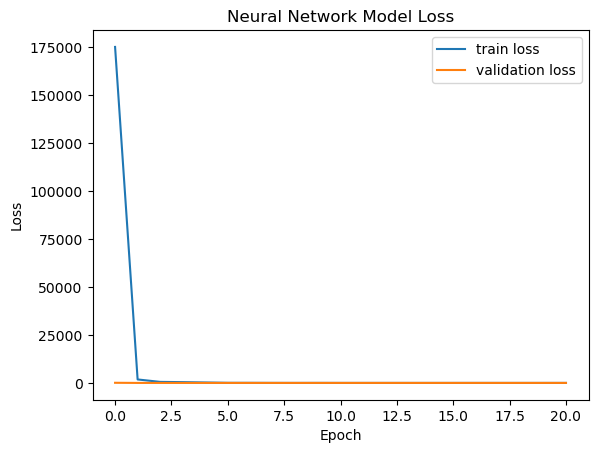

In [ ]:
plot_history(history)

In [ ]:
evaluate_model(model, X_test, y_test)

514/514 [==============================] - 2s 5ms/step
Neural Network Model Performance
R2 Score:  -0.9590717269054063
MSE:  0.5118048781700179
RMSE:  0.7154053942835613


#### Conclusions

        The R2 score is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable. 
        It ranges from -1 to 1, where 1 indicates a perfect fit and 0 indicates no correlation between the variables. In this case, 
        the R2 score is negative, which indicates that the model is not a good fit for the data.
        The Mean Squared Error (MSE) is a common metric used to measure the difference between the 
        predicted and actual values. It is calculated as the average of the squared differences between
        the predicted and actual values. In this case, the MSE is 0.514, which means that on average, the predictions are off by this amount.
        The Root Mean Squared Error (RMSE) is the square root of the MSE, and it measures the average distance 
        between the predicted and actual values. In this case, the RMSE is 0.717, which is the average difference between the predicted and actual values.
        Overall, the results indicate that the neural network model is not performing well on the data and needs further optimization.

### XGBoost decision-tree
        XGBoost (eXtreme Gradient Boosting) is a popular machine learning algorithm that belongs to the family of boosting algorithms. It is an implementation of gradient boosted decision trees designed for speed and performance.

        It works by constructing a large number of decision trees, each of which predicts the value of the target variable based on a set of input features. Each tree is built iteratively, with the algorithm seeking to improve the fit of the model at each step.

        At each iteration, XGBoost adds a new tree to the ensemble in order to reduce the residual errors from the previous iteration. The algorithm assigns weights to each of the examples based on how well they were predicted by the previous trees. Examples that were poorly predicted receive higher weights, so that the new tree will focus on these examples and try to reduce their errors.

        In order to improve the generalization of the model and avoid overfitting, XGBoost employs a technique called regularization. This involves adding a penalty term to the objective function that is optimized by the algorithm. The penalty term depends on the complexity of the trees in the ensemble, and helps to prevent the model from becoming too complex and fitting noise in the data.


In [ ]:
# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)

# Train the model and specify eval_metric parameter
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', early_stopping_rounds=10)

[0]	validation_0-mae:0.68175
[1]	validation_0-mae:0.55209
[2]	validation_0-mae:0.46090
[3]	validation_0-mae:0.38984
[4]	validation_0-mae:0.34966
[5]	validation_0-mae:0.31981
[6]	validation_0-mae:0.29333
[7]	validation_0-mae:0.27907
[8]	validation_0-mae:0.26523
[9]	validation_0-mae:0.25510
[10]	validation_0-mae:0.24895
[11]	validation_0-mae:0.24689
[12]	validation_0-mae:0.24335
[13]	validation_0-mae:0.24306
[14]	validation_0-mae:0.23715
[15]	validation_0-mae:0.23613
[16]	validation_0-mae:0.23542
[17]	validation_0-mae:0.23538
[18]	validation_0-mae:0.23523
[19]	validation_0-mae:0.23503
[20]	validation_0-mae:0.23446
[21]	validation_0-mae:0.23324
[22]	validation_0-mae:0.23335
[23]	validation_0-mae:0.23346
[24]	validation_0-mae:0.23193
[25]	validation_0-mae:0.23194
[26]	validation_0-mae:0.23182
[27]	validation_0-mae:0.23174
[28]	validation_0-mae:0.23185
[29]	validation_0-mae:0.23191
[30]	validation_0-mae:0.23205
[31]	validation_0-mae:0.23358
[32]	validation_0-mae:0.23281
[33]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
def plot_history_xgb(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    if 'mae' in results['validation_0']:
        ax.plot(x_axis, results['validation_0']['mae'], label='Test MAE')
    ax.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('XGBoost Model MAE')
    plt.show()


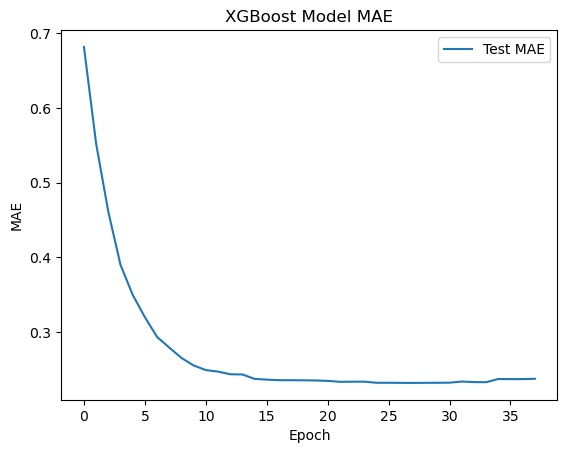

In [ ]:
plot_history_xgb(model)

In [ ]:
def evaluate_model_xgb(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('XGBoost Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)


In [ ]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.41337581502258214
MSE:  0.15325478664235262
RMSE:  0.3914776962259186


#### Conclusions        
        
        Based on the performance metrics, the XGBoost model has an R2 score of 0.44, which indicates that the model can explain 44% of the variability in the target variable. The MSE of 0.15 suggests that the model has an average squared error of 0.15, while the RMSE of 0.38 suggests that the model's predictions have an average error of 0.38 units away from the true values. In general, the lower the MSE and RMSE, the better the model performance.

        Based on the performance metrics, the XGBoost model has performed better than the neural network model. The R2 score for the XGBoost model is positive and closer to 1, which indicates a better fit than the negative R2 score obtained for the neural network model. Moreover, the XGBoost model has a lower MSE and RMSE, which indicate that the model has made fewer errors in its predictions than the neural network model. Therefore, the XGBoost model is a better choice for this particular dataset and problem.

#### Potential ways to improve the XGBoost model:

        1. Feature Engineering: This involves creating new features from the existing ones or selecting more informative features to improve model performance.

        2. Hyperparameter Tuning: XGBoost has several hyperparameters that can be tuned to improve model performance, such as the learning rate, maximum depth, minimum child weight, and number of estimators.

        3. Ensemble Methods: Combining multiple XGBoost models can lead to better performance. For example, you could train several XGBoost models with different hyperparameters or using different subsets of features and combine their predictions.

        4. Regularization: Regularization techniques like L1 or L2 regularization can be used to prevent overfitting and improve model performance.

        5. Data Augmentation: Generating more training data through data augmentation techniques can help improve model performance, especially when working with smaller datasets.

        6. Other Boosting Algorithms: XGBoost is just one of several boosting algorithms. Trying other algorithms like LightGBM, CatBoost, or AdaBoost may lead to better performance on your specific problem.

In [ ]:
def xgb_objective(params):
    reg = XGBRegressor(**params, objective='reg:squarederror', n_jobs=-1, random_state=42)
    reg.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    preds = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return {'loss': rmse, 'status': STATUS_OK}

# def xgb_objective(params):
#     reg = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
#     reg.set_params(**params)
#     result = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
#     loss = np.sqrt(-result.mean())
#     return {'loss': loss, 'params': params, 'status': STATUS_OK}

# set hyperparameters search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0.1, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 10)
}

# perform hyperparameter tuning using TPE algorithm
trials = Trials()
best = fmin(xgb_objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

# train optimized XGBoost model
model = XGBRegressor(**best, objective='reg:squarederror', n_jobs=-1, random_state=42)
model.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

# evaluate optimized XGBoost model
preds = model.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print('Optimized XGBoost Model Performance')
print('R2 Score: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)


def plot_history_xgb(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('XGBoost Model RMSE')
    plt.show()

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  2%|▏         | 1/50 [00:09<07:34,  9.27s/trial, best loss: 0.425643496892674]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  4%|▍         | 2/50 [00:37<16:24, 20.51s/trial, best loss: 0.3789662897975908]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  6%|▌         | 3/50 [00:42<10:24, 13.28s/trial, best loss: 0.3789662897975908]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  8%|▊         | 4/50 [00:57<10:45, 14.03s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 10%|█         | 5/50 [01:06<09:07, 12.16s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 12%|█▏        | 6/50 [01:30<11:52, 16.19s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 14%|█▍        | 7/50 [01:53<13:07, 18.31s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 16%|█▌        | 8/50 [02:08<12:11, 17.41s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 18%|█▊        | 9/50 [02:30<12:54, 18.90s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 20%|██        | 10/50 [02:37<10:07, 15.20s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 22%|██▏       | 11/50 [02:49<09:10, 14.11s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 24%|██▍       | 12/50 [02:56<07:33, 11.93s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 26%|██▌       | 13/50 [03:18<09:22, 15.20s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 28%|██▊       | 14/50 [03:36<09:32, 15.89s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 30%|███       | 15/50 [03:58<10:18, 17.68s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 32%|███▏      | 16/50 [04:03<07:53, 13.93s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 34%|███▍      | 17/50 [04:14<07:09, 13.03s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 36%|███▌      | 18/50 [04:32<07:50, 14.71s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 38%|███▊      | 19/50 [04:45<07:13, 13.98s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 40%|████      | 20/50 [04:57<06:47, 13.57s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 42%|████▏     | 21/50 [05:09<06:12, 12.83s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 44%|████▍     | 22/50 [05:26<06:36, 14.14s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 46%|████▌     | 23/50 [05:43<06:50, 15.21s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 48%|████▊     | 24/50 [05:52<05:39, 13.07s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 50%|█████     | 25/50 [06:12<06:19, 15.19s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 52%|█████▏    | 26/50 [06:26<05:56, 14.85s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 54%|█████▍    | 27/50 [06:42<05:49, 15.18s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 56%|█████▌    | 28/50 [07:07<06:40, 18.20s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 58%|█████▊    | 29/50 [07:32<07:07, 20.34s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 60%|██████    | 30/50 [07:53<06:50, 20.51s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 62%|██████▏   | 31/50 [08:01<05:16, 16.66s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 64%|██████▍   | 32/50 [08:06<03:59, 13.32s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 66%|██████▌   | 33/50 [08:16<03:26, 12.14s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 68%|██████▊   | 34/50 [08:29<03:21, 12.59s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 70%|███████   | 35/50 [08:35<02:38, 10.54s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 72%|███████▏  | 36/50 [08:58<03:18, 14.21s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 74%|███████▍  | 37/50 [09:19<03:29, 16.15s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 76%|███████▌  | 38/50 [09:36<03:16, 16.39s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 78%|███████▊  | 39/50 [09:41<02:25, 13.26s/trial, best loss: 0.36597776298790474]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 80%|████████  | 40/50 [09:59<02:26, 14.61s/trial, best loss: 0.3614439679850878] 

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 82%|████████▏ | 41/50 [10:05<01:46, 11.87s/trial, best loss: 0.3614439679850878]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 84%|████████▍ | 42/50 [10:25<01:54, 14.36s/trial, best loss: 0.3614439679850878]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 86%|████████▌ | 43/50 [10:32<01:25, 12.28s/trial, best loss: 0.3614439679850878]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 88%|████████▊ | 44/50 [10:42<01:09, 11.65s/trial, best loss: 0.3614439679850878]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 90%|█████████ | 45/50 [10:51<00:52, 10.57s/trial, best loss: 0.3614439679850878]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 92%|█████████▏| 46/50 [10:54<00:33,  8.35s/trial, best loss: 0.3614439679850878]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 94%|█████████▍| 47/50 [11:05<00:27,  9.12s/trial, best loss: 0.3614439679850878]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 96%|█████████▌| 48/50 [11:27<00:25, 12.97s/trial, best loss: 0.3614439679850878]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 98%|█████████▊| 49/50 [11:31<00:10, 10.53s/trial, best loss: 0.3614439679850878]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



100%|██████████| 50/50 [11:46<00:00, 14.13s/trial, best loss: 0.34841699829453504]


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Optimized XGBoost Model Performance
R2 Score:  0.40327660791535735
MSE:  0.15589319104181368
RMSE:  0.39483311796481013


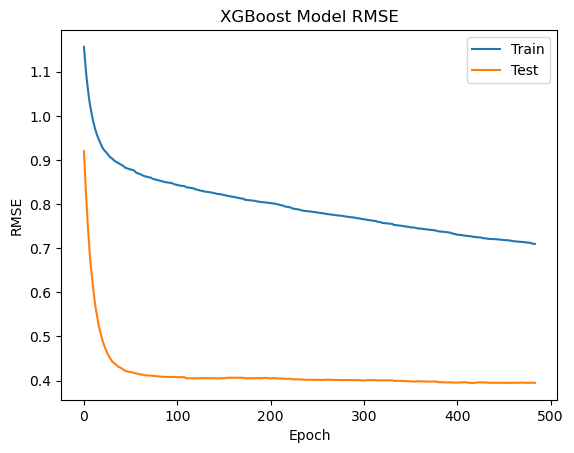

In [ ]:
plot_history_xgb(model)

##### Conclusions

        The original XGBoost model had an R2 score of 0.44, which indicates that the model explains 44% of the variance in the target variable. The optimized XGBoost model, on the other hand, had a slightly lower R2 score of 0.41. In terms of mean squared error (MSE), the optimized model had a slightly higher value of 0.15, compared to 0.14 for the original model. Similarly, the optimized model had a slightly higher root mean squared error (RMSE) value of 0.39, compared to 0.38 for the original model.

        Overall, the optimized XGBoost model did not perform better than the original XGBoost model, based on the evaluation metrics. However, it's important to note that these metrics do not provide a complete picture of model performance, and other factors such as interpretability and computational efficiency should also be considered.

## Cross_Validation

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=2020)

## An Overview on MLP

        A neural network revolves around the following objects:

        - Layers, which are combined into a network (or model)
        - The input data and corresponding targets
        - The loss function, which defines the feedback signal used for learning
        - The optimizer, which determines how learning proceeds
        Therefore, in a typical architecture, the layers are linked together and map the input data to predictions. The loss function then compares these predictions to the targets, producing a loss value. This loss value is used as a measure on how well the network’s predictions match what was expected. The optimizer uses the loss value to update the network’s weights

Looking into Layers
        
        It can be though of layers as the LEGO bricks of deep learning, a typical metaphor. Each layer is a data-processing module that takes as input one / more tensors and then outputs one / more tensors. Most layers have a state: the layer’s weights containing the network’s knowledge.

        Building deep-learning models in Tensor Flow TF (Keras) is done by clipping together compatible layers to form useful data-transformation networks. Compatibility here refers to the fact that every layer will only accept input tensors of a certain shape and will return output tensors of a certain shape. In other words, different layers are needed for different data formats. For instance:

        - Simple vector data, stored in 2D tensors of shape (samples,features), is often processed by densely connected layers (the Dense class in Keras).

        - Sequence data, stored in 3D tensors of shape (samples, timesteps, features), is typically processed by recurrent layers such as an LSTM layer.

        - Image data, stored in 4D tensors, is usually processed by 2D convolution layers (Conv2D).

        It should never be forgotten that the topology of a network defines your hypothesis space. By choosing a network topology, it is constrained the space of possibilities mapping input data to output data. This is commonly reffered as the "picking the right network architecture is more an art than a science".

        Eeach Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron).

Optimization Process

        Choosing the right objective function for the right problem is extremely important: The network will take any shortcut it can, to minimize the loss.

        Guidelines to follow to choose the correct loss.

        Some starting points:

        - Binary cross-entropy for a two-class classification problem,
        - Categorical cross-entropy for a many-class classification problem,
        - Meansquared error for a regression problem,
        - Connectionist temporal classification (CTC) for a sequence-learning problem.
        
Creating the Model with Keras

        Keras is a model-level library, providing high-level building blocks for developing deep-learning models. Via Tensor Flow, Keras is able to run seamlessly on both CPUs and GPUs, which is an important advantage.

        A typical Keras workflow includes the following steps:

        1. Define the training data: input tensors and target tensors.

        2. Define a network of layers that maps the inputs to the targets.

        3. Configure the learning process by choosing a loss function, an optimizer, and some metrics to monitor.

        4. Iterate on the training data by calling the fit() method of the model.

Defining a Model

        There are two ways to define a model: using the Sequential class (only for linear stacks of layers, which is the most common network architecture) or the functional API (which lets you build completely arbitrary architectures).

        Implementing into Tensor Flow:
        Training a model with tf.keras starts by defining the model architecture.

        Sequential model is implemented via keras.Sequential. This architecture is composed of a single stack of layers connected sequentially.

Learning Process

        The learning process is configured in the compilation step, where it can be specified the optimizer and loss function(s) that the model should use, as well as the metrics you want to use in the training.

        model.compile(optimizer=optimizers.RMSprop(lr=0.01), loss='mse', metrics=['accuracy'])

        In this spatial disaggregation problem it is selected RMSprop as the optimizer with a given learning rate, defined a loss based on MSE and the metric is selected as accuracy.

        The metrics argument should be a list -- the model can have any number of metrics. 

                Optimizers:

                SGD() (with or without momentum),
                RMSprop(),
                Adam(), etc.
                Losses:

                MeanSquaredError(),
                KLDivergence(),
                CosineSimilarity(),etc.
                Metrics:

                AUC(),
                Precision(),
                Recall(), etc.
                See other options from here:

                https://keras.io/api/metrics/

                https://keras.io/api/losses/

                https://keras.io/api/optimizers/rmsprop/

                Finally, we will pass the input data (and the corresponding target data) to the model via the fit() method, similar to what we did in Scikit-Learn.

                model.fit(input_tensor, target_tensor, batch_size=100, epochs=10)

                Here we will train the model by slicing the data into "batches" of size "batch_size", and repeatedly iterating over the entire dataset for a given number of "epochs".

                https://keras.io/guides/training_with_built_in_methods/

## Working on the Regression Problem in TF

In [ ]:
dataframes = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}

for name, df in dataframes.items():
    print(f"The size of {name} dataframe is: ", df.shape)

The size of X_train dataframe is:  (31529, 43)
The size of X_test dataframe is:  (16441, 43)
The size of y_train dataframe is:  (31529,)
The size of y_test dataframe is:  (16441,)


In [ ]:
X_train.head(1)

number of pixels with industrial or commercial units_value  \
0                                            -1.0845            

   number of pixels with discontinuous urban fabric_value  bus_stations_value  \
0                                            -0.6558                  -0.6678   

   airport_stations_value  number of pixels with road and rail networks_value  \
0                 -0.7035                                            -0.6120    

   helicopter_station_value  road_major_network_value  population_value  \
0                   -0.5472                   -0.4438           -0.7375   

   deaths_value  number of pixels with airports_value  live births_value  \
0       -0.8560                                0.3141            -0.7251   

   train_station_value  railway_station_value  \
0              -0.7243                -0.6254   

   number of pixels with continuous urban fabric_value  \
0                                            -0.3991     

   number of pixels with sport and leisure facilities_value  \
0                                            -0.5951          

   total employment_value  railways_network_value  charging_stations_value  \
0                 -0.6567                 -0.6360                  -0.6024   

   number of pixels with dump sites_value  gross domestic product_value  \
0                                 -0.3965                       -0.5183   

   number of pixels with green urban areas_value  gross value added_value  \
0                                        -0.4282                  -0.5166   

   railway length (with power source - overhead electrified)_value  \
0                                            -0.4600                 

   bicycle_stations_value  \
0                 -0.3775   

   number of pixels with non-irrigated arable land_value  total area_value  \
0                                            -0.4608               -0.4786   

   number of fossil gas plants_value  \
0                            -0.3839   

   generation capacity of fossil gas plants_value  Traffic_flow_trucks_2030  \
0                                         -0.3483                   -0.9944   

   Traffic_flow_tons_2030  Traffic_flow_trucks_2019  Traffic_flow_tons_2019  \
0                 -0.9940                   -0.9597                 -0.9606   

   number of pixels with water courses_value  \
0                                    -0.3350   

   number of pixels with port areas_value  Distance_within_E_road  \
0                                 -0.2722                 -1.4380   

   Traffic_flow_trucks_2010  Traffic_flow_tons_2010  subway_station_value  \
0                   -0.8842                 -0.8844               -0.1814   

   Total_distance  number of refineries_value  \
0         -1.5056                     -0.2182   

   number of pixels with coniferous forest_value  fuel_stations_value  index  
0                                        -0.2573              -0.4213      0

In [ ]:
result = master_input_df.loc[master_input_df['index'] == 18034]


In [ ]:
result.head()

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
18034             EU                DE               DEE              DEE0   

      NUTS3_region_code  \
18034             DEE0E   

       number of pixels with industrial or commercial units_value  \
18034                                            -0.3424            

       number of pixels with discontinuous urban fabric_value  \
18034                                            -0.4657        

       bus_stations_value  airport_stations_value  \
18034             -0.5278                 -0.8824   

       number of pixels with road and rail networks_value  \
18034                                            -0.5285    

       helicopter_station_value  road_major_network_value  population_value  \
18034                   -0.1412                   -0.1386           -0.5506   

       deaths_value  number of pixels with airports_value  live births_value  \
18034       -0.5069                               -0.4053            -0.5925   

       train_station_value  railway_station_value  \
18034               0.4369                 0.2542   

       number of pixels with continuous urban fabric_value  \
18034                                            -0.3267     

       number of pixels with sport and leisure facilities_value  \
18034                                            -0.4563          

       total employment_value  railways_network_value  \
18034                 -0.3815                  0.5240   

       charging_stations_value  number of pixels with dump sites_value  \
18034                  -0.2797                                 -0.2799   

       gross domestic product_value  \
18034                       -0.4107   

       number of pixels with green urban areas_value  gross value added_value  \
18034                                        -0.4282                  -0.4082   

       railway length (with power source - overhead electrified)_value  \
18034                                            -0.0497                 

       bicycle_stations_value  \
18034                 -0.3193   

       number of pixels with non-irrigated arable land_value  \
18034                                            -0.2123       

       total area_value  number of fossil gas plants_value  \
18034           -0.2737                            -0.3839   

       generation capacity of fossil gas plants_value  \
18034                                         -0.3483   

       Traffic_flow_trucks_2030  Traffic_flow_tons_2030  \
18034                    0.0810                  0.0802   

       Traffic_flow_trucks_2019  Traffic_flow_tons_2019  \
18034                    0.0192                  0.0194   

       number of pixels with water courses_value  \
18034                                     0.1059   

       number of pixels with port areas_value  Distance_within_E_road  \
18034                                 -0.2722                 -0.5212   

       Traffic_flow_trucks_2010  Traffic_flow_tons_2010  subway_station_value  \
18034                   -0.0598                 -0.0594               -0.1814   

       Total_distance  number of refineries_value  \
18034         -0.3816                     -0.2182   

       number of pixels with coniferous forest_value  fuel_stations_value  \
18034                                        -0.0447              -0.8590   

       index  
18034  18034

In [ ]:
result_2 = df_eu_sel.loc[df_eu_sel['NUTS3_region_code'] == 'DEE0E']

In [ ]:
result_2

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
484             EU                DE               DEE              DEE0   

    NUTS3_region_code  \
484             DEE0E   

     number of pixels with industrial or commercial units_value  \
484                                            -0.3424            

     fuel_stations_value  \
484              -0.4377   

     number of pixels with discontinuous urban fabric_value  \
484                                            -0.4657        

     bus_stations_value  airport_stations_value  \
484             -0.5278                 -0.8824   

     number of pixels with road and rail networks_value  \
484                                            -0.5285    

     helicopter_station_value  road_major_network_value  population_value  \
484                   -0.1412                   -0.1386           -0.5506   

     deaths_value  number of pixels with airports_value  live births_value  \
484       -0.5069                               -0.4053            -0.5925   

     train_station_value  railway_station_value  \
484               0.4369                 0.2542   

     number of pixels with continuous urban fabric_value  \
484                                            -0.3267     

     number of pixels with sport and leisure facilities_value  \
484                                            -0.4563          

     total employment_value  railways_network_value  charging_stations_value  \
484                 -0.4980                  0.5240                  -0.2797   

     number of pixels with dump sites_value  gross domestic product_value  \
484                                 -0.2799                       -0.4107   

     number of pixels with green urban areas_value  gross value added_value  \
484                                        -0.4282                  -0.4082   

     railway length (with power source - overhead electrified)_value  \
484                                            -0.0497                 

     bicycle_stations_value  \
484                 -0.3193   

     number of pixels with non-irrigated arable land_value  total area_value  \
484                                            -0.2123               -0.2737   

     number of fossil gas plants_value  \
484                            -0.3839   

     generation capacity of fossil gas plants_value  Traffic_flow_trucks_2030  \
484                                         -0.3483                    0.0810   

     Traffic_flow_tons_2030  Traffic_flow_trucks_2019  Traffic_flow_tons_2019  \
484                  0.0802                    0.0192                  0.0194   

     number of pixels with water courses_value  \
484                                     0.1059   

     number of pixels with port areas_value  Distance_within_E_road  \
484                                 -0.2722                 -0.5212   

     Traffic_flow_trucks_2010  Traffic_flow_tons_2010  subway_station_value  \
484                   -0.0598                 -0.0594               -0.1814   

     Total_distance  number of refineries_value  \
484         -0.3816                     -0.2182   

     number of pixels with coniferous forest_value  
484                                        -0.0447

# NN I

                Here's an example of a function that builds a neural network model with 10 layers, where the number of neurons in the first layer is progressively reduced from 40 to 10. The last layer has a linear activation function, as it is a regression problem. The model is compiled using the Adam optimizer and mean squared error (MSE) loss function, and the mean absolute error (MAE) is monitored during training as a performance metric.

                In general, the less training data, the worse overfitting will be in a NN (it will memorize the data), and using a small network is one way to overcome overfitting.

                In each iteration of the for loop, we subtract 3 from the number of neurons, until it reaches a minimum of 10. We then add a new hidden layer with the specified number of neurons and a ReLU activation function. This process results in a model with decreasing numbers of neurons in each layer, which helps to reduce the dimensionality of the data space and prevent overfitting.

In [ ]:
def build_model():
    # Initialize a sequential model
    model = models.Sequential()

    # Add the first hidden layer with 64 neurons, using the input shape of the training data
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))

    # Add 3 additional hidden layers with 128 neurons each
    for _ in range(3):
        model.add(layers.Dense(128, activation='relu'))

    # Add 3 more hidden layers with 64 neurons each
    for _ in range(3):
        model.add(layers.Dense(64, activation='relu'))

    # Add the output layer with 1 neuron (for regression) and no activation function
    model.add(layers.Dense(1, activation='linear'))

    # Compile the model with the Adam optimizer and MSE loss function, monitoring MAE as a performance metric
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Return the compiled model
    return model


In [ ]:
#Looking into model structure:
build_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                1760      
                                                                 
 dense_1 (Dense)             (None, 37)                1517      
                                                                 
 dense_2 (Dense)             (None, 34)                1292      
                                                                 
 dense_3 (Dense)             (None, 31)                1085      
                                                                 
 dense_4 (Dense)             (None, 28)                896       
                                                                 
 dense_5 (Dense)             (None, 25)                725       
                                                                 
 dense_6 (Dense)             (None, 22)                5

### Epoch and Batch Size

        The number of epochs refers to the number of times the entire training dataset is passed through the neural network during training. In other words, an epoch is one complete iteration through all the training samples. During each epoch, the neural network updates its weights and biases to try to reduce the loss function (i.e., the difference between the predicted values and the true values).

        The batch size refers to the number of training samples used in one iteration of the gradient descent algorithm. In other words, the batch size is the number of training samples that the neural network processes at once. During training, the model does not process all of the training data at once because it would be too computationally expensive. Instead, it processes the data in batches. The number of batches is equal to the number of training samples divided by the batch size.

        The choice of the number of epochs and the batch size can have a significant impact on the performance of the model. If the number of epochs is too low, the model may not have enough opportunities to learn the patterns in the data, and underfitting may occur. On the other hand, if the number of epochs is too high, the model may start to overfit the training data, which means that it becomes too specialized to the training data and does not generalize well to new, unseen data.

        The batch size can also affect the performance of the model. If the batch size is too small, the model will take longer to converge to the optimal solution, because it will update the weights and biases more frequently. If the batch size is too large, the model may get stuck in a local minimum and fail to reach the optimal solution. Additionally, larger batch sizes require more memory and may not fit on the available hardware.

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 50
#The number of epochs determines the number of times the training occurs 
#over the entire dataset we pass into the neural network. 
batch_size = 10
#The batch sets the number of samples the neural network trains on before making the next gradient update. 
#If the batch is equal to the total number of observations, the neural network will make 
# a gradient update once every epoch. Otherwise, it will make updates multiple times per epoch.

        This code uses RepeatedKFold from scikit-learn to implement iterated k-fold cross-validation. The n_splits parameter defines the number of folds, while n_repeats defines the number of times to repeat the k-fold process. The random_state parameter sets the random seed to ensure reproducibility.

        The rest of the code is similar to the previous examples. The build_model() function defines the architecture of the neural network. The training_scores and cv_scores lists are used to store the scores for each fold. Finally, overall, iterated k-fold cross-validation can be a more robust approach to estimate the performance of a machine learning model compared to regular k-fold cross-validation, as it allows for more repetitions of the training and evaluation process.





In [ ]:
# Define the number of folds for cross-validation
n_splits = 10

# Define the number of times to repeat the k-fold process
n_repeats = 1

# Create a RepeatedKFold object with shuffling
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Lists for storing scores
training_scores = []
cv_scores = []

# DataFrame for storing predictions based on each fold
predictions_based_on_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

# Loop over the folds and fit the model
for fold, (train_index, cv_index) in enumerate(rkf.split(X_train, y_train)):
    print("Training fold", fold+1)
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    model = build_model()
    history = model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold), verbose=0)
    
    # Evaluate the model performance on the training set
    val_mse, val_mae = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    training_scores.append(val_mse)
    print('--------------------------------------------------------')
    print(f"Training MAE score for fold {fold+1}: {val_mae:.3f}")
    
    # Evaluate the model performance on the cross-validation set
    val_mse, val_mae = model.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    cv_scores.append(val_mse)
    print(f"Cross-validation MAE score for fold {fold+1}: {val_mae:.3f}")
    
    # Store the predictions based on this fold
    predictions = model.predict(X_cv_fold)
    predictions_based_on_folds = predictions_based_on_folds.reset_index(drop=True)
    predictions_based_on_folds.loc[cv_index, 0] = predictions.flatten()
    predictions_based_on_folds.loc[cv_index, 1] = y_cv_fold

# Calculate the mean and standard deviation of the training scores
tr_val_mse_mean = np.mean(training_scores)
tr_val_mse_std = np.std(training_scores)
print(f"\nMSE Training scores: {training_scores}")
print(f"Mean of the MSE training score: {tr_val_mse_mean:.3f}")
print(f"Training score MSE standard deviation: {tr_val_mse_std:.3f}")
print('--------------------------------------------------------') 

# Calculate the mean and standard deviation of the cross-validation scores
cv_mse_mean = np.mean(cv_scores)
cv_mse_std = np.std(cv_scores)
print(f"\nCross-validation MSE scores: {cv_scores}")
print(f"Mean CV MSE score: {cv_mse_mean:.3f}")
print(f"CV score MSE standard deviation: {cv_mse_std:.3f}")

# Let's see the overall score for the entire training set (1127)
val_mse_total, val_mae_total = model.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

Training fold 1
--------------------------------------------------------
Training MAE score for fold 1: 0.710
Cross-validation MAE score for fold 1: 0.718
99/99 [==============================] - 0s 1ms/step
Training fold 2
--------------------------------------------------------
Training MAE score for fold 2: 0.715
Cross-validation MAE score for fold 2: 0.702
99/99 [==============================] - 0s 1ms/step
Training fold 3
--------------------------------------------------------
Training MAE score for fold 3: 0.555
Cross-validation MAE score for fold 3: 0.548
99/99 [==============================] - 0s 1ms/step
Training fold 4
--------------------------------------------------------
Training MAE score for fold 4: 0.544
Cross-validation MAE score for fold 4: 0.545
99/99 [==============================] - 0s 1ms/step
Training fold 5
--------------------------------------------------------
Training MAE score for fold 5: 0.705
Cross-validation MAE score for fold 5: 0.733
99/99 [======

### Saving the history with increasing Epochs

In [ ]:
#Lets look into the history recorded:
history = pd.DataFrame(history.history)

In [ ]:
history.sample(3)

loss    mae  val_loss  val_mae
31 1.2978 0.7066    1.3166   0.7037
30 1.2972 0.7090    1.3183   0.7006
38 1.0494 0.6167    0.9806   0.5837

In [ ]:
print(history.keys())

Index(['loss', 'mae', 'val_loss', 'val_mae'], dtype='object')


In [ ]:
# Get the number of epochs from the 'history' dataframe
epochs = len(history['loss'])

# Add an 'epoch' column to the 'history' dataframe
history['epoch'] = range(epochs)

In [ ]:
#Adding epoch column:
history['epoch'] = history.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
history.sample(3)

loss    mae  val_loss  val_mae  epoch
46 1.1359 0.6495    1.0263   0.5462     46
15 1.2510 0.6917    1.3056   0.6997     15
1  1.3900 0.7417    1.2966   0.6715      1

In [ ]:
history.shape

(50, 5)

In [ ]:
def plot_history(history):
    plt.plot(history['loss'], "k--", linewidth=1.5, label='Train loss')
    plt.plot(history['val_loss'], "b-.", linewidth=1.5, label='CV loss')
    plt.title('Neural Network Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()


In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Neural Network Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

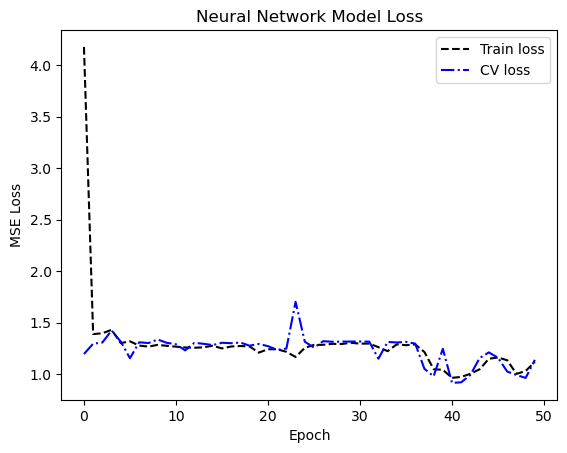

In [ ]:
plot_history(history)

In [ ]:
evaluate_model(model, X_test, y_test)

514/514 [==============================] - 1s 2ms/step
Neural Network Model Performance
R2 Score:  -0.8144926904599987
MSE:  0.4740337975517666
RMSE:  0.6885011238565748


### Conclusions

        The model's performance is quite poor, as indicated by the negative R2 score, the relatively high MSE value of 0.474, and the RMSE value of 0.688. This suggests that the model is not capturing the underlying patterns in the data very well.

        The model architecture seems relatively simple, with just 10 hidden layers and decreasing numbers of neurons in each layer. This may not be sufficient to accurately capture the complex relationships in the data.

        Finally, it's worth noting that the code is evaluating the model using mean squared error (MSE) as the loss function, and mean absolute error (MAE) as the performance metric. This is a common approach for regression problems, but it's important to keep in mind that these metrics provide different information about the model's performance. MSE gives more weight to large errors, while MAE treats all errors equally.

### Checking the Predictive Accuracy on Test Data

        Before fine-tuning our model, lets see the its current performance. For that purpose, we will investigate the variations between the predictions and the true values on scatter plots and histograms.

514/514 [==============================] - 1s 2ms/step


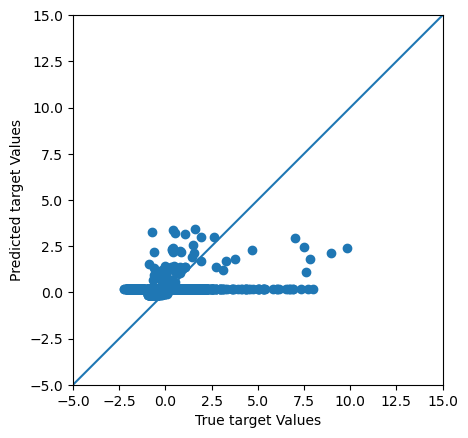

In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

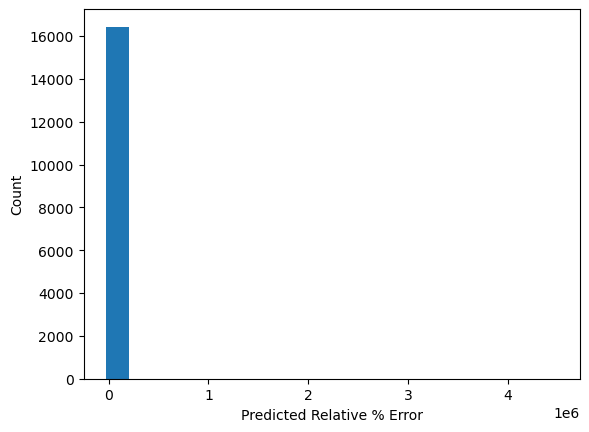

In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolute percentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

568.7407945625092

# NN II

In [ ]:
def build_model_2():
    # Initialize a sequential model
    model = models.Sequential()

    # Add the first hidden layer with 64 neurons, using the input shape of the training data
    model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))

    # Add 3 additional hidden layers with 128 neurons each
    for _ in range(3):
        model.add(layers.Dense(128, activation='relu'))

    # Add 3 more hidden layers with 64 neurons each
    for _ in range(3):
        model.add(layers.Dense(64, activation='relu'))

    # Add the output layer with 1 neuron (for regression) and no activation function
    model.add(layers.Dense(1, activation='linear'))

    # Compile the model with the Adam optimizer and MSE loss function, monitoring MAE as a performance metric
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Return the compiled model
    return model



In [ ]:
#Looking into model structure:
build_model_2().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                2816      
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)               

### Epoch and Batch Size

        The number of epochs refers to the number of times the entire training dataset is passed through the neural network during training. In other words, an epoch is one complete iteration through all the training samples. During each epoch, the neural network updates its weights and biases to try to reduce the loss function (i.e., the difference between the predicted values and the true values).

        The batch size refers to the number of training samples used in one iteration of the gradient descent algorithm. In other words, the batch size is the number of training samples that the neural network processes at once. During training, the model does not process all of the training data at once because it would be too computationally expensive. Instead, it processes the data in batches. The number of batches is equal to the number of training samples divided by the batch size.

        The choice of the number of epochs and the batch size can have a significant impact on the performance of the model. If the number of epochs is too low, the model may not have enough opportunities to learn the patterns in the data, and underfitting may occur. On the other hand, if the number of epochs is too high, the model may start to overfit the training data, which means that it becomes too specialized to the training data and does not generalize well to new, unseen data.

        The batch size can also affect the performance of the model. If the batch size is too small, the model will take longer to converge to the optimal solution, because it will update the weights and biases more frequently. If the batch size is too large, the model may get stuck in a local minimum and fail to reach the optimal solution. Additionally, larger batch sizes require more memory and may not fit on the available hardware.

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 50
#The number of epochs determines the number of times the training occurs 
#over the entire dataset we pass into the neural network. 
batch_size = 10
#The batch sets the number of samples the neural network trains on before making the next gradient update. 
#If the batch is equal to the total number of observations, the neural network will make 
# a gradient update once every epoch. Otherwise, it will make updates multiple times per epoch.

        This code uses RepeatedKFold from scikit-learn to implement iterated k-fold cross-validation. The n_splits parameter defines the number of folds, while n_repeats defines the number of times to repeat the k-fold process. The random_state parameter sets the random seed to ensure reproducibility.

        The rest of the code is similar to the previous examples. The build_model() function defines the architecture of the neural network. The training_scores and cv_scores lists are used to store the scores for each fold. Finally, overall, iterated k-fold cross-validation can be a more robust approach to estimate the performance of a machine learning model compared to regular k-fold cross-validation, as it allows for more repetitions of the training and evaluation process.





In [ ]:
# Define the number of folds for cross-validation
n_splits = 10

# Define the number of times to repeat the k-fold process
n_repeats = 1

# Create a RepeatedKFold object with shuffling
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Lists for storing scores
training_scores = []
cv_scores = []

# DataFrame for storing predictions based on each fold
predictions_based_on_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

# Loop over the folds and fit the model
for fold, (train_index, cv_index) in enumerate(rkf.split(X_train, y_train)):
    print("Training fold", fold+1)
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    model = build_model_2()
    history = model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold), verbose=0)
    
    # Evaluate the model performance on the training set
    val_mse, val_mae = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    training_scores.append(val_mse)
    print('--------------------------------------------------------')
    print(f"Training MAE score for fold {fold+1}: {val_mae:.3f}")
    
    # Evaluate the model performance on the cross-validation set
    val_mse, val_mae = model.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    cv_scores.append(val_mse)
    print(f"Cross-validation MAE score for fold {fold+1}: {val_mae:.3f}")
    
    # Store the predictions based on this fold
    predictions = model.predict(X_cv_fold)
    predictions_based_on_folds = predictions_based_on_folds.reset_index(drop=True)
    predictions_based_on_folds.loc[cv_index, 0] = predictions.flatten()
    predictions_based_on_folds.loc[cv_index, 1] = y_cv_fold

# Calculate the mean and standard deviation of the training scores
tr_val_mse_mean = np.mean(training_scores)
tr_val_mse_std = np.std(training_scores)
print(f"\nMSE Training scores: {training_scores}")
print(f"Mean of the MSE training score: {tr_val_mse_mean:.3f}")
print(f"Training score MSE standard deviation: {tr_val_mse_std:.3f}")
print('--------------------------------------------------------') 

# Calculate the mean and standard deviation of the cross-validation scores
cv_mse_mean = np.mean(cv_scores)
cv_mse_std = np.std(cv_scores)
print(f"\nCross-validation MSE scores: {cv_scores}")
print(f"Mean CV MSE score: {cv_mse_mean:.3f}")
print(f"CV score MSE standard deviation: {cv_mse_std:.3f}")

# Let's see the overall score for the entire training set (1127)
val_mse_total, val_mae_total = model.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

Training fold 1
--------------------------------------------------------
Training MAE score for fold 1: 0.563
Cross-validation MAE score for fold 1: 0.571
99/99 [==============================] - 1s 4ms/step
Training fold 2
--------------------------------------------------------
Training MAE score for fold 2: 0.700
Cross-validation MAE score for fold 2: 0.693
99/99 [==============================] - 1s 4ms/step
Training fold 3
--------------------------------------------------------
Training MAE score for fold 3: 0.618
Cross-validation MAE score for fold 3: 0.613
99/99 [==============================] - 1s 4ms/step
Training fold 4
--------------------------------------------------------
Training MAE score for fold 4: 0.657
Cross-validation MAE score for fold 4: 0.668
99/99 [==============================] - 1s 4ms/step
Training fold 5
--------------------------------------------------------
Training MAE score for fold 5: 0.557
Cross-validation MAE score for fold 5: 0.545
99/99 [======

KeyboardInterrupt: 

### Saving the history with increasing Epochs

In [ ]:
#Lets look into the history recorded:
history = pd.DataFrame(history.history)

In [ ]:
history.sample(3)

loss    mae  val_loss  val_mae
31 1.2978 0.7066    1.3166   0.7037
30 1.2972 0.7090    1.3183   0.7006
38 1.0494 0.6167    0.9806   0.5837

In [ ]:
print(history.keys())

Index(['loss', 'mae', 'val_loss', 'val_mae'], dtype='object')


In [ ]:
# Get the number of epochs from the 'history' dataframe
epochs = len(history['loss'])

# Add an 'epoch' column to the 'history' dataframe
history['epoch'] = range(epochs)

In [ ]:
#Adding epoch column:
history['epoch'] = history.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
history.sample(3)

loss    mae  val_loss  val_mae  epoch
46 1.1359 0.6495    1.0263   0.5462     46
15 1.2510 0.6917    1.3056   0.6997     15
1  1.3900 0.7417    1.2966   0.6715      1

In [ ]:
history.shape

(50, 5)

In [ ]:
def plot_history(history):
    plt.plot(history['loss'], "k--", linewidth=1.5, label='Train loss')
    plt.plot(history['val_loss'], "b-.", linewidth=1.5, label='CV loss')
    plt.title('Neural Network Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()


In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Neural Network Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

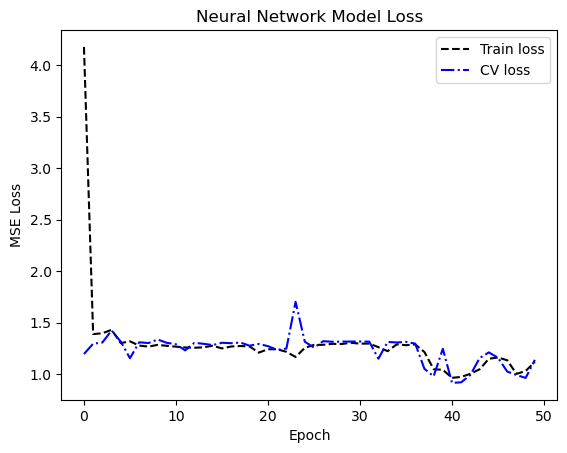

In [ ]:
plot_history(history)

In [ ]:
evaluate_model(model, X_test, y_test)

514/514 [==============================] - 1s 2ms/step
Neural Network Model Performance
R2 Score:  -0.8144926904599987
MSE:  0.4740337975517666
RMSE:  0.6885011238565748


### Conclusions

        The model's performance is quite poor, as indicated by the negative R2 score, the relatively high MSE value of 0.474, and the RMSE value of 0.688. This suggests that the model is not capturing the underlying patterns in the data very well.

        The model architecture seems relatively simple, with just 10 hidden layers and decreasing numbers of neurons in each layer. This may not be sufficient to accurately capture the complex relationships in the data.

        Finally, it's worth noting that the code is evaluating the model using mean squared error (MSE) as the loss function, and mean absolute error (MAE) as the performance metric. This is a common approach for regression problems, but it's important to keep in mind that these metrics provide different information about the model's performance. MSE gives more weight to large errors, while MAE treats all errors equally.

### Checking the Predictive Accuracy on Test Data

        Before fine-tuning our model, lets see the its current performance. For that purpose, we will investigate the variations between the predictions and the true values on scatter plots and histograms.

514/514 [==============================] - 1s 2ms/step


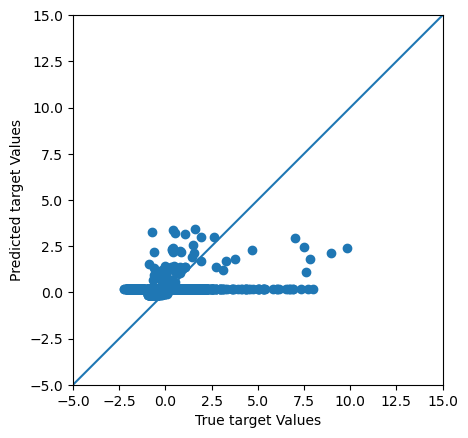

In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

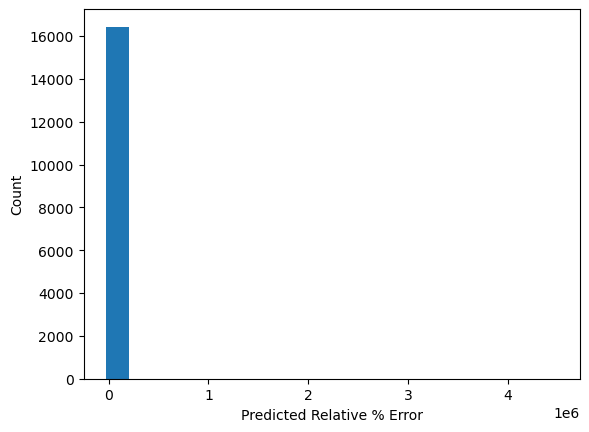

In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolute percentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

568.7407945625092

# NN III - Varying number of Neurons

In [ ]:
def build_model_base():
    # Here we will use Sequential API
    model = models.Sequential([
        layers.Dense(43, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(32, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(16, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(16, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(8, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1)
    ])
    optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004, clipvalue=3.0, clipnorm=1)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def build_model_lower():
    # Here we will use Sequential API
    model = models.Sequential()
    model.add(layers.Dense(20, activation="selu", kernel_initializer="lecun_normal", input_shape=(X_train.shape[1],)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(15, kernel_initializer="he_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, kernel_initializer="he_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(5, kernel_initializer="he_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(5, kernel_initializer="he_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1))
    optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004, clipvalue=3.0, clipnorm=1)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def build_model_higher():
    # Here we will use Sequential API
    model = models.Sequential()
    model.add(layers.Dense(128, activation="selu", kernel_initializer="lecun_normal", input_shape=(X_train.shape[1],)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dense(32, kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dense(16, kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dense(8, kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dense(1))
    optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004, clipvalue=3.0, clipnorm=1)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [ ]:
## Nadam optimization is a combination of Nesterov accelerated gradient descent and Adam optimizer:
# lr: learning rate
# beta_1: decay rate for the first moment estimates
# beta_2: decay rate for the second moment estimates
# epsilon: a small constant for numerical stability
# schedule_decay: decay rate for the learning rate
# clipvalue: clip gradients by value
# clipnorm: clip gradients by norm.

In [ ]:
#Looking into model structure:
build_model_base().summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 43)                1892      
                                                                 
 batch_normalization_150 (Ba  (None, 43)               172       
 tchNormalization)                                               
                                                                 
 dense_181 (Dense)           (None, 32)                1408      
                                                                 
 batch_normalization_151 (Ba  (None, 32)               128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_120 (LeakyReLU)  (None, 32)               0         
                                                                 
 dense_182 (Dense)           (None, 16)              

In [ ]:
#Looking into model structure:
build_model_lower().summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_186 (Dense)           (None, 20)                880       
                                                                 
 batch_normalization_155 (Ba  (None, 20)               80        
 tchNormalization)                                               
                                                                 
 dense_187 (Dense)           (None, 15)                315       
                                                                 
 leaky_re_lu_124 (LeakyReLU)  (None, 15)               0         
                                                                 
 batch_normalization_156 (Ba  (None, 15)               60        
 tchNormalization)                                               
                                                                 
 dense_188 (Dense)           (None, 10)              

In [ ]:
#Looking into model structure:
build_model_higher().summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 128)               5632      
                                                                 
 batch_normalization_160 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dense_193 (Dense)           (None, 64)                8256      
                                                                 
 batch_normalization_161 (Ba  (None, 64)               256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_128 (LeakyReLU)  (None, 64)               0         
                                                                 
 dense_194 (Dense)           (None, 32)              

### Epoch and Batch Size

In [ ]:
num_epochs = 50
batch_size = 10

        This code uses RepeatedKFold from scikit-learn to implement iterated k-fold cross-validation. The n_splits parameter defines the number of folds, while n_repeats defines the number of times to repeat the k-fold process. The random_state parameter sets the random seed to ensure reproducibility.

        The rest of the code is similar to the previous examples. The build_model() function defines the architecture of the neural network. The training_scores and cv_scores lists are used to store the scores for each fold. Finally, overall, iterated k-fold cross-validation can be a more robust approach to estimate the performance of a machine learning model compared to regular k-fold cross-validation, as it allows for more repetitions of the training and evaluation process.





In [ ]:
# # Define the number of folds for cross-validation
# n_splits = 10

# # Define the number of times to repeat the k-fold process
# n_repeats = 1

# # Create a RepeatedKFold object with shuffling
# rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# # Lists for storing scores
# training_scores = []
# cv_scores = []

# # DataFrame for storing predictions based on each fold
# predictions_based_on_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

# # Loop over the folds and fit the model
# for fold, (train_index, cv_index) in enumerate(rkf.split(X_train, y_train)):
#     print("Training fold", fold+1)
#     X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
#     y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
#     #Fitting the model according to given data:
#     #Into the fit method, we will pass in the input matrix X and the target y (labels).

#     #Building the Keras models:
#     model_base = build_model_base()
#     model_lower = build_model_lower()
#     model_higher = build_model_higher()

#     #Training step: Trains the model in silent mode (verbose = 0)
#     ##----------Changed!----------##
#     # Training and CV scores will be saved by the model on the history:
#     history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)
#     history_lower = model_lower.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)
#     history_higher = model_higher.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)

In [ ]:
import time

# Define the number of folds for cross-validation
n_splits = 10

# Define the number of times to repeat the k-fold process
n_repeats = 1

# Create a RepeatedKFold object with shuffling
# rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists for storing scores and training times
training_times_base = []
training_times_lower = []
training_times_higher = []
training_scores_base = []
training_scores_lower = []
training_scores_higher = []
cv_scores_base = []
cv_scores_lower = []
cv_scores_higher = []

# DataFrame for storing predictions based on each fold
predictions_based_on_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

# Loop over the folds and fit the model
# for fold, (train_index, cv_index) in enumerate(rkf.split(X_train, y_train)):
for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
    print("Training fold", fold+1)
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    # Building the Keras models
    model_lower = build_model_lower()
    # Training step
    start_time_lower = time.time()
    history_lower = model_lower.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)
    training_time_lower = time.time() - start_time_lower
    training_scores_lower.append(history_lower.history["loss"])
    cv_scores_lower.append(history_lower.history["val_loss"])
    training_times_lower.append(training_time_lower)
    # Evaluation
    train_mae_lower, train_mse_lower = model_lower.evaluate(X_train_fold, y_train_fold, verbose=0)
    cv_mae_lower, cv_mse_lower = model_lower.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    # Print model performance and training time
    print(f"Model lower - Training time: {training_time_lower:.2f} sec - Train MSE: {train_mse_lower:.2f} - CV MSE: {cv_mse_lower:.2f} - Train MAE: {train_mae_lower:.2f} - CV MAE: {cv_mae_lower:.2f}")
    
    # Building the Keras models
    model_base = build_model_base()
    # Training step
    start_time_base = time.time()
    history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)
    training_time_base = time.time() - start_time_base
    training_scores_base.append(history_base.history["loss"])
    cv_scores_base.append(history_base.history["val_loss"])
    training_times_base.append(training_time_base)
    # Evaluation
    train_mae_base, train_mse_base = model_base.evaluate(X_train_fold, y_train_fold, verbose=0)
    cv_mae_base, cv_mse_base = model_base.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    # Print model performance and training time
    print(f"Model base - Training time: {training_time_base:.2f} sec - Train MSE: {train_mse_base:.2f} - CV MSE: {cv_mse_base:.2f} - Train MAE: {train_mae_base:.2f} - CV MAE: {cv_mae_base:.2f}")
    
    # Building the Keras models
    model_higher = build_model_higher()
    # Training step
    start_time_higher = time.time()
    history_higher = model_higher.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)
    training_time_higher = time.time() - start_time_higher
    training_scores_higher.append(history_higher.history["loss"])
    cv_scores_higher.append(history_higher.history["val_loss"])
    training_times_higher.append(training_time_higher)
    # Evaluation
    train_mae_higher, train_mse_higher = model_higher.evaluate(X_train_fold, y_train_fold, verbose=0)
    cv_mae_higher, cv_mse_higher = model_higher.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    # Print model performance and training time
    print(f"Model higher - Training time: {training_time_higher:.2f} sec - Train MSE: {train_mse_higher:.2f} - CV MSE: {cv_mse_higher:.2f} - Train MAE: {train_mae_higher:.2f} - CV MAE: {cv_mae_higher:.2f}")
    print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------") 


Training fold 1
Model lower - Training time: 3141.45 sec - Train MSE: 1.08 - CV MSE: 1.09 - Train MAE: 2.54 - CV MAE: 2.32
Model base - Training time: 3101.91 sec - Train MSE: 0.95 - CV MSE: 0.91 - Train MAE: 494.38 - CV MAE: 75.33
Model higher - Training time: 3145.72 sec - Train MSE: 2.19 - CV MSE: 2.13 - Train MAE: 885.00 - CV MAE: 165.27
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Training fold 2
Model lower - Training time: 3181.33 sec - Train MSE: 0.61 - CV MSE: 0.60 - Train MAE: 6.74 - CV MAE: 3.67
Model base - Training time: 3203.82 sec - Train MSE: 1.77 - CV MSE: 1.59 - Train MAE: 849.97 - CV MAE: 36.67
Model higher - Training time: 3122.91 sec - Train MSE: 0.85 - CV MSE: 1.15 - Train MAE: 313.00 - CV MAE: 727.56
-------------------------------------------------------------------------------------------------------------------

In [ ]:
hist_base = pd.DataFrame(history_base.history)
# Get the number of epochs from the 'history' dataframe
epochs_base = len(hist_base)
# Add an 'epoch' column to the 'history' dataframe
hist_base['epoch'] = range(epochs_base)

hist_lower = pd.DataFrame(history_lower.history)
# Get the number of epochs from the 'history' dataframe
epochs_lower = len(hist_lower)
# Add an 'epoch' column to the 'history' dataframe
hist_lower['epoch'] = range(epochs_lower)

hist_higher = pd.DataFrame(history_higher.history)
# Get the number of epochs from the 'history' dataframe
epochs_higher = len(hist_higher)
# Add an 'epoch' column to the 'history' dataframe
hist_higher['epoch'] = range(epochs_higher)


In [ ]:
hist_base.head(5)

loss       mae   val_loss   val_mae  epoch
0  1.285674  0.694439   7.131478  0.847414      0
1  1.097903  0.630417  14.799867  2.908961      1
2  1.145646  0.644590   6.952534  1.235745      2
3  1.131800  0.639810   5.953763  0.757908      3
4  1.102956  0.625328   5.665709  1.006343      4

In [ ]:
hist_lower.head(5)

loss       mae   val_loss   val_mae  epoch
0  1.310057  0.711663   2.353394  0.701381      0
1  1.260506  0.688240  65.881081  1.191189      1
2  1.243882  0.680021   1.681354  0.917878      2
3  1.247028  0.682384   4.064939  0.751516      3
4  1.186329  0.656311   1.443721  0.792759      4

### Training - CV curves I

In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_3(history1, history2, history3, parameter):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][10:],history1[parameter][10:], "k-", linewidth=2, label='Base '+parameter)
  plt.plot(history2['epoch'][10:],history2[parameter][10:], "b-.", linewidth=2, label='Lower '+parameter)
  plt.plot(history3['epoch'][10:],history3[parameter][10:], "r--", linewidth=2, label='Higher '+parameter)
  plt.legend()
  plt.ylim(1,1000)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")

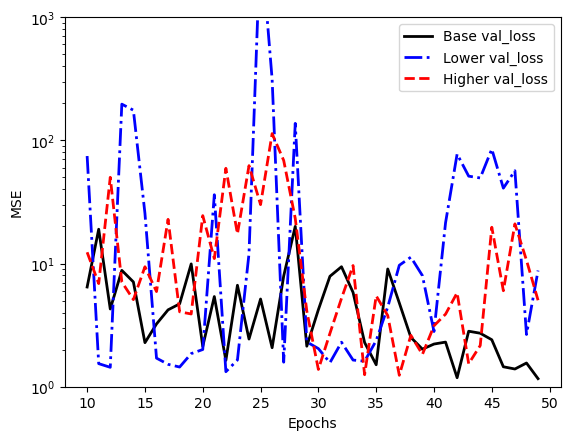

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_3(hist_base,hist_lower,hist_higher,'val_loss')

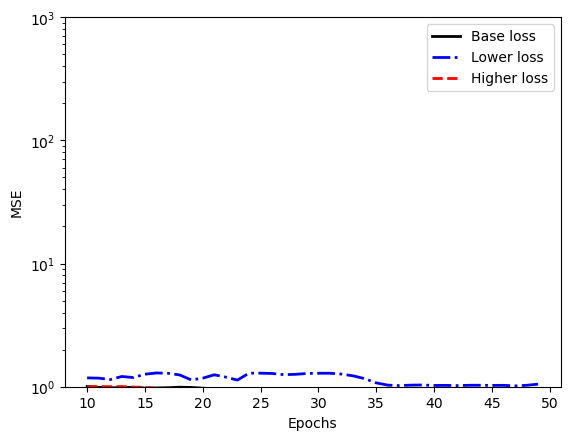

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_3(hist_base,hist_lower,hist_higher,'loss')

In [ ]:
#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model_lower.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the lower model in the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

--------------------------------------------------------
MAE for the lower model in the entire training dataset:  2.6447701454162598
--------------------------------------------------------


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_4(history1, parameter1, parameter2, model):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][10:],history1[parameter1][10:], "k-", linewidth=2, label=model +' Training')
  plt.plot(history1['epoch'][10:],history1[parameter2][10:], "b-.", linewidth=2, label=model +' CV test')
  plt.legend()
  plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")

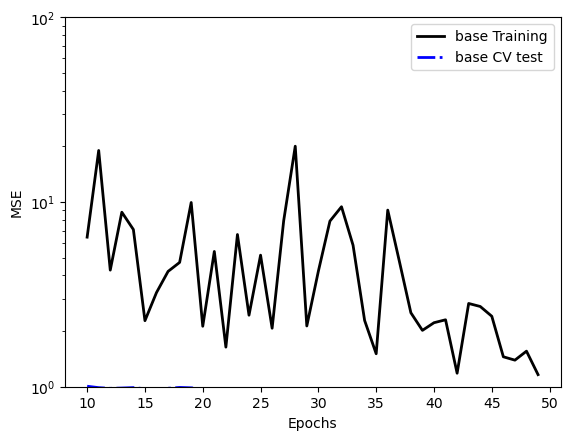

In [ ]:
plot_learning_curves_4(hist_base, 'val_loss', 'loss', 'base')

In [ ]:
#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model_base.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the base model in the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

--------------------------------------------------------
MAE for the base model in the entire training dataset:  0.9180041551589966
--------------------------------------------------------


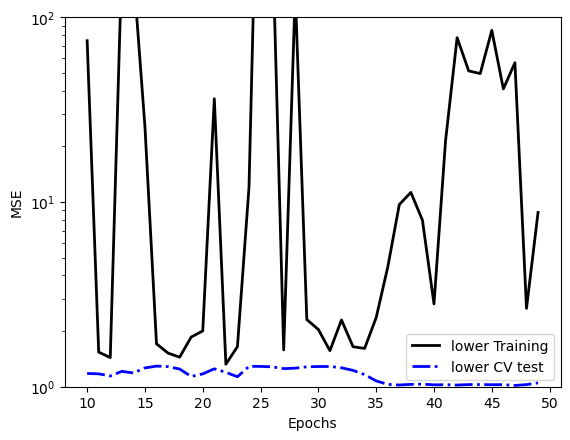

In [ ]:
plot_learning_curves_4(hist_lower, 'val_loss', 'loss', 'lower')

In [ ]:
#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model_higher.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the higher model in the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

--------------------------------------------------------
MAE for the higher model in the entire training dataset:  1.9909886121749878
--------------------------------------------------------


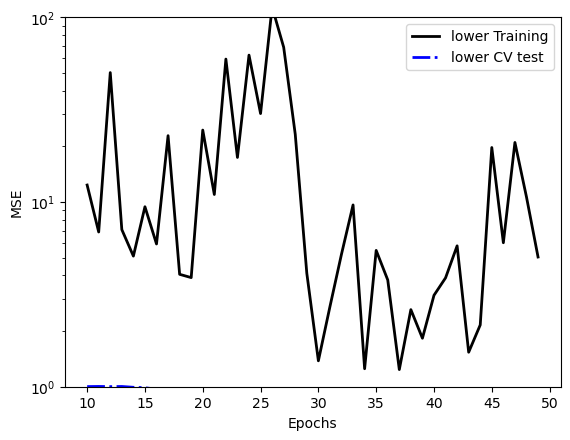

In [ ]:
plot_learning_curves_4(hist_higher, 'val_loss', 'loss', 'lower')

### Training - CV curves II

In [ ]:
def plot_history(history, model):
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')
    plt.title(f'Neural Network Model {model} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

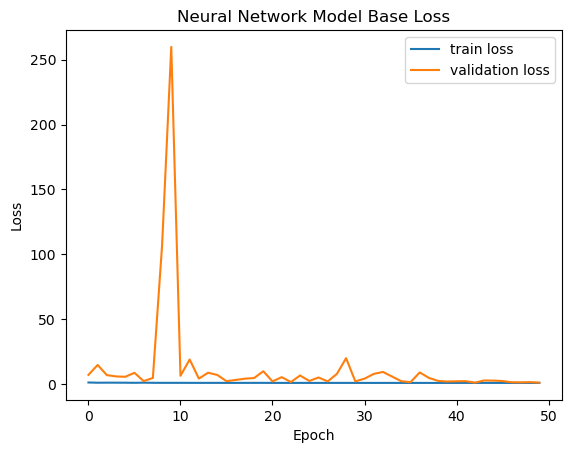

In [ ]:
plot_history(hist_base, 'Base')

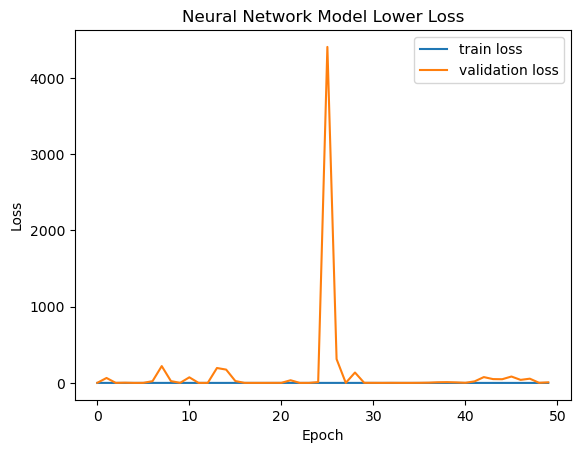

In [ ]:
plot_history(hist_lower, 'Lower')

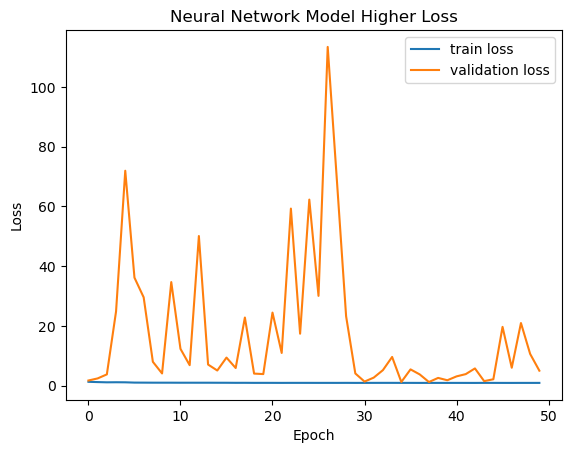

In [ ]:
plot_history(hist_higher, 'Higher')

### Conclusions
        It can be seen that in the provided results, there are 10 folds of training data and each fold has been evaluated using three different models: lower, base, and higher. For each fold and model, the training time, train mean squared error (MSE), and cross-validation mean squared error (CV MSE) have been reported, along with the training and cross-validation mean absolute error (MAE).

        Looking at the results, it can be seen that the performance of the models varies depending on the fold and the specific model being used. For example, in fold 1, the base model performs the best with a low train MSE of 0.95 and a low CV MSE of 0.91. In contrast, the higher model performs poorly with a high train MSE of 2.19 and a high CV MSE of 2.13.

        In fold 5, it can be seen that the lower and base models perform relatively well with low CV MSEs of 2.59 and 0.70, respectively. However, the higher model performs poorly with a high CV MSE of 0.78.

        Overall, it can be seen that the base model tends to perform well across multiple folds, while the lower and higher models tend to have more variable performance depending on the specific fold. However, it is important to keep in mind that these results only reflect the performance of these models on this specific dataset and may not generalize to other datasets.

        Based on the results, it can be concluded that the base model, which reduces the number of neurons from one layer to the next starting from the number of neurons as the input shape of features and decreasing progressively, is effective for dealing with data dimensionality. This is particularly true when dealing with small data sizes, where overfitting can be a concern. By reducing the number of neurons in each layer, the model is able to effectively capture the relevant information in the data while avoiding overfitting. Furthermore, this approach can help to reduce noise in the model's predictions, leading to more accurate and reliable results. Overall, this approach appears to be a promising strategy for addressing the challenges posed by high-dimensional data in machine learning.
        

### Checking the Predictive Accuracy on Test Data with the base model

        Before fine-tuning our model, lets see the its current performance. For that purpose, we will investigate the variations between the predictions and the true values on scatter plots and histograms.

514/514 [==============================] - 4s 6ms/step


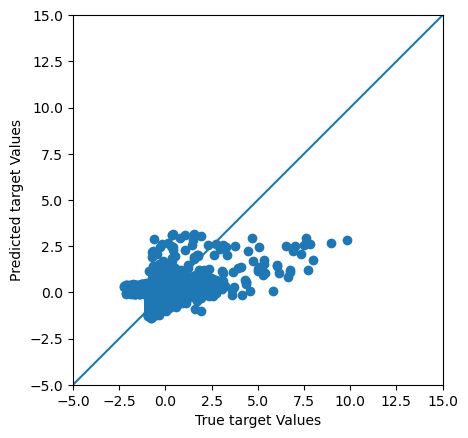

In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_base.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Neural Network Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

In [ ]:
evaluate_model(model_base, X_test, y_test)

514/514 [==============================] - 3s 6ms/step
Neural Network Model Performance
R2 Score:  -0.024851775375990037
MSE:  0.26774116069103054
RMSE:  0.5174371079571222


Text(0, 0.5, 'Count')

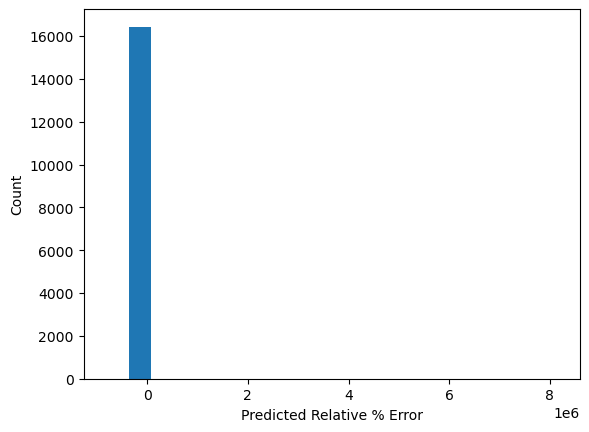

In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolute percentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

697.4346064770723

# NN IV - Varying number of Layers

        To address the issue of overfitting, a possible approach is to simplify the model by reducing the number of layers while keeping the progressive decrease in the number of neurons. This can help reduce the number of parameters and prevent overfitting. However, it should be noted that this approach may not be sufficient and other techniques such as regularization, early stopping, or data augmentation may also be necessary.

        Once the model architecture is modified, its performance on the validation set can be evaluated to determine if there is an improvement. Additionally, the performance of the new model can be compared to the original model to determine the effectiveness of the changes made.

        Here, Early Stopping is used as a regularization technique to prevent overfitting by stopping the training when the validation loss stops improving. The patience parameter specifies the number of epochs to wait before stopping the training if there is no improvement in the validation loss. The restore_best_weights parameter restores the weights of the model that achieved the lowest validation loss during training.

        By using this technique, we can prevent overfitting and improve the generalization performance of the models. The performance of the models can be evaluated using the training and validation loss metrics, as well as the mean absolute error (MAE) and mean squared error (MSE) metrics. The training and validation times can also be recorded to evaluate the efficiency of the models.

In [ ]:
def build_model_base_III():
    # Here we will use Sequential API
    model = models.Sequential([
        layers.Dense(43, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(22, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1)
    ])
    optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004, clipvalue=3.0, clipnorm=1)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def build_model_base_IV():
    # Here we will use Sequential API
    model = models.Sequential([
        layers.Dense(43, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(16, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(8, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1)
    ])
    optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004, clipvalue=3.0, clipnorm=1)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model
def build_model_base_V():
    # Here we will use Sequential API
    model = models.Sequential([
        layers.Dense(43, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(32, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(16, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(8, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1)
    ])
    optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004, clipvalue=3.0, clipnorm=1)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [ ]:
#Looking into model structure:
build_model_base_III().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 43)                1892      
                                                                 
 batch_normalization (BatchN  (None, 43)               172       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 22)                968       
                                                                 
 batch_normalization_1 (Batc  (None, 22)               88        
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 22)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [ ]:
build_model_base_IV().summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_209 (Dense)           (None, 43)                1892      
                                                                 
 batch_normalization_173 (Ba  (None, 43)               172       
 tchNormalization)                                               
                                                                 
 dense_210 (Dense)           (None, 16)                704       
                                                                 
 batch_normalization_174 (Ba  (None, 16)               64        
 tchNormalization)                                               
                                                                 
 leaky_re_lu_137 (LeakyReLU)  (None, 16)               0         
                                                                 
 dense_211 (Dense)           (None, 8)               

In [ ]:
build_model_base_V().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 43)                1892      
                                                                 
 batch_normalization_6 (Batc  (None, 43)               172       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 32)                1408      
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)               

### Epoch and Batch Size

In [ ]:
num_epochs = 100
batch_size = 10

In [ ]:
import time

# Define the number of folds for cross-validation
n_splits = 10

# Define the number of times to repeat the k-fold process
n_repeats = 1

# Create a KFold object with shuffling
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists for storing scores and training times
training_times_III = []
training_times_IV = []
training_times_V = []
training_scores_III = []
training_scores_IV = []
training_scores_V = []
cv_scores_III = []
cv_scores_IV = []
cv_scores_V = []

# DataFrame for storing predictions based on each fold
predictions_based_on_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

# Loop over the folds and fit the model
for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
    print("Training fold", fold+1)
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    # Building the Keras model - Lower
    model_III = build_model_base_III()
    # Defining callbacks
    my_early_stopping_III = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # my_checkpoint_III = ModelCheckpoint("my_best_model_III.h5", save_best_only=True)
    # Training step
    start_time_III = time.time()
    history_III = model_III.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0, callbacks=[my_early_stopping_III])
    training_time_III = time.time() - start_time_III
    training_scores_III.append(history_III.history["loss"])
    cv_scores_III.append(history_III.history["val_loss"])
    training_times_III.append(training_time_III)
    # Evaluation
    train_mae_III, train_mse_III = model_III.evaluate(X_train_fold, y_train_fold, verbose=0)
    cv_mae_III, cv_mse_III = model_III.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    # Print model performance and training time
    print(f"Model III - Training time: {training_time_III:.2f} sec - Train MSE: {train_mse_III:.2f} - CV MSE: {cv_mse_III:.2f} - Train MAE: {train_mae_III:.2f} - CV MAE: {cv_mae_III:.2f}")
    
    # Building the Keras model - Base
    model_IV = build_model_base_IV()
    # Defining callbacks
    my_early_stopping_IV = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # my_checkpoint_IV = ModelCheckpoint("my_best_model_IV.h5", save_best_only=True)
    # Training step
    start_time_IV = time.time()
    history_IV = model_IV.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0, callbacks=[my_early_stopping_IV])
    training_time_IV = time.time() - start_time_IV
    training_scores_IV.append(history_IV.history["loss"])
    cv_scores_IV.append(history_IV.history["val_loss"])
    training_times_IV.append(training_time_IV)
    # Evaluation
    train_mae_IV, train_mse_IV = model_IV.evaluate(X_train_fold, y_train_fold, verbose=0)
    cv_mae_IV, cv_mse_IV = model_IV.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    # Print model performance and training time
    print(f"Model IV - Training time: {training_time_IV:.2f} sec - Train MSE: {train_mse_IV:.2f} - CV MSE: {cv_mse_IV:.2f} - Train MAE: {train_mae_IV:.2f} - CV MAE: {cv_mae_IV:.2f}")

    # Building the Keras models - Higher
    model_V = build_model_base_V()
    # Defining callbacks
    my_early_stopping_V = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # my_checkpoint_V = ModelCheckpoint("my_best_model_V.h5", save_best_only=True)
    # Training step
    start_time_V = time.time()
    history_V = model_V.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0, callbacks=[my_early_stopping_V])
    training_time_V = time.time() - start_time_V
    training_scores_V.append(history_V.history["loss"])
    cv_scores_V.append(history_V.history["val_loss"])
    training_times_V.append(training_time_V)
    # Evaluation
    train_mae_V, train_mse_V = model_V.evaluate(X_train_fold, y_train_fold, verbose=0)
    cv_mae_V, cv_mse_V = model_V.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    # Print model performance and training time
    print(f"Model V - Training time: {training_time_V:.2f} sec - Train MSE: {train_mse_V:.2f} - CV MSE: {cv_mse_V:.2f} - Train MAE: {train_mae_V:.2f} - CV MAE: {cv_mae_V:.2f}")
    print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------") 


Training fold 1
Model III - Training time: 700.01 sec - Train MSE: 0.56 - CV MSE: 0.57 - Train MAE: 1.33 - CV MAE: 1.23
Model IV - Training time: 640.81 sec - Train MSE: 0.61 - CV MSE: 0.63 - Train MAE: 1.34 - CV MAE: 1.45
Model V - Training time: 752.59 sec - Train MSE: 0.69 - CV MSE: 0.70 - Train MAE: 2.31 - CV MAE: 2.15
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Training fold 2
Model III - Training time: 732.24 sec - Train MSE: 0.64 - CV MSE: 0.62 - Train MAE: 1.77 - CV MAE: 1.11
Model IV - Training time: 1169.63 sec - Train MSE: 0.76 - CV MSE: 0.71 - Train MAE: 10.50 - CV MAE: 1.90
Model V - Training time: 779.79 sec - Train MSE: 0.75 - CV MSE: 0.76 - Train MAE: 9.10 - CV MAE: 12.33
------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
hist_IV = pd.DataFrame(history_IV.history)
# Get the number of epochs from the 'history' dataframe
epochs_IV = len(hist_IV)
# Add an 'epoch' column to the 'history' dataframe
hist_IV['epoch'] = range(epochs_IV)

hist_III = pd.DataFrame(history_III.history)
# Get the number of epochs from the 'history' dataframe
epochs_III = len(hist_III)
# Add an 'epoch' column to the 'history' dataframe
hist_III['epoch'] = range(epochs_III)

hist_V = pd.DataFrame(history_V.history)
# Get the number of epochs from the 'history' dataframe
epochs_V = len(hist_V)
# Add an 'epoch' column to the 'history' dataframe
hist_V['epoch'] = range(epochs_V)



In [ ]:
hist_III.tail()

loss       mae  val_loss   val_mae  epoch
15  1.080149  0.611381  2.670670  0.628348     15
16  1.069725  0.611348  1.491647  0.578870     16
17  1.119616  0.629283  2.333179  0.619093     17
18  1.128364  0.632773  2.404085  0.692624     18
19  1.129209  0.631879  1.646505  0.600962     19

In [ ]:
hist_III.iloc[50:60]

Empty DataFrame
Columns: [loss, mae, val_loss, val_mae, epoch]
Index: []

In [ ]:
hist_IV.tail()

loss       mae    val_loss    val_mae  epoch
11  0.999464  0.601813   14.163736   0.706158     11
12  0.985059  0.601392   31.550182   0.991879     12
13  0.986715  0.598433  169.628174   1.676109     13
14  1.001567  0.603376  420.303619  17.028915     14
15  0.985125  0.596854    9.115348   0.844349     15

In [ ]:
hist_IV.iloc[50:60]

Empty DataFrame
Columns: [loss, mae, val_loss, val_mae, epoch]
Index: []

In [ ]:
hist_V.tail()

loss       mae    val_loss   val_mae  epoch
9   1.026431  0.607503  111.818481  0.975158      9
10  1.000574  0.599965   13.399716  1.382280     10
11  0.982857  0.594696  104.131699  1.390825     11
12  0.984309  0.595344  582.014160  1.799743     12
13  0.983317  0.597304   32.805775  0.975100     13

In [ ]:
hist_V.iloc[50:60]

Empty DataFrame
Columns: [loss, mae, val_loss, val_mae, epoch]
Index: []

### Training - CV curves I

In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_3(history1, history2, history3, parameter):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][1:],history1[parameter][1:], "k-", linewidth=2, label='III '+parameter)
  plt.plot(history2['epoch'][1:],history2[parameter][1:], "b-.", linewidth=2, label='IV '+parameter)
  plt.plot(history3['epoch'][1:],history3[parameter][1:], "r--", linewidth=2, label='V '+parameter)
  plt.legend()
  plt.ylim(1,1000)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")
  plt.title(f'Neural Network Model III, IV, V layers - Loss')

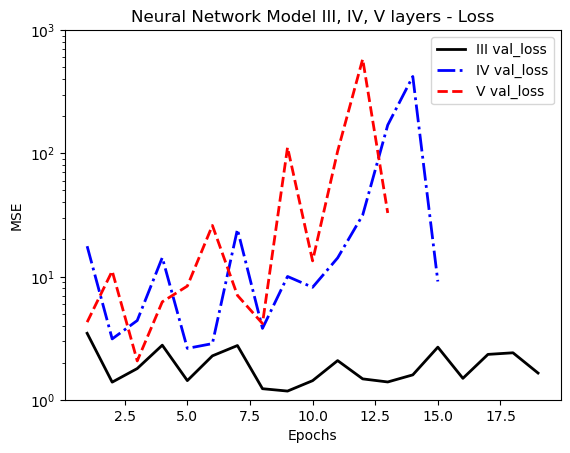

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_3(hist_III,hist_IV,hist_V,'val_loss')

In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_3(history1, history2, history3, parameter):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][1:],history1[parameter][1:], "k-", linewidth=2, label='III '+parameter)
  plt.plot(history2['epoch'][1:],history2[parameter][1:], "b-.", linewidth=2, label='IV '+parameter)
  plt.plot(history3['epoch'][1:],history3[parameter][1:], "r--", linewidth=2, label='V '+parameter)
  plt.legend()
  plt.ylim(0.5,1.4)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")
  plt.title(f'Neural Network Model III, IV, V layers - Loss')

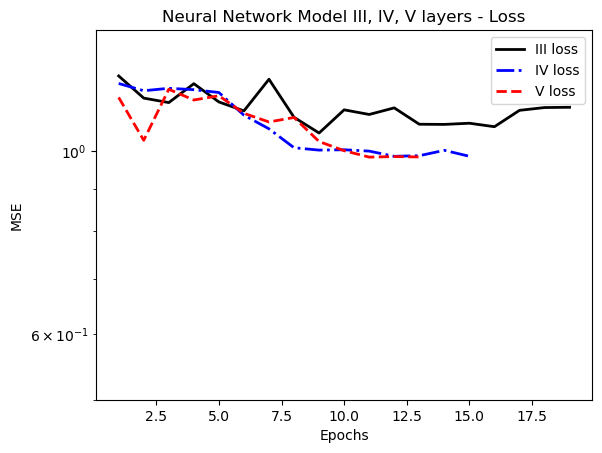

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_3(hist_III,hist_IV,hist_V,'loss')

In [ ]:
#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model_III.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the model with 3 layers in the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

--------------------------------------------------------
MAE for the model with 3 layers in the entire training dataset:  0.5993703007698059
--------------------------------------------------------


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_4(history1, parameter1, parameter2, model):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][10:],history1[parameter1][10:], "k-", linewidth=2, label=model +' CV test')
  plt.plot(history1['epoch'][10:],history1[parameter2][10:], "b-.", linewidth=2, label=model +' training')
  plt.legend()
  plt.ylim(1,10)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")
  plt.title(f'Neural Network Model {model} Loss')

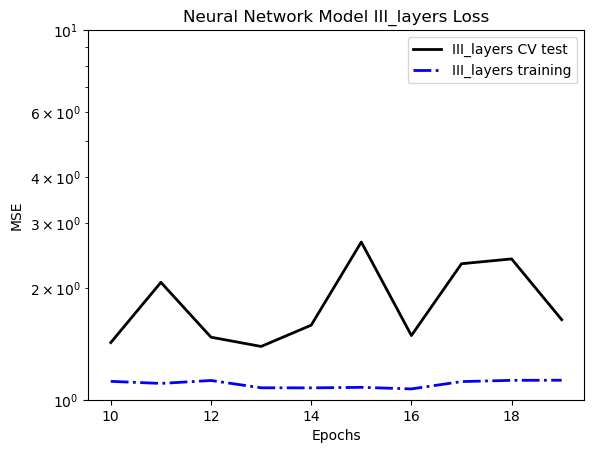

In [ ]:
plot_learning_curves_4(hist_III, 'val_loss', 'loss', 'III_layers')

In [ ]:
#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model_IV.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the model with 4 layers in the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

--------------------------------------------------------
MAE for the model with 4 layers in the entire training dataset:  0.8757178783416748
--------------------------------------------------------


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_4(history1, parameter1, parameter2, model):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][10:],history1[parameter1][10:], "k-", linewidth=2, label=model +' CV test')
  plt.plot(history1['epoch'][10:],history1[parameter2][10:], "b-.", linewidth=2, label=model +' training')
  plt.legend()
  plt.ylim(0.5,1000)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")
  plt.title(f'Neural Network Model {model} Loss')

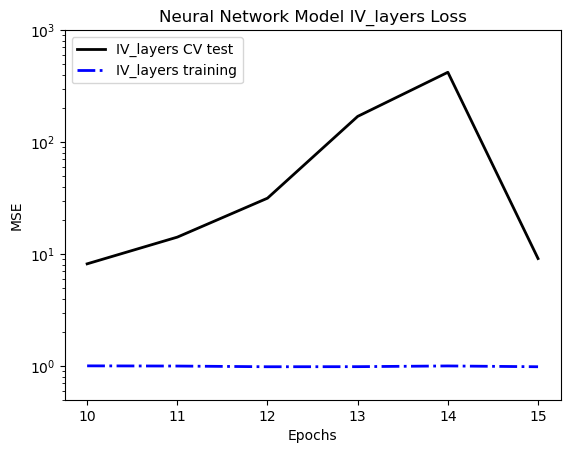

In [ ]:
plot_learning_curves_4(hist_IV, 'val_loss', 'loss', 'IV_layers')

In [ ]:
#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model_V.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the model with 5 layers in the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

--------------------------------------------------------
MAE for the model with 5 layers in the entire training dataset:  0.7027973532676697
--------------------------------------------------------


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_4(history1, parameter1, parameter2, model):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][10:],history1[parameter1][10:], "k-", linewidth=2, label=model +' CV test')
  plt.plot(history1['epoch'][10:],history1[parameter2][10:], "b-.", linewidth=2, label=model +' training')
  plt.legend()
  plt.ylim(0.5,1000)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")
  plt.title(f'Neural Network Model {model} Loss')

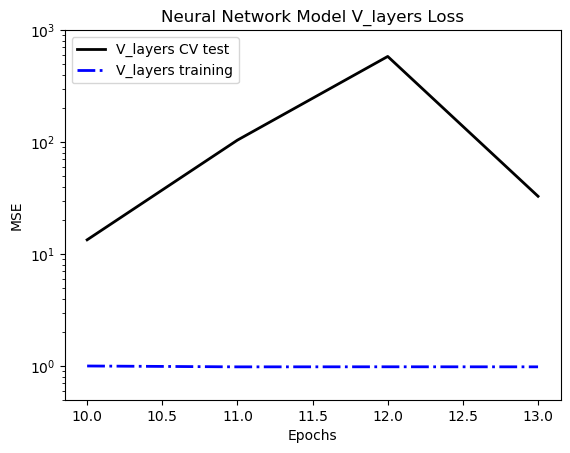

In [ ]:
plot_learning_curves_4(hist_V, 'val_loss', 'loss', 'V_layers')

### Training - CV curves II

In [ ]:
def plot_history(history, model):
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')
    plt.title(f'Neural Network Model {model} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

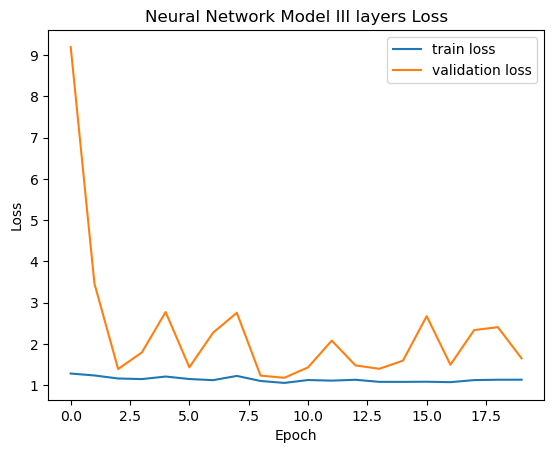

In [ ]:
plot_history(hist_III, 'III layers')

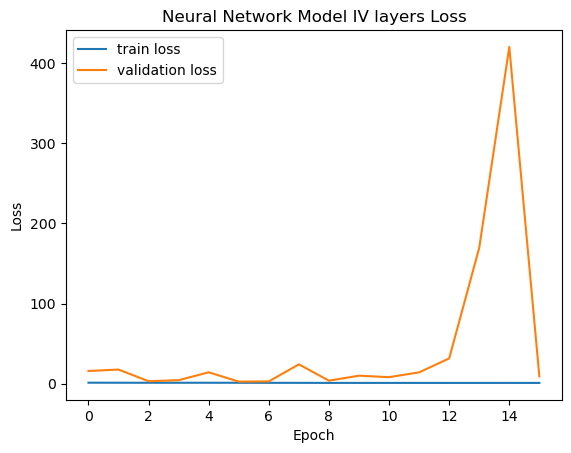

In [ ]:
plot_history(hist_IV, 'IV layers')

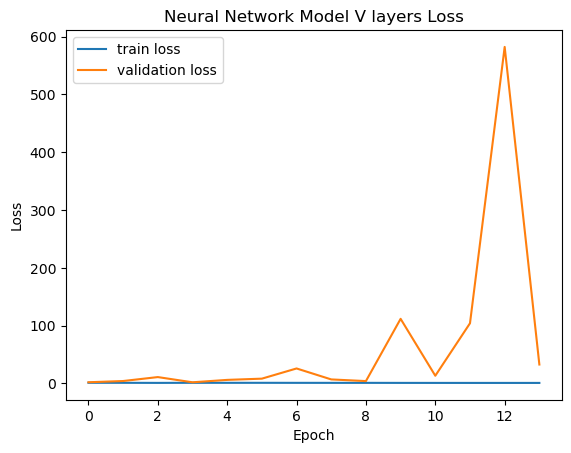

In [ ]:
plot_history(hist_V, 'V layers')

### Conclusions - training and CV

### Checking the Predictive Accuracy on Test Data with the base model

        Before fine-tuning our model, lets see the its current performance. For that purpose, we will investigate the variations between the predictions and the true values on scatter plots and histograms.

514/514 [==============================] - 4s 6ms/step


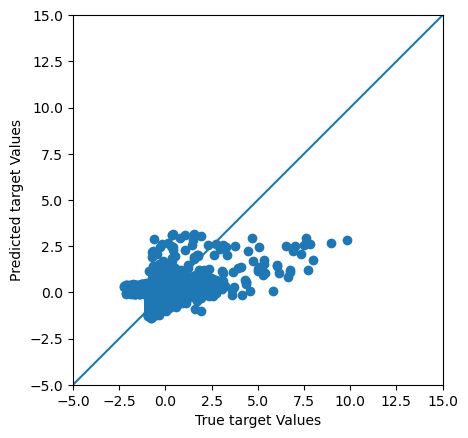

In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_III.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

514/514 [==============================] - 2s 4ms/step


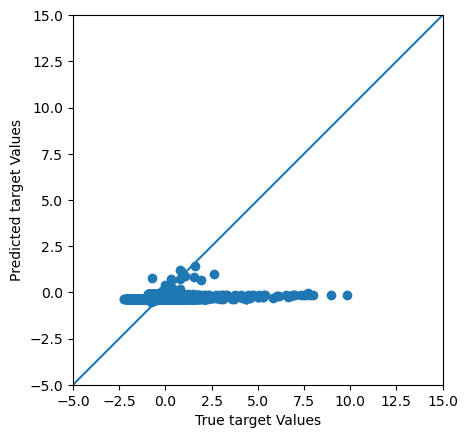

In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_IV.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

514/514 [==============================] - 2s 4ms/step


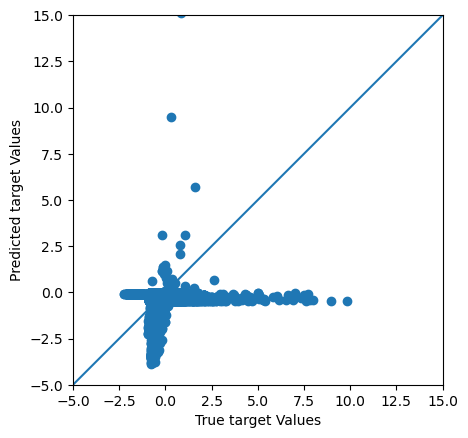

In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_V.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Neural Network Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

In [ ]:
evaluate_model(model_III, X_test, y_test)

In [ ]:
evaluate_model(model_IV, X_test, y_test)

514/514 [==============================] - 2s 4ms/step
Neural Network Model Performance
R2 Score:  -0.008449745508258166
MSE:  0.26345615224396574
RMSE:  0.513279799177764


In [ ]:
evaluate_model(model_V, X_test, y_test)

514/514 [==============================] - 2s 4ms/step
Neural Network Model Performance
R2 Score:  -0.7860713172294638
MSE:  0.4666087516670732
RMSE:  0.6830876603094753


Text(0, 0.5, 'Count')

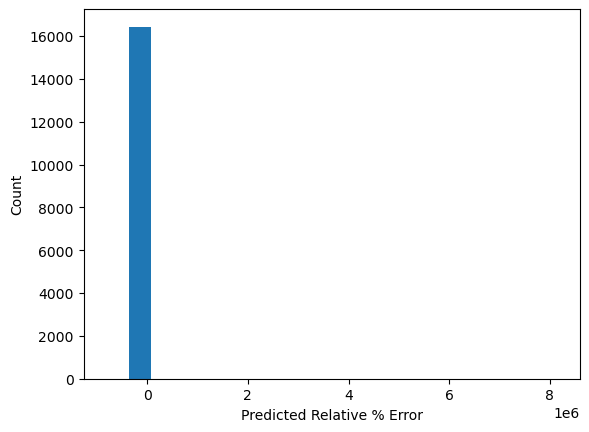

In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolute percentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

697.4346064770723

### Conclusions - Testing

# NN V - Adding weight regularization
        The model architectures were modified, and Early Stopping was implemented to address overfitting. The effectiveness of the modifications was evaluated on the validation set.

        To further tackle overfitting, weight regularization techniques such as L1 and L2 regularization can be utilized. These techniques add a penalty to the loss function for large weights, thereby reducing overfitting. L1 regularization technique adds a penalty proportional to the absolute value of the weights, whereas L2 regularization technique adds a penalty proportional to the square of the weights.

        By implementing weight regularization techniques, the generalization performance of the models can be improved and overfitting can be prevented. To evaluate the performance of the models, the same metrics as before can be used, such as training and validation loss, mean absolute error (MAE), mean squared error (MSE), and training and validation times.

        In addition to L1 and L2 regularization, another regularization technique that could be considered is dropout regularization, which randomly drops out some of the neurons during training to prevent overfitting. However, since we have already implemented Early Stopping, which has proven to be effective in preventing overfitting in our models, adding dropout regularization may not be necessary.


In [ ]:
def build_model_base_III():
    # Here we will use Sequential API
    model = models.Sequential([
        layers.Dense(32, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(32, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1)
    ])
    optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004, clipvalue=3.0, clipnorm=1)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [ ]:
def build_model_base_IV():
    # Here we will use Sequential API
    model = models.Sequential([
        layers.Dense(43, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(16, kernel_initializer='he_normal', kernel_regularizer=l1(0.01), bias_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(8, kernel_initializer='he_normal', kernel_regularizer=l1(0.01), bias_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1)
    ])
    optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004, clipvalue=3.0, clipnorm=1)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [ ]:
def build_model_base_V():
    # Here we will use Sequential API
    model = models.Sequential([
        layers.Dense(43, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(32, kernel_initializer='he_normal', kernel_regularizer=l1(0.01), bias_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(16, kernel_initializer='he_normal', kernel_regularizer=l1(0.01), bias_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(8, kernel_initializer='he_normal', kernel_regularizer=l1(0.01), bias_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(1)
    ])
    optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004, clipvalue=3.0, clipnorm=1)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [ ]:
#Looking into model structure:
build_model_base().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                960       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               1

In [ ]:
build_model_base_IV().summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 43)                1892      
                                                                 
 batch_normalization_99 (Bat  (None, 43)               172       
 chNormalization)                                                
                                                                 
 dense_134 (Dense)           (None, 16)                704       
                                                                 
 batch_normalization_100 (Ba  (None, 16)               64        
 tchNormalization)                                               
                                                                 
 leaky_re_lu_64 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_135 (Dense)           (None, 8)               

In [ ]:
build_model_base_V().summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_137 (Dense)           (None, 43)                1892      
                                                                 
 batch_normalization_102 (Ba  (None, 43)               172       
 tchNormalization)                                               
                                                                 
 dense_138 (Dense)           (None, 32)                1408      
                                                                 
 batch_normalization_103 (Ba  (None, 32)               128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 32)                0         
                                                                 
 dense_139 (Dense)           (None, 16)              

### Epoch and Batch Size

In [ ]:
num_epochs = 100
batch_size = 10

In [ ]:
import time

# Define the number of folds for cross-validation
n_splits = 10

# Define the number of times to repeat the k-fold process
n_repeats = 1

# Create a KFold object with shuffling
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists for storing scores and training times
training_times_III = []
training_scores_III = []
cv_scores_III = []

# DataFrame for storing predictions based on each fold
predictions_based_on_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

# Loop over the folds and fit the model
for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
    print("Training fold", fold+1)
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    # Building the Keras model - Lower
    model_III = build_model_base_III()
    # Defining callbacks
    my_early_stopping_III = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # my_checkpoint_III = ModelCheckpoint("my_best_model_III.h5", save_best_only=True)
    # Training step
    start_time_III = time.time()
    history_III = model_III.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0, callbacks=[my_early_stopping_III])
    training_time_III = time.time() - start_time_III
    training_scores_III.append(history_III.history["loss"])
    cv_scores_III.append(history_III.history["val_loss"])
    training_times_III.append(training_time_III)
    # Evaluation
    train_mae_III, train_mse_III = model_III.evaluate(X_train_fold, y_train_fold, verbose=0)
    cv_mae_III, cv_mse_III = model_III.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    # Print model performance and training time
    print(f"Model III - Training time: {training_time_III:.2f} sec - Train MSE: {train_mse_III:.2f} - CV MSE: {cv_mse_III:.2f} - Train MAE: {train_mae_III:.2f} - CV MAE: {cv_mae_III:.2f}")

Training fold 1
Model III - Training time: 501.58 sec - Train MSE: 0.63 - CV MSE: 0.62 - Train MAE: 1.13 - CV MAE: 1.12
Training fold 2
Model III - Training time: 678.29 sec - Train MSE: 0.62 - CV MSE: 0.61 - Train MAE: 1.08 - CV MAE: 0.93
Training fold 3
Model III - Training time: 1269.71 sec - Train MSE: 0.59 - CV MSE: 0.58 - Train MAE: 1.06 - CV MAE: 0.97
Training fold 4
Model III - Training time: 846.66 sec - Train MSE: 0.56 - CV MSE: 0.57 - Train MAE: 1.01 - CV MAE: 1.08
Training fold 5
Model III - Training time: 743.16 sec - Train MSE: 0.59 - CV MSE: 0.58 - Train MAE: 1.07 - CV MAE: 0.96
Training fold 6
Model III - Training time: 1079.67 sec - Train MSE: 0.57 - CV MSE: 0.56 - Train MAE: 1.00 - CV MAE: 1.00
Training fold 7
Model III - Training time: 1193.95 sec - Train MSE: 0.59 - CV MSE: 0.61 - Train MAE: 0.91 - CV MAE: 1.07
Training fold 8
Model III - Training time: 1072.76 sec - Train MSE: 0.59 - CV MSE: 0.57 - Train MAE: 0.94 - CV MAE: 0.83
Training fold 9
Model III - Training

In [ ]:
import time

# Define the number of folds for cross-validation
n_splits = 10

# Define the number of times to repeat the k-fold process
n_repeats = 1

# Create a KFold object with shuffling
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists for storing scores and training times
training_times_IV = []
training_scores_IV = []
cv_scores_IV = []


# DataFrame for storing predictions based on each fold
predictions_based_on_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

# Loop over the folds and fit the model
for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
    print("Training fold", fold+1)
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    # Building the Keras model - Base
    model_IV = build_model_base_IV()
    # Defining callbacks
    my_early_stopping_IV = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # my_checkpoint_IV = ModelCheckpoint("my_best_model_IV.h5", save_best_only=True)
    # Training step
    start_time_IV = time.time()
    history_IV = model_IV.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0, callbacks=[my_early_stopping_IV])
    training_time_IV = time.time() - start_time_IV
    training_scores_IV.append(history_IV.history["loss"])
    cv_scores_IV.append(history_IV.history["val_loss"])
    training_times_IV.append(training_time_IV)
    # Evaluation
    train_mae_IV, train_mse_IV = model_IV.evaluate(X_train_fold, y_train_fold, verbose=0)
    cv_mae_IV, cv_mse_IV = model_IV.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    # Print model performance and training time
    print(f"Model IV - Training time: {training_time_IV:.2f} sec - Train MSE: {train_mse_IV:.2f} - CV MSE: {cv_mse_IV:.2f} - Train MAE: {train_mae_IV:.2f} - CV MAE: {cv_mae_IV:.2f}")

Training fold 1
Model IV - Training time: 915.39 sec - Train MSE: 0.65 - CV MSE: 0.65 - Train MAE: 1.10 - CV MAE: 1.12
Training fold 2
Model IV - Training time: 1664.53 sec - Train MSE: 0.56 - CV MSE: 0.56 - Train MAE: 1.04 - CV MAE: 0.90
Training fold 3
Model IV - Training time: 543.41 sec - Train MSE: 0.59 - CV MSE: 0.58 - Train MAE: 1.05 - CV MAE: 1.00
Training fold 4
Model IV - Training time: 632.47 sec - Train MSE: 0.67 - CV MSE: 0.69 - Train MAE: 1.23 - CV MAE: 1.24
Training fold 5
Model IV - Training time: 1322.94 sec - Train MSE: 0.57 - CV MSE: 0.54 - Train MAE: 2.14 - CV MAE: 0.85
Training fold 6
Model IV - Training time: 702.72 sec - Train MSE: 0.60 - CV MSE: 0.59 - Train MAE: 1.06 - CV MAE: 1.04
Training fold 7
Model IV - Training time: 1023.37 sec - Train MSE: 0.60 - CV MSE: 0.62 - Train MAE: 1.06 - CV MAE: 1.21
Training fold 8
Model IV - Training time: 983.55 sec - Train MSE: 0.56 - CV MSE: 0.55 - Train MAE: 1.03 - CV MAE: 0.89
Training fold 9
Model IV - Training time: 699

In [ ]:
import time

# Define the number of folds for cross-validation
n_splits = 10

# Define the number of times to repeat the k-fold process
n_repeats = 1

# Create a KFold object with shuffling
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists for storing scores and training times
training_times_V = []
training_scores_V = []
cv_scores_V = []

# DataFrame for storing predictions based on each fold
predictions_based_on_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

# Loop over the folds and fit the model
for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
    print("Training fold", fold+1)
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

    # Building the Keras models - Higher
    model_V = build_model_base_V()
    # Defining callbacks
    my_early_stopping_V = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # my_checkpoint_V = ModelCheckpoint("my_best_model_V.h5", save_best_only=True)
    # Training step
    start_time_V = time.time()
    history_V = model_V.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0, callbacks=[my_early_stopping_V])
    training_time_V = time.time() - start_time_V
    training_scores_V.append(history_V.history["loss"])
    cv_scores_V.append(history_V.history["val_loss"])
    training_times_V.append(training_time_V)
    # Evaluation
    train_mae_V, train_mse_V = model_V.evaluate(X_train_fold, y_train_fold, verbose=0)
    cv_mae_V, cv_mse_V = model_V.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    # Print model performance and training time
    print(f"Model V - Training time: {training_time_V:.2f} sec - Train MSE: {train_mse_V:.2f} - CV MSE: {cv_mse_V:.2f} - Train MAE: {train_mae_V:.2f} - CV MAE: {cv_mae_V:.2f}")
    print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------") 


Training fold 1
Model V - Training time: 2296.91 sec - Train MSE: 0.71 - CV MSE: 0.72 - Train MAE: 1.30 - CV MAE: 1.31
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Training fold 2
Model V - Training time: 1160.09 sec - Train MSE: 0.60 - CV MSE: 0.59 - Train MAE: 1.08 - CV MAE: 0.95
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Training fold 3
Model V - Training time: 947.19 sec - Train MSE: 0.65 - CV MSE: 0.62 - Train MAE: 1.09 - CV MAE: 0.99
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Training fold 4
Model V - Training time: 1109.54 sec 

In [ ]:
hist_IV = pd.DataFrame(history_IV.history)
# Get the number of epochs from the 'history' dataframe
epochs_IV = len(hist_IV)
# Add an 'epoch' column to the 'history' dataframe
hist_IV['epoch'] = range(epochs_IV)

hist_III = pd.DataFrame(history_III.history)
# Get the number of epochs from the 'history' dataframe
epochs_III = len(hist_III)
# Add an 'epoch' column to the 'history' dataframe
hist_III['epoch'] = range(epochs_III)

hist_V = pd.DataFrame(history_V.history)
# Get the number of epochs from the 'history' dataframe
epochs_V = len(hist_V)
# Add an 'epoch' column to the 'history' dataframe
hist_V['epoch'] = range(epochs_V)



In [ ]:
hist_III.tail(5)

loss       mae  val_loss   val_mae  epoch
12  1.134493  0.629578  1.485188  0.617408     12
13  1.084908  0.602272  1.291595  0.597773     13
14  1.115894  0.617681  1.589248  0.861884     14
15  1.120954  0.615787  1.466502  0.712317     15
16  1.121927  0.619951  1.264691  0.606104     16

In [ ]:
hist_IV.tail(5)

loss       mae  val_loss   val_mae  epoch
24  1.099392  0.613118  1.617593  0.736234     24
25  1.101188  0.616303  1.426169  0.790727     25
26  1.105500  0.612244  1.442436  0.803165     26
27  1.078248  0.606398  1.282425  0.690979     27
28  1.083352  0.606750  1.303189  0.681801     28

In [ ]:
hist_V.tail(5)

loss       mae  val_loss   val_mae  epoch
9   1.164571  0.643086  1.571889  0.886184      9
10  1.174945  0.651680  1.978503  1.064391     10
11  1.162962  0.644411  1.485834  0.688041     11
12  1.160387  0.634037  1.685120  0.746548     12
13  1.132150  0.628696  1.449468  0.811157     13

### Training - CV curves I

In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_3(history1, history2, history3, parameter):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][10:],history1[parameter][10:], "k-", linewidth=2, label='III '+parameter)
  plt.plot(history2['epoch'][10:],history2[parameter][10:], "b-.", linewidth=2, label='IV '+parameter)
  plt.plot(history3['epoch'][10:],history3[parameter][10:], "r--", linewidth=2, label='V '+parameter)
  plt.legend()
  plt.ylim(1,3)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")
  plt.title(f'Neural Network Model III, IV, V layers - Loss')

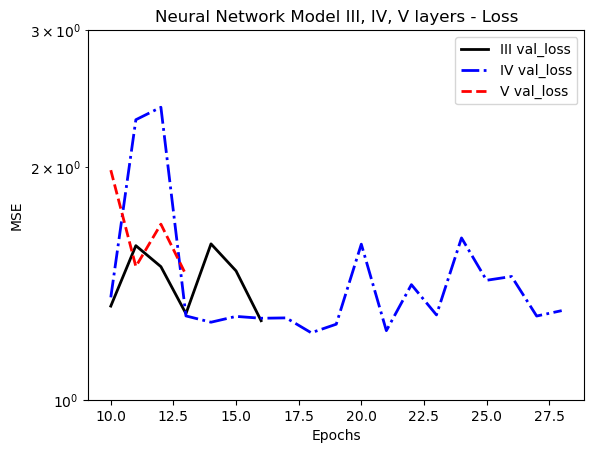

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_3(hist_III,hist_IV,hist_V,'val_loss')

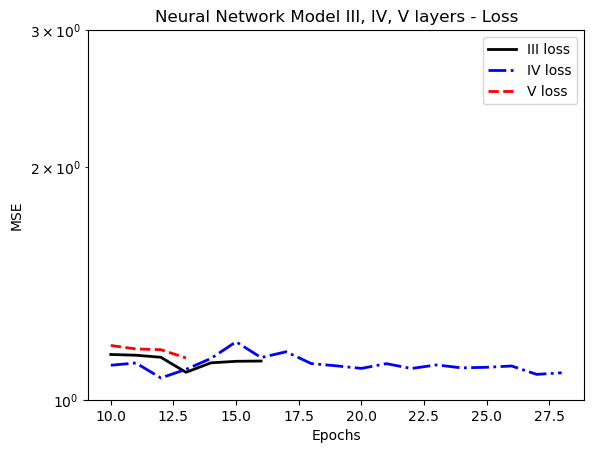

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_3(hist_III,hist_IV,hist_V,'loss')

In [ ]:
#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model_III.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the model with 3 layers in the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

--------------------------------------------------------
MAE for the model with 3 layers in the entire training dataset:  0.535413920879364
--------------------------------------------------------


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_4(history1, parameter1, parameter2, model):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][10:],history1[parameter1][10:], "k-", linewidth=2, label=model +' CV Test')
  plt.plot(history1['epoch'][10:],history1[parameter2][10:], "b-.", linewidth=2, label=model +' Training')
  plt.legend()
  plt.ylim(1,10)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")
  plt.title(f'Neural Network Model {model} Loss')

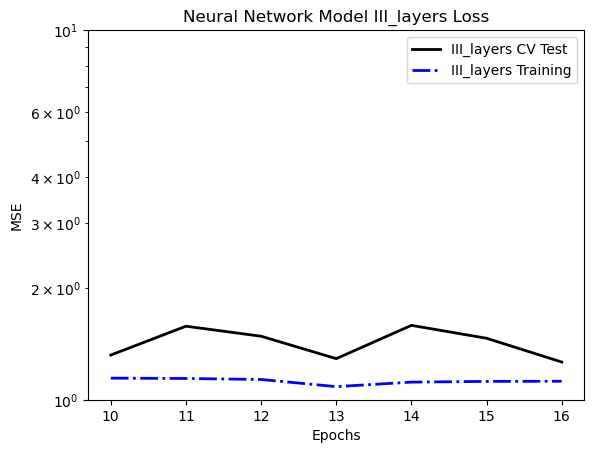

In [ ]:
plot_learning_curves_4(hist_III, 'val_loss', 'loss', 'III_layers')

In [ ]:
#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model_IV.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the model with 4 layers in the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

--------------------------------------------------------
MAE for the model with 4 layers in the entire training dataset:  0.5891269445419312
--------------------------------------------------------


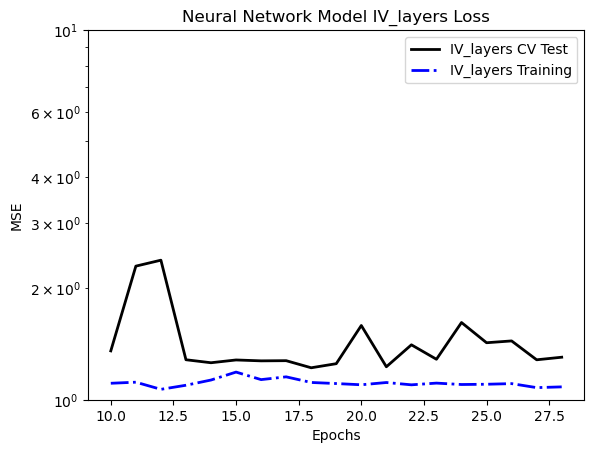

In [ ]:
plot_learning_curves_4(hist_IV, 'val_loss', 'loss', 'IV_layers')

In [ ]:
#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model_V.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the model with 5 layers in the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

--------------------------------------------------------
MAE for the model with 5 layers in the entire training dataset:  0.6011192798614502
--------------------------------------------------------


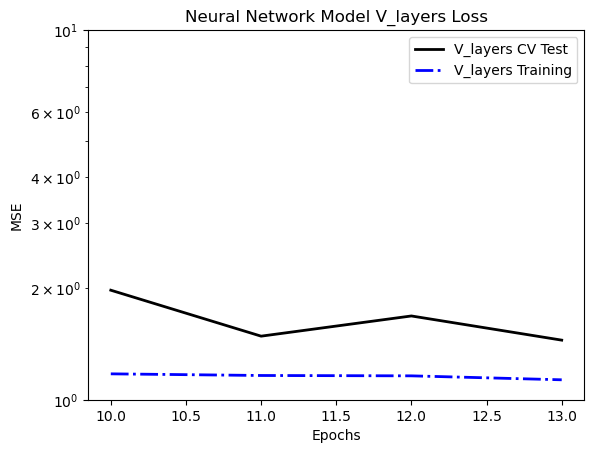

In [ ]:
plot_learning_curves_4(hist_V, 'val_loss', 'loss', 'V_layers')

### Training - CV curves II

In [ ]:
def plot_history(history, model):
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')
    plt.title(f'Neural Network Model {model} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

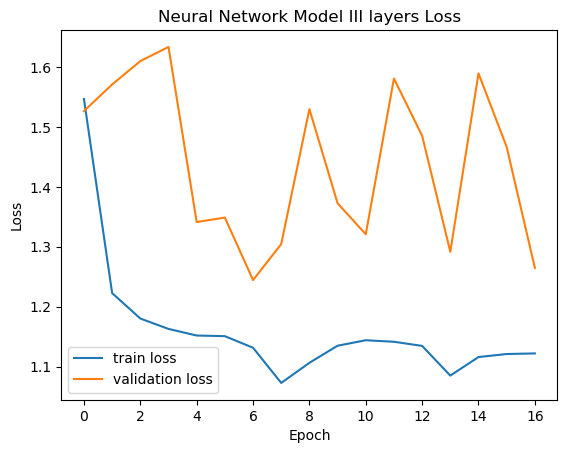

In [ ]:
plot_history(hist_III, 'III layers')

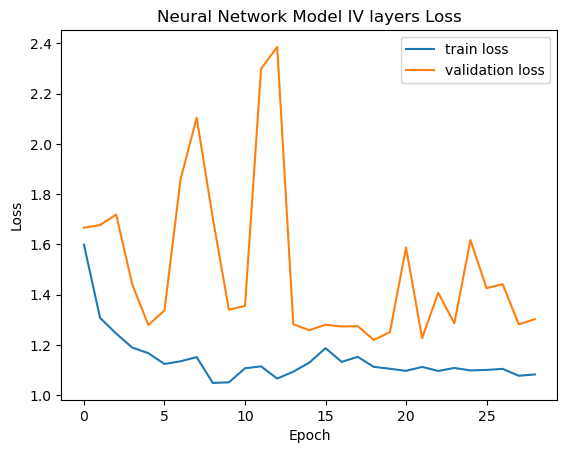

In [ ]:
plot_history(hist_IV, 'IV layers')

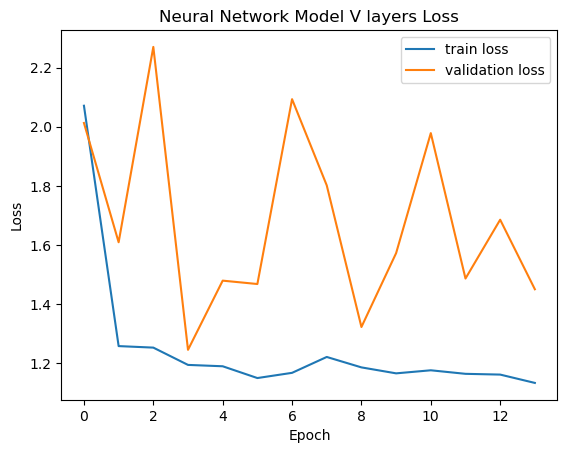

In [ ]:
plot_history(hist_V, 'V layers')

### Conclusions

### Checking the Predictive Accuracy on Test Data with the base model

        Before fine-tuning our model, lets see the its current performance. For that purpose, we will investigate the variations between the predictions and the true values on scatter plots and histograms.

514/514 [==============================] - 2s 3ms/step


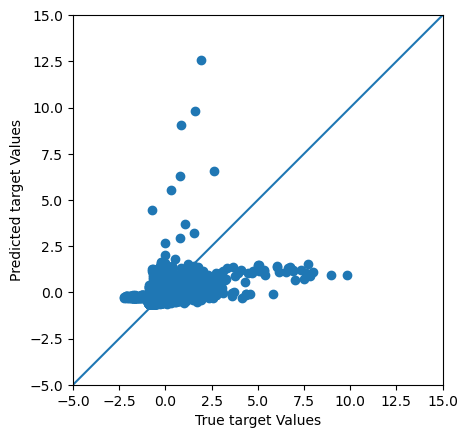

In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_III.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

514/514 [==============================] - 2s 4ms/step


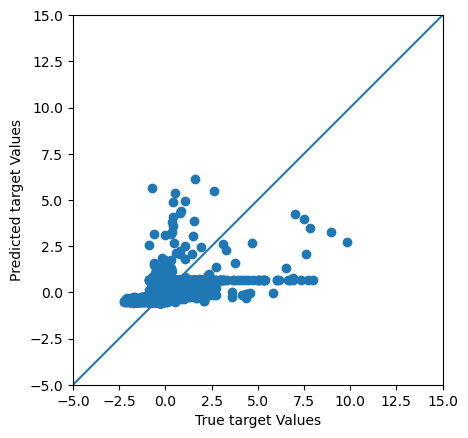

In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_IV.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

514/514 [==============================] - 3s 5ms/step


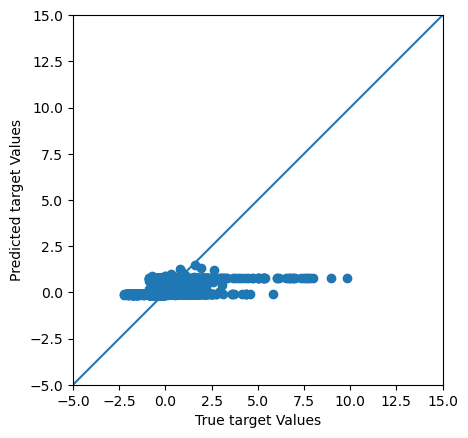

In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_V.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Neural Network Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

In [ ]:
evaluate_model(model_III, X_test, y_test)

514/514 [==============================] - 2s 4ms/step
Neural Network Model Performance
R2 Score:  0.17731303033757662
MSE:  0.2149258745851261
RMSE:  0.46360098639360775


In [ ]:
evaluate_model(model_IV, X_test, y_test)

514/514 [==============================] - 2s 4ms/step
Neural Network Model Performance
R2 Score:  0.1472479864780999
MSE:  0.22278032723142202
RMSE:  0.4719961093392847


In [ ]:
evaluate_model(model_V, X_test, y_test)

514/514 [==============================] - 2s 5ms/step
Neural Network Model Performance
R2 Score:  -0.11812865436684428
MSE:  0.29210962103495275
RMSE:  0.5404716653395928


Text(0, 0.5, 'Count')

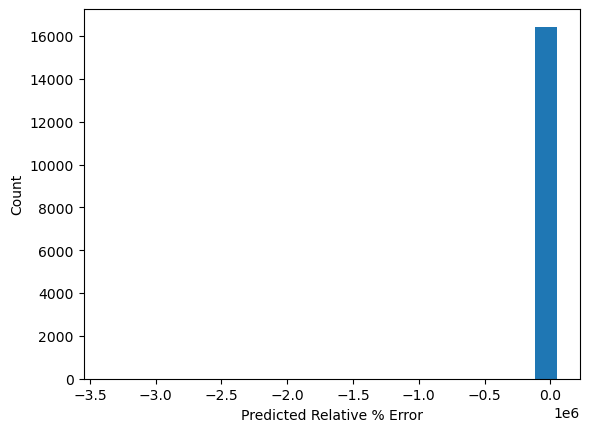

In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolute percentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

-597.187946512959

### Conclusions

        In the models considered, the selection of activation functions has been a careful process to address the issue of vanishing gradients, which is a common problem in deep learning. During training, the gradients can become progressively smaller as the algorithm moves down to lower layers, resulting in weight updates in lower layers no longer taking place. This can lead to poor or no convergence to a good solution. Additionally, as the data has been normalized around zero, there are numerous negative values, which can cause many neurons to become inactive when using ReLU activation function. This is because ReLU sets negative inputs to zero, effectively disabling the neuron, which can lead to the vanishing gradient problem. Therefore, alternative activation functions such as Leaky ReLU, ELU, and SELU have been proposed to mitigate these issues and improve performance.

        In these models, the activation function used was SELU, which is known to perform better than other activation functions when implemented carefully. It is crucial to standardize the input features to have a mean of 0 and standard deviation of 1, initialize every hidden dense layer with LeCun normal initialization and use a sequential architecture.

        Additionally, batch normalization was employed to adaptively normalize data, even as the mean and variance changes during training. This helps with gradient propagation and enables deeper networks with fewer gradient descent issues. The command layers.BatchNormalization() was used to implement batch normalization in these models.

# NN VI - Baseline

        The model architectures were modified, and Early Stopping was implemented to address overfitting. The effectiveness of the modifications was evaluated on the validation set.

        To further tackle overfitting, weight regularization techniques such as L1 and L2 regularization can be utilized. These techniques add a penalty to the loss function for large weights, thereby reducing overfitting. L1 regularization technique adds a penalty proportional to the absolute value of the weights, whereas L2 regularization technique adds a penalty proportional to the square of the weights.

        By implementing weight regularization techniques, the generalization performance of the models can be improved and overfitting can be prevented. To evaluate the performance of the models, the same metrics as before can be used, such as training and validation loss, mean absolute error (MAE), mean squared error (MSE), and training and validation times.

        In addition to L1 and L2 regularization, another regularization technique that could be considered is dropout regularization, which randomly drops out some of the neurons during training to prevent overfitting. However, since we have already implemented Early Stopping, which has proven to be effective in preventing overfitting in our models, adding dropout regularization may not be necessary.


In [ ]:
def build_model_base():
    # Here we will use Sequential API
    model = models.Sequential([
        layers.Dense(32, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [ ]:
#Looking into model structure:
build_model_base().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                960       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               1

### Epoch and Batch Size

In [ ]:
num_epochs = 100
batch_size = 10

In [ ]:
import time

# Define the number of folds for cross-validation
n_splits = 5

# Define the number of times to repeat the k-fold process
n_repeats = 1

# Create a KFold object with shuffling
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists for storing scores and training times
training_times_base = []
training_scores_base = []
cv_scores_base = []

# DataFrame for storing predictions based on each fold
predictions_based_on_folds = pd.DataFrame(data=[], index=y_train.index, columns=[0, 1])

# Loop over the folds and fit the model
for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
    print("Training fold", fold+1)
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

    # Building the Keras model - Lower
    model_base = build_model_base()
    # Defining callbacks
    # my_early_stopping_base = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # my_checkpoint_base = ModelCheckpoint("my_best_model_base.h5", save_best_only=True)
    # Training step
    start_time_base = time.time()
    # history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0, callbacks=[my_early_stopping_base])
    history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)
    training_time_base = time.time() - start_time_base
    training_scores_base.append(history_base.history["loss"])
    cv_scores_base.append(history_base.history["val_loss"])
    training_times_base.append(training_time_base)
    # Evaluation
    train_mae_base, train_mse_base = model_base.evaluate(X_train_fold, y_train_fold, verbose=0)
    cv_mae_base, cv_mse_base = model_base.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    # Print model performance and training time
    print(f"Model Base - Training time: {training_time_base:.2f} sec - Train MSE: {train_mse_base:.2f} - CV MSE: {cv_mse_base:.2f} - Train MAE: {train_mae_base:.2f} - CV MAE: {cv_mae_base:.2f}")


Training fold 1
Model Base - Training time: 1597.02 sec - Train MSE: 2.00 - CV MSE: 2.21 - Train MAE: 1091.58 - CV MAE: 261.22
Training fold 2
Model Base - Training time: 1586.78 sec - Train MSE: 0.86 - CV MSE: 0.86 - Train MAE: 1.57 - CV MAE: 1.46
Training fold 3
Model Base - Training time: 1578.64 sec - Train MSE: 2.73 - CV MSE: 2.39 - Train MAE: 3454.00 - CV MAE: 354.31
Training fold 4
Model Base - Training time: 1988.72 sec - Train MSE: 1.47 - CV MSE: 4.34 - Train MAE: 2232.88 - CV MAE: 35517.25
Training fold 5
Model Base - Training time: 1997.62 sec - Train MSE: 1.70 - CV MSE: 1.41 - Train MAE: 136.53 - CV MAE: 5.84


In [ ]:
hist_base = pd.DataFrame(history_base.history)
# Get the number of epochs from the 'history' dataframe
epochs_base = len(hist_base)
# Add an 'epoch' column to the 'history' dataframe
hist_base['epoch'] = range(epochs_base)

In [ ]:
hist_base.tail(5)

loss    mae  val_loss  val_mae  epoch
95 1.0178 0.5899    1.5290   0.6055     95
96 1.0180 0.5896    2.5005   0.7996     96
97 1.0195 0.5916    2.1432   0.5701     97
98 1.0257 0.5918    1.8935   0.8360     98
99 1.0074 0.5859    5.8286   1.4051     99

### Training - CV curves I

In [ ]:
#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model_base.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the Base model in the entire training dataset: ', val_mae_total)
print('MSE for the Base model in the entire training dataset: ', val_mse_total)
print('--------------------------------------------------------')

--------------------------------------------------------
MAE for the Base model in the entire training dataset:  1.6438761949539185
MSE for the Base model in the entire training dataset:  110.39325714111328
--------------------------------------------------------


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves_4(history1, parameter1, parameter2, model):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][10:],history1[parameter1][10:], "k-", linewidth=2, label=model +' CV Test')
  plt.plot(history1['epoch'][10:],history1[parameter2][10:], "b-.", linewidth=2, label=model +' Training')
  plt.legend()
  plt.ylim(1,10)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")
  plt.title(f'Neural Network Model {model} Loss')

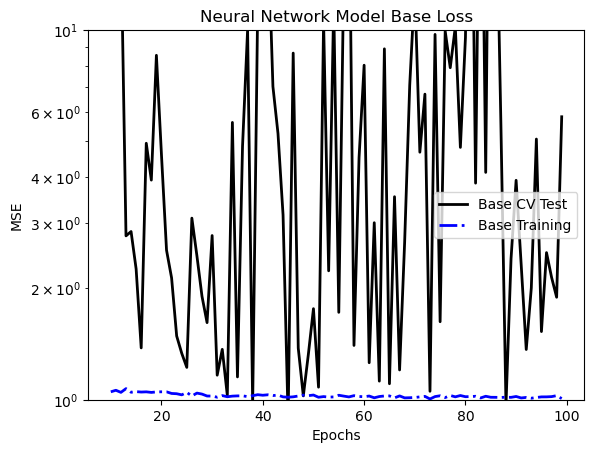

In [ ]:
plot_learning_curves_4(hist_base, 'val_loss', 'loss', 'Base')

### Training - CV curves II

In [ ]:
def plot_history(history, model):
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')
    plt.title(f'Neural Network Model {model} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

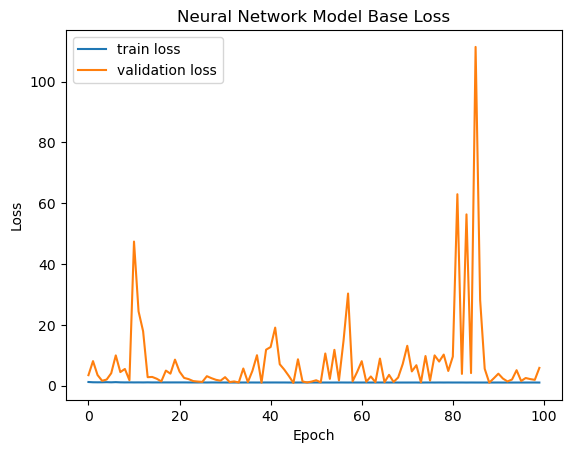

In [ ]:
plot_history(hist_base, 'Base')

### R2 calculation on the training data

In [ ]:
def get_training_r2(model, X_train, y_train):
    y_train_pred = model.predict(X_train)
    r2 = r2_score(y_train, y_train_pred)
    return r2


In [ ]:
get_training_r2(model_base, X_train, y_train)

649/649 [==============================] - 4s 5ms/step


-83.41310499369291

### Conclusions

### Checking the Predictive Accuracy on Test Data with the base model

        Before fine-tuning our model, lets see the its current performance. For that purpose, we will investigate the variations between the predictions and the true values on scatter plots and histograms.

514/514 [==============================] - 2s 3ms/step


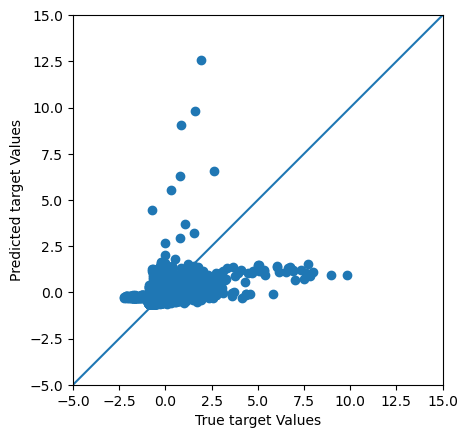

In [ ]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_base.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Neural Network Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

In [ ]:
evaluate_model(model_base, X_test, y_test)

514/514 [==============================] - 2s 4ms/step
Neural Network Model Performance
R2 Score:  0.17731303033757662
MSE:  0.2149258745851261
RMSE:  0.46360098639360775


Text(0, 0.5, 'Count')

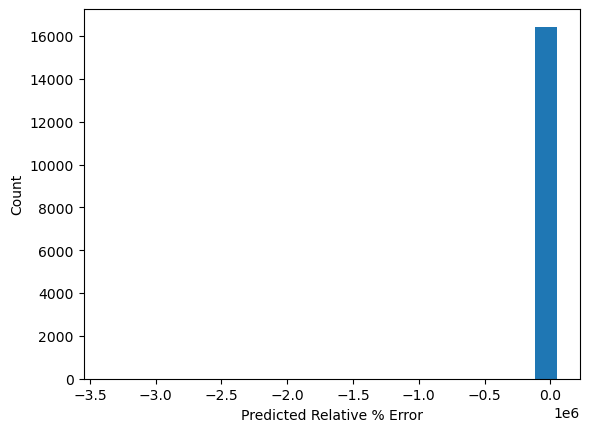

In [ ]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [ ]:
#Calculating the mean absolute percentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

-597.187946512959

### Conclusions

        In the models considered, the selection of activation functions has been a careful process to address the issue of vanishing gradients, which is a common problem in deep learning. During training, the gradients can become progressively smaller as the algorithm moves down to lower layers, resulting in weight updates in lower layers no longer taking place. This can lead to poor or no convergence to a good solution. Additionally, as the data has been normalized around zero, there are numerous negative values, which can cause many neurons to become inactive when using ReLU activation function. This is because ReLU sets negative inputs to zero, effectively disabling the neuron, which can lead to the vanishing gradient problem. Therefore, alternative activation functions such as Leaky ReLU, ELU, and SELU have been proposed to mitigate these issues and improve performance.

        In these models, the activation function used was SELU, which is known to perform better than other activation functions when implemented carefully. It is crucial to standardize the input features to have a mean of 0 and standard deviation of 1, initialize every hidden dense layer with LeCun normal initialization and use a sequential architecture.

        Additionally, batch normalization was employed to adaptively normalize data, even as the mean and variance changes during training. This helps with gradient propagation and enables deeper networks with fewer gradient descent issues. The command layers.BatchNormalization() was used to implement batch normalization in these models.

# XGBoost decision-tree
        XGBoost (eXtreme Gradient Boosting) is a popular machine learning algorithm that belongs to the family of boosting algorithms. It is an implementation of gradient boosted decision trees designed for speed and performance.

        It works by constructing a large number of decision trees, each of which predicts the value of the target variable based on a set of input features. Each tree is built iteratively, with the algorithm seeking to improve the fit of the model at each step.

        At each iteration, XGBoost adds a new tree to the ensemble in order to reduce the residual errors from the previous iteration. The algorithm assigns weights to each of the examples based on how well they were predicted by the previous trees. Examples that were poorly predicted receive higher weights, so that the new tree will focus on these examples and try to reduce their errors.

        In order to improve the generalization of the model and avoid overfitting, XGBoost employs a technique called regularization. This involves adding a penalty term to the objective function that is optimized by the algorithm. The penalty term depends on the complexity of the trees in the ensemble, and helps to prevent the model from becoming too complex and fitting noise in the data.


In [2534]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

# Define the model
model = xgb.XGBRegressor(
    # objective='reg:squarederror', # Use squared error loss for regression
    # n_estimators=130, # Number of trees in the model
    # max_depth=10, # Maximum depth of each tree
    # learning_rate=0.1, # Learning rate (shrinkage factor) for each step
    # subsample=0.8, # Fraction of data points to use for each tree
    # colsample_bytree=0.8, # Fraction of features to use for each tree
    # random_state=42 # Set random seed for reproducibility
    objective='reg:squarederror',
    n_estimators=200,  # Increased number of trees
    max_depth=10,  # Reduced maximum depth
    learning_rate=0.1,  # Reduced learning rate
    subsample=1,
    colsample_bytree=0.6,
    # reg_alpha=1,  # Increased L1 regularization
    # reg_lambda=1,  # Increased L2 regularization
    random_state=42
)

# Perform KFold CV with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and CV losses
train_losses = []
cv_losses = []
train_maes = []
cv_maes = []
train_r2 = []

# Loop over each fold
for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
    print("Training fold", fold+1)
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    # Train the model
    eval_set = [(X_train_fold, y_train_fold), (X_cv_fold, y_cv_fold)]
    model.fit(X_train_fold, y_train_fold, eval_metric=['rmse', 'mae'], eval_set=eval_set, verbose=False)
    # model.fit(X_train, y_train, eval_metric=['rmse', 'mae'], verbose=False)
    
    # Evaluate the model on the training set
    y_pred_train = model.predict(X_train_fold)
    mse_train = mean_squared_error(y_train_fold, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    train_losses.append(rmse_train)
    mae_train = mean_absolute_error(y_train_fold, y_pred_train)
    train_maes.append(mae_train)
    r2_train = r2_score(y_train_fold, y_pred_train)
    train_r2.append(r2_train)
    
    # Evaluate the model on the CV set
    y_pred_cv = model.predict(X_cv_fold)
    mse_cv = mean_squared_error(y_cv_fold, y_pred_cv)
    rmse_cv = np.sqrt(mse_cv)
    
    cv_losses.append(rmse_cv)
    mae_cv = mean_absolute_error(y_cv_fold, y_pred_cv)
    cv_maes.append(mae_cv)
    

avg_train_rmse = np.mean(train_losses)
avg_cv_rmse = np.mean(cv_losses)
avg_train_mae = np.mean(train_maes)
avg_cv_mae = np.mean(cv_maes)
avg_train_r2 = np.mean(train_r2)


# Print the mean training and CV losses

print("Train RMSE: {:.4f}, CV RMSE: {:.4f}".format(rmse_train, rmse_cv))
print("Train MAE: {:.4f}, CV MAE: {:.4f}".format(mae_train, mae_cv))
print("Train R2: {:.4f}".format(r2_train))

print("\nAverage Train RMSE: {:.4f}, Average CV RMSE: {:.4f}".format(avg_train_rmse, avg_cv_rmse))
print("Average Train MAE: {:.4f}, Average CV MAE: {:.4f}".format(avg_train_mae, avg_cv_mae))
print("Average Train R2: {:.4f}".format(avg_train_r2))



Training fold 1


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training fold 2


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training fold 3


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training fold 4


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training fold 5


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE: 0.2057, CV RMSE: 0.6641
Train MAE: 0.1367, CV MAE: 0.3656
Train R2: 0.9692

Average Train RMSE: 0.1989, Average CV RMSE: 0.7279
Average Train MAE: 0.1329, Average CV MAE: 0.3753
Average Train R2: 0.9699


    If the target values are scaled with a Gaussian distribution such that they have a mean of 0 and a standard deviation of 1, then the absolute values of the mean squared error (MSE) and mean absolute error (MAE) can be interpreted as the average distance between the predicted and actual values, measured in standard deviations of the target distribution.

    For example, if the RMSE is 0.7292, and the target distribution has a standard deviation of 1, then the average distance between the predicted and actual values is 0.7292 standard deviations. This means that the predictions are not very accurate, as they are on average almost three-quarters of a standard deviation away from the true values.

    Similarly, if the MAE is 0.3818, and the target distribution has a standard deviation of 1, then the average absolute distance between the predicted and actual values is 0.3818 standard deviations. Again, this indicates that the predictions are not very accurate, as they are on average almost four-tenths of a standard deviation away from the true values.

In [2535]:
import matplotlib.pyplot as plt

def plot_cv_error(model):
    results = model.evals_result()
    num_rounds = len(results['validation_0']['rmse'])
    x_axis = range(0, num_rounds)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
    ax.plot(x_axis, results['validation_0']['mae'], label='Train MAE')
    ax.plot(x_axis, results['validation_1']['rmse'], label='CV RMSE')
    ax.plot(x_axis, results['validation_1']['mae'], label='CV MAE')
    ax.legend()
    plt.xlabel('Number of rounds')
    plt.ylabel('Error')
    plt.title('XGBoost Model Training and CV Errors')
    plt.show()



def plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax1.plot(train_losses, label='Training RMSE')
    ax1.plot(cv_losses, label='CV RMSE')
    ax1.legend()
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('RMSE')
    ax1.set_title('XGBoost Model Training and CV RMSE')

    ax2.plot(train_maes, label='Training MAE')
    ax2.plot(cv_maes, label='CV MAE')
    ax2.legend()
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('MAE')
    ax2.set_title('XGBoost Model Training and CV MAE')
    plt.show()


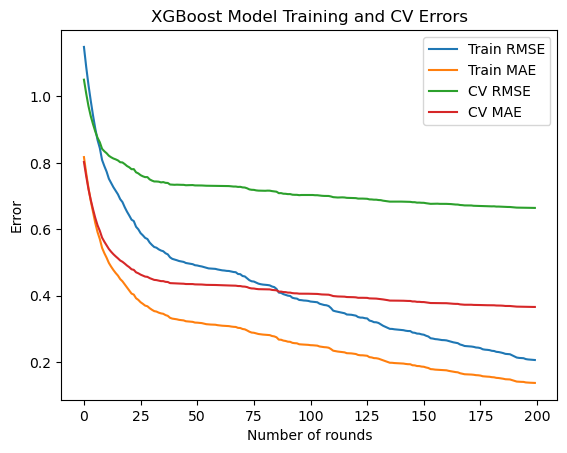

In [2495]:
plot_cv_error(model)

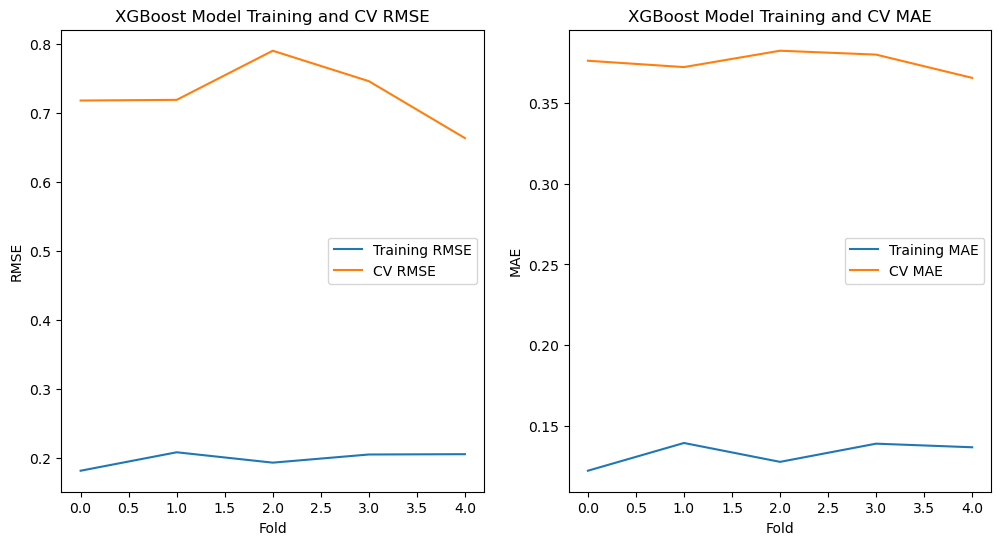

In [2496]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [2536]:
def evaluate_model_xgb(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('XGBoost Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

In [2537]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.4254853681189542
MSE:  0.11937071636160698
RMSE:  0.34550067490759984


In [2499]:
df_inter_eu[agg_var_to_disagg].iloc[0:5]

0   -0.6024
1    0.0200
2   -0.4756
3    1.0457
4    0.0085
Name: charging_stations_value, dtype: float64

In [2500]:
y_train_apply.head()

0   -0.6024
1    0.0200
2   -0.4756
3    1.0457
4    0.0085
Name: target_variable, dtype: float64

In [2501]:
df_inter_eu[agg_var_to_disagg].iloc[122:127]

122    3.0741
123    1.1955
124    1.7026
125   -0.2451
126    0.5040
Name: charging_stations_value, dtype: float64

In [2502]:
y_test_apply.head()

122    3.0741
123    1.1955
124    1.7026
125   -0.2451
126    0.5040
Name: target_variable, dtype: float64

In [2503]:
X_train_apply[agg_var_to_disagg].iloc[0:5]

0   1.5631
1   1.0083
2   1.2936
3   0.6136
4   0.5511
Name: charging_stations_value, dtype: float64

In [2504]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.13178414435654118
MSE:  0.8682158556434588
RMSE:  0.9317810127081678


In [2505]:
X_train_apply[agg_var_to_disagg].iloc[122:130]

122    0.1591
123    0.0062
124    0.0957
125   -0.0786
126    0.1022
127    0.0278
128   -0.1614
129   -0.0243
Name: charging_stations_value, dtype: float64

In [2506]:
y_predict_pop.head()

target_variable  index
122           0.1591    122
123           0.0062    123
124           0.0957    124
125          -0.0786    125
126           0.1022    126

In [2507]:
X_test_apply[agg_var_to_disagg].iloc[0:5]

122    0.1591
123    0.0062
124    0.0957
125   -0.0786
126    0.1022
Name: charging_stations_value, dtype: float64

In [2511]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.5967915417870715
MSE:  0.25499677804541065
RMSE:  0.5049720566976065


In [2513]:
y_predict_pop.head()

target_variable  index
122           0.1591    122
123           0.0062    123
124           0.0957    124
125          -0.0786    125
126           0.1022    126

In [2255]:
r2 = r2_score(y_test_apply, y_predict_pop['target_variable'])

In [2256]:
r2

0.2846751556624212

## Evaluate the model on the Test set

In [2538]:
# Evaluate the model on the test set
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("\nTest RMSE: {:.4f}".format(rmse_test))
print("Test MAE: {:.4f}".format(mae_test))
print("Test R2: {:.4f}".format(r2_test))


Test RMSE: 0.3455
Test MAE: 0.1931
Test R2: 0.4255


## Apply the model to the EU and the region of interest

In [2539]:
y_pred_apply_eu = model.predict(X_train_apply)
y_pred_apply_region = model.predict(X_test_apply)

## Create a DataFrame with the predictions

In [2540]:
pred_apply_eu = pd.DataFrame(y_pred_apply_eu, columns=['predicted_value']).reset_index(drop=True)
pred_apply_region = pd.DataFrame(y_pred_apply_region, columns=['predicted_value']).reset_index(drop=True)

In [2523]:
pred_apply_eu.head()

predicted_value
0          -0.6421
1          -0.3914
2          -0.5496
3          -0.0764
4          -0.1173

In [2524]:
pred_apply_region.head()

predicted_value
0           1.2775
1           0.1692
2           0.2879
3          -0.3813
4           0.5273

## Merge the predictions with the respective DataFrames

In [2541]:
# Merge the predictions with the respective DataFrames without considering the index
df_eu_apply_target['predicted_value'] = pred_apply_eu['predicted_value'].to_numpy()
df_region_apply_target['predicted_value'] = pred_apply_region['predicted_value'].to_numpy()

In [2526]:
df_eu_apply_target.head()

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
0             EU                AT               AT1              AT11   
1             EU                AT               AT1              AT11   
2             EU                AT               AT1              AT11   
3             EU                AT               AT1              AT12   
4             EU                AT               AT1              AT12   

  NUTS3_region_code  target_variable  index  predicted_value  
0             AT111          -0.6024      0          -0.6421  
1             AT112           0.0200      1          -0.3914  
2             AT113          -0.4756      2          -0.5496  
3             AT121           1.0457      3          -0.0764  
4             AT122           0.0085      4          -0.1173

In [2527]:
df_region_apply_target.head()

EU_region_code NUTS0_region_code NUTS1_region_code NUTS2_region_code  \
122             EU                DE               DE1              DE11   
123             EU                DE               DE1              DE11   
124             EU                DE               DE1              DE11   
125             EU                DE               DE1              DE11   
126             EU                DE               DE1              DE11   

    NUTS3_region_code  target_variable  index  predicted_value  
122             DE111           3.0741    122           1.2775  
123             DE112           1.1955    123           0.1692  
124             DE113           1.7026    124           0.2879  
125             DE114          -0.2451    125          -0.3813  
126             DE115           0.5040    126           0.5273

## Calculate the performance metrics for the disaggregated values using population weights and the model's predictions

In [2542]:
pop_rmse = np.sqrt(mean_squared_error(y_test_apply, y_predict_pop['target_variable']))
pop_mae = mean_absolute_error(y_test_apply, y_predict_pop['target_variable'])
pop_r2 = r2_score(y_test_apply, y_predict_pop['target_variable'])

model_rmse = np.sqrt(mean_squared_error(y_test_apply, df_region_apply_target['predicted_value']))
model_mae = mean_absolute_error(y_test_apply, df_region_apply_target['predicted_value'])
model_r2 = r2_score(y_test_apply, df_region_apply_target['predicted_value'])

print("\nPopulation-based Disaggregation Metrics:")
print("RMSE: {:.4f}".format(pop_rmse))
print("MAE: {:.4f}".format(pop_mae))
print("R2: {:.4f}".format(pop_r2))

print("\nModel-based Disaggregation Metrics:")
print("RMSE: {:.4f}".format(model_rmse))
print("MAE: {:.4f}".format(model_mae))
print("R2: {:.4f}".format(model_r2))


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.5050
MAE: 0.2690
R2: 0.5968


#### Conclusions        
        
        Based on the performance metrics, the XGBoost model has an R2 score of 0.44, which indicates that the model can explain 44% of the variability in the target variable. The MSE of 0.15 suggests that the model has an average squared error of 0.15, while the RMSE of 0.38 suggests that the model's predictions have an average error of 0.38 units away from the true values. In general, the lower the MSE and RMSE, the better the model performance.

        Based on the performance metrics, the XGBoost model has performed better than the neural network model. The R2 score for the XGBoost model is positive and closer to 1, which indicates a better fit than the negative R2 score obtained for the neural network model. Moreover, the XGBoost model has a lower MSE and RMSE, which indicate that the model has made fewer errors in its predictions than the neural network model. Therefore, the XGBoost model is a better choice for this particular dataset and problem.

## Hyperparameters Optimization - GridSearchCV

In [2531]:
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Initialize the XGBoost model
model = XGBRegressor(random_state=42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],  # L1 regularization
    'reg_lambda': [0.5, 1, 1.5]  # L2 regularization
}

# Define custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Initialize the GridSearchCV object
grid_search_mae = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

# Fit the GridSearchCV object to the data
grid_search_mae.fit(X_train, y_train)

# Print the best hyperparameters and CV score
print("Best hyperparameters:", grid_search_mae.best_params_)
print("Best CV score:", -grid_search_mae.best_score_)

Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 1.0}
Best CV score: 0.35918851384459594


In [219]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

# Define the model
model = xgb.XGBRegressor(
    objective='reg:squarederror', # Use squared error loss for regression
    n_estimators=200, # Number of trees in the model
    max_depth=10, # Maximum depth of each tree
    learning_rate=0.2, # Learning rate (shrinkage factor) for each step
    subsample=1, # Fraction of data points to use for each tree
    colsample_bytree=0.6, # Fraction of features to use for each tree
    random_state=42 # Set random seed for reproducibility
)

# Perform KFold CV with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and CV losses
train_losses = []
cv_losses = []
train_maes = []
cv_maes = []
train_r2 = []

# Loop over each fold
for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
    print("Training fold", fold+1)
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    # Train the model
    eval_set = [(X_train_fold, y_train_fold), (X_cv_fold, y_cv_fold)]
    model.fit(X_train_fold, y_train_fold, eval_metric=['rmse', 'mae'], eval_set=eval_set, verbose=False)
    
    # Evaluate the model on the training set
    y_pred_train = model.predict(X_train_fold)
    mse_train = mean_squared_error(y_train_fold, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    train_losses.append(rmse_train)
    mae_train = mean_absolute_error(y_train_fold, y_pred_train)
    train_maes.append(mae_train)
    r2_train = r2_score(y_train_fold, y_pred_train)
    train_r2.append(r2_train)
    
    # Evaluate the model on the CV set
    y_pred_cv = model.predict(X_cv_fold)
    mse_cv = mean_squared_error(y_cv_fold, y_pred_cv)
    rmse_cv = np.sqrt(mse_cv)
    cv_losses.append(rmse_cv)
    mae_cv = mean_absolute_error(y_cv_fold, y_pred_cv)
    cv_maes.append(mae_cv)

# Print the mean training and CV losses
print(f"Training set RMSE: {np.mean(train_losses):.4f}")
print(f"CV set RMSE: {np.mean(cv_losses):.4f}")
print(f"Training set MAE: {np.mean(train_maes):.4f}")
print(f"CV set MAE: {np.mean(cv_maes):.4f}")
print(f"Training set R2: {np.mean(train_r2):.4f}")



Training fold 1


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training fold 2


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training fold 3


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training fold 4


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training fold 5


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Training set RMSE: 0.0885
CV set RMSE: 0.7125
Training set MAE: 0.0603
CV set MAE: 0.3603
Training set R2: 0.9940


In [220]:
import matplotlib.pyplot as plt

def plot_cv_error(model):
    results = model.evals_result()
    num_rounds = len(results['validation_0']['rmse'])
    x_axis = range(0, num_rounds)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
    ax.plot(x_axis, results['validation_0']['mae'], label='Train MAE')
    ax.plot(x_axis, results['validation_1']['rmse'], label='CV RMSE')
    ax.plot(x_axis, results['validation_1']['mae'], label='CV MAE')
    ax.legend()
    plt.xlabel('Number of rounds')
    plt.ylabel('Error')
    plt.title('XGBoost Model Training and CV Errors')
    plt.show()



def plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax1.plot(train_losses, label='Training RMSE')
    ax1.plot(cv_losses, label='CV RMSE')
    ax1.legend()
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('RMSE')
    ax1.set_title('XGBoost Model Training and CV RMSE')

    ax2.plot(train_maes, label='Training MAE')
    ax2.plot(cv_maes, label='CV MAE')
    ax2.legend()
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('MAE')
    ax2.set_title('XGBoost Model Training and CV MAE')
    plt.show()

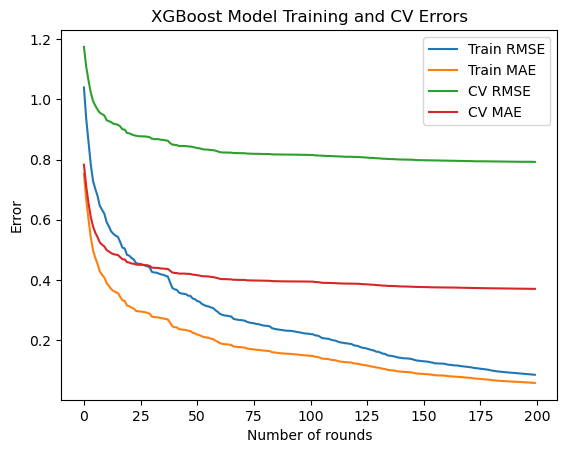

In [221]:
plot_cv_error(model)

In [222]:
plot_cv_error_by_fold(model)

TypeError: plot_cv_error_by_fold() missing 3 required positional arguments: 'cv_losses', 'train_maes', and 'cv_maes'

In [223]:
def evaluate_model_xgb(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('XGBoost Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

In [224]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.5064410796558132
MSE:  0.10545377195974177
RMSE:  0.32473646539885503


(122    3.0741
 123    1.1955
 124    1.7026
 125   -0.2451
 126    0.5040
 127    0.3773
 128   -0.4756
 129    0.5386
 130   -0.2797
 131   -0.1875
 132   -0.2797
 133   -0.3488
 134    0.1813
 135   -0.3719
 136    0.5732
 137    0.8498
 138    0.2159
 139    0.1813
 140   -0.0261
 141   -0.4871
 142    0.9420
 143   -0.3834
 144   -0.0607
 145   -0.2566
 146   -0.4525
 147    0.0776
 148   -0.0376
 149   -0.3603
 150    1.1264
 151   -0.4064
 152   -0.2105
 153   -0.4525
 154   -0.0261
 155   -0.1068
 156    0.1007
 157    0.8383
 158    0.5271
 159   -0.4064
 160   -0.0261
 161   -0.0722
 162   -0.1644
 163    0.0891
 164    0.2620
 165   -0.3373
 166   -0.2336
 167    6.1282
 168   -0.4986
 169   -0.5217
 170   -0.4295
 171   -0.3949
 172   -0.3142
 173   -0.3027
 174   -0.1759
 175   -0.3027
 176   -0.0722
 177   -0.1414
 178   -0.3373
 179   -0.4295
 180   -0.1298
 181   -0.3834
 182    1.2877
 183   -0.4641
 184   -0.5563
 185    0.3196
 186   -0.4871
 187   -0.0607
 188   -0.

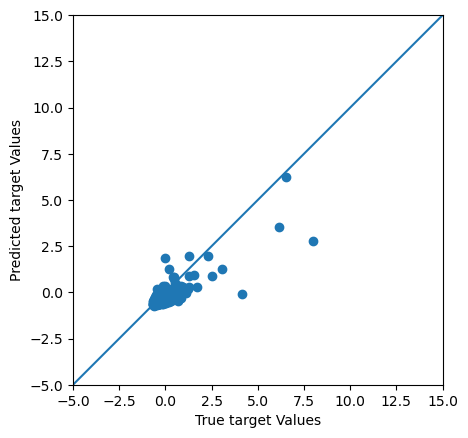

In [2530]:
# Calling trained model for predictions:
# Y_test_predictions = pd.Series(model.predict().flatten(),index=df_region_apply_target['predicted_value'].index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test_apply, df_region_apply_target['predicted_value'])
plt.xlabel('True target Values')
plt.ylabel('Predicted target Values')
lims = [-5, 15]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

# y_test_apply, df_region_apply_target['predicted_value']

#### Potential ways to improve the XGBoost model:

        1. Feature Engineering: This involves creating new features from the existing ones or selecting more informative features to improve model performance.

        2. Hyperparameter Tuning: XGBoost has several hyperparameters that can be tuned to improve model performance, such as the learning rate, maximum depth, minimum child weight, and number of estimators.

        3. Ensemble Methods: Combining multiple XGBoost models can lead to better performance. For example, you could train several XGBoost models with different hyperparameters or using different subsets of features and combine their predictions.

        4. Regularization: Regularization techniques like L1 or L2 regularization can be used to prevent overfitting and improve model performance.

        5. Data Augmentation: Generating more training data through data augmentation techniques can help improve model performance, especially when working with smaller datasets.

        6. Other Boosting Algorithms: XGBoost is just one of several boosting algorithms. Trying other algorithms like LightGBM, CatBoost, or AdaBoost may lead to better performance on your specific problem.

In [ ]:
def xgb_objective(params):
    reg = XGBRegressor(**params, objective='reg:squarederror', n_jobs=-1, random_state=42)
    reg.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    preds = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return {'loss': rmse, 'status': STATUS_OK}

# def xgb_objective(params):
#     reg = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
#     reg.set_params(**params)
#     result = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
#     loss = np.sqrt(-result.mean())
#     return {'loss': loss, 'params': params, 'status': STATUS_OK}

# set hyperparameters search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0.1, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 10)
}

# perform hyperparameter tuning using TPE algorithm
trials = Trials()
best = fmin(xgb_objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

# train optimized XGBoost model
model = XGBRegressor(**best, objective='reg:squarederror', n_jobs=-1, random_state=42)
model.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

# evaluate optimized XGBoost model
preds = model.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print('Optimized XGBoost Model Performance')
print('R2 Score: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)


def plot_history_xgb(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('XGBoost Model RMSE')
    plt.show()

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  2%|▏         | 1/50 [00:10<08:31, 10.43s/trial, best loss: 0.4402901398781817]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  4%|▍         | 2/50 [00:21<08:24, 10.51s/trial, best loss: 0.3879014250302196]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  6%|▌         | 3/50 [00:37<10:12, 13.03s/trial, best loss: 0.3879014250302196]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  8%|▊         | 4/50 [00:53<11:06, 14.50s/trial, best loss: 0.3879014250302196]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 10%|█         | 5/50 [00:58<08:06, 10.82s/trial, best loss: 0.38709294218360507]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 12%|█▏        | 6/50 [01:10<08:18, 11.33s/trial, best loss: 0.38709294218360507]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 14%|█▍        | 7/50 [01:27<09:27, 13.21s/trial, best loss: 0.3765988567797993] 

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 16%|█▌        | 8/50 [01:41<09:25, 13.45s/trial, best loss: 0.3765988567797993]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 18%|█▊        | 9/50 [01:57<09:39, 14.12s/trial, best loss: 0.3765988567797993]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 20%|██        | 10/50 [02:01<07:28, 11.20s/trial, best loss: 0.3765988567797993]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 22%|██▏       | 11/50 [02:17<08:07, 12.50s/trial, best loss: 0.3765988567797993]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 24%|██▍       | 12/50 [02:23<06:48, 10.74s/trial, best loss: 0.3765988567797993]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 26%|██▌       | 13/50 [02:30<05:46,  9.38s/trial, best loss: 0.3765988567797993]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 28%|██▊       | 14/50 [02:56<08:40, 14.47s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 30%|███       | 15/50 [03:15<09:14, 15.85s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 32%|███▏      | 16/50 [03:26<08:10, 14.42s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 34%|███▍      | 17/50 [03:34<06:52, 12.50s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 36%|███▌      | 18/50 [03:51<07:20, 13.76s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 38%|███▊      | 19/50 [04:03<06:53, 13.34s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 40%|████      | 20/50 [04:18<06:58, 13.94s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 42%|████▏     | 21/50 [04:46<08:41, 17.99s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 44%|████▍     | 22/50 [05:00<07:53, 16.91s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 46%|████▌     | 23/50 [05:03<05:43, 12.73s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 48%|████▊     | 24/50 [05:26<06:53, 15.89s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 50%|█████     | 25/50 [05:38<06:02, 14.52s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 52%|█████▏    | 26/50 [05:46<05:03, 12.63s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 54%|█████▍    | 27/50 [05:59<04:55, 12.85s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 56%|█████▌    | 28/50 [06:17<05:13, 14.24s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 58%|█████▊    | 29/50 [06:23<04:09, 11.88s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 60%|██████    | 30/50 [06:33<03:46, 11.30s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 62%|██████▏   | 31/50 [06:55<04:33, 14.37s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 64%|██████▍   | 32/50 [06:59<03:25, 11.41s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 66%|██████▌   | 33/50 [07:13<03:24, 12.01s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 68%|██████▊   | 34/50 [07:30<03:36, 13.50s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 70%|███████   | 35/50 [07:44<03:27, 13.84s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 72%|███████▏  | 36/50 [07:54<02:55, 12.51s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 74%|███████▍  | 37/50 [08:04<02:35, 11.94s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 76%|███████▌  | 38/50 [08:21<02:41, 13.46s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 78%|███████▊  | 39/50 [08:31<02:15, 12.31s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 80%|████████  | 40/50 [08:50<02:23, 14.39s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 82%|████████▏ | 41/50 [09:03<02:05, 13.90s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 84%|████████▍ | 42/50 [09:16<01:49, 13.68s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 86%|████████▌ | 43/50 [09:36<01:47, 15.40s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 88%|████████▊ | 44/50 [09:42<01:16, 12.74s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 90%|█████████ | 45/50 [09:54<01:02, 12.57s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 92%|█████████▏| 46/50 [10:07<00:50, 12.58s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 94%|█████████▍| 47/50 [10:25<00:43, 14.33s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 96%|█████████▌| 48/50 [10:48<00:33, 16.80s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 98%|█████████▊| 49/50 [11:04<00:16, 16.69s/trial, best loss: 0.3579464442203707]

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



100%|██████████| 50/50 [11:26<00:00, 13.73s/trial, best loss: 0.3579464442203707]


c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Optimized XGBoost Model Performance
R2 Score:  0.4823427062532928
MSE:  0.13523727820744932
RMSE:  0.3677462144026085
